In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib inline

left_video = []
right_video = []
i_video = -1

print(len(left_video))
# left_video.append([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
# right_video.append([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

# print(left_video)

# left_video.append([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

# print(left_video)
# print(left_video[1][2])

0


In [2]:


dist_pickle = pickle.load(open('camera_cal/calibration_pickle.p','rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']



def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])] = 1
    return binary_output

def color_thresh(img, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel>=sthresh[0]) & (s_channel<=sthresh[1])] = 1
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel>=vthresh[0]) & (v_channel<=vthresh[1])] = 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary==1) & (v_binary==1)] = 1
    return output

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [3]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])
bot_width = .76
mid_width = .08
height_pct = .62
bottom_trim = .935

src = np.float32([ [img_size[0]*(.5-mid_width/2), img_size[1]*height_pct], [img_size[0]*(.5+mid_width/2), img_size[1]*height_pct],\
                [img_size[0]*(.5+bot_width/2), img_size[1]*bottom_trim], [img_size[0]*(.5-bot_width/2), img_size[1]*bottom_trim] ])
offset = img_size[0]*.25
dst = np.float32([ [offset, 0], [img_size[0]-offset, 0],\
                   [img_size[0]-offset, img_size[1]], [offset, img_size[1]] ])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
    

95604.3671376836 m 467.8729897973614 m


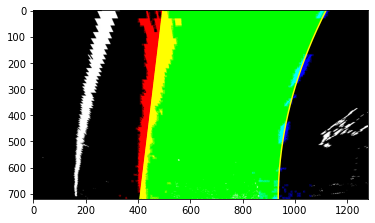

In [42]:
binary_warped = mpimg.imread('test_images/tracked0.jpg')/255

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

left_video = []
right_video = []
i_video = -1

def find_lane_pixels(binary_warped):
    global left_video
    global right_video
    global i_video
    
    if len(left_video)==0 and len(right_video)==0:
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nwindows = 9
        margin = 100   
        minpix = 50  # Set minimum number of pixels found to recenter window

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin        
            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]        
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    else:
        margin = 30
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_video[i_video][0]*(nonzeroy**2) + left_video[i_video][1]*nonzeroy + 
                        left_video[i_video][2] - margin)) & (nonzerox < (left_video[i_video][0]*(nonzeroy**2) + 
                        left_video[i_video][1]*nonzeroy + left_video[i_video][2] + margin)))
        right_lane_inds = ((nonzerox > (right_video[i_video][0]*(nonzeroy**2) + right_video[i_video][1]*nonzeroy + 
                        right_video[i_video][2] - margin)) & (nonzerox < (right_video[i_video][0]*(nonzeroy**2) + 
                        right_video[i_video][1]*nonzeroy + right_video[i_video][2] + margin)))
        print(len(left_lane_inds))
        print(len(right_lane_inds))
        
        if len(left_lane_inds)<47000 or len(right_lane_inds)<47000:
             # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
            # Create an output image to draw on and visualize the result
            #out_img = np.dstack((binary_warped, binary_warped, binary_warped))
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]//2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            nwindows = 9
            margin = 100   
            minpix = 50  # Set minimum number of pixels found to recenter window

            # Set height of windows - based on nwindows above and image shape
            window_height = np.int(binary_warped.shape[0]//nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated later for each window in nwindows
            leftx_current = leftx_base
            rightx_current = rightx_base

            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin        
                # Identify the nonzero pixels in x and y within the window #
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]        
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                      

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    #margin = 100
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    global left_video
    global right_video
    global i_video
    left_video.append(left_fit)
    right_video.append(right_fit)
    i_video = i_video + 1  #CK
    

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
     # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])  
    print(left_curverad, 'm', right_curverad, 'm')
    curverad = min(left_curverad, right_curverad)
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center - binary_warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    window_img = np.zeros_like(out_img)
    left_boundary = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_boundary = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    boundary = np.hstack((left_boundary, right_boundary))
    cv2.fillPoly(window_img, np.int_([boundary]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, curverad, center_diff, side_pos


out_img, curverad, center_diff, side_pos = fit_polynomial(binary_warped)

plt.imshow(out_img)
#plt.imshow(out_img.astype('uint8'))

In [27]:
print(i_video)
print(right_video)

0
[array([ 3.51007086e-04, -5.06173683e-01,  1.11820833e+03])]


(720, 1280, 3)


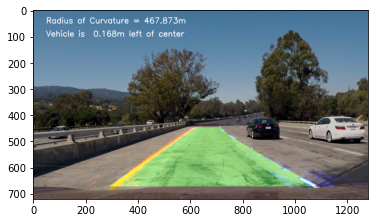

In [28]:
image = mpimg.imread('test_images/test1.jpg')
unwarped = cv2.warpPerspective(out_img, Minv, img_size, flags=cv2.INTER_NEAREST)
print(unwarped.shape)
unwarped = np.array(unwarped, dtype=np.uint8)
plt.imshow(unwarped)

result = weighted_img(unwarped,image,α=0.8, β=1.)

cv2.putText(result, 'Radius of Curvature = ' + str(round(curverad,3))\
                + 'm', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
cv2.putText(result, 'Vehicle is  ' + str(abs(round(center_diff,3)))\
                + 'm ' + side_pos +' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
              
plt.imshow(result, cmap='gray')

#plt.imshow(unwarped)

In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1], img.shape[0])  
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh=(12,255))
    grady = abs_sobel_thresh(img, orient='y', thresh=(25,255))
    c_binary = color_thresh(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx==1) & (grady==1) | (c_binary==1))] = 255
    
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_NEAREST)
    binary_warped = warped/255
    
    out_img, curverad, center_diff, side_pos = fit_polynomial(binary_warped) #find left/right line pixels and polyfit
    
    unwarped = cv2.warpPerspective(out_img, Minv, img_size, flags=cv2.INTER_NEAREST)
    unwarped = np.array(unwarped, dtype=np.uint8)
    
    result = weighted_img(unwarped,img,α=0.8, β=1.)  
    cv2.putText(result, 'Radius of Curvature = ' + str(round(curverad,3))\
                + 'm', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, 'Vehicle is  ' + str(abs(round(center_diff,3)))\
                + 'm ' + side_pos +' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return result


t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

400.57334404093325 m 577.0638701797707 m
Moviepy - Building video output_images/project_video_output2.mp4.
Moviepy - Writing video output_images/project_video_output2.mp4

57594
57594
408.0514946772445 m 544.1419185081991 m


t:   0%|▏                                                                   | 3/1260 [00:00<01:53, 11.06it/s, now=None]

56110
56110
409.1072548071378 m 515.4979133417494 m
58835
58835
412.7844676501642 m 535.6200672853703 m


t:   0%|▎                                                                   | 5/1260 [00:00<02:22,  8.79it/s, now=None]

59714
59714
432.3137172937125 m 606.4103049064664 m
59827
59827
422.0807627360403 m 694.5174222670204 m


t:   1%|▍                                                                   | 7/1260 [00:00<02:35,  8.04it/s, now=None]

59737
59737
427.12177658564906 m 854.3692643703653 m
57450
57450
455.466935800982 m 950.4328389501331 m


t:   1%|▍                                                                   | 9/1260 [00:01<02:41,  7.76it/s, now=None]

56357
56357
466.87725299683234 m 1230.3530124499846 m
55434
55434
476.200104800398

t:   1%|▌                                                                  | 11/1260 [00:01<02:47,  7.44it/s, now=None]

 m 1074.742819266285 m
53485
53485
452.68003453873234 m 879.5914961358349 m


t:   1%|▋                                                                  | 12/1260 [00:01<02:51,  7.26it/s, now=None]

51344
51344
458.41142489615265 m 1023.7094790047294 m
49809
49809
504.5456775125096 

t:   1%|▋                                                                  | 14/1260 [00:01<02:49,  7.34it/s, now=None]

m 697.9150220607908 m
51224
51224
517.7596065649802 m 718.2795661677512 m


t:   1%|▊                                                                  | 15/1260 [00:01<02:47,  7.41it/s, now=None]

51648
51648
524.9673844047201 m 618.606546988743 m
57663
57663
464.20895538202063

t:   1%|▊                                                                  | 16/1260 [00:02<02:54,  7.13it/s, now=None]

 m 641.5285420646028 m
61793
61793
437.7451794676787 m 648.5664061734782 m


t:   1%|▉                                                                  | 18/1260 [00:02<03:04,  6.71it/s, now=None]

62341
62341
412.2775913847157 m 658.0584510416597 m
62251
62251


t:   2%|█                                                                  | 19/1260 [00:02<03:12,  6.43it/s, now=None]

405.6807328980212 m 613.0585950574315 m
59241
59241
416.80682611531955 m 567.378578354201 m


t:   2%|█                                                                  | 21/1260 [00:02<03:07,  6.62it/s, now=None]

57418
57418
432.7101219460639 m 507.04207349146867 m
56454
56454
470.2202809938276 m 454.0680950084179 m


t:   2%|█▎                                                                 | 24/1260 [00:03<02:50,  7.27it/s, now=None]

52573
52573
477.7701082299466 m 400.6878252386176 m
49857
49857
464.6143846206136 m 381.55254805319953 m


t:   2%|█▎                                                                 | 25/1260 [00:03<02:48,  7.31it/s, now=None]

52154
52154
401.9513851499785 m 437.3117137860353 m
51230
51230
391.252845660262 m 471.47402954152403 m


t:   2%|█▍                                                                 | 28/1260 [00:03<02:39,  7.73it/s, now=None]

50643
50643
407.3582063933291 m 463.8812118860382 m
49324
49324
385.9889359578549 m 428.60196077752016 m


t:   2%|█▌                                                                 | 30/1260 [00:03<02:28,  8.28it/s, now=None]

45881
45881
391.7021480415175 m 637.8249801126174 m
46782
46782
373.1014458008634 m 377.2880442428164 m


t:   2%|█▋                                                                 | 31/1260 [00:04<02:33,  7.98it/s, now=None]

47826
47826
353.1620121736872 m 408.4803958017302 m
52582
52582
362.24037902217185 m 469.31155794365213 m


t:   3%|█▊                                                                 | 33/1260 [00:04<02:38,  7.72it/s, now=None]

54066
54066
337.1684467065449 m 517.8610967807133 m
53803
53803
341.88713214650136 m 620.8306998072155 m


t:   3%|█▊                                                                 | 35/1260 [00:04<02:39,  7.70it/s, now=None]

48876
48876
324.61079700437233 m 547.2236338706263 m
51027
51027
326.27070763660396 m 510.0902653857138 m


t:   3%|█▉                                                                 | 37/1260 [00:04<02:41,  7.55it/s, now=None]

52600
52600
319.80164174124394 m 541.1325935785608 m
51480
51480
323.01377980375 m 479.05668742704563 m


t:   3%|██                                                                 | 39/1260 [00:05<02:54,  7.01it/s, now=None]

53846
53846
324.07835178173525 m 426.04713859737535 m
55548
55548
320.22260038086415

t:   3%|██▏                                                                | 41/1260 [00:05<02:56,  6.92it/s, now=None]

 m 418.40549751834095 m
55472
55472
328.57978512562687 m 438.51065561915937 m


t:   3%|██▏                                                                | 42/1260 [00:05<02:51,  7.11it/s, now=None]

54339
54339
328.98560172893116 m 446.9001054907492 m
54905
54905
334.47261743524456 m 436.96480634792994 m


t:   3%|██▎                                                                | 44/1260 [00:05<02:50,  7.12it/s, now=None]

53875
53875
345.23753722087565 m 455.822832838429 m
51565
51565
363.69176963319313 m 409.1737538496776 m


t:   4%|██▍                                                                | 46/1260 [00:06<02:45,  7.33it/s, now=None]

49527
49527
376.94755423079886 m 399.72741279196646 m
50966
50966
391.6780709781469 m 373.19381246826663 m


t:   4%|██▌                                                                | 48/1260 [00:06<02:48,  7.21it/s, now=None]

51251
51251
411.87099158419227 m 383.7058935243943 m
50010
50010
418.4854534895527

t:   4%|██▋                                                                | 50/1260 [00:06<02:52,  7.01it/s, now=None]

 m 407.7046333223875 m
48701
48701
439.632051276441 m 373.3145738427333 m


t:   4%|██▋                                                                | 51/1260 [00:06<02:56,  6.87it/s, now=None]

47065
47065
447.4413409799175 m 361.998498642129 m
48684
48684
469.7306769833969

t:   4%|██▊                                                                | 53/1260 [00:07<02:50,  7.10it/s, now=None]

 m 354.78949139084165 m
49008
49008
459.50243801467906 m 377.47034759130173 m


t:   4%|██▊                                                                | 54/1260 [00:07<02:50,  7.09it/s, now=None]

52629
52629
459.7973255486704 m 438.2616149642516 m
51432
51432
475.6844341625295

t:   4%|██▉                                                                | 56/1260 [00:07<02:50,  7.04it/s, now=None]

 m 544.1779922170417 m
50355
50355
487.7652658605183 m 581.5332172111313 m


t:   5%|███                                                                | 57/1260 [00:07<02:52,  6.99it/s, now=None]

50949
50949
478.26005273981554 m 579.7479194668396 m
50244
50244
469.0362202767847 m 610.9141510249099 m


t:   5%|███▏                                                               | 59/1260 [00:08<02:49,  7.10it/s, now=None]

51137
51137
482.0689167998763 m 756.6095597214863 m
53028
53028


t:   5%|███▏                                                               | 61/1260 [00:08<02:51,  7.00it/s, now=None]

455.8870157183302 m 871.1471601261649 m
56212
56212
433.757213943107 m 679.6035495729272 m


t:   5%|███▎                                                               | 62/1260 [00:08<02:50,  7.03it/s, now=None]

58490
58490
423.67305407606403 m 555.5169692387485 m
59158
59158
402.48934463706746 m 564.0743275243705 m


t:   5%|███▍                                                               | 64/1260 [00:08<02:56,  6.79it/s, now=None]

58248
58248
409.5872923383411 m 542.1069958710594 m
60768
60768
398.481597240672

t:   5%|███▌                                                               | 66/1260 [00:09<02:55,  6.80it/s, now=None]

 m 510.8681817291429 m
60126
60126
435.0846836985592 m 463.4909025359728 m


t:   5%|███▌                                                               | 67/1260 [00:09<02:55,  6.79it/s, now=None]

61296
61296
403.9057111268062 m 456.3587917193323 m
59333
59333
422.0415109080348

t:   5%|███▌                                                               | 68/1260 [00:09<02:57,  6.73it/s, now=None]

 m 413.7536151971042 m
57663
57663
422.1610516564683 m 354.82907789525495 m


t:   6%|███▋                                                               | 70/1260 [00:09<02:58,  6.68it/s, now=None]

58403
58403
415.34722052786213 m 345.27834002938204 m
56661
56661
447.74164964266043 m 290.00359216983725 m


t:   6%|███▊                                                               | 72/1260 [00:09<02:49,  7.02it/s, now=None]

57602
57602
434.53838980829465 m 279.7525264876015 m
56622
56622
477.5599025028568 m 274.7532286365944 m


t:   6%|███▉                                                               | 74/1260 [00:10<02:45,  7.17it/s, now=None]

55556
55556
494.9652890448285 m 274.67216985751213 m
57716
57716
498.37396777760154 m 286.115299738606 m


t:   6%|████                                                               | 76/1260 [00:10<02:49,  6.98it/s, now=None]

54929
54929
519.3802192640778 m 289.67991330104405 m
55158
55158
512.7763189621127 m 303.3134979340328 m


t:   6%|████▏                                                              | 78/1260 [00:10<02:53,  6.80it/s, now=None]

53109
53109
568.6366475981316 m 313.4161117367254 m
52892
52892
565.5413728564057 m 327.62036821559997 

t:   6%|████▎                                                              | 80/1260 [00:11<02:49,  6.97it/s, now=None]

m
51172
51172
576.0243955224221 m 338.4502803675485 m


t:   6%|████▎                                                              | 81/1260 [00:11<02:52,  6.84it/s, now=None]

52942
52942
559.944803291843 m 350.34631124833334 m
54298
54298
518.1797739171242 m 391.82456558584 m


t:   7%|████▍                                                              | 83/1260 [00:11<02:51,  6.85it/s, now=None]

56337
56337
494.7039516776179 m 423.3888640608319 m
53252
53252
486.79733113107574

t:   7%|████▍                                                              | 84/1260 [00:11<02:55,  6.72it/s, now=None]

 m 439.3136648793746 m
51028
51028
495.6283427991967 m 430.3352808949435 m


t:   7%|████▌                                                              | 86/1260 [00:12<02:55,  6.69it/s, now=None]

50391
50391
472.82262656790084 m 447.3170948773432 m
51118
51118
468.4681723977488

t:   7%|████▋                                                              | 88/1260 [00:12<02:53,  6.77it/s, now=None]

 m 486.82798061856363 m
53309
53309
443.6013671224648 m 521.4836838577459 m


t:   7%|████▋                                                              | 89/1260 [00:12<02:50,  6.87it/s, now=None]

52413
52413
395.3525234640142 m 528.2106346653255 m
58066
58066
364.3584374106669 m 527.8641337541898 m


t:   7%|████▉                                                              | 92/1260 [00:12<02:46,  7.01it/s, now=None]

56214
56214
324.70878592616566 m 505.5423149335045 m
56610
56610
343.41614488364445 m 500.2288868842778 m


t:   7%|████▉                                                              | 93/1260 [00:13<02:49,  6.88it/s, now=None]

53730
53730
342.73211929675006 m 493.08182267969795 m
55703
55703
318.59854427000874 m 564.9418907402331 m


t:   8%|█████                                                              | 95/1260 [00:13<02:47,  6.94it/s, now=None]

52225
52225
318.75949959781803 m 542.7996579848187 m
50095
50095
334.50983582510065 m 467.24012782709787 m


t:   8%|█████▏                                                             | 97/1260 [00:13<02:43,  7.09it/s, now=None]

51203
51203
342.8022025650673 m 401.58396606523536 m
50362
50362
335.08213107794666 m 357.364466284525 m


t:   8%|█████▎                                                             | 99/1260 [00:13<02:43,  7.10it/s, now=None]

48647
48647
354.8209710454042 m 304.676211785274 m
51428
51428
341.5164788576481 m 311.652256048286 m


t:   8%|█████▎                                                            | 101/1260 [00:14<02:42,  7.15it/s, now=None]

49338
49338
353.19923106502824 m 292.5710844488759 m
52358
52358
344.73196936209814 m 317.1466379956019 m


t:   8%|█████▍                                                            | 103/1260 [00:14<02:39,  7.25it/s, now=None]

53844
53844
338.510958661234 m 346.7943126284604 m
52925
52925


t:   8%|█████▍                                                            | 104/1260 [00:14<02:48,  6.87it/s, now=None]

343.49765913699235 m 364.67371510573963 m
55245
55245
338.9546042872424 m 370.3223196220495 m


t:   8%|█████▌                                                            | 106/1260 [00:14<02:51,  6.72it/s, now=None]

52307
52307
364.66888778370384 m 351.0087708041962 m
48417
48417
360.82540444467145

t:   9%|█████▋                                                            | 108/1260 [00:15<02:43,  7.06it/s, now=None]

 m 331.48889404662066 m
46905
46905
366.93599108858234 m 486.75583558100055 m


t:   9%|█████▋                                                            | 109/1260 [00:15<02:41,  7.12it/s, now=None]

52337
52337
346.797646676854 m 575.3250246728118 m
53594
53594
342.2230501472934

t:   9%|█████▊                                                            | 110/1260 [00:15<02:48,  6.83it/s, now=None]

 m 525.5036095009247 m
58087
58087
342.8978657975526 m 464.3606253994682 m


t:   9%|█████▊                                                            | 112/1260 [00:15<02:58,  6.44it/s, now=None]

55751
55751
340.15711205408263 m 485.5849199398666 m
52214
52214
370.4489854038907 m 401.6541581000904 m


t:   9%|█████▉                                                            | 114/1260 [00:16<02:47,  6.86it/s, now=None]

50591
50591
358.1335012725811 m 357.6151799188728 m
53345
53345
356.51682074953754 m 333.39717635467554 m


t:   9%|██████▏                                                           | 117/1260 [00:16<02:41,  7.07it/s, now=None]

55869
55869
339.76380227297847 m 382.64038128387375 m
57826
57826
335.803689286669 m 413.3873388605195 m


t:   9%|██████▏                                                           | 118/1260 [00:16<02:42,  7.03it/s, now=None]

57926
57926
338.3977220479567 m 433.6869330674301 m
54486
54486
339.26267091527427

t:   9%|██████▏                                                           | 119/1260 [00:16<02:44,  6.93it/s, now=None]

 m 464.93736756511043 m
58558
58558
345.2179162462115 m 470.31618658062183 m


t:  10%|██████▎                                                           | 121/1260 [00:17<02:48,  6.77it/s, now=None]

55856
55856
324.6742794974663 m 457.53761851036353 m
53565
53565
341.7273087671428 m 395.70710749392987 m


t:  10%|██████▍                                                           | 123/1260 [00:17<02:44,  6.93it/s, now=None]

52747
52747
342.82883309433106 m 354.75817412267446 m
56349
56349
342.51221164851455

t:  10%|██████▌                                                           | 125/1260 [00:17<02:38,  7.14it/s, now=None]

 m 374.79586609938866 m
55147
55147
338.4883154646409 m 408.69429595293894 m


t:  10%|██████▌                                                           | 126/1260 [00:17<02:36,  7.23it/s, now=None]

57270
57270
344.2724716306918 m 454.6892040477454 m
53368
53368
365.8336005654792 m 399.60799590432646 m


t:  10%|██████▋                                                           | 128/1260 [00:18<02:37,  7.19it/s, now=None]

56444
56444
368.1957775678755 m 421.12731954134307 m
53927
53927
380.1088800579205 m 386.13876209492884 m


t:  10%|██████▊                                                           | 130/1260 [00:18<02:35,  7.26it/s, now=None]

53978
53978
360.06616764486705 m 456.3987906748155 m
55624
55624
369.4175698992344

t:  10%|██████▉                                                           | 132/1260 [00:18<02:36,  7.21it/s, now=None]

 m 494.9175161495067 m
54985
54985
373.18378878892935 m 474.08227986501026 m


t:  11%|██████▉                                                           | 133/1260 [00:18<02:36,  7.21it/s, now=None]

53253
53253
375.21208253375073 m 465.6949945577911 m
57532
57532
377.9834587506677

t:  11%|███████                                                           | 135/1260 [00:19<02:39,  7.06it/s, now=None]

 m 383.88097117125227 m
56487
56487
377.3760490585667 m 372.7130904669878 m


t:  11%|███████                                                           | 136/1260 [00:19<02:40,  7.01it/s, now=None]

55157
55157
391.35887124712775 m 337.84125427842366 m
58218
58218
407.0463882595871 m 340.0046411844499 m


t:  11%|███████▏                                                          | 138/1260 [00:19<02:39,  7.04it/s, now=None]

55225
55225
422.21134226319805 m 339.44614425490573 m
56315
56315
433.4661017581032 m 344.9712797264829 m


t:  11%|███████▎                                                          | 140/1260 [00:19<02:36,  7.14it/s, now=None]

55558
55558
460.4230397201574 m 342.780859029469 m
55671
55671
460.79021350952917 m 360.1493791340228 m


t:  11%|███████▍                                                          | 142/1260 [00:20<02:37,  7.09it/s, now=None]

56925
56925
468.1499120474925 m 379.138343958846 m
55712
55712
452.44714212551435 m 392.36459618790786 m


t:  12%|███████▌                                                          | 145/1260 [00:20<02:37,  7.09it/s, now=None]

58189
58189
422.5097346934293 m 505.5794402707363 m
58702
58702
427.3314880072385 m 557.9553151564035 m


t:  12%|███████▋                                                          | 146/1260 [00:20<02:35,  7.16it/s, now=None]

56145
56145
425.0997994263051 m 499.85545495818565 m
54527
54527
402.69240843093496

t:  12%|███████▊                                                          | 148/1260 [00:20<02:38,  7.00it/s, now=None]

 m 510.6254235957112 m
55375
55375
408.4200242953637 m 413.96565350786693 m


t:  12%|███████▊                                                          | 149/1260 [00:21<02:43,  6.79it/s, now=None]

59901
59901
356.9163917439779 m 453.6119904671188 m
60743
60743
356.1277320844979

t:  12%|███████▉                                                          | 151/1260 [00:21<02:38,  7.00it/s, now=None]

 m 505.0703726584009 m
58620
58620
381.827804557828 m 502.7559583189109 m


t:  12%|███████▉                                                          | 152/1260 [00:21<02:41,  6.86it/s, now=None]

54939
54939
397.7848318345932 m 440.7985029847425 m
56702
56702
391.78417736911985

t:  12%|████████                                                          | 154/1260 [00:21<02:35,  7.10it/s, now=None]

 m 408.91582790538877 m
57691
57691
371.62103773926816 m 497.37786864813364 m


t:  12%|████████                                                          | 155/1260 [00:21<02:34,  7.15it/s, now=None]

57051
57051
405.54290352490557 m 460.55872387114397 m
55174
55174
418.3200819495555 m 432.73460757626134 m


t:  12%|████████▏                                                         | 157/1260 [00:22<02:34,  7.15it/s, now=None]

55014
55014
399.5064437928338 m 458.57603728675315 m
53291
53291
401.79063246024117 m 516.0247925124797 m


t:  13%|████████▎                                                         | 159/1260 [00:22<02:34,  7.11it/s, now=None]

52388
52388
359.95410092336823 m 598.2620176172493 m
52719
52719
367.35760802276246

t:  13%|████████▍                                                         | 161/1260 [00:22<02:38,  6.95it/s, now=None]

 m 731.0035070865074 m
54420
54420
356.47567334726995 m 662.4016809352663 m


t:  13%|████████▍                                                         | 162/1260 [00:22<02:35,  7.07it/s, now=None]

52951
52951
379.3968690234592 m 460.3012695757348 m
53727
53727
381.99412118559655 m 405.8793285053155 m


t:  13%|████████▌                                                         | 164/1260 [00:23<02:32,  7.17it/s, now=None]

52276
52276
391.2708174298169 m 373.2563891098452 m
53683
53683
371.9347984394955 m 388.8941077695612 m


t:  13%|████████▋                                                         | 167/1260 [00:23<02:31,  7.21it/s, now=None]

56366
56366
337.9432032449677 m 391.54899077236524 m
54758
54758
344.68111492250074 m 388.65855948395637 m


t:  13%|████████▊                                                         | 169/1260 [00:23<02:34,  7.05it/s, now=None]

58240
58240
326.7833635336163 m 376.7047807386499 m
54794
54794
342.6479812537758 m 369.27832243977474 m


t:  13%|████████▉                                                         | 170/1260 [00:23<02:34,  7.06it/s, now=None]

54943
54943
348.1158690859942 m 355.0767538695377 m
52155
52155
366.9688347891529 m 311.32006177705364 m


t:  14%|█████████                                                         | 172/1260 [00:24<02:38,  6.87it/s, now=None]

51841
51841
358.47840093719276 m 278.62799741434554 m
50994
50994
357.4982035810954 m 252.9036472065616 m


t:  14%|█████████                                                         | 174/1260 [00:24<02:34,  7.04it/s, now=None]

52860
52860
341.73311967769354 m 267.3506600752222 m
55851
55851
312.66697318395364 m 276.45590195506924 m


t:  14%|█████████▏                                                        | 176/1260 [00:24<02:36,  6.93it/s, now=None]

57817
57817
299.5255837276671 m 300.6437456268531 m
57772
57772
289.77047543794583

t:  14%|█████████▎                                                        | 178/1260 [00:25<02:33,  7.07it/s, now=None]

 m 300.3993491422294 m
55355
55355
313.4445945424645 m 293.13303927425665 m


t:  14%|█████████▍                                                        | 179/1260 [00:25<02:33,  7.02it/s, now=None]

52159
52159
313.8883222155874 m 284.16669945007175 m
54511
54511
309.46570971229744 m 276.9776927701149 m


t:  14%|█████████▍                                                        | 181/1260 [00:25<02:33,  7.04it/s, now=None]

52770
52770
320.21548120235127 m 258.67943309151366 m
52633
52633
303.06730872372395 m 270.5628571829178 m


t:  15%|█████████▌                                                        | 183/1260 [00:25<02:32,  7.05it/s, now=None]

51206
51206
304.65638533130704 m 249.10978586346974 m
51723
51723
296.139869890131 m 249.36317582585977 m


t:  15%|█████████▋                                                        | 185/1260 [00:26<02:33,  7.02it/s, now=None]

53267
53267
279.7703295718421 m 314.03508553668746 m
54469
54469
270.8664968106059 m 364.8938258721412 m


t:  15%|█████████▊                                                        | 187/1260 [00:26<02:35,  6.92it/s, now=None]

61441
61441
247.62051132396866 m 355.70809314728615 m
58612
58612
239.17694220167604

t:  15%|█████████▊                                                        | 188/1260 [00:26<02:33,  6.99it/s, now=None]

 m 350.7124431413642 m
61190
61190
236.2723736440662 m 321.8111935775275 m


t:  15%|█████████▉                                                        | 190/1260 [00:26<02:39,  6.72it/s, now=None]

61516
61516
235.25947756755568 m 312.3066379852127 m
60828
60828
239.5291987971695 m 306.42847869509393 m


t:  15%|██████████                                                        | 192/1260 [00:27<02:38,  6.73it/s, now=None]

60633
60633
239.30123705936006 m 306.2016733585028 m
59833
59833
253.61151532257577

t:  15%|██████████▏                                                       | 194/1260 [00:27<02:36,  6.80it/s, now=None]

 m 302.9527825189445 m
58523
58523
247.56064725511592 m 316.5685857488349 m


t:  15%|██████████▏                                                       | 195/1260 [00:27<02:38,  6.73it/s, now=None]

57089
57089
253.21050458037388 m 324.44886665307945 m
57189
57189
260.5772873210244 m 341.0645652764225 m


t:  16%|██████████▎                                                       | 197/1260 [00:27<02:31,  7.01it/s, now=None]

55346
55346
307.84420007100266 m 303.75810954969467 m
51133
51133
349.5848059954291 m 284.1625539636655 m


t:  16%|██████████▍                                                       | 200/1260 [00:28<02:23,  7.40it/s, now=None]

45990
45990
394.8085374982141 m 538.2892686794338 m
45637
45637
422.1166761652263 m 552.539186850494 m


t:  16%|██████████▌                                                       | 202/1260 [00:28<02:15,  7.83it/s, now=None]

45077
45077
404.94752928186216 m 537.3568828528344 m
45996
45996
411.20717589610456 m 518.1317959694868 m


t:  16%|██████████▋                                                       | 203/1260 [00:28<02:19,  7.58it/s, now=None]

48087
48087
389.3040626481105 m 561.6622405972454 m
48141
48141
375.36382486157805 m 505.0365859666774 m


t:  16%|██████████▋                                                       | 205/1260 [00:28<02:19,  7.56it/s, now=None]

48598
48598
379.44673001958097 m 484.5260075171052 m
50759
50759
356.3581310700322

t:  16%|██████████▊                                                       | 207/1260 [00:29<02:22,  7.37it/s, now=None]

 m 509.69316753540954 m
51795
51795
346.0312760708909 m 590.9122013973684 m


t:  17%|██████████▉                                                       | 208/1260 [00:29<02:24,  7.30it/s, now=None]

49853
49853
314.5886047143114 m 532.2047938090732 m
50897
50897
302.9764155737301 m 566.224652026152 m


t:  17%|███████████                                                       | 210/1260 [00:29<02:22,  7.35it/s, now=None]

51258
51258
325.6847267372547 m 493.7930481256627 m
50308
50308
345.6263008388768 m 378.57711528274143 m


t:  17%|███████████                                                       | 212/1260 [00:29<02:14,  7.79it/s, now=None]

46661
46661
350.05594373033904 m 568.3876572310285 m
48487
48487
352.1528932911313 m 517.9900294800146 m


t:  17%|███████████▏                                                      | 214/1260 [00:30<02:21,  7.41it/s, now=None]

47353
47353
354.80802900661473 m 439.14134256260803 m
49561
49561
347.1249886155663 m 468.8599297709723 m


t:  17%|███████████▎                                                      | 217/1260 [00:30<02:24,  7.23it/s, now=None]

49840
49840
351.4857252272283 m 525.1938066025215 m
49788
49788
367.40274405937913 m 611.2471913704419 m


t:  17%|███████████▍                                                      | 218/1260 [00:30<02:26,  7.13it/s, now=None]

49982
49982
371.4400819367695 m 727.2770957054535 m
49431
49431
392.61624851601965 m 656.0188415068426 m


t:  17%|███████████▌                                                      | 220/1260 [00:30<02:24,  7.17it/s, now=None]

51434
51434
379.92308759958706 m 602.5482131293635 m
48842
48842
402.16709195982907 m 558.8889655226036 m


t:  18%|███████████▋                                                      | 222/1260 [00:31<02:21,  7.33it/s, now=None]

48872
48872
414.33973136344 m 502.59053277669886 m
48256
48256
420.0942543608941 m 442.0857907735665 m


t:  18%|███████████▋                                                      | 224/1260 [00:31<02:17,  7.51it/s, now=None]

46699
46699
417.13330446837574 m 454.5165744419519 m
51926
51926
392.5823031488468 m 462.84770777573203 m


t:  18%|███████████▉                                                      | 227/1260 [00:31<02:28,  6.96it/s, now=None]

49636
49636
422.4112877209089 m 447.7594148189771 m
49910
49910
379.680148436213 m 436.45702325491766 m


t:  18%|███████████▉                                                      | 228/1260 [00:32<02:26,  7.05it/s, now=None]

48235
48235
396.9993112656559 m 482.01711097704725 m
49370
49370
413.43749518412704 m 472.29141975488557 m


t:  18%|████████████                                                      | 230/1260 [00:32<02:24,  7.12it/s, now=None]

48766
48766
412.91800757909476 m 469.09221804573883 m
50047
50047
433.1714024722418 m 436.11463928987547 m


t:  18%|████████████▏                                                     | 232/1260 [00:32<02:22,  7.24it/s, now=None]

49186
49186
424.62092611164144 m 459.4035375292476 m
47774
47774
436.6173779429488 m 426.1804054683996 m


t:  19%|████████████▎                                                     | 234/1260 [00:32<02:21,  7.23it/s, now=None]

48019
48019
419.7182625917157 m 388.75335518907565 m
47534
47534
413.3383462616426 m 407.4839732011444 m


t:  19%|████████████▎                                                     | 236/1260 [00:33<02:22,  7.19it/s, now=None]

47042
47042
414.4871842158051 m 360.27966493423963 m
52621
52621
385.4761816156472 m 377.2763426811134 m


t:  19%|████████████▍                                                     | 238/1260 [00:33<02:24,  7.09it/s, now=None]

51877
51877
385.34293393040554 m 413.39238688375866 m
52595
52595
360.90198967081477 m 396.3249774574522 m


t:  19%|████████████▌                                                     | 240/1260 [00:33<02:22,  7.17it/s, now=None]

53656
53656
344.79919963131823 m 386.1136564480771 m
51918
51918
348.2419746177743 m 384.32868510944076 m


t:  19%|████████████▋                                                     | 242/1260 [00:34<02:22,  7.14it/s, now=None]

48557
48557
352.36204879676694 m 370.5449596597876 m
48233
48233
371.5645152280789 m 323.2271381038973 m


t:  19%|████████████▊                                                     | 244/1260 [00:34<02:21,  7.18it/s, now=None]

47992
47992
345.5382354585918 m 330.1876379040592 m
48577
48577
363.69861848531895 m 321.29538971406856 m


t:  20%|████████████▉                                                     | 246/1260 [00:34<02:18,  7.30it/s, now=None]

48975
48975
334.5875382613817 m 362.9256124882208 m
55660
55660
328.7165165218206 m 387.23145447503606 m


t:  20%|████████████▉                                                     | 248/1260 [00:34<02:21,  7.13it/s, now=None]

55292
55292
339.4834702292629 m 388.75491469884696 m
54071
54071
321.7857317938249 m 369.78585960602146 m


t:  20%|█████████████                                                     | 250/1260 [00:35<02:25,  6.95it/s, now=None]

53408
53408
333.95574215500346 m 358.55817540989534 m
54365
54365
338.19519588239484 m 355.29790958725886 m


t:  20%|█████████████▏                                                    | 252/1260 [00:35<02:27,  6.82it/s, now=None]

54047
54047
364.703589207697 m 304.5588389121591 m
51676
51676
371.5285439421509 m 270.5950212093006 m


t:  20%|█████████████▎                                                    | 254/1260 [00:35<02:23,  7.02it/s, now=None]

53636
53636
365.58397121762846 m 270.66047963934136 m
53287
53287
391.50634070059783 m 274.33060818405244 m


t:  20%|█████████████▍                                                    | 256/1260 [00:36<02:19,  7.21it/s, now=None]

52187
52187
380.15677156819515 m 281.6669040573604 m
53843
53843
379.09569372380685 m 271.1935405042658 m


t:  20%|█████████████▌                                                    | 258/1260 [00:36<02:19,  7.17it/s, now=None]

52629
52629
368.4900236526336 m 282.2552337279007 m
53435
53435
383.3400397364462 m 304.77287381536826 m


t:  21%|█████████████▌                                                    | 260/1260 [00:36<02:19,  7.17it/s, now=None]

55036
55036
408.0702713492003 m 291.77232102630853 m
54620
54620
390.4124188658439 m 288.6690246874687 m


t:  21%|█████████████▋                                                    | 262/1260 [00:36<02:17,  7.25it/s, now=None]

51771
51771
429.31441186735975 m 286.38919480555916 m
57289
57289
422.7468938045482 m 265.7810896051912 m


t:  21%|█████████████▊                                                    | 264/1260 [00:37<02:19,  7.16it/s, now=None]

56029
56029
414.5895445585758 m 283.43967732334 m
54886
54886


t:  21%|█████████████▉                                                    | 266/1260 [00:37<02:23,  6.94it/s, now=None]

444.30682089198365 m 300.2003837842993 m
55679
55679
455.075770727938 m 298.54433971611 m


t:  21%|██████████████                                                    | 268/1260 [00:37<02:20,  7.06it/s, now=None]

51437
51437
468.96025542953913 m 322.5253626049289 m
57412
57412
472.0172628944201 m 324.4730159614955 m


t:  21%|██████████████▏                                                   | 270/1260 [00:37<02:22,  6.93it/s, now=None]

56067
56067
474.8421713199637 m 332.6495233017343 m
52448
52448
503.3829496090198 m 333.6561754573835 m


t:  22%|██████████████▏                                                   | 271/1260 [00:38<02:26,  6.74it/s, now=None]

55160
55160
540.0891875991814 m 319.6533373747015 m
56154
56154
527.9421044987812

t:  22%|██████████████▏                                                   | 272/1260 [00:38<02:26,  6.74it/s, now=None]

 m 356.7280874618907 m
57459
57459
495.3690343608954 m 447.14362942169674 m


t:  22%|██████████████▎                                                   | 274/1260 [00:38<02:29,  6.59it/s, now=None]

57487
57487
514.3523936174844 m 532.1192266206563 m
58881
58881
491.5587465498402

t:  22%|██████████████▍                                                   | 276/1260 [00:38<02:29,  6.59it/s, now=None]

 m 613.4723064108778 m
59030
59030
536.7444012908081 m 497.924360525553 m


t:  22%|██████████████▌                                                   | 277/1260 [00:39<02:36,  6.27it/s, now=None]

59213
59213
569.6740297672617 m 396.64990601027284 m
59294
59294


t:  22%|██████████████▌                                                   | 278/1260 [00:39<02:38,  6.18it/s, now=None]

598.8590974264293 m 376.9434093896683 m
59189
59189
633.2960080502914

t:  22%|██████████████▌                                                   | 279/1260 [00:39<02:46,  5.90it/s, now=None]

 m 385.1597364673193 m
60927
60927
614.0953438583824 m 372.10456391581823 m


t:  22%|██████████████▋                                                   | 281/1260 [00:39<02:43,  5.99it/s, now=None]

60997
60997
644.8816406351166 m 360.3501348234201 m
59255
59255


t:  22%|██████████████▊                                                   | 282/1260 [00:39<02:46,  5.88it/s, now=None]

706.063340419174 m 353.42976967033985 m
62136
62136
697.6669016129557 m 412.46213606523946 m


t:  23%|██████████████▉                                                   | 284/1260 [00:40<02:35,  6.29it/s, now=None]

60014
60014
721.9824492158609 m 429.51439923726053 m
60240
60240
716.9521102465427

t:  23%|██████████████▉                                                   | 286/1260 [00:40<02:27,  6.58it/s, now=None]

 m 449.9585910519384 m
60892
60892
785.8263751009408 m 427.09146784654354 m


t:  23%|███████████████                                                   | 287/1260 [00:40<02:30,  6.49it/s, now=None]

59292
59292
846.3581737878183 m 436.9595163727952 m
58771
58771


t:  23%|███████████████▏                                                  | 289/1260 [00:40<02:26,  6.63it/s, now=None]

826.3529693698176 m 470.8006841013436 m
58901
58901
914.9138610409364 m 467.9417852303942 m


t:  23%|███████████████▏                                                  | 290/1260 [00:41<02:27,  6.58it/s, now=None]

65347
65347
833.6451986027915 m 510.419425287249 m
62358
62358
977.2788071325513 m 517.5681247871041 m


t:  23%|███████████████▎                                                  | 292/1260 [00:41<02:25,  6.65it/s, now=None]

65673
65673
891.5298806107212 m 571.6859642705343 m
66925
66925


t:  23%|███████████████▎                                                  | 293/1260 [00:41<02:25,  6.64it/s, now=None]

1021.9048630299017 m 574.8988742517223 m
66597
66597
1091.5284326027395 m 599.7586492653135 m


t:  23%|███████████████▍                                                  | 295/1260 [00:41<02:29,  6.45it/s, now=None]

69062
69062
1013.7401463974098 m 704.0068253410233 m
68771
68771
1100.6849636490135

t:  23%|███████████████▌                                                  | 296/1260 [00:42<02:28,  6.49it/s, now=None]

 m 691.2812377423522 m
69481
69481
1149.592925494817 m 914.6268948575371 m


t:  24%|███████████████▌                                                  | 298/1260 [00:42<02:30,  6.40it/s, now=None]

69738
69738
1236.137395368416 m 940.4458022575436 m
67512
67512
1372.4357780399341 m 1039.9122210252917 m


t:  24%|███████████████▋                                                  | 300/1260 [00:42<02:28,  6.44it/s, now=None]

68445
68445
1400.5561286409954 m 953.4807907255699 m
68668
68668


t:  24%|███████████████▊                                                  | 301/1260 [00:42<02:31,  6.34it/s, now=None]

1448.2467925534384 m 829.7851750523417 m
68380
68380
1613.89921066264 m 884.8184946978491 m


t:  24%|███████████████▊                                                  | 303/1260 [00:43<02:30,  6.35it/s, now=None]

61485
61485
1707.8079857953985 m 940.035390240684 m
63359
63359
1783.885133676806 m 913.5630067572305 m


t:  24%|███████████████▉                                                  | 305/1260 [00:43<02:24,  6.61it/s, now=None]

65198
65198
1997.2017845309235 m 906.3308826738145 m
62241
62241
2401.4275263137542

t:  24%|████████████████                                                  | 306/1260 [00:43<02:23,  6.66it/s, now=None]

 m 799.7112504029583 m
66830
66830
1590.2455657187477 m 933.6896557269733 m


t:  24%|████████████████▏                                                 | 308/1260 [00:43<02:27,  6.47it/s, now=None]

63998
63998
2957.094995766109 m 908.1443114204055 m
73695
73695


t:  25%|████████████████▏                                                 | 309/1260 [00:44<02:28,  6.42it/s, now=None]

1865.7618864814426 m 1662.386814669232 m
72084
72084
2554.4657034135066 m 1495.353095129897 m


t:  25%|████████████████▎                                                 | 311/1260 [00:44<02:29,  6.35it/s, now=None]

66702
66702
3398.53624400129 m 1271.6888655606658 m
69579
69579
3493.771276939656

t:  25%|████████████████▎                                                 | 312/1260 [00:44<02:27,  6.44it/s, now=None]

 m 1070.5584343168166 m
71718
71718
5665.919963115736 m 970.8129185896445 m


t:  25%|████████████████▍                                                 | 314/1260 [00:44<02:24,  6.56it/s, now=None]

72491
72491
3655.6344885760345 m 1760.7406365132588 m
69134
69134
21502.73768182976 m 1476.6718941645947 m


t:  25%|████████████████▌                                                 | 316/1260 [00:45<02:21,  6.67it/s, now=None]

72467
72467
22920.867849410468 m 1177.516733142149 m
65857
65857
26273.980875522775

t:  25%|████████████████▋                                                 | 318/1260 [00:45<02:23,  6.58it/s, now=None]

 m 1059.4346444340201 m
65299
65299
10630.640977764213 m 908.8131179896579 m


t:  25%|████████████████▋                                                 | 319/1260 [00:45<02:25,  6.48it/s, now=None]

68051
68051
10455.517015734891 m 1373.1247892447568 m
69120
69120
25189.247895253862

t:  25%|████████████████▊                                                 | 320/1260 [00:45<02:24,  6.50it/s, now=None]

 m 966.8662305629977 m
67917
67917
37818.24607933502 m 1103.728097737554 m


t:  26%|████████████████▊                                                 | 322/1260 [00:46<02:24,  6.51it/s, now=None]

65184
65184
10483.569569543399 m 1067.0832554330777 m
69179
69179
11107.908914520696 m 950.520166019165 m


t:  26%|████████████████▉                                                 | 324/1260 [00:46<02:25,  6.45it/s, now=None]

67628
67628
12103.97945325602 m 983.2586144249182 m
65909
65909
6161.083742965086

t:  26%|█████████████████                                                 | 325/1260 [00:46<02:24,  6.48it/s, now=None]

 m 967.7792620217642 m
66321
66321
14556.479490237674 m 980.0509180769994 m


t:  26%|█████████████████▏                                                | 327/1260 [00:46<02:28,  6.30it/s, now=None]

67479
67479
9165.341234211892 m 1070.5974836395608 m
64068
64068
6158.620998316539

t:  26%|█████████████████▏                                                | 328/1260 [00:47<02:28,  6.27it/s, now=None]

 m 1049.1102021630877 m
64866
64866
9083.078754390584 m 1086.0895362182055 m


t:  26%|█████████████████▎                                                | 330/1260 [00:47<02:26,  6.35it/s, now=None]

64139
64139
5101.07417828352 m 1090.0086150823938 m
64174
64174
10976.463427422552 m 1322.7503291316395 m


t:  26%|█████████████████▍                                                | 332/1260 [00:47<02:24,  6.42it/s, now=None]

65502
65502
46439.102177703404 m 2233.084646040576 m
66216
66216


t:  26%|█████████████████▍                                                | 333/1260 [00:47<02:23,  6.46it/s, now=None]

15677.009031827656 m 3792.495089609254 m
67170
67170
12433.062100424208 m 2906.733153271425 m


t:  27%|█████████████████▌                                                | 335/1260 [00:48<02:23,  6.43it/s, now=None]

68404
68404
26189.92608205655 m 1744.74135706668 m
66943
66943
82281.25107246522 m 1488.470846033334 m


t:  27%|█████████████████▋                                                | 338/1260 [00:48<02:18,  6.66it/s, now=None]

63289
63289
8172.133092916654 m 1287.4932597430661 m
64167
64167
57385.950202828586 m 1213.9261388307652 m


t:  27%|█████████████████▊                                                | 339/1260 [00:48<02:22,  6.47it/s, now=None]

66120
66120
11510.211432019438 m 1360.4611520630106 m
64581
64581
8933.173158032421 m 1382.8988441209765 m


t:  27%|█████████████████▊                                                | 341/1260 [00:49<02:21,  6.50it/s, now=None]

66994
66994
5499.076575408613 m 1825.8624825661648 m
66750
66750
7760.9349006347

t:  27%|█████████████████▉                                                | 343/1260 [00:49<02:22,  6.45it/s, now=None]

 m 1266.5202969347717 m
67155
67155
3584.3159703304427 m 1927.0303756822118 m


t:  27%|██████████████████                                                | 344/1260 [00:49<02:21,  6.47it/s, now=None]

67277
67277
13080.972861086835 m 1355.9322900681907 m
65608
65608
19088.46035282377

t:  27%|██████████████████                                                | 346/1260 [00:49<02:18,  6.61it/s, now=None]

 m 1527.9539519179923 m
66210
66210
10226.174781014393 m 1287.9958163883693 m


t:  28%|██████████████████▏                                               | 347/1260 [00:49<02:18,  6.58it/s, now=None]

64794
64794
5387.48385600494 m 1445.1481930790035 m
66982
66982
14883.080850074726

t:  28%|██████████████████▎                                               | 349/1260 [00:50<02:17,  6.63it/s, now=None]

 m 1965.83518574912 m
64518
64518
5844.072522360012 m 1952.9890112655078 m


t:  28%|██████████████████▎                                               | 350/1260 [00:50<02:17,  6.62it/s, now=None]

65945
65945
16167.447876410277 m 2497.225685794209 m
65687
65687


t:  28%|██████████████████▍                                               | 351/1260 [00:50<02:22,  6.37it/s, now=None]

5135.470620167663 m 1632.8159941876543 m
63607
63607
9892.06868862168 m 1610.9544577049223 m


t:  28%|██████████████████▍                                               | 353/1260 [00:50<02:17,  6.61it/s, now=None]

61707
61707
4357.431950485484 m 1231.3722081690776 m
62563
62563
3229.9614575456067 m 883.5750789452791 m


t:  28%|██████████████████▌                                               | 355/1260 [00:51<02:19,  6.47it/s, now=None]

64034
64034
3914.1817586022853 m 1104.617389398201 m
62170
62170
2545.2045646155266

t:  28%|██████████████████▋                                               | 356/1260 [00:51<02:20,  6.44it/s, now=None]

 m 1244.0895428363108 m
63973
63973
2607.9001111890047 m 1846.309462109073 m


t:  28%|██████████████████▊                                               | 358/1260 [00:51<02:17,  6.56it/s, now=None]

63874
63874
3319.4507596105245 m 5060.168725381817 m
61806
61806


t:  28%|██████████████████▊                                               | 359/1260 [00:51<02:19,  6.44it/s, now=None]

1906.2895960309988 m 6887.38136181641 m
63260
63260
1913.4312153890774 m 6864.519363958394 m


t:  29%|██████████████████▉                                               | 361/1260 [00:52<02:17,  6.56it/s, now=None]

62837
62837
1563.7106677810946 m 2993.064926613914 m
61111
61111
1359.5528934175898

t:  29%|███████████████████                                               | 363/1260 [00:52<02:16,  6.56it/s, now=None]

 m 2406.447950601161 m
63579
63579
1476.8811830839077 m 2337.6798460604828 m


t:  29%|███████████████████                                               | 364/1260 [00:52<02:16,  6.55it/s, now=None]

62991
62991
1235.7651087950962 m 1757.1137865255948 m
64311
64311


t:  29%|███████████████████                                               | 365/1260 [00:52<02:19,  6.40it/s, now=None]

1709.6513368394417 m 2946.1788338456618 m
64572
64572
1408.8771319152725 m 4679.206940901932 m


t:  29%|███████████████████▏                                              | 367/1260 [00:53<02:15,  6.57it/s, now=None]

64245
64245
1637.2868412899743 m 25173.23549864633 m
63741
63741
1665.7674893187784

t:  29%|███████████████████▎                                              | 369/1260 [00:53<02:14,  6.62it/s, now=None]

 m 12487.213637663144 m
62265
62265
1640.4873197926656 m 7321.35957889161 m


t:  29%|███████████████████▍                                              | 370/1260 [00:53<02:13,  6.68it/s, now=None]

63113
63113
2452.6012125403286 m 7091.406311433414 m
62003
62003
2541.94000807162 m 9664.808061076475 m


t:  30%|███████████████████▍                                              | 372/1260 [00:53<02:13,  6.64it/s, now=None]

61112
61112
3617.5632536202256 m 56844.84186988416 m
59228
59228


t:  30%|███████████████████▌                                              | 373/1260 [00:53<02:13,  6.65it/s, now=None]

3902.078518700895 m 8781.61267518228 m
61476
61476
5710.511017901137 m 33738.37363720734 m


t:  30%|███████████████████▋                                              | 375/1260 [00:54<02:16,  6.48it/s, now=None]

61034
61034
15067.700159123066 m 6377.178426673437 m
59607
59607
6420.133583920754

t:  30%|███████████████████▋                                              | 377/1260 [00:54<02:13,  6.64it/s, now=None]

 m 10838.632362470322 m
61656
61656
3151.2101131873233 m 8821.161626204339 m


t:  30%|███████████████████▊                                              | 378/1260 [00:54<02:13,  6.61it/s, now=None]

60781
60781
3092.5675784370796 m 6573.5392470745055 m
60483
60483
2708.0791473254963

t:  30%|███████████████████▉                                              | 380/1260 [00:54<02:12,  6.66it/s, now=None]

 m 27340.591636851186 m
58959
58959
2675.883332634317 m 8682.929989022225 m


t:  30%|████████████████████                                              | 382/1260 [00:55<02:10,  6.71it/s, now=None]

58357
58357
2366.804729769569 m 9009.087760555809 m
59400
59400
2417.6614553078616 m 6664.655885122944 m


t:  30%|████████████████████                                              | 383/1260 [00:55<02:10,  6.73it/s, now=None]

57990
57990
2504.3439084707134 m 6613.453259755088 m
59601
59601
2633.3811295548535 m 5451.688973558998 m


t:  31%|████████████████████▏                                             | 385/1260 [00:55<02:11,  6.66it/s, now=None]

59551
59551
2892.9423491068046 m 2420.4516494746804 m
59078
59078
2740.0204044042152

t:  31%|████████████████████▏                                             | 386/1260 [00:55<02:13,  6.52it/s, now=None]

 m 2405.310617510982 m
59090
59090
3922.185231168435 m 2631.052844979726 m


t:  31%|████████████████████▎                                             | 388/1260 [00:56<02:14,  6.49it/s, now=None]

59050
59050
4540.251532593494 m 3918.0600455728195 m
57300
57300
3575.057618980519

t:  31%|████████████████████▍                                             | 389/1260 [00:56<02:16,  6.40it/s, now=None]

 m 2231.850752005442 m
58802
58802
4167.956834300416 m 2261.8407522551825 m


t:  31%|████████████████████▍                                             | 391/1260 [00:56<02:17,  6.32it/s, now=None]

60541
60541
5655.14039269284 m 2192.8839767929344 m
58905
58905
6799.515195330464

t:  31%|████████████████████▌                                             | 392/1260 [00:56<02:16,  6.36it/s, now=None]

 m 1803.7581589648723 m
57607
57607
7890.717305870495 m 1836.9080550575702 m


t:  31%|████████████████████▋                                             | 394/1260 [00:57<02:14,  6.45it/s, now=None]

58917
58917
9913.174102035176 m 2204.310072914518 m
61005
61005
46964.06676309368

t:  31%|████████████████████▋                                             | 396/1260 [00:57<02:11,  6.57it/s, now=None]

 m 3356.6440703307676 m
61277
61277
770515.1441023173 m 8567.86154188241 m


t:  32%|████████████████████▊                                             | 397/1260 [00:57<02:12,  6.51it/s, now=None]

60984
60984
23033.480891743297 m 5469.1125596602005 m
61956
61956
10328649.414197056

t:  32%|████████████████████▊                                             | 398/1260 [00:57<02:10,  6.60it/s, now=None]

 m 3567.461405479572 m
61334
61334
17576.35801609064 m 7257.326128584531 m


t:  32%|████████████████████▉                                             | 400/1260 [00:58<02:10,  6.59it/s, now=None]

60784
60784
11754.411040710273 m 10448.715185547258 m
61312
61312
11591.310832416315

t:  32%|█████████████████████                                             | 402/1260 [00:58<02:07,  6.74it/s, now=None]

 m 4432.878094222449 m
61266
61266
22419.727043343595 m 3424.204233973738 m


t:  32%|█████████████████████                                             | 403/1260 [00:58<02:08,  6.66it/s, now=None]

61123
61123
49581.590972799655 m 2156.470428103853 m
61778
61778
23961.338363906045

t:  32%|█████████████████████▏                                            | 404/1260 [00:58<02:06,  6.76it/s, now=None]

 m 1878.4348763425985 m
61831
61831
40132.42935541222 m 4744.971461635048 m


t:  32%|█████████████████████▎                                            | 406/1260 [00:58<02:06,  6.73it/s, now=None]

59419
59419
29831.042659073715 m 5893.99795760284 m
59427
59427
36051.17120626232

t:  32%|█████████████████████▎                                            | 407/1260 [00:59<02:07,  6.67it/s, now=None]

 m 7447.721074826146 m
61103
61103
39716.00359243571 m 92271.92019162598 m


t:  32%|█████████████████████▍                                            | 409/1260 [00:59<02:09,  6.58it/s, now=None]

62274
62274
13036.660387292846 m 10120.198864153585 m
60370
60370
13584.719449990152 m 3915.0181624718357 m


t:  33%|█████████████████████▌                                            | 411/1260 [00:59<02:14,  6.33it/s, now=None]

60640
60640
6469.197146338272 m 14492.351825468495 m
60945
60945


t:  33%|█████████████████████▌                                            | 412/1260 [00:59<02:15,  6.27it/s, now=None]

5155.92163917344 m 13389.968321891964 m
61346
61346
4621.759627332678 m 5129.91233697623 m


t:  33%|█████████████████████▋                                            | 414/1260 [01:00<02:12,  6.38it/s, now=None]

60468
60468
4365.802580387427 m 2323.035744220353 m
60711
60711


t:  33%|█████████████████████▋                                            | 415/1260 [01:00<02:11,  6.43it/s, now=None]

3732.1040745663936 m 1925.504359120107 m
59684
59684
2671.0782677405305 m 3821.410945624704 m


t:  33%|█████████████████████▊                                            | 417/1260 [01:00<02:08,  6.54it/s, now=None]

60264
60264
4690.378287443549 m 52494.09549502753 m
60269
60269


t:  33%|█████████████████████▉                                            | 419/1260 [01:00<02:11,  6.37it/s, now=None]

3247.650686221379 m 8655.318682115721 m
59690
59690
4320.150460116295 m 5644.812102201116 m


t:  33%|██████████████████████                                            | 420/1260 [01:01<02:10,  6.41it/s, now=None]

59259
59259
6345.147651039815 m 3396.8945458217386 m
61102
61102
3637.137532194444

t:  33%|██████████████████████                                            | 421/1260 [01:01<02:08,  6.52it/s, now=None]

 m 3267.3215907223575 m
60904
60904
4971.92380122624 m 5168.805443599869 m


t:  34%|██████████████████████▏                                           | 423/1260 [01:01<02:08,  6.50it/s, now=None]

60585
60585
3459.0474965308554 m 6732.161315364808 m
60672
60672
11706.143132341958 m 11439.54869968939 m


t:  34%|██████████████████████▎                                           | 425/1260 [01:01<02:09,  6.45it/s, now=None]

60946
60946
17189.77849858656 m 4618.51908853561 m
61450
61450
68102.27926752191

t:  34%|██████████████████████▎                                           | 426/1260 [01:02<02:07,  6.54it/s, now=None]

 m 2615.524874541136 m
63428
63428
4584.542801868208 m 60624.04720872919 m


t:  34%|██████████████████████▍                                           | 429/1260 [01:02<02:04,  6.68it/s, now=None]

59542
59542
8759.657530826986 m 16988.93796611185 m
61341
61341
6614.458583552129 m 6396.458528586737 m


t:  34%|██████████████████████▌                                           | 430/1260 [01:02<02:05,  6.59it/s, now=None]

62756
62756
10901.272461470851 m 9050.005089866649 m
63825
63825
4449.02554721373

t:  34%|██████████████████████▌                                           | 431/1260 [01:02<02:07,  6.51it/s, now=None]

 m 2435.1050701435197 m
61490
61490
2263.4395534014297 m 1583.9889334691247 m


t:  34%|██████████████████████▋                                           | 433/1260 [01:03<02:11,  6.30it/s, now=None]

64430
64430
2291.9270848512547 m 1818.488461731538 m
64718
64718
1779.8761088902368

t:  34%|██████████████████████▋                                           | 434/1260 [01:03<02:09,  6.39it/s, now=None]

 m 1650.0906994315953 m
63332
63332
2573.6285065201787 m 2209.492773456108 m


t:  35%|██████████████████████▊                                           | 436/1260 [01:03<02:06,  6.49it/s, now=None]

65151
65151
2813.5180118868257 m 3203.8505675592532 m
61499
61499
3659.3818772683658 m 44009.870083924405 m


t:  35%|██████████████████████▉                                           | 438/1260 [01:03<02:04,  6.60it/s, now=None]

61765
61765
4786.2775741301275 m 9781.584065856516 m
59873
59873
2344.6155501122794 m 1876.1069251470171 m


t:  35%|███████████████████████                                           | 441/1260 [01:04<02:03,  6.63it/s, now=None]

62412
62412
3537.926232233484 m 1719.7776822445558 m
63605
63605
4997.745388696403 m 2548.2579411878846 m


t:  35%|███████████████████████▏                                          | 442/1260 [01:04<02:02,  6.68it/s, now=None]

61952
61952
2640.767659374025 m 2088.954733489056 m
61727
61727
2431.394805798541

t:  35%|███████████████████████▏                                          | 443/1260 [01:04<02:03,  6.63it/s, now=None]

 m 2823.9525055855147 m
62635
62635
1406.769689606549 m 1688.043131039816 m


t:  35%|███████████████████████▎                                          | 445/1260 [01:04<02:03,  6.60it/s, now=None]

63901
63901
2046.468990172227 m 2400.937522637523 m
63326
63326
2052.3622035426665 m 2828.143147787507 

t:  35%|███████████████████████▍                                          | 447/1260 [01:05<02:02,  6.63it/s, now=None]

m
62561
62561
4093.41845388628 m 10431.624916281151 m


t:  36%|███████████████████████▍                                          | 448/1260 [01:05<02:04,  6.54it/s, now=None]

62713
62713
8441.939079133703 m 192058.49576380983 m
62336
62336
8705.470688478528

t:  36%|███████████████████████▌                                          | 449/1260 [01:05<02:05,  6.45it/s, now=None]

 m 7439.4239198594905 m
60415
60415
598977.0573371078 m 8291.042954960445 m


t:  36%|███████████████████████▌                                          | 451/1260 [01:05<02:07,  6.36it/s, now=None]

60521
60521
99281.79926270587 m 6792.6251261542175 m
59867
59867
8383.095758947778

t:  36%|███████████████████████▋                                          | 452/1260 [01:06<02:06,  6.38it/s, now=None]

 m 5560.8194998648105 m
59471
59471
5655.487489295447 m 4471.538352270517 m


t:  36%|███████████████████████▊                                          | 454/1260 [01:06<02:03,  6.54it/s, now=None]

58214
58214
6331.197234992345 m 4930.485397196681 m
59131
59131
2951.5906923705993 m 9127.786458851197 m


t:  36%|███████████████████████▉                                          | 456/1260 [01:06<02:06,  6.34it/s, now=None]

58999
58999
3333.4201059094676 m 8018.405176838859 m
60468
60468
3170.955128709953 m 8211.453609840084 m


t:  36%|███████████████████████▉                                          | 458/1260 [01:06<02:03,  6.51it/s, now=None]

57611
57611
3045.368642096559 m 4552.1948994442455 m
59584
59584
3265.3214769710276

t:  36%|████████████████████████                                          | 459/1260 [01:07<02:02,  6.55it/s, now=None]

 m 3713.6540781785375 m
60143
60143
2138.152670427731 m 5628.533357137801 m


t:  37%|████████████████████████▏                                         | 461/1260 [01:07<02:01,  6.59it/s, now=None]

59235
59235
3411.888288703878 m 18649.43683949468 m
58631
58631
3547.5077246128203 m 2992.38786540064 m


t:  37%|████████████████████████▎                                         | 463/1260 [01:07<02:02,  6.52it/s, now=None]

61288
61288
5336.654744430944 m 32020.71314978903 m
60817
60817
14430.835670252443

t:  37%|████████████████████████▎                                         | 464/1260 [01:07<02:02,  6.52it/s, now=None]

 m 13514.851388514808 m
58207
58207
3367.3747789266235 m 23895.269887886123 m


t:  37%|████████████████████████▍                                         | 466/1260 [01:08<02:03,  6.43it/s, now=None]

60260
60260
4513.690418417011 m 6133.0829115092465 m
62413
62413
3204.43592783977

t:  37%|████████████████████████▍                                         | 467/1260 [01:08<02:06,  6.25it/s, now=None]

 m 6106.644136660533 m
61958
61958
5737.406395341169 m 7252.223544797474 m


t:  37%|████████████████████████▌                                         | 469/1260 [01:08<02:02,  6.45it/s, now=None]

61211
61211
7594.694070260992 m 8006.808670142973 m
61281
61281
9026.981046027478

t:  37%|████████████████████████▌                                         | 470/1260 [01:08<02:00,  6.53it/s, now=None]

 m 3047.3928121667764 m
61463
61463
17205.086809011264 m 6260.507804062785 m


t:  37%|████████████████████████▋                                         | 472/1260 [01:09<02:01,  6.47it/s, now=None]

60372
60372
43000.79978859566 m 2621.9384607510524 m
59596
59596
11682.558275252752

t:  38%|████████████████████████▊                                         | 473/1260 [01:09<02:00,  6.51it/s, now=None]

 m 2799.326378188839 m
60029
60029
17491.033982011868 m 8784.109648658376 m


t:  38%|████████████████████████▉                                         | 475/1260 [01:09<02:19,  5.63it/s, now=None]

59807
59807
23212.63336567186 m 9704.41499882798 m
61077
61077
4529.189882063452

t:  38%|████████████████████████▉                                         | 476/1260 [01:09<02:14,  5.84it/s, now=None]

 m 5849.729376006709 m
59969
59969
6997.431329110833 m 4251.608898076748 m


t:  38%|█████████████████████████                                         | 478/1260 [01:10<02:04,  6.30it/s, now=None]

59849
59849
4047.045490135341 m 8007.389859701813 m
62981
62981
3698.6053831152694

t:  38%|█████████████████████████▏                                        | 480/1260 [01:10<01:59,  6.52it/s, now=None]

 m 18171.341612444296 m
63275
63275
3617.7473288865885 m 11504.176801521768 m


t:  38%|█████████████████████████▏                                        | 481/1260 [01:10<01:55,  6.72it/s, now=None]

62851
62851
3341.742365081982 m 2767.45653285579 m
58879
58879
6980.481894665437 m 2140.639619784895 m


t:  38%|█████████████████████████▎                                        | 483/1260 [01:10<01:55,  6.73it/s, now=None]

61149
61149
4075.297468485278 m 1563.940189172725 m
61800
61800
4701.832079808794

t:  38%|█████████████████████████▍                                        | 485/1260 [01:11<01:52,  6.86it/s, now=None]

 m 1298.0584872706947 m
62229
62229
65508.424375970586 m 2444.1134249313113 m


t:  39%|█████████████████████████▍                                        | 486/1260 [01:11<01:51,  6.92it/s, now=None]

64188
64188
39154.74512504817 m 6885.2265844503945 m
63472
63472
7331.460780226798

t:  39%|█████████████████████████▌                                        | 488/1260 [01:11<01:51,  6.90it/s, now=None]

 m 17426.381396438774 m
63325
63325
11721.482295648058 m 8569.949194849607 m


t:  39%|█████████████████████████▌                                        | 489/1260 [01:11<01:50,  6.96it/s, now=None]

62511
62511
6289.133507837188 m 6314.995196384222 m
60739
60739
6308.887452980447

t:  39%|█████████████████████████▋                                        | 490/1260 [01:11<01:51,  6.92it/s, now=None]

 m 3033.352381944764 m
62994
62994
8939.328488616626 m 1831.6255939366272 m


t:  39%|█████████████████████████▊                                        | 492/1260 [01:12<01:53,  6.79it/s, now=None]

64885
64885
19130.863084865206 m 2767.737553452914 m
65164
65164
9246.730682360092

t:  39%|█████████████████████████▉                                        | 494/1260 [01:12<01:52,  6.79it/s, now=None]

 m 2433.9580443813425 m
61190
61190
49402.888721286894 m 5185.276861773398 m


t:  39%|█████████████████████████▉                                        | 495/1260 [01:12<01:53,  6.72it/s, now=None]

62664
62664
16871.06213650386 m 3129.965799068563 m
65156
65156
34025.90589939551

t:  39%|██████████████████████████                                        | 497/1260 [01:12<01:54,  6.67it/s, now=None]

 m 4001.033612644826 m
63085
63085
8566.2425006514 m 6127.290223095951 m


t:  40%|██████████████████████████                                        | 498/1260 [01:13<01:53,  6.69it/s, now=None]

60771
60771
7976.638601186485 m 2932.7945085769807 m
58652
58652
2874.730442602361

t:  40%|██████████████████████████▏                                       | 500/1260 [01:13<01:54,  6.62it/s, now=None]

 m 3052.405186859444 m
60912
60912
3369.991041998991 m 10691.452247740235 m


t:  40%|██████████████████████████▏                                       | 501/1260 [01:13<01:51,  6.79it/s, now=None]

61649
61649
5699.062485454142 m 10815.93416360083 m
59759
59759
6262.8567307013 m 216533.54425229176 m


t:  40%|██████████████████████████▎                                       | 503/1260 [01:13<01:50,  6.84it/s, now=None]

55639
55639
9773.610338696062 m 9070.330173738963 m
56601
56601
2385.962083354629

t:  40%|██████████████████████████▍                                       | 505/1260 [01:14<01:47,  6.99it/s, now=None]

 m 5872.676925586724 m
60584
60584
2253.2625679960106 m 15699.123440146974 m


t:  40%|██████████████████████████▌                                       | 506/1260 [01:14<01:49,  6.90it/s, now=None]

60943
60943
2855.8086841018426 m 10843.536073016125 m
59337
59337
3070.997142424109

t:  40%|██████████████████████████▌                                       | 508/1260 [01:14<01:51,  6.75it/s, now=None]

 m 2970.498084920984 m
56225
56225
4264.632882913954 m 1669.73565467882 m


t:  40%|██████████████████████████▋                                       | 509/1260 [01:14<01:54,  6.56it/s, now=None]

57153
57153
3269.2211628079344 m 1856.6343359885886 m
56654
56654
7358.902265476753

t:  41%|██████████████████████████▊                                       | 511/1260 [01:15<01:52,  6.66it/s, now=None]

 m 1663.9946628780822 m
56153
56153
9506.03448433419 m 3350.7504263485594 m


t:  41%|██████████████████████████▊                                       | 512/1260 [01:15<01:50,  6.76it/s, now=None]

54350
54350
8690.690978864342 m 36610.47387850692 m
53989
53989
11244.794229415771

t:  41%|██████████████████████████▉                                       | 514/1260 [01:15<01:49,  6.82it/s, now=None]

 m 97910.15714789846 m
59136
59136
4970.201414893501 m 5592.526141979978 m


t:  41%|██████████████████████████▉                                       | 515/1260 [01:15<01:48,  6.89it/s, now=None]

58318
58318
61346.36085431604 m 8204.51167857187 m
59265
59265


t:  41%|███████████████████████████                                       | 517/1260 [01:15<01:50,  6.73it/s, now=None]

10615.216301949049 m 5223.2351362715035 m
56455
56455
3695.273927019837 m 1925.399698535051 m


t:  41%|███████████████████████████▏                                      | 518/1260 [01:16<01:50,  6.71it/s, now=None]

52088
52088
2784.047875881458 m 1608.028386023785 m
55700
55700
2405.6626854206493 m 2021.0768043955916 m


t:  41%|███████████████████████████▎                                      | 521/1260 [01:16<01:49,  6.75it/s, now=None]

56153
56153
2057.4333885265623 m 1673.7999232724073 m
55289
55289
3498.665145572718 m 20785.757843621064 m


t:  41%|███████████████████████████▎                                      | 522/1260 [01:16<01:46,  6.93it/s, now=None]

48184
48184
5752.005923045988 m 2621.610384851971 m
48257
48257
23077.883928998526 m 7170.376530927375 m


t:  42%|███████████████████████████▌                                      | 525/1260 [01:17<01:44,  7.06it/s, now=None]

47711
47711
9038.051527564416 m 1874.834684453962 m
48146
48146
7383.516710780754 m 2371.5447191277885 m


t:  42%|███████████████████████████▌                                      | 526/1260 [01:17<01:41,  7.24it/s, now=None]

48060
48060
48581.46116475989 m 23272.622683465535 m
47483
47483
2756.097593521042 m 4097.526394350585 m


t:  42%|███████████████████████████▋                                      | 528/1260 [01:17<01:41,  7.18it/s, now=None]

50165
50165
25918.6867912281 m 7231.32721814427 m
55458
55458
27487.059306301308 m 4393.6147826520455 m


t:  42%|███████████████████████████▊                                      | 530/1260 [01:17<01:42,  7.15it/s, now=None]

55169
55169
2807.680286198248 m 9266.61891546192 m
55463
55463
1474.1447455560508

t:  42%|███████████████████████████▊                                      | 532/1260 [01:18<01:41,  7.16it/s, now=None]

 m 2138.5521410839206 m
50879
50879
2159.206121160459 m 1801.762867601879 m


t:  42%|███████████████████████████▉                                      | 533/1260 [01:18<01:40,  7.24it/s, now=None]

49268
49268
1205.8131402057688 m 2026.922820095458 m
51797
51797
1123.5088080906173 m 9059.119887674655 m


t:  42%|████████████████████████████                                      | 535/1260 [01:18<01:41,  7.17it/s, now=None]

53152
53152
1622.1994943231875 m 4593.368223997268 m
54046
54046
1987.57056355162 m 6176.445888824709 m


t:  43%|████████████████████████████▏                                     | 537/1260 [01:18<01:41,  7.15it/s, now=None]

56686
56686
7130.378303640501 m 56347.10128272694 m
57560
57560
15468.610893258212 m 61162.70720868382 m


t:  43%|████████████████████████████▏                                     | 539/1260 [01:19<01:41,  7.08it/s, now=None]

57275
57275
7771.287661303087 m 11693.05289975181 m
59025
59025
4480.725320443375 m 13357.563283194415 m


t:  43%|████████████████████████████▎                                     | 541/1260 [01:19<01:42,  7.00it/s, now=None]

60127
60127
88852.50504042006 m 3591.57409931284 m
65052
65052
2660.462721742719

t:  43%|████████████████████████████▍                                     | 543/1260 [01:19<01:44,  6.86it/s, now=None]

 m 2470.958533552953 m
65810
65810
2064.6353099507232 m 1544.989119935849 m


t:  43%|████████████████████████████▍                                     | 544/1260 [01:19<01:45,  6.79it/s, now=None]

65289
65289
2394.8227428093105 m 1568.8516917911913 m
61312
61312
2618.8917885840497 m 1754.9071240923224 m


t:  43%|████████████████████████████▌                                     | 546/1260 [01:20<01:45,  6.76it/s, now=None]

64677
64677
2702.742448404684 m 1435.6654172049582 m
67106
67106


t:  43%|████████████████████████████▋                                     | 548/1260 [01:20<01:48,  6.58it/s, now=None]

4665.921741367912 m 1158.3140952413817 m
67271
67271
2795.0099104486194 m 1140.1996829574043 m


t:  44%|████████████████████████████▊                                     | 549/1260 [01:20<01:47,  6.60it/s, now=None]

68511
68511
3179.0440972382285 m 1397.104040155666 m
73879
73879


t:  44%|████████████████████████████▊                                     | 550/1260 [01:20<01:49,  6.47it/s, now=None]

3954.758827725736 m 2387.9776800726513 m
74007
74007
2739.7759278096214 m 4417.456551572045 m


t:  44%|████████████████████████████▉                                     | 552/1260 [01:20<01:49,  6.47it/s, now=None]

73936
73936
4543.7694364692725 m 2937.825101953524 m
75211
75211
3653.3280882529766 m 5138.5393272931 m


t:  44%|█████████████████████████████                                     | 554/1260 [01:21<01:49,  6.46it/s, now=None]

72224
72224
2941.4057657684675 m 3231.124484315711 m
72349
72349


t:  44%|█████████████████████████████                                     | 556/1260 [01:21<01:46,  6.63it/s, now=None]

7239.782797885695 m 2549.3177444720145 m
72345
72345
5035.133466798348 m 11754.85143222115 m


t:  44%|█████████████████████████████▏                                    | 557/1260 [01:21<01:45,  6.67it/s, now=None]

71030
71030
4225.458749263293 m 2110.9798584327887 m
64958
64958
280878.16048067267

t:  44%|█████████████████████████████▏                                    | 558/1260 [01:21<01:43,  6.80it/s, now=None]

 m 1276.3897534584357 m
65777
65777
23224.21347825704 m 1238.2119326265888 m


t:  44%|█████████████████████████████▎                                    | 560/1260 [01:22<01:43,  6.76it/s, now=None]

67028
67028
3124.403272359429 m 2164.9384862623165 m
58794
58794
5707.143345241334

t:  45%|█████████████████████████████▍                                    | 561/1260 [01:22<01:44,  6.71it/s, now=None]

 m 9551.034529223456 m
55060
55060
7953.330218939019 m 3631.381245837275 m


t:  45%|█████████████████████████████▍                                    | 563/1260 [01:22<01:41,  6.89it/s, now=None]

50200
50200
5966.7864260847355 m 2527.806918728589 m
58594
58594
3572.0793294283403 m 3601.496128161988 m


t:  45%|█████████████████████████████▌                                    | 565/1260 [01:22<01:39,  6.96it/s, now=None]

55977
55977
1510.1726340888572 m 1454.9421947735616 m
55007
55007
40130.18966113487

t:  45%|█████████████████████████████▋                                    | 567/1260 [01:23<01:39,  7.00it/s, now=None]

 m 653.5027358254293 m
52245
52245
1381.3619012725135 m 1392.3375129919636 m


t:  45%|█████████████████████████████▊                                    | 568/1260 [01:23<01:39,  6.97it/s, now=None]

48147
48147
1252.784076310292 m 3319.398104821933 m
50322
50322
1135.7382179496306 m 5654.278126164595 m


t:  45%|█████████████████████████████▉                                    | 571/1260 [01:23<01:36,  7.14it/s, now=None]

51320
51320
1507.6711812305832 m 1222.8673196341651 m
49799
49799
2996.8768254905895 m 1306.3241305986787 m


t:  45%|█████████████████████████████▉                                    | 572/1260 [01:23<01:34,  7.31it/s, now=None]

48664
48664
30571.79017618854 m 963.8238564540875 m
50168
50168
13450.329650657655 m 1147.1842827544178 m


t:  46%|██████████████████████████████                                    | 574/1260 [01:24<01:33,  7.30it/s, now=None]

49082
49082
14957.901927398048 m 1335.8955102874036 m
49887
49887
2655.82598397719 m 1707.3818993953291 m


t:  46%|██████████████████████████████▏                                   | 576/1260 [01:24<01:36,  7.08it/s, now=None]

48507
48507
43579.403975901405 m 5080.613398686439 m
47189
47189
1827.680750347852 m 1827.544730860499 m


t:  46%|██████████████████████████████▎                                   | 579/1260 [01:24<01:30,  7.51it/s, now=None]

45889
45889
835.3917691663153 m 677.5641395973106 m
45727
45727
682.2213578431686 m 1274.64703797217 m


t:  46%|██████████████████████████████▍                                   | 580/1260 [01:24<01:29,  7.63it/s, now=None]

47026
47026
623.1408220050129 m 1487.0914428302312 m
47971
47971
598.0677387799285 m 1363.151187072976 m


t:  46%|██████████████████████████████▍                                   | 582/1260 [01:25<01:34,  7.21it/s, now=None]

49797
49797
590.574424431123 m 1280.4164802832072 m
49087
49087
577.0619406214992 m 1376.288515402828 m


t:  46%|██████████████████████████████▌                                   | 584/1260 [01:25<01:33,  7.26it/s, now=None]

47338
47338
562.190030977694 m 1760.8316196979818 m
51264
51264
577.469465113696 m 1728.8466368076843 m


t:  47%|██████████████████████████████▋                                   | 586/1260 [01:25<01:36,  7.00it/s, now=None]

51873
51873
480.23002982145726 m 1395.2061102773132 m
53249
53249
412.95723035093056 m 2166.55511452199 m


t:  47%|██████████████████████████████▊                                   | 588/1260 [01:26<01:36,  6.99it/s, now=None]

53425
53425
361.35409874493587 m 2103.948632168326 m
54676
54676
323.6223540477383

t:  47%|██████████████████████████████▊                                   | 589/1260 [01:26<01:39,  6.76it/s, now=None]

 m 3730.712200628658 m
53995
53995
298.6847020902752 m 2528.4531554176233 m


t:  47%|██████████████████████████████▉                                   | 591/1260 [01:26<01:37,  6.88it/s, now=None]

50803
50803
280.0879422858926 m 2493.3362812033674 m
51601
51601
263.38038406150184 m 2998.9146830683885 m


t:  47%|███████████████████████████████                                   | 594/1260 [01:26<01:34,  7.09it/s, now=None]

55568
55568
271.08246736878 m 4887.213158654779 m
56242
56242
251.17380718303357 m 2482.7869532118157 m


t:  47%|███████████████████████████████▏                                  | 595/1260 [01:27<01:33,  7.08it/s, now=None]

57345
57345
245.83727346170582 m 1512.6251826934724 m
56149
56149
222.28557219646163

t:  47%|███████████████████████████████▎                                  | 597/1260 [01:27<01:36,  6.89it/s, now=None]

 m 934.7874515319064 m
59130
59130
203.8706259196627 m 914.0204319302385 m


t:  47%|███████████████████████████████▎                                  | 598/1260 [01:27<01:35,  6.94it/s, now=None]

56802
56802
185.8978880214872 m 807.787222292125 m
58208
58208
172.37959052514142 m 679.6705496338366 m


t:  48%|███████████████████████████████▍                                  | 600/1260 [01:27<01:33,  7.05it/s, now=None]

58629
58629
167.58269193863813 m 635.367819779468 m
56507
56507
175.64297496790923

t:  48%|███████████████████████████████▍                                  | 601/1260 [01:27<01:35,  6.91it/s, now=None]

 m 554.0099856992861 m
57802
57802
209.01296177680112 m 546.0126136451088 m


t:  48%|███████████████████████████████▌                                  | 603/1260 [01:28<01:35,  6.86it/s, now=None]

55491
55491
293.5404246822938 m 563.0412833733543 m
56757
56757
544.615944735777 m 530.598519840083 m


t:  48%|███████████████████████████████▋                                  | 606/1260 [01:28<01:33,  6.98it/s, now=None]

55145
55145
557.52444386051 m 496.8098267023235 m
62023
62023
741.9818682221129 m 508.9768258189838 m


t:  48%|███████████████████████████████▊                                  | 607/1260 [01:28<01:33,  6.96it/s, now=None]

65054
65054
675.3920265492914 m 430.76180319446564 m
62003
62003
600.2612906412096

t:  48%|███████████████████████████████▊                                  | 608/1260 [01:28<01:34,  6.87it/s, now=None]

 m 430.70713215513547 m
65251
65251
534.6106108515839 m 482.05394303178343 m


t:  48%|███████████████████████████████▉                                  | 610/1260 [01:29<01:36,  6.75it/s, now=None]

63940
63940
519.9044561870986 m 500.2540932021643 m
65773
65773
506.7427213228092

t:  49%|████████████████████████████████                                  | 612/1260 [01:29<01:36,  6.71it/s, now=None]

 m 534.2502081226027 m
59351
59351
499.69954663689714 m 633.4406376822546 m


t:  49%|████████████████████████████████                                  | 613/1260 [01:29<01:36,  6.68it/s, now=None]

56461
56461
447.15528767404885 m 594.1750885409298 m
61420
61420
416.4643119449616

t:  49%|████████████████████████████████▏                                 | 614/1260 [01:29<01:38,  6.57it/s, now=None]

 m 539.0113353621432 m
63604
63604
408.8922696864811 m 517.0186931633233 m


t:  49%|████████████████████████████████▎                                 | 616/1260 [01:30<01:35,  6.74it/s, now=None]

61434
61434
430.51655913898975 m 576.7273311880934 m
61070
61070
403.8252722847438

t:  49%|████████████████████████████████▎                                 | 618/1260 [01:30<01:36,  6.65it/s, now=None]

 m 546.1417536089195 m
56942
56942
388.97722801094966 m 516.1369215417652 m


t:  49%|████████████████████████████████▍                                 | 619/1260 [01:30<01:35,  6.73it/s, now=None]

57797
57797
379.9687848381082 m 472.7218505842562 m
53907
53907
366.7639200451903 m 370.9193856731683 m


t:  49%|████████████████████████████████▌                                 | 621/1260 [01:30<01:35,  6.72it/s, now=None]

57114
57114
370.37119252463935 m 397.3926124751242 m
55725
55725
368.0179128452661 m 376.70691290734555 m


t:  49%|████████████████████████████████▋                                 | 623/1260 [01:31<01:35,  6.65it/s, now=None]

55649
55649
414.6505329901342 m 471.49043714224126 m
55504
55504
458.1710868701119

t:  50%|████████████████████████████████▋                                 | 625/1260 [01:31<01:34,  6.75it/s, now=None]

 m 483.91945781596695 m
56724
56724
461.9031484608058 m 485.81675103054715 m


t:  50%|████████████████████████████████▊                                 | 627/1260 [01:31<01:26,  7.33it/s, now=None]

51783
51783
392.1036683974269 m 344.73209256655616 m
46863
46863
395.1671951380736 m 361.0776833049368 m


t:  50%|████████████████████████████████▉                                 | 629/1260 [01:32<01:22,  7.61it/s, now=None]

46098
46098
441.23806824646397 m 342.28700588729646 m
44923
44923
426.6810614568797 m 285.3107339531519 m


t:  50%|█████████████████████████████████                                 | 630/1260 [01:32<01:24,  7.47it/s, now=None]

49205
49205
377.7035436671106 m 305.7234573836953 m
54188
54188
355.9449738105295 m 398.6565243490896 m


t:  50%|█████████████████████████████████                                 | 632/1260 [01:32<01:25,  7.33it/s, now=None]

56313
56313
344.09350637859126 m 445.86722712903304 m
59233
59233
358.10932602557983

t:  50%|█████████████████████████████████▏                                | 633/1260 [01:32<01:28,  7.05it/s, now=None]

 m 525.7261532621328 m
57732
57732
414.14615877641404 m 498.53823949099757 m


t:  50%|█████████████████████████████████▎                                | 635/1260 [01:32<01:29,  6.96it/s, now=None]

54854
54854
443.2787712514893 m 508.61111890793086 m
51545
51545
599.8176534819997

t:  51%|█████████████████████████████████▎                                | 637/1260 [01:33<01:29,  7.00it/s, now=None]

 m 411.9842546980655 m
48559
48559
678.198623535195 m 348.0240780346295 m


t:  51%|█████████████████████████████████▍                                | 638/1260 [01:33<01:29,  6.96it/s, now=None]

49176
49176
706.4965242204913 m 282.4694861057834 m
50338
50338
642.5561670317239

t:  51%|█████████████████████████████████▌                                | 640/1260 [01:33<01:31,  6.81it/s, now=None]

 m 292.7556171765428 m
52696
52696
564.6687869546901 m 337.2728782501013 m


t:  51%|█████████████████████████████████▌                                | 641/1260 [01:33<01:30,  6.85it/s, now=None]

52869
52869
426.5584388066912 m 431.78764465874093 m
59256
59256
429.57502602959926

t:  51%|█████████████████████████████████▋                                | 643/1260 [01:34<01:30,  6.85it/s, now=None]

 m 455.1666621280251 m
58699
58699
445.1359861846723 m 497.0323974934658 m


t:  51%|█████████████████████████████████▋                                | 644/1260 [01:34<01:29,  6.91it/s, now=None]

52321
52321
445.6658472842895 m 529.8549155646419 m
51795
51795
568.0852957772985 

t:  51%|█████████████████████████████████▊                                | 646/1260 [01:34<01:26,  7.06it/s, now=None]

m 522.554642378747 m
52480
52480
675.0935889104072 m 528.7022481539271 m


t:  51%|█████████████████████████████████▉                                | 647/1260 [01:34<01:27,  6.99it/s, now=None]

56332
56332
628.9314236526191 m 431.5184475203634 m
58798
58798
603.0604885292204

t:  51%|█████████████████████████████████▉                                | 648/1260 [01:34<01:28,  6.91it/s, now=None]

 m 453.2314746903176 m
61271
61271
585.4313486203995 m 443.70115748663704 m


t:  52%|██████████████████████████████████                                | 650/1260 [01:35<01:30,  6.75it/s, now=None]

62692
62692
576.9850133432446 m 457.910036411887 m
63708
63708
487.6137259875428 m 494.19660013269527 m


t:  52%|██████████████████████████████████▏                               | 652/1260 [01:35<01:30,  6.71it/s, now=None]

62569
62569
459.46289410829604 m 498.705125936996 m
55139
55139
446.87392168759027

t:  52%|██████████████████████████████████▏                               | 653/1260 [01:35<01:30,  6.74it/s, now=None]

 m 510.27542959563084 m
53131
53131
470.8928903925412 m 565.194315607648 m


t:  52%|██████████████████████████████████▎                               | 655/1260 [01:35<01:31,  6.63it/s, now=None]

59687
59687
469.5619562194281 m 525.0813979152673 m
56735
56735
478.37506046225514 m 618.8363104783614 m


t:  52%|██████████████████████████████████▍                               | 657/1260 [01:36<01:29,  6.76it/s, now=None]

58783
58783
470.16707637159885 m 571.2680349420474 m
58382
58382
476.9587325965659

t:  52%|██████████████████████████████████▌                               | 659/1260 [01:36<01:28,  6.79it/s, now=None]

 m 643.6943558984441 m
59492
59492
525.5510416310298 m 504.6384152916012 m


t:  52%|██████████████████████████████████▌                               | 660/1260 [01:36<01:30,  6.66it/s, now=None]

62815
62815
486.73820238725307 m 527.7394364325768 m
59931
59931
496.4174194239219 m 516.6734888275814 m


t:  53%|██████████████████████████████████▋                               | 662/1260 [01:36<01:33,  6.40it/s, now=None]

61197
61197
438.9531359722011 m 547.4896626223494 m
60215
60215
392.75788710606435 m 546.7832242062473 m


t:  53%|██████████████████████████████████▊                               | 664/1260 [01:37<01:32,  6.47it/s, now=None]

58319
58319
396.6773335035509 m 548.8764222391745 m
57423
57423
390.8546831042257

t:  53%|██████████████████████████████████▊                               | 665/1260 [01:37<01:32,  6.44it/s, now=None]

 m 555.2820668854258 m
56696
56696
429.7867397862294 m 563.6990631593753 m


t:  53%|██████████████████████████████████▉                               | 667/1260 [01:37<01:28,  6.71it/s, now=None]

55131
55131
471.19971822432456 m 519.6007642633984 m
57378
57378


t:  53%|██████████████████████████████████▉                               | 668/1260 [01:37<01:30,  6.56it/s, now=None]

502.60458991921104 m 554.6412195595467 m
57498
57498
440.9932620237721 m 570.7889998154951 m


t:  53%|███████████████████████████████████                               | 670/1260 [01:38<01:30,  6.55it/s, now=None]

57202
57202
426.9800490449113 m 591.0810364577576 m
60054
60054
441.7457015723121 m 585.4372695391335 m


t:  53%|███████████████████████████████████▏                              | 672/1260 [01:38<01:28,  6.62it/s, now=None]

61226
61226
468.20193546727796 m 560.6144500607776 m
59549
59549
555.6904080519163

t:  53%|███████████████████████████████████▎                              | 674/1260 [01:38<01:26,  6.75it/s, now=None]

 m 528.7463524894243 m
60463
60463
551.114233429601 m 535.7208094025265 m


t:  54%|███████████████████████████████████▎                              | 675/1260 [01:38<01:27,  6.67it/s, now=None]

60488
60488
581.0970888018302 m 519.2590931545266 m
62459
62459
629.6234233718318

t:  54%|███████████████████████████████████▍                              | 676/1260 [01:39<01:27,  6.66it/s, now=None]

 m 494.2837060304462 m
60122
60122
694.0027640573492 m 476.84077253850126 m


t:  54%|███████████████████████████████████▌                              | 678/1260 [01:39<01:25,  6.79it/s, now=None]

58439
58439
713.1823912630775 m 494.81474875484685 m
55766
55766
638.1778810432273 m 520.3255685430855 m


t:  54%|███████████████████████████████████▌                              | 680/1260 [01:39<01:24,  6.88it/s, now=None]

54987
54987
650.0853174629971 m 550.2417552246316 m
55487
55487
615.3710695573174

t:  54%|███████████████████████████████████▋                              | 682/1260 [01:39<01:24,  6.85it/s, now=None]

 m 555.0379638191598 m
58995
58995
616.3507317250755 m 542.3165948512661 m


t:  54%|███████████████████████████████████▊                              | 683/1260 [01:40<01:25,  6.77it/s, now=None]

57681
57681
580.0486768851893 m 487.33076427849187 m
55939
55939
584.6034919051573

t:  54%|███████████████████████████████████▉                              | 685/1260 [01:40<01:26,  6.63it/s, now=None]

 m 490.0751527444999 m
60019
60019
536.5178317033324 m 515.4981994339148 m


t:  54%|███████████████████████████████████▉                              | 686/1260 [01:40<01:25,  6.70it/s, now=None]

59585
59585
548.6811553240601 m 487.7616410783994 m
60301
60301


t:  55%|████████████████████████████████████                              | 688/1260 [01:40<01:25,  6.68it/s, now=None]

530.6002379570292 m 454.5827522338319 m
58216
58216
522.8216441603031 m 458.53532717510217 m


t:  55%|████████████████████████████████████                              | 689/1260 [01:40<01:25,  6.70it/s, now=None]

61631
61631
507.0983712390883 m 466.0404484250663 m
58595
58595
425.8663544447941

t:  55%|████████████████████████████████████▏                             | 690/1260 [01:41<01:25,  6.65it/s, now=None]

 m 502.3357757614088 m
64492
64492
422.13935191346025 m 495.3047420615982 m


t:  55%|████████████████████████████████████▏                             | 692/1260 [01:41<01:27,  6.52it/s, now=None]

56755
56755
434.194058751727 m 480.2980402319323 m
55211
55211
476.88151691955267

t:  55%|████████████████████████████████████▎                             | 694/1260 [01:41<01:23,  6.75it/s, now=None]

 m 491.65951237106975 m
62281
62281
486.6314910175395 m 489.73301452891184 m


t:  55%|████████████████████████████████████▍                             | 695/1260 [01:41<01:23,  6.73it/s, now=None]

61795
61795
470.0672890629055 m 501.0999427565139 m
63064
63064
484.4960267362374

t:  55%|████████████████████████████████████▌                             | 697/1260 [01:42<01:25,  6.56it/s, now=None]

 m 429.5431623420583 m
58574
58574
472.8944752526197 m 450.24038740966967 m


t:  55%|████████████████████████████████████▌                             | 699/1260 [01:42<01:22,  6.81it/s, now=None]

59065
59065
490.36454395990745 m 436.77591945865163 m
60273
60273
472.6307836831633 m 432.54944341047286 m


t:  56%|████████████████████████████████████▋                             | 700/1260 [01:42<01:22,  6.76it/s, now=None]

55136
55136
489.18676431235417 m 411.60622711396985 m
62148
62148
485.915018268457 m 400.72344101523373 m


t:  56%|████████████████████████████████████▊                             | 702/1260 [01:42<01:20,  6.89it/s, now=None]

57245
57245
498.23788849438216 m 405.6284879177319 m
59333
59333


t:  56%|████████████████████████████████████▊                             | 703/1260 [01:43<01:20,  6.93it/s, now=None]

482.1017400134124 m 414.49245095697665 m
57282
57282
487.2250028388638 m 415.8331923809293 m


t:  56%|████████████████████████████████████▉                             | 705/1260 [01:43<01:20,  6.87it/s, now=None]

54813
54813
503.8119577509421 m 391.51314903089013 m
58906
58906
511.38723901949595 m 377.66846399263574 m


t:  56%|█████████████████████████████████████                             | 707/1260 [01:43<01:17,  7.18it/s, now=None]

57563
57563
487.00448728053226 m 398.7337733389634 m
59816
59816
484.53268445320913 m 374.2681044335098 

t:  56%|█████████████████████████████████████▏                            | 709/1260 [01:43<01:17,  7.12it/s, now=None]

m
53880
53880
499.2846288781052 m 390.93078730753354 m


t:  56%|█████████████████████████████████████▏                            | 710/1260 [01:44<01:17,  7.13it/s, now=None]

54393
54393
531.1862054005061 m 381.40433972655745 m
59292
59292
522.5758724509495 m 378.6074641971442 m


t:  57%|█████████████████████████████████████▎                            | 712/1260 [01:44<01:19,  6.89it/s, now=None]

58385
58385
516.6856252115574 m 384.33187976522277 m
56394
56394
470.06680901472237

t:  57%|█████████████████████████████████████▍                            | 714/1260 [01:44<01:16,  7.10it/s, now=None]

 m 409.12476461370284 m
61224
61224
454.04994448154883 m 430.2305594907639 m


t:  57%|█████████████████████████████████████▍                            | 715/1260 [01:44<01:16,  7.12it/s, now=None]

58234
58234
487.2927222323056 m 425.32042524813716 m
53068
53068


t:  57%|█████████████████████████████████████▌                            | 717/1260 [01:45<01:17,  7.03it/s, now=None]

517.9338944310801 m 419.144383939912 m
56172
56172
512.7407740280563 m 436.1351787875748 m


t:  57%|█████████████████████████████████████▌                            | 718/1260 [01:45<01:16,  7.05it/s, now=None]

54054
54054
470.9809051066169 m 465.81370145704335 m
59549
59549
434.674882429803 m 458.809080094684 m


t:  57%|█████████████████████████████████████▊                            | 721/1260 [01:45<01:16,  7.09it/s, now=None]

60336
60336
449.6641974566943 m 481.6560619756948 m
55137
55137
455.0062158230618 m 467.93292354767004 m


t:  57%|█████████████████████████████████████▊                            | 723/1260 [01:45<01:15,  7.10it/s, now=None]

58407
58407
462.292780703444 m 461.07522000630775 m
57242
57242
465.3938711696657 m 490.93720726234386 m


t:  57%|█████████████████████████████████████▉                            | 724/1260 [01:46<01:17,  6.92it/s, now=None]

56471
56471
476.9681162003616 m 457.4730676371841 m
57230
57230
496.3374278753018

t:  58%|██████████████████████████████████████                            | 726/1260 [01:46<01:16,  6.99it/s, now=None]

 m 455.6358495867868 m
58197
58197
450.41220515875307 m 503.75181674304866 m


t:  58%|██████████████████████████████████████                            | 727/1260 [01:46<01:15,  7.10it/s, now=None]

56708
56708
481.2223958843095 m 479.59864214006683 m
56433
56433
535.2507703531135 m 444.89660370598347 m


t:  58%|██████████████████████████████████████▏                           | 729/1260 [01:46<01:14,  7.13it/s, now=None]

54369
54369
555.5385489896712 m 443.1424743981651 m
57651
57651
566.7727192660935 m 476.1403818774869 m


t:  58%|██████████████████████████████████████▎                           | 731/1260 [01:46<01:13,  7.18it/s, now=None]

56629
56629
553.1495007760378 m 482.218459192908 m
58642
58642
562.1179139858059 m 450.0965131370547 m


t:  58%|██████████████████████████████████████▍                           | 733/1260 [01:47<01:14,  7.07it/s, now=None]

55409
55409
550.8546877946993 m 411.76478520734656 m
54698
54698
529.3991986423672 m 376.910181432348 m


t:  58%|██████████████████████████████████████▌                           | 735/1260 [01:47<01:12,  7.22it/s, now=None]

56018
56018
535.5575680755496 m 368.95063544089174 m
55687
55687
550.2625119741564 m 387.0898165907712 m


t:  59%|██████████████████████████████████████▋                           | 738/1260 [01:47<01:13,  7.14it/s, now=None]

57595
57595
538.081346301922 m 374.9292351261321 m
57802
57802
534.5263186122501 m 401.0053209735452 m


t:  59%|██████████████████████████████████████▋                           | 739/1260 [01:48<01:12,  7.19it/s, now=None]

55334
55334
569.1125533195415 m 394.4484522663747 m
56500
56500
530.2479357578464

t:  59%|██████████████████████████████████████▊                           | 741/1260 [01:48<01:13,  7.04it/s, now=None]

 m 408.3815811763398 m
53322
53322
568.0724329263335 m 394.764384104177 m


t:  59%|██████████████████████████████████████▊                           | 742/1260 [01:48<01:12,  7.15it/s, now=None]

55154
55154
575.5479708940405 m 392.3010885311279 m
54651
54651
578.2608565998711 m 377.7644434655178 m


t:  59%|██████████████████████████████████████▉                           | 744/1260 [01:48<01:13,  7.06it/s, now=None]

56842
56842
564.911515929595 m 361.69085241701964 m
53028
53028
550.7835484686817

t:  59%|███████████████████████████████████████                           | 746/1260 [01:49<01:11,  7.16it/s, now=None]

 m 355.6621268518619 m
55349
55349
540.5668688450373 m 361.5546286891194 m


t:  59%|███████████████████████████████████████▏                          | 747/1260 [01:49<01:13,  6.98it/s, now=None]

57186
57186
528.6250334651334 m 380.8588416805837 m
58292
58292
518.2993585001285

t:  59%|███████████████████████████████████████▏                          | 749/1260 [01:49<01:12,  7.01it/s, now=None]

 m 393.2044381024054 m
58996
58996
501.7029822333225 m 414.1098641190118 m


t:  60%|███████████████████████████████████████▎                          | 750/1260 [01:49<01:12,  7.04it/s, now=None]

59013
59013
478.99206375768534 m 436.7995165183604 m
59642
59642
534.3128827354769

t:  60%|███████████████████████████████████████▎                          | 751/1260 [01:49<01:13,  6.94it/s, now=None]

 m 462.74207439017556 m
56956
56956
573.7782270336286 m 493.49943951481026 m


t:  60%|███████████████████████████████████████▍                          | 753/1260 [01:50<01:14,  6.76it/s, now=None]

55317
55317
576.2914477654432 m 541.7566890658829 m
57632
57632
587.3842030118939 m 537.1767488924803 m


t:  60%|███████████████████████████████████████▌                          | 755/1260 [01:50<01:13,  6.85it/s, now=None]

59021
59021
543.240484528879 m 535.4215550754282 m
59701
59701
527.0763767188018 m 490.0761714309755 m


t:  60%|███████████████████████████████████████▋                          | 757/1260 [01:50<01:13,  6.85it/s, now=None]

57103
57103
510.85813373969836 m 543.4212492742266 m
60459
60459
504.74635219631557 m 553.510678055848

t:  60%|███████████████████████████████████████▊                          | 759/1260 [01:50<01:11,  6.97it/s, now=None]

 m
60670
60670
466.95610701864234 m 526.4860255112623 m


t:  60%|███████████████████████████████████████▊                          | 760/1260 [01:51<01:11,  6.96it/s, now=None]

59973
59973
452.7706730678108 m 544.5699120508094 m
61933
61933
458.6341207054615 m 522.4843292388199 m


t:  60%|███████████████████████████████████████▉                          | 762/1260 [01:51<01:10,  7.03it/s, now=None]

63375
63375
458.94235228426317 m 513.0931171518582 m
60113
60113
404.8130846981405 m 547.5601483981809 m


t:  61%|████████████████████████████████████████                          | 764/1260 [01:51<01:11,  6.95it/s, now=None]

61460
61460
395.3280318532734 m 597.4665058517896 m
61313
61313
375.9957858737103 m 613.7961381558491 m


t:  61%|████████████████████████████████████████                          | 766/1260 [01:51<01:09,  7.11it/s, now=None]

60965
60965
368.65952769457397 m 615.5984885859845 m
61947
61947
400.90702763381194 m 575.197517570596 m


t:  61%|████████████████████████████████████████▏                         | 768/1260 [01:52<01:12,  6.83it/s, now=None]

62839
62839
384.9433365209691 m 628.5270611762438 m
62148
62148
405.59162272473174

t:  61%|████████████████████████████████████████▎                         | 769/1260 [01:52<01:12,  6.73it/s, now=None]

 m 625.3358523088154 m
64388
64388
462.80321350243963 m 525.9819269365765 m


t:  61%|████████████████████████████████████████▍                         | 771/1260 [01:52<01:12,  6.73it/s, now=None]

61913
61913
496.81526181875586 m 479.8396038998699 m
62667
62667
488.14571136044344

t:  61%|████████████████████████████████████████▍                         | 773/1260 [01:53<01:12,  6.71it/s, now=None]

 m 485.53413675685096 m
62089
62089
411.1907832123952 m 495.16532805488987 m


t:  61%|████████████████████████████████████████▌                         | 774/1260 [01:53<01:10,  6.88it/s, now=None]

63578
63578
393.8854202777624 m 503.0509602669053 m
63525
63525
404.8949260538272 m 494.37167510007265 m


t:  62%|████████████████████████████████████████▋                         | 776/1260 [01:53<01:10,  6.89it/s, now=None]

60044
60044
413.14748143292695 m 547.7474413325137 m
63770
63770
448.5343466995368

t:  62%|████████████████████████████████████████▊                         | 778/1260 [01:53<01:09,  6.89it/s, now=None]

 m 503.97814507206937 m
61488
61488
479.0414361450084 m 509.04867370050926 m


t:  62%|████████████████████████████████████████▊                         | 779/1260 [01:53<01:10,  6.84it/s, now=None]

62101
62101
547.2705278057418 m 483.9934681121649 m
62664
62664
548.7277580822583

t:  62%|████████████████████████████████████████▊                         | 780/1260 [01:54<01:11,  6.75it/s, now=None]

 m 486.34363873155087 m
62531
62531
501.51621526011246 m 499.1098380241785 m


t:  62%|█████████████████████████████████████████                         | 783/1260 [01:54<01:09,  6.88it/s, now=None]

59263
59263
480.9995302354888 m 494.6568649755627 m
61304
61304
457.44984960976973 m 592.9323595025912 m


t:  62%|█████████████████████████████████████████                         | 784/1260 [01:54<01:11,  6.68it/s, now=None]

63255
63255
469.33549197941124 m 561.7409672302109 m
62896
62896
489.8373369292929

t:  62%|█████████████████████████████████████████                         | 785/1260 [01:54<01:10,  6.70it/s, now=None]

 m 581.163674417232 m
64343
64343
498.92832864066287 m 602.3188936303256 m


t:  62%|█████████████████████████████████████████▏                        | 787/1260 [01:55<01:10,  6.67it/s, now=None]

61746
61746
551.1888679929647 m 546.8041524396277 m
63981
63981
549.9986886623223

t:  63%|█████████████████████████████████████████▎                        | 788/1260 [01:55<01:12,  6.54it/s, now=None]

 m 662.9390259627367 m
62369
62369
610.943294955097 m 876.8953715917355 m


t:  63%|█████████████████████████████████████████▍                        | 790/1260 [01:55<01:11,  6.61it/s, now=None]

61748
61748
671.9972222300798 m 904.6737357815014 m
61071
61071
690.4529203598437 m 921.0719495359908 m


t:  63%|█████████████████████████████████████████▌                        | 793/1260 [01:56<01:09,  6.74it/s, now=None]

61001
61001
662.1221678861431 m 819.6866934647481 m
62700
62700
606.0785741492801 m 928.4506769040389 m


t:  63%|█████████████████████████████████████████▌                        | 794/1260 [01:56<01:10,  6.65it/s, now=None]

62602
62602
646.9202009108865 m 715.7901125523489 m
63263
63263
626.1851765215936

t:  63%|█████████████████████████████████████████▋                        | 795/1260 [01:56<01:09,  6.71it/s, now=None]

 m 719.0067546068514 m
61133
61133
660.1324932162537 m 652.0408997080149 m


t:  63%|█████████████████████████████████████████▊                        | 798/1260 [01:56<01:09,  6.62it/s, now=None]

59957
59957
740.4102999423167 m 677.8886846967038 m
61027
61027
641.3520908555657 m 692.6208271706413 m


t:  63%|█████████████████████████████████████████▊                        | 799/1260 [01:56<01:11,  6.46it/s, now=None]

61782
61782
601.2602768390651 m 716.2746916926282 m
62219
62219
504.05310283516

t:  63%|█████████████████████████████████████████▉                        | 800/1260 [01:57<01:10,  6.53it/s, now=None]

 m 761.2594851863907 m
62999
62999
464.6285971929023 m 780.007410765512 m


t:  64%|██████████████████████████████████████████                        | 802/1260 [01:57<01:09,  6.61it/s, now=None]

62945
62945
456.2215106353222 m 740.9797886411267 m
65580
65580
477.7240842677386

t:  64%|██████████████████████████████████████████                        | 803/1260 [01:57<01:08,  6.71it/s, now=None]

 m 746.3687140961318 m
65306
65306
473.11844236737767 m 716.6129438732514 m


t:  64%|██████████████████████████████████████████▏                       | 805/1260 [01:57<01:09,  6.54it/s, now=None]

61960
61960
563.3767564602211 m 573.711535789079 m
63444
63444
627.3147961046855

t:  64%|██████████████████████████████████████████▏                       | 806/1260 [01:57<01:09,  6.55it/s, now=None]

 m 471.294803960644 m
61353
61353
570.1943997616677 m 471.12385651003626 m


t:  64%|██████████████████████████████████████████▎                       | 808/1260 [01:58<01:07,  6.69it/s, now=None]

62605
62605
518.1513572884086 m 479.55926304110363 m
61273
61273
525.243298747594 m 445.2805370055315 m


t:  64%|██████████████████████████████████████████▍                       | 810/1260 [01:58<01:08,  6.59it/s, now=None]

59404
59404
442.35702165894344 m 470.7190273654108 m
61544
61544


t:  64%|██████████████████████████████████████████▍                       | 811/1260 [01:58<01:07,  6.65it/s, now=None]

399.91413417489616 m 459.7873770571798 m
61637
61637
406.96880362487394 m 405.54943736915266 m


t:  65%|██████████████████████████████████████████▌                       | 813/1260 [01:59<01:07,  6.66it/s, now=None]

62972
62972
412.9701830445692 m 430.26687672817565 m
63914
63914
421.25364443383313

t:  65%|██████████████████████████████████████████▋                       | 814/1260 [01:59<01:07,  6.60it/s, now=None]

 m 433.45763068268053 m
65204
65204
440.31047390781987 m 443.07048823435974 m


t:  65%|██████████████████████████████████████████▋                       | 816/1260 [01:59<01:07,  6.53it/s, now=None]

66522
66522
480.47636848335713 m 423.5050091543857 m
65582
65582
587.7681083831909

t:  65%|██████████████████████████████████████████▊                       | 818/1260 [01:59<01:06,  6.68it/s, now=None]

 m 413.8710327174272 m
65930
65930
672.3807258917369 m 363.68513108208265 m


t:  65%|██████████████████████████████████████████▉                       | 819/1260 [01:59<01:06,  6.59it/s, now=None]

63829
63829
648.6119068066102 m 350.918011162406 m
65792
65792


t:  65%|██████████████████████████████████████████▉                       | 820/1260 [02:00<01:06,  6.62it/s, now=None]

586.5605048070659 m 367.3533974026447 m
65426
65426
556.8608093354743 m 378.36020100695856 m


t:  65%|███████████████████████████████████████████                       | 822/1260 [02:00<01:06,  6.58it/s, now=None]

69072
69072
491.08487415684596 m 388.79104720098434 m
67845
67845
445.75941234577436

t:  65%|███████████████████████████████████████████                       | 823/1260 [02:00<01:06,  6.56it/s, now=None]

 m 403.9041903399485 m
70541
70541
426.9141831635831 m 404.73837948603705 m


t:  65%|███████████████████████████████████████████▏                      | 825/1260 [02:00<01:07,  6.47it/s, now=None]

66934
66934
440.59934075865345 m 433.05481033230757 m
67462
67462
475.4409987069745

t:  66%|███████████████████████████████████████████▎                      | 827/1260 [02:01<01:05,  6.66it/s, now=None]

 m 438.26704714470213 m
65951
65951
545.1442575045752 m 421.84612982054784 m


t:  66%|███████████████████████████████████████████▎                      | 828/1260 [02:01<01:03,  6.81it/s, now=None]

66481
66481
587.9172850119071 m 410.36280820741075 m
64476
64476
605.4072302675888 m 426.9503047115069 m


t:  66%|███████████████████████████████████████████▍                      | 830/1260 [02:01<01:02,  6.90it/s, now=None]

63645
63645
598.8704243557606 m 409.0232870301462 m
64915
64915


t:  66%|███████████████████████████████████████████▌                      | 832/1260 [02:01<01:01,  6.97it/s, now=None]

573.4749183116373 m 439.51346656001135 m
64190
64190
544.4556948108591 m 435.31820973308015 m


t:  66%|███████████████████████████████████████████▋                      | 833/1260 [02:02<01:02,  6.87it/s, now=None]

65701
65701
516.259358186699 m 429.2901059043975 m
62810
62810


t:  66%|███████████████████████████████████████████▋                      | 835/1260 [02:02<01:01,  6.85it/s, now=None]

505.7500968254054 m 436.3910464841645 m
64201
64201
431.44667243800546 m 468.3849150683981 m


t:  66%|███████████████████████████████████████████▊                      | 836/1260 [02:02<01:02,  6.82it/s, now=None]

65164
65164
403.58370969514687 m 463.8461572479707 m
62123
62123
357.7285011760952 m 493.13027288445824 m


t:  67%|███████████████████████████████████████████▉                      | 838/1260 [02:02<01:02,  6.77it/s, now=None]

64024
64024
350.9521213347255 m 502.4100834072564 m
63801
63801
370.55578986490843

t:  67%|███████████████████████████████████████████▉                      | 839/1260 [02:02<01:04,  6.57it/s, now=None]

 m 531.5512495373586 m
65187
65187
390.6135814154526 m 526.9173707032094 m


t:  67%|████████████████████████████████████████████                      | 841/1260 [02:03<01:02,  6.71it/s, now=None]

64340
64340
424.79547983130203 m 525.0132082251056 m
66808
66808
397.8487064576302 m 561.5567847099782 m


t:  67%|████████████████████████████████████████████▏                     | 843/1260 [02:03<01:03,  6.62it/s, now=None]

66652
66652
386.71446495618727 m 553.0005062422216 m
64694
64694
393.40975460285966 m 584.9006086528005 m


t:  67%|████████████████████████████████████████████▎                     | 845/1260 [02:03<01:02,  6.63it/s, now=None]

68941
68941
405.04032658532566 m 648.6176799803104 m
66699
66699
425.9777840680591 m 693.252475331888 m


t:  67%|████████████████████████████████████████████▎                     | 847/1260 [02:04<01:02,  6.56it/s, now=None]

67298
67298
480.46417976281737 m 683.975682594517 m
68674
68674
498.92204288820034

t:  67%|████████████████████████████████████████████▍                     | 849/1260 [02:04<01:00,  6.80it/s, now=None]

 m 635.5747917217349 m
70006
70006
493.5094640492726 m 668.0951742406385 m


t:  67%|████████████████████████████████████████████▌                     | 850/1260 [02:04<01:01,  6.67it/s, now=None]

70243
70243
510.0956345695784 m 614.1019407754591 m
68935
68935
574.5120978468861 m 553.8700294196077 m


t:  68%|████████████████████████████████████████████▋                     | 852/1260 [02:04<01:01,  6.65it/s, now=None]

70474
70474
649.7246092042498 m 549.761021659286 m
67757
67757


t:  68%|████████████████████████████████████████████▋                     | 853/1260 [02:05<01:01,  6.62it/s, now=None]

661.8680282241978 m 576.6531116332183 m
69631
69631
791.8679544114815 m 557.7805833920115 m


t:  68%|████████████████████████████████████████████▊                     | 855/1260 [02:05<01:01,  6.57it/s, now=None]

68788
68788
705.7380759651662 m 552.0453292911701 m
69434
69434
658.2376913390539

t:  68%|████████████████████████████████████████████▉                     | 857/1260 [02:05<01:01,  6.56it/s, now=None]

 m 558.1632673583183 m
69449
69449
684.3910569522956 m 589.8823622345277 m


t:  68%|████████████████████████████████████████████▉                     | 858/1260 [02:05<01:01,  6.53it/s, now=None]

69227
69227
686.1351712875079 m 633.5105055510672 m
63390
63390
824.6266506723066

t:  68%|████████████████████████████████████████████▉                     | 859/1260 [02:05<01:00,  6.62it/s, now=None]

 m 586.5960650368305 m
65643
65643
874.2863680142807 m 496.67926702517497 m


t:  68%|█████████████████████████████████████████████                     | 861/1260 [02:06<00:59,  6.76it/s, now=None]

65853
65853
852.3696261482479 m 487.707186924525 m
67808
67808
872.6342701934205

t:  68%|█████████████████████████████████████████████▏                    | 863/1260 [02:06<00:59,  6.71it/s, now=None]

 m 478.26798883861267 m
65361
65361
742.9973236800183 m 478.4295676829422 m


t:  69%|█████████████████████████████████████████████▎                    | 864/1260 [02:06<00:59,  6.66it/s, now=None]

66506
66506
687.4993949674652 m 531.3114890491343 m
66916
66916
607.5566848334228

t:  69%|█████████████████████████████████████████████▎                    | 865/1260 [02:06<00:59,  6.67it/s, now=None]

 m 529.2714781143916 m
69610
69610
573.1543759911974 m 554.3299137958843 m


t:  69%|█████████████████████████████████████████████▍                    | 867/1260 [02:07<00:59,  6.64it/s, now=None]

67024
67024
590.8470927551602 m 517.8809764429291 m
66055
66055
561.0936354387296 m 558.0741860908191 m


t:  69%|█████████████████████████████████████████████▌                    | 869/1260 [02:07<00:57,  6.74it/s, now=None]

67807
67807
581.6707389295487 m 549.1964603129476 m
66859
66859
676.593956155555

t:  69%|█████████████████████████████████████████████▌                    | 871/1260 [02:07<00:57,  6.75it/s, now=None]

 m 660.4653089985824 m
65165
65165
687.9710718227225 m 969.6298912547468 m


t:  69%|█████████████████████████████████████████████▋                    | 872/1260 [02:07<00:57,  6.76it/s, now=None]

66555
66555
775.3573736795495 m 913.8407743596567 m
63940
63940
662.7973007315951

t:  69%|█████████████████████████████████████████████▋                    | 873/1260 [02:08<00:57,  6.70it/s, now=None]

 m 1013.9694171337738 m
68346
68346
641.8363426567267 m 943.5947480900005 m


t:  69%|█████████████████████████████████████████████▊                    | 875/1260 [02:08<00:58,  6.54it/s, now=None]

71609
71609
595.2828863637021 m 957.3792951349228 m
71316
71316
602.8374128853342

t:  70%|█████████████████████████████████████████████▉                    | 877/1260 [02:08<00:57,  6.63it/s, now=None]

 m 773.8182619709085 m
71306
71306
711.7711043329454 m 733.5936051452983 m


t:  70%|█████████████████████████████████████████████▉                    | 878/1260 [02:08<00:57,  6.59it/s, now=None]

69667
69667
667.0953470887093 m 712.2650952729489 m
73536
73536
639.4787063158968 m 788.2437189183361 m


t:  70%|██████████████████████████████████████████████                    | 880/1260 [02:09<00:57,  6.65it/s, now=None]

71896
71896
715.6623916199087 m 709.3532113175276 m
70040
70040


t:  70%|██████████████████████████████████████████████▏                   | 881/1260 [02:09<00:57,  6.60it/s, now=None]

759.0278719636216 m 667.8819707426532 m
71332
71332
840.5842571470122 m 725.7898121590813 m


t:  70%|██████████████████████████████████████████████▎                   | 883/1260 [02:09<00:56,  6.62it/s, now=None]

70561
70561
697.0122361315263 m 1151.4121474231317 m
70589
70589
771.1679967255698 m 1418.0455641465046 m


t:  70%|██████████████████████████████████████████████▎                   | 885/1260 [02:09<00:56,  6.69it/s, now=None]

67764
67764
946.6406354744068 m 1046.0270715529612 m
71405
71405
1072.9655905996237

t:  70%|██████████████████████████████████████████████▍                   | 886/1260 [02:10<00:57,  6.55it/s, now=None]

 m 702.6745125276891 m
68140
68140
1498.1925955854197 m 712.4949204567258 m


t:  70%|██████████████████████████████████████████████▌                   | 888/1260 [02:10<00:57,  6.51it/s, now=None]

71376
71376
1384.0892369691023 m 737.0165566728181 m
69554
69554
1631.1275838270262

t:  71%|██████████████████████████████████████████████▌                   | 890/1260 [02:10<00:56,  6.60it/s, now=None]

 m 691.1497637870087 m
69941
69941
1568.1224947934606 m 674.1214997543548 m


t:  71%|██████████████████████████████████████████████▋                   | 891/1260 [02:10<00:55,  6.66it/s, now=None]

73043
73043
1043.1854646877644 m 699.307923638035 m
68741
68741
883.2352144149049

t:  71%|██████████████████████████████████████████████▋                   | 892/1260 [02:10<00:55,  6.63it/s, now=None]

 m 713.8937462090056 m
69002
69002
783.5524659938087 m 796.85833749708 m


t:  71%|██████████████████████████████████████████████▊                   | 894/1260 [02:11<00:56,  6.46it/s, now=None]

69829
69829
852.8408728240092 m 774.555340678553 m
70599
70599
929.267304621573

t:  71%|██████████████████████████████████████████████▉                   | 896/1260 [02:11<00:55,  6.55it/s, now=None]

 m 688.4418606976985 m
71608
71608
1235.10274387444 m 555.5753272674665 m


t:  71%|██████████████████████████████████████████████▉                   | 897/1260 [02:11<00:55,  6.54it/s, now=None]

69491
69491
1450.5447852134166 m 525.8199566902036 m
72479
72479
1135.5923758119368

t:  71%|███████████████████████████████████████████████                   | 899/1260 [02:11<00:53,  6.70it/s, now=None]

 m 498.8817260799101 m
70901
70901
1104.5853486879848 m 512.0823107960458 m


t:  71%|███████████████████████████████████████████████▏                  | 900/1260 [02:12<00:53,  6.73it/s, now=None]

70872
70872
1029.0661744671427 m 510.1339434911417 m
68811
68811


t:  72%|███████████████████████████████████████████████▏                  | 902/1260 [02:12<00:54,  6.61it/s, now=None]

1181.7465876874949 m 508.29293130573376 m
71040
71040
1231.148683622249 m 524.4662639320219 m


t:  72%|███████████████████████████████████████████████▎                  | 903/1260 [02:12<00:54,  6.49it/s, now=None]

71741
71741
935.7567390267482 m 502.56406620766694 m
72844
72844
813.0857727385873

t:  72%|███████████████████████████████████████████████▍                  | 905/1260 [02:12<00:55,  6.39it/s, now=None]

 m 550.8214418263098 m
70617
70617
655.8742153925818 m 555.6842214719258 m


t:  72%|███████████████████████████████████████████████▍                  | 906/1260 [02:13<00:55,  6.43it/s, now=None]

71023
71023
612.9861040343084 m 583.7128077609328 m
68753
68753
584.7770697939114

t:  72%|███████████████████████████████████████████████▌                  | 908/1260 [02:13<00:53,  6.62it/s, now=None]

 m 626.6779634210043 m
67758
67758
543.1626326619197 m 595.0509520861722 m


t:  72%|███████████████████████████████████████████████▌                  | 909/1260 [02:13<00:53,  6.60it/s, now=None]

70439
70439
636.3425702823 m 500.3392852954297 m
69505
69505
675.1066756995933

t:  72%|███████████████████████████████████████████████▋                  | 910/1260 [02:13<00:52,  6.64it/s, now=None]

 m 498.89921724901853 m
71619
71619
731.896419179597 m 487.7053416806539 m


t:  72%|███████████████████████████████████████████████▊                  | 912/1260 [02:13<00:51,  6.70it/s, now=None]

67895
67895
677.2555312718396 m 484.2009940436565 m
72780
72780


t:  72%|███████████████████████████████████████████████▊                  | 913/1260 [02:14<00:52,  6.58it/s, now=None]

621.2026528116927 m 527.4797983155867 m
74173
74173
661.4592140650532 m 546.5520518834664 m


t:  73%|███████████████████████████████████████████████▉                  | 915/1260 [02:14<00:53,  6.50it/s, now=None]

73344
73344
643.9366144342632 m 620.2381012576991 m
72533
72533
590.1465228571059

t:  73%|███████████████████████████████████████████████▉                  | 916/1260 [02:14<00:52,  6.59it/s, now=None]

 m 698.8930425264972 m
72008
72008
607.1187327435372 m 726.1572715551471 m


t:  73%|████████████████████████████████████████████████                  | 918/1260 [02:14<00:52,  6.45it/s, now=None]

70729
70729
553.6579500760406 m 998.8837673783381 m
70897
70897
580.1700216591207 m 742.902692393046 m


t:  73%|████████████████████████████████████████████████▏                 | 920/1260 [02:15<00:52,  6.52it/s, now=None]

69709
69709
555.5419161484044 m 699.4665281678616 m
72787
72787


t:  73%|████████████████████████████████████████████████▏                 | 921/1260 [02:15<00:52,  6.49it/s, now=None]

639.327284740854 m 641.6506909855232 m
70161
70161
717.8080866143847 m 606.9427222454564 m


t:  73%|████████████████████████████████████████████████▎                 | 923/1260 [02:15<00:51,  6.50it/s, now=None]

69966
69966
755.7160501457155 m 585.0776412517175 m
70955
70955
814.6979271474636

t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [02:15<00:50,  6.68it/s, now=None]

 m 539.7543993934855 m
73450
73450
790.6122710631652 m 553.5064070890376 m


t:  73%|████████████████████████████████████████████████▌                 | 926/1260 [02:16<00:50,  6.59it/s, now=None]

72559
72559
947.0934788140405 m 543.6227717455711 m
72068
72068
1106.7384988238125

t:  74%|████████████████████████████████████████████████▌                 | 928/1260 [02:16<00:49,  6.65it/s, now=None]

 m 540.5200051877741 m
71347
71347
905.4901842692286 m 540.6878099469363 m


t:  74%|████████████████████████████████████████████████▋                 | 929/1260 [02:16<00:49,  6.73it/s, now=None]

69436
69436
907.47873502435 m 494.8208151790048 m
71495
71495
759.8145108792661

t:  74%|████████████████████████████████████████████████▊                 | 931/1260 [02:16<00:49,  6.58it/s, now=None]

 m 462.50018658827423 m
71120
71120
839.8747061759477 m 430.53513039306904 m


t:  74%|████████████████████████████████████████████████▊                 | 932/1260 [02:17<00:49,  6.60it/s, now=None]

69109
69109
945.7860406910087 m 424.9331523990783 m
67416
67416
932.5417226463659

t:  74%|████████████████████████████████████████████████▉                 | 934/1260 [02:17<00:49,  6.62it/s, now=None]

 m 452.3426786714906 m
67906
67906
950.6065737325597 m 456.2725775783319 m


t:  74%|████████████████████████████████████████████████▉                 | 935/1260 [02:17<00:49,  6.59it/s, now=None]

73407
73407
823.7401779785805 m 437.0598922843242 m
71752
71752
841.8838123515579

t:  74%|█████████████████████████████████████████████████                 | 937/1260 [02:17<00:48,  6.67it/s, now=None]

 m 435.0936890296567 m
70261
70261
797.9647887138976 m 480.8102160171314 m


t:  74%|█████████████████████████████████████████████████▏                | 938/1260 [02:17<00:49,  6.48it/s, now=None]

71542
71542
759.6917564395699 m 480.4544117804378 m
72205
72205


t:  75%|█████████████████████████████████████████████████▏                | 940/1260 [02:18<00:48,  6.57it/s, now=None]

763.1005650103427 m 490.690996551445 m
68485
68485
683.051055066144 m 515.579219855787 m


t:  75%|█████████████████████████████████████████████████▎                | 941/1260 [02:18<00:49,  6.45it/s, now=None]

69821
69821
706.422853374218 m 497.0003940960616 m
68862
68862
721.1850323600689

t:  75%|█████████████████████████████████████████████████▍                | 943/1260 [02:18<00:48,  6.60it/s, now=None]

 m 531.5326753989617 m
68506
68506
707.0966045185927 m 522.9991459275499 m


t:  75%|█████████████████████████████████████████████████▌                | 945/1260 [02:18<00:47,  6.68it/s, now=None]

68006
68006
782.6709544703617 m 510.25814310534764 m
66400
66400
636.7320016844712 m 535.1188988150955 m


t:  75%|█████████████████████████████████████████████████▌                | 946/1260 [02:19<00:48,  6.45it/s, now=None]

72716
72716
767.8405031627045 m 557.8715301067783 m
71180
71180
747.9235719969003

t:  75%|█████████████████████████████████████████████████▋                | 948/1260 [02:19<00:46,  6.68it/s, now=None]

 m 594.5458764638585 m
68927
68927
725.4315912186813 m 620.5031308673107 m


t:  75%|█████████████████████████████████████████████████▋                | 949/1260 [02:19<00:46,  6.71it/s, now=None]

73547
73547
922.2177744818854 m 675.4974107086128 m
72997
72997
931.870023920714

t:  75%|█████████████████████████████████████████████████▊                | 951/1260 [02:19<00:45,  6.73it/s, now=None]

 m 752.3818913574304 m
67496
67496
962.1715206975161 m 848.4643139831777 m


t:  76%|█████████████████████████████████████████████████▊                | 952/1260 [02:20<00:45,  6.73it/s, now=None]

67446
67446
895.1478908888441 m 863.1004103246465 m
67836
67836
706.0480144679374

t:  76%|█████████████████████████████████████████████████▉                | 954/1260 [02:20<00:46,  6.57it/s, now=None]

 m 1060.859322930947 m
67572
67572
890.4238814280797 m 935.4947762376039 m


t:  76%|██████████████████████████████████████████████████                | 955/1260 [02:20<00:46,  6.51it/s, now=None]

67014
67014
771.6821815152343 m 954.4065699787685 m
65426
65426
912.2589133754971

t:  76%|██████████████████████████████████████████████████▏               | 957/1260 [02:20<00:45,  6.62it/s, now=None]

 m 687.7614614926084 m
62304
62304
991.9857271376532 m 675.5015377271226 m


t:  76%|██████████████████████████████████████████████████▏               | 958/1260 [02:20<00:46,  6.49it/s, now=None]

64738
64738
851.4960118487181 m 785.0731541230953 m
61137
61137
855.8801443604168

t:  76%|██████████████████████████████████████████████████▏               | 959/1260 [02:21<00:45,  6.62it/s, now=None]

 m 813.3763357650823 m
67934
67934
805.8165857718533 m 824.0151017315699 m


t:  76%|██████████████████████████████████████████████████▎               | 961/1260 [02:21<00:44,  6.72it/s, now=None]

70767
70767
988.690701204075 m 823.7090130347779 m
71117
71117
1218.549700277984

t:  76%|██████████████████████████████████████████████████▍               | 962/1260 [02:21<00:44,  6.72it/s, now=None]

 m 889.6091767532693 m
69088
69088
1138.2676821263194 m 1013.887124621458 m


t:  77%|██████████████████████████████████████████████████▍               | 964/1260 [02:21<00:44,  6.69it/s, now=None]

68857
68857
1491.822761563343 m 947.2807633653804 m
67665
67665


t:  77%|██████████████████████████████████████████████████▌               | 965/1260 [02:22<00:44,  6.64it/s, now=None]

1248.7791043756467 m 1198.8409062573057 m
66696
66696
1182.883648245672 m 953.8069143597219 m


t:  77%|██████████████████████████████████████████████████▋               | 967/1260 [02:22<00:44,  6.63it/s, now=None]

62822
62822
1154.41933594357 m 806.959236835362 m
64642
64642
827.1528744079438

t:  77%|██████████████████████████████████████████████████▊               | 969/1260 [02:22<00:43,  6.74it/s, now=None]

 m 808.7428592704968 m
64304
64304
849.2188864500176 m 844.0428990104393 m


t:  77%|██████████████████████████████████████████████████▊               | 970/1260 [02:22<00:42,  6.79it/s, now=None]

63281
63281
833.6370858034805 m 932.4023284242755 m
63514
63514
870.3082699453853

t:  77%|██████████████████████████████████████████████████▉               | 972/1260 [02:23<00:42,  6.82it/s, now=None]

 m 1102.8745627031824 m
60941
60941
1008.6053150843359 m 912.2826907238324 m


t:  77%|██████████████████████████████████████████████████▉               | 973/1260 [02:23<00:42,  6.75it/s, now=None]

63379
63379
1341.6469221451282 m 1082.2708186585232 m
58491
58491
2275.930464898444

t:  77%|███████████████████████████████████████████████████               | 975/1260 [02:23<00:42,  6.76it/s, now=None]

 m 745.4935405044655 m
59597
59597
5235.821043739936 m 710.0450884184337 m


t:  77%|███████████████████████████████████████████████████               | 976/1260 [02:23<00:42,  6.64it/s, now=None]

67216
67216
5456.851371159867 m 625.239845388755 m
69783
69783
148456.5944781605

t:  78%|███████████████████████████████████████████████████▏              | 977/1260 [02:23<00:42,  6.67it/s, now=None]

 m 496.57900194884485 m
65742
65742
10274.127282158246 m 489.39537746377283 m


t:  78%|███████████████████████████████████████████████████▎              | 979/1260 [02:24<00:43,  6.51it/s, now=None]

66732
66732
5506.123889890136 m 448.31740185457204 m
63906
63906
15720.277603779865 m 423.81123078951106 m


t:  78%|███████████████████████████████████████████████████▍              | 981/1260 [02:24<00:41,  6.73it/s, now=None]

66382
66382
25875.12021183481 m 424.0098892907035 m
68995
68995
28561.367528917046

t:  78%|███████████████████████████████████████████████████▍              | 983/1260 [02:24<00:40,  6.81it/s, now=None]

 m 445.2420293305444 m
64869
64869
12938.040261578353 m 445.86215480935505 m


t:  78%|███████████████████████████████████████████████████▌              | 984/1260 [02:24<00:40,  6.85it/s, now=None]

66443
66443
1012.8277466524282 m 457.1296981789482 m
67802
67802
1068.0050997636358

t:  78%|███████████████████████████████████████████████████▌              | 985/1260 [02:24<00:40,  6.77it/s, now=None]

 m 470.2529517931899 m
69769
69769
970.7850260909183 m 474.2231777501638 m


t:  78%|███████████████████████████████████████████████████▋              | 987/1260 [02:25<00:41,  6.56it/s, now=None]

76376
76376
927.9420917037668 m 544.282094023844 m
74700
74700
918.1196729185067

t:  78%|███████████████████████████████████████████████████▊              | 989/1260 [02:25<00:41,  6.56it/s, now=None]

 m 612.5743137298159 m
73343
73343
653.747066561039 m 524.6365888767567 m


t:  79%|███████████████████████████████████████████████████▊              | 990/1260 [02:25<00:41,  6.54it/s, now=None]

72831
72831
766.7419447567173 m 571.4139391254633 m
80365
80365


t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [02:25<00:41,  6.41it/s, now=None]

775.932427702352 m 627.7221791389345 m
81664
81664
757.1764912704591 m 525.4573509338777 m


t:  79%|████████████████████████████████████████████████████              | 993/1260 [02:26<00:41,  6.36it/s, now=None]

84164
84164
832.7216898007852 m 535.0734309829605 m
85799
85799


t:  79%|████████████████████████████████████████████████████              | 994/1260 [02:26<00:42,  6.20it/s, now=None]

773.83160570755 m 450.891576923237 m
88630
88630
768.000534931187 m 447.74992782061975 m


t:  79%|████████████████████████████████████████████████████▏             | 996/1260 [02:26<00:43,  6.13it/s, now=None]

83599
83599
794.0015480144364 m 412.53265375216995 m
85857
85857


t:  79%|████████████████████████████████████████████████████▏             | 997/1260 [02:26<00:43,  5.98it/s, now=None]

864.7825722969841 m 412.70314257754285 m
85517
85517
833.4717430401848 m 420.6044984563496 m


t:  79%|████████████████████████████████████████████████████▎             | 999/1260 [02:27<00:44,  5.92it/s, now=None]

86257
86257
828.9357068293431 m 426.5089541799487 m
78907
78907
819.5567700216471

t:  79%|███████████████████████████████████████████████████▋             | 1001/1260 [02:27<00:41,  6.24it/s, now=None]

 m 486.342672561016 m
75615
75615
867.4966202909662 m 442.69910706302636 m


t:  80%|███████████████████████████████████████████████████▋             | 1002/1260 [02:27<00:41,  6.20it/s, now=None]

72240
72240
1019.3812264579366 m 448.3695330690997 m
72004
72004


t:  80%|███████████████████████████████████████████████████▊             | 1004/1260 [02:28<00:40,  6.37it/s, now=None]

908.3601753501332 m 362.37287073031774 m
74522
74522
1155.7654061425208 m 347.40849203829873 m


t:  80%|███████████████████████████████████████████████████▊             | 1005/1260 [02:28<00:39,  6.43it/s, now=None]

75800
75800
1142.565248514448 m 310.5191219049608 m
74302
74302


t:  80%|███████████████████████████████████████████████████▉             | 1006/1260 [02:28<00:39,  6.41it/s, now=None]

2401.859783001849 m 276.7969545601735 m
66656
66656
230657.13051076868 m 234.87528826448434 m


t:  80%|████████████████████████████████████████████████████             | 1008/1260 [02:28<00:37,  6.65it/s, now=None]

63973
63973
2808.158958298896 m 367.75461357866845 m
60615
60615
550.238742287215

t:  80%|████████████████████████████████████████████████████             | 1010/1260 [02:28<00:37,  6.62it/s, now=None]

 m 328.63867284275864 m
56568
56568
822.1715182513507 m 391.20929943108814 m


t:  80%|████████████████████████████████████████████████████▏            | 1011/1260 [02:29<00:38,  6.47it/s, now=None]

61762
61762
4758.529233060863 m 501.15657051610157 m
58662
58662
1981.5190449930099

t:  80%|████████████████████████████████████████████████████▏            | 1012/1260 [02:29<00:37,  6.56it/s, now=None]

 m 515.8124443574927 m
65620
65620
1174.3505426607198 m 586.0057153808809 m


t:  80%|████████████████████████████████████████████████████▎            | 1014/1260 [02:29<00:38,  6.35it/s, now=None]

60681
60681
717.0831791146222 m 597.7173631198696 m
56746
56746


t:  81%|████████████████████████████████████████████████████▍            | 1016/1260 [02:29<00:36,  6.61it/s, now=None]

639.7469333966284 m 564.5105185226234 m
57539
57539
561.2196670458262 m 1008.4234952215878 m


t:  81%|████████████████████████████████████████████████████▍            | 1017/1260 [02:30<00:36,  6.67it/s, now=None]

55610
55610
616.4295560872159 m 1776.3957577906629 m
53270
53270
738.9461525660789 m 1069.7886746972292 m


t:  81%|████████████████████████████████████████████████████▌            | 1019/1260 [02:30<00:35,  6.81it/s, now=None]

54162
54162
1015.7127730374232 m 726.9750209058416 m
50026
50026
932.5938553993611 m 772.8877779968051 m


t:  81%|████████████████████████████████████████████████████▋            | 1021/1260 [02:30<00:34,  6.99it/s, now=None]

48376
48376
785.3277263014407 m 772.8524217836549 m
46359
46359
448.5108665991161 m 780.3830007070272 m


t:  81%|████████████████████████████████████████████████████▊            | 1024/1260 [02:30<00:29,  7.90it/s, now=None]

44289
44289
420.44464708304133 m 974.8627942624713 m
43727
43727
416.26267296562236 m 985.9427321398115 m


t:  81%|████████████████████████████████████████████████████▉            | 1026/1260 [02:31<00:29,  7.95it/s, now=None]

41557
41557
403.3177302162431 m 1062.8821168230193 m
41394
41394
448.1697467630305 m 1150.2794974711596 m


t:  82%|█████████████████████████████████████████████████████            | 1028/1260 [02:31<00:28,  8.12it/s, now=None]

43186
43186
565.3599807730938 m 684.4959770734828 m
43395
43395
702.0946241467218 m 418.7269656186265 m


t:  82%|█████████████████████████████████████████████████████            | 1029/1260 [02:31<00:30,  7.68it/s, now=None]

48690
48690
844.3337939279096 m 371.9750518477344 m
51277
51277
901.6779684826238

t:  82%|█████████████████████████████████████████████████████▏           | 1031/1260 [02:31<00:31,  7.25it/s, now=None]

 m 365.52764014283855 m
50778
50778
1015.0539841985985 m 387.6420706565506 m


t:  82%|█████████████████████████████████████████████████████▏           | 1032/1260 [02:32<00:31,  7.24it/s, now=None]

52480
52480
1036.0368803270226 m 400.4909026639847 m
55679
55679
1079.3384451536576 m 379.83983736597037 m

t:  82%|█████████████████████████████████████████████████████▎           | 1033/1260 [02:32<00:32,  7.08it/s, now=None]


50184
50184
842.8925477932756 m 420.4035249333896 m


t:  82%|█████████████████████████████████████████████████████▍           | 1035/1260 [02:32<00:32,  6.84it/s, now=None]

56216
56216
804.6057182445614 m 442.812173088481 m
55440
55440
676.732173366826 m 407.6851005582129 m


t:  82%|█████████████████████████████████████████████████████▍           | 1037/1260 [02:32<00:32,  6.77it/s, now=None]

53815
53815
612.3939464716544 m 370.4607923436965 m
56990
56990
519.9434714179612 m 424.0704845810934 m


t:  82%|█████████████████████████████████████████████████████▌           | 1039/1260 [02:33<00:31,  6.91it/s, now=None]

60540
60540
532.4674741075627 m 442.2132623705505 m
60231
60231
477.71849577312156

t:  83%|█████████████████████████████████████████████████████▋           | 1041/1260 [02:33<00:32,  6.79it/s, now=None]

 m 502.25371304274375 m
60261
60261
450.40677539182906 m 510.4342390049944 m


t:  83%|█████████████████████████████████████████████████████▊           | 1042/1260 [02:33<00:33,  6.48it/s, now=None]

62427
62427
392.9683018325813 m 549.5208710768577 m
64384
64384
438.66748175373755

t:  83%|█████████████████████████████████████████████████████▊           | 1043/1260 [02:33<00:32,  6.63it/s, now=None]

 m 605.1020484642257 m
64893
64893
412.4967170617564 m 594.3136280801845 m


t:  83%|█████████████████████████████████████████████████████▉           | 1045/1260 [02:34<00:37,  5.74it/s, now=None]

62812
62812
420.5487836784068 m 665.2410769740421 m


t:  83%|█████████████████████████████████████████████████████▉           | 1046/1260 [02:34<00:35,  6.01it/s, now=None]

65550
65550
428.61528435466084 m 652.5562148706335 m
66444
66444
530.2184776411942 m 711.1793320936679 m


t:  83%|██████████████████████████████████████████████████████           | 1048/1260 [02:34<00:33,  6.24it/s, now=None]

68190
68190
621.434309509401 m 828.9090947244146 m
67667
67667
618.8360472054868 m 1284.4681303667433 m


t:  83%|██████████████████████████████████████████████████████▏          | 1050/1260 [02:34<00:32,  6.46it/s, now=None]

69886
69886
547.2221561456142 m 1449.2901986958993 m
64426
64426
576.2443969141302

t:  83%|██████████████████████████████████████████████████████▏          | 1051/1260 [02:34<00:31,  6.56it/s, now=None]

 m 1887.3705379014423 m
73311
73311
683.3117417239114 m 870.6215184453042 m


t:  84%|██████████████████████████████████████████████████████▎          | 1053/1260 [02:35<00:32,  6.46it/s, now=None]

68223
68223
906.9147384135732 m 725.5757107698561 m
72043
72043
829.5385125593832

t:  84%|██████████████████████████████████████████████████████▎          | 1054/1260 [02:35<00:31,  6.48it/s, now=None]

 m 726.0435903747502 m
74924
74924
973.6687604987308 m 585.7048898244178 m


t:  84%|██████████████████████████████████████████████████████▍          | 1056/1260 [02:35<00:31,  6.45it/s, now=None]

68645
68645
1128.347845389164 m 554.7838551301941 m
71150
71150
1212.0210586984301

t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [02:35<00:31,  6.42it/s, now=None]

 m 514.5928721421217 m
68256
68256
1229.1372152859608 m 445.98807416926263 m


t:  84%|██████████████████████████████████████████████████████▋          | 1059/1260 [02:36<00:31,  6.35it/s, now=None]

70133
70133
1309.0912403477907 m 462.9516994293229 m
66722
66722
1032.5752422452324

t:  84%|██████████████████████████████████████████████████████▋          | 1061/1260 [02:36<00:30,  6.55it/s, now=None]

 m 424.26956859240187 m
69198
69198
858.9488502030979 m 395.5754699024432 m


t:  84%|██████████████████████████████████████████████████████▊          | 1062/1260 [02:36<00:30,  6.59it/s, now=None]

66194
66194
817.8629668444844 m 341.130793986918 m
64982
64982
817.475701516923 m 362.15378570958285 

t:  84%|██████████████████████████████████████████████████████▊          | 1063/1260 [02:36<00:29,  6.61it/s, now=None]

m
68340
68340
576.302996820762 m 464.71378916110916 m


t:  85%|██████████████████████████████████████████████████████▉          | 1065/1260 [02:37<00:30,  6.43it/s, now=None]

69871
69871
525.085141154807 m 482.14745203776124 m
71109
71109
522.7438648654064

t:  85%|██████████████████████████████████████████████████████▉          | 1066/1260 [02:37<00:30,  6.47it/s, now=None]

 m 531.5795452385202 m
72777
72777
563.0568621091131 m 605.2181947687442 m


t:  85%|███████████████████████████████████████████████████████          | 1068/1260 [02:37<00:29,  6.48it/s, now=None]

72294
72294
595.2937370196303 m 634.9024388092756 m
72065
72065
611.5871748955675

t:  85%|███████████████████████████████████████████████████████▏         | 1069/1260 [02:37<00:29,  6.47it/s, now=None]

 m 592.6175100374303 m
71013
71013
770.1021259552595 m 601.867603404891 m


t:  85%|███████████████████████████████████████████████████████▎         | 1071/1260 [02:38<00:29,  6.39it/s, now=None]

72679
72679
928.3658799999064 m 692.6871772323393 m
68671
68671
777.4596107549148 m 883.0979121896421 m


t:  85%|███████████████████████████████████████████████████████▎         | 1073/1260 [02:38<00:29,  6.32it/s, now=None]

74608
74608
899.5453375167932 m 808.0828421010051 m
69790
69790
800.7239822574506

t:  85%|███████████████████████████████████████████████████████▍         | 1074/1260 [02:38<00:29,  6.38it/s, now=None]

 m 822.9962079311207 m
73146
73146
928.3604533708925 m 647.1087335966944 m


t:  85%|███████████████████████████████████████████████████████▌         | 1076/1260 [02:38<00:28,  6.47it/s, now=None]

73791
73791
1154.6984977186783 m 618.6251349403645 m
74342
74342
973.3616169795056 m 586.2000133518062 m


t:  86%|███████████████████████████████████████████████████████▌         | 1078/1260 [02:39<00:29,  6.20it/s, now=None]

77584
77584
1082.4871280354641 m 559.6665831372181 m
70605
70605


t:  86%|███████████████████████████████████████████████████████▋         | 1079/1260 [02:39<00:29,  6.23it/s, now=None]

1189.4271883074932 m 521.867719392293 m
78309
78309
1084.6814789489642 m 563.1063013231023 m


t:  86%|███████████████████████████████████████████████████████▊         | 1081/1260 [02:39<00:27,  6.45it/s, now=None]

70450
70450
909.6044968733754 m 566.3381262671587 m
77192
77192
678.6212968016634

t:  86%|███████████████████████████████████████████████████████▊         | 1083/1260 [02:39<00:27,  6.49it/s, now=None]

 m 613.4780129519701 m
75269
75269
684.755925522145 m 640.9416425305312 m


t:  86%|███████████████████████████████████████████████████████▉         | 1084/1260 [02:40<00:27,  6.43it/s, now=None]

75246
75246
673.4787225476623 m 730.0029113043188 m
79189
79189


t:  86%|███████████████████████████████████████████████████████▉         | 1085/1260 [02:40<00:27,  6.32it/s, now=None]

704.1427942718218 m 830.1231614506946 m
75486
75486
787.0269230701107

t:  86%|████████████████████████████████████████████████████████         | 1086/1260 [02:40<00:28,  6.19it/s, now=None]

 m 706.5145808737457 m
74670
74670
781.7881450169835 m 816.0619930311726 m


t:  86%|████████████████████████████████████████████████████████▏        | 1088/1260 [02:40<00:27,  6.32it/s, now=None]

75859
75859
908.7382125489805 m 600.2127839420677 m
79439
79439


t:  87%|████████████████████████████████████████████████████████▏        | 1090/1260 [02:41<00:27,  6.14it/s, now=None]

1073.4779550165854 m 547.9309197799535 m
75498
75498
1106.8868578243805 m 583.556436240992 m


t:  87%|████████████████████████████████████████████████████████▎        | 1091/1260 [02:41<00:27,  6.13it/s, now=None]

78097
78097
1487.8825776443607 m 608.6469542973177 m
78430
78430


t:  87%|████████████████████████████████████████████████████████▍        | 1093/1260 [02:41<00:26,  6.28it/s, now=None]

1037.0975397393825 m 663.9845897818615 m
77353
77353
959.8190167537099 m 667.8353304967259 m


t:  87%|████████████████████████████████████████████████████████▍        | 1094/1260 [02:41<00:26,  6.23it/s, now=None]

75417
75417
911.9563150748993 m 775.4171887363182 m
73342
73342
887.4664861899788 m 1151.9771327281865 m


t:  87%|████████████████████████████████████████████████████████▌        | 1096/1260 [02:42<00:25,  6.45it/s, now=None]

75278
75278
1285.4278857648649 m 1144.8929831630471 m
76252
76252
1516.876690288195 m 953.4360172214721 m


t:  87%|████████████████████████████████████████████████████████▋        | 1098/1260 [02:42<00:25,  6.37it/s, now=None]

76769
76769
1820.318526491258 m 702.5229400508011 m
72287
72287
1973.7212200194265 m 659.2163823263448 m


t:  87%|████████████████████████████████████████████████████████▋        | 1100/1260 [02:42<00:25,  6.38it/s, now=None]

73653
73653
1460.8785499752698 m 714.0967173783202 m
70297
70297
1386.5088327262224

t:  87%|████████████████████████████████████████████████████████▊        | 1102/1260 [02:42<00:24,  6.50it/s, now=None]

 m 662.4373866012695 m
74113
74113
1368.5777523692168 m 597.1904330374139 m


t:  88%|████████████████████████████████████████████████████████▉        | 1103/1260 [02:43<00:24,  6.29it/s, now=None]

75449
75449
1003.3120637759895 m 689.7589599994798 m
73191
73191


t:  88%|████████████████████████████████████████████████████████▉        | 1104/1260 [02:43<00:24,  6.33it/s, now=None]

923.2754163729302 m 638.3885038024607 m
73576
73576
884.6875535067502 m 602.7465166668665 m


t:  88%|█████████████████████████████████████████████████████████        | 1106/1260 [02:43<00:24,  6.41it/s, now=None]

73480
73480
896.6300818855658 m 540.0696881432474 m
72275
72275
1253.2675597899135 m 552.3691250939436 m


t:  88%|█████████████████████████████████████████████████████████▏       | 1108/1260 [02:43<00:23,  6.51it/s, now=None]

71862
71862
940.1037520005846 m 599.2690953517064 m
71284
71284


t:  88%|█████████████████████████████████████████████████████████▏       | 1109/1260 [02:44<00:23,  6.52it/s, now=None]

1114.4577319684581 m 501.47396924426386 m
71142
71142
954.2210247851104 m 504.0729229110746 m


t:  88%|█████████████████████████████████████████████████████████▎       | 1112/1260 [02:44<00:22,  6.52it/s, now=None]

74769
74769
1108.2819105187107 m 431.9890997783757 m
69662
69662
1408.3770028706558 m 416.0255537242554 m


t:  88%|█████████████████████████████████████████████████████████▍       | 1113/1260 [02:44<00:22,  6.47it/s, now=None]

71969
71969
1020.9454437837003 m 425.00000417384643 m
73615
73615
1229.311664885414

t:  88%|█████████████████████████████████████████████████████████▍       | 1114/1260 [02:44<00:22,  6.43it/s, now=None]

 m 440.0946709483001 m
72118
72118
1051.4382845924692 m 482.45398804104155 m


t:  89%|█████████████████████████████████████████████████████████▌       | 1116/1260 [02:45<00:22,  6.49it/s, now=None]

74137
74137
874.5230127076334 m 459.76042025013476 m
75578
75578


t:  89%|█████████████████████████████████████████████████████████▋       | 1118/1260 [02:45<00:21,  6.51it/s, now=None]

1196.7027676546963 m 510.87481554381895 m
75811
75811
1317.266975799772 m 626.0544153594507 m


t:  89%|█████████████████████████████████████████████████████████▋       | 1119/1260 [02:45<00:21,  6.45it/s, now=None]

74095
74095
1260.2715682635826 m 648.1591854815017 m
77460
77460


t:  89%|█████████████████████████████████████████████████████████▊       | 1120/1260 [02:45<00:21,  6.38it/s, now=None]

1026.5048271794335 m 607.4493471056169 m
79859
79859
849.1932966059446 m 676.2220642385358 m


t:  89%|█████████████████████████████████████████████████████████▉       | 1122/1260 [02:46<00:21,  6.39it/s, now=None]

80249
80249
791.0415131724421 m 660.2565481590078 m
73379
73379
787.0408214088269

t:  89%|█████████████████████████████████████████████████████████▉       | 1124/1260 [02:46<00:20,  6.58it/s, now=None]

 m 689.8799873247164 m
64858
64858
777.4567906763845 m 763.0840165371568 m


t:  89%|██████████████████████████████████████████████████████████       | 1125/1260 [02:46<00:20,  6.53it/s, now=None]

71458
71458
846.5259747019118 m 625.9041681621393 m
70081
70081
741.1691378686183

t:  89%|██████████████████████████████████████████████████████████       | 1126/1260 [02:46<00:20,  6.46it/s, now=None]

 m 624.8661367772753 m
66704
66704
764.6809179770491 m 731.4542923198075 m


t:  90%|██████████████████████████████████████████████████████████▏      | 1128/1260 [02:46<00:20,  6.45it/s, now=None]

77139
77139
917.4614273934751 m 718.6442300063794 m
70453
70453
841.9756744002368 m 723.298798838694 m


t:  90%|██████████████████████████████████████████████████████████▎      | 1130/1260 [02:47<00:20,  6.35it/s, now=None]

81945
81945
965.311216975087 m 858.8650759107463 m
80610
80610
1056.7380635461375 m 997.2115386290699 m


t:  90%|██████████████████████████████████████████████████████████▍      | 1132/1260 [02:47<00:19,  6.44it/s, now=None]

82999
82999
1028.797683782254 m 825.834718420859 m
84976
84976


t:  90%|██████████████████████████████████████████████████████████▍      | 1133/1260 [02:47<00:19,  6.39it/s, now=None]

1193.1795911111553 m 581.5687674761232 m
82060
82060
971.8470042021844 m 626.2096042424085 m


t:  90%|██████████████████████████████████████████████████████████▌      | 1135/1260 [02:48<00:19,  6.38it/s, now=None]

84138
84138
963.9107235076582 m 695.9559617704145 m
80935
80935


t:  90%|██████████████████████████████████████████████████████████▌      | 1136/1260 [02:48<00:19,  6.38it/s, now=None]

961.9781702859198 m 661.2979193846453 m
81648
81648
1064.7072220431046 m 625.685130868108 m


t:  90%|██████████████████████████████████████████████████████████▋      | 1138/1260 [02:48<00:19,  6.36it/s, now=None]

78094
78094
1372.404379262874 m 636.9561837120312 m
78223
78223
1194.8812727025988

t:  90%|██████████████████████████████████████████████████████████▊      | 1139/1260 [02:48<00:18,  6.38it/s, now=None]

 m 673.0255228620583 m
77233
77233
1224.606337679844 m 752.0067465052573 m


t:  91%|██████████████████████████████████████████████████████████▊      | 1141/1260 [02:49<00:18,  6.43it/s, now=None]

78527
78527
1299.91276943876 m 614.9997014823757 m
77870
77870


t:  91%|██████████████████████████████████████████████████████████▉      | 1142/1260 [02:49<00:18,  6.21it/s, now=None]

1027.0589688938821 m 711.0007901804659 m
76076
76076
915.1207359282088 m 639.514870390705 m

t:  91%|███████████████████████████████████████████████████████████      | 1144/1260 [02:49<00:18,  6.18it/s, now=None]


74667
74667
940.403005211539 m 578.8883283690528 m


t:  91%|███████████████████████████████████████████████████████████      | 1145/1260 [02:49<00:18,  6.37it/s, now=None]

76646
76646
974.2954678937614 m 530.9770446243058 m
75678
75678


t:  91%|███████████████████████████████████████████████████████████      | 1146/1260 [02:49<00:18,  6.26it/s, now=None]

1371.4966877144743 m 527.0257871971205 m
78161
78161
984.3742762962976 m 555.4633941362523 m


t:  91%|███████████████████████████████████████████████████████████▏     | 1148/1260 [02:50<00:17,  6.40it/s, now=None]

76736
76736
944.9978689339583 m 540.6994219332823 m
76185
76185
1038.8079113881852

t:  91%|███████████████████████████████████████████████████████████▎     | 1149/1260 [02:50<00:17,  6.39it/s, now=None]

 m 498.76924138069177 m
78163
78163
725.5898511736099 m 520.2933097403808 m


t:  91%|███████████████████████████████████████████████████████████▍     | 1151/1260 [02:50<00:17,  6.28it/s, now=None]

77717
77717
792.3168945697356 m 583.8109349972866 m
77319
77319
756.8121292350597 m 622.973899591387 m


t:  92%|███████████████████████████████████████████████████████████▍     | 1153/1260 [02:50<00:17,  6.26it/s, now=None]

79914
79914
742.9912848531656 m 642.2842811078955 m
78556
78556


t:  92%|███████████████████████████████████████████████████████████▌     | 1154/1260 [02:51<00:16,  6.31it/s, now=None]

823.8086973746521 m 537.2420273304538 m
79288
79288
616.8463600223522 m 644.4969721746864 m


t:  92%|███████████████████████████████████████████████████████████▋     | 1156/1260 [02:51<00:16,  6.37it/s, now=None]

78125
78125
661.8795865201422 m 528.0036643087448 m
78239
78239
651.5533400059552 m 515.4118024938003 m


t:  92%|███████████████████████████████████████████████████████████▋     | 1158/1260 [02:51<00:15,  6.42it/s, now=None]

78798
78798
555.681298684302 m 550.0039762562387 m
78699
78699


t:  92%|███████████████████████████████████████████████████████████▊     | 1159/1260 [02:51<00:16,  6.15it/s, now=None]

630.3066954579028 m 487.20441724824775 m
76984
76984
680.9202973958919 m 482.3535531246679 m


t:  92%|███████████████████████████████████████████████████████████▉     | 1161/1260 [02:52<00:15,  6.26it/s, now=None]

75623
75623
785.9603518749259 m 480.7077314426453 m
74764
74764
922.6741903002505

t:  92%|███████████████████████████████████████████████████████████▉     | 1162/1260 [02:52<00:15,  6.34it/s, now=None]

 m 499.1993507872148 m
74926
74926
808.436428780678 m 534.4209152617514 m


t:  92%|████████████████████████████████████████████████████████████     | 1164/1260 [02:52<00:14,  6.44it/s, now=None]

72325
72325
913.2025433804553 m 575.3198999171094 m
72572
72572
958.0679551316954

t:  92%|████████████████████████████████████████████████████████████     | 1165/1260 [02:52<00:14,  6.41it/s, now=None]

 m 611.8834167006338 m
73436
73436
777.8403505311718 m 653.8211325426486 m


t:  93%|████████████████████████████████████████████████████████████▏    | 1167/1260 [02:53<00:14,  6.37it/s, now=None]

75701
75701
817.9100741865158 m 569.3897311858511 m
72971
72971
896.3948274264002

t:  93%|████████████████████████████████████████████████████████████▎    | 1169/1260 [02:53<00:14,  6.49it/s, now=None]

 m 545.1338828550666 m
72463
72463
934.8650623848799 m 506.88750771150455 m


t:  93%|████████████████████████████████████████████████████████████▎    | 1170/1260 [02:53<00:13,  6.49it/s, now=None]

72860
72860
1236.8003170411248 m 597.4309418021462 m
71107
71107


t:  93%|████████████████████████████████████████████████████████████▍    | 1172/1260 [02:53<00:13,  6.44it/s, now=None]

1260.7338996620613 m 566.7589342730487 m
71175
71175
1679.4982958588248 m 581.6818128726325 m


t:  93%|████████████████████████████████████████████████████████████▌    | 1173/1260 [02:54<00:13,  6.45it/s, now=None]

71491
71491
1874.1005982982977 m 638.4921396942665 m
71117
71117
1457.6697605301479

t:  93%|████████████████████████████████████████████████████████████▌    | 1174/1260 [02:54<00:13,  6.43it/s, now=None]

 m 675.2585987778741 m
70057
70057
2165.9683961176574 m 708.9079183220526 m


t:  93%|████████████████████████████████████████████████████████████▋    | 1176/1260 [02:54<00:12,  6.58it/s, now=None]

72549
72549
1576.4250927029013 m 735.9232956286667 m
75007
75007
1319.3470190855244 m 623.7118763365503 m


t:  93%|████████████████████████████████████████████████████████████▊    | 1178/1260 [02:54<00:12,  6.46it/s, now=None]

74456
74456
1687.71025224111 m 553.0373328317535 m
74773
74773


t:  94%|████████████████████████████████████████████████████████████▊    | 1179/1260 [02:54<00:12,  6.36it/s, now=None]

1125.6099339183459 m 552.4673983151218 m
75129
75129
1287.4167438570128 m 596.6037488344725 m


t:  94%|████████████████████████████████████████████████████████████▉    | 1182/1260 [02:55<00:11,  6.54it/s, now=None]

74441
74441
1237.152563843518 m 597.7671599579131 m
74992
74992
1107.0074435587103 m 659.3859075570167 m


t:  94%|█████████████████████████████████████████████████████████████    | 1183/1260 [02:55<00:12,  6.35it/s, now=None]

73934
73934
1230.9910816810254 m 568.725231652677 m
75541
75541


t:  94%|█████████████████████████████████████████████████████████████    | 1184/1260 [02:55<00:12,  6.33it/s, now=None]

1046.9748417745568 m 564.1527655130953 m
79637
79637
1113.5063442003088 m 627.5808259893624 m


t:  94%|█████████████████████████████████████████████████████████████▏   | 1186/1260 [02:56<00:12,  6.11it/s, now=None]

75767
75767
1220.3232730843822 m 718.6916838245505 m
74372
74372


t:  94%|█████████████████████████████████████████████████████████████▏   | 1187/1260 [02:56<00:12,  6.08it/s, now=None]

889.4202437256474 m 767.0489619557666 m
77600
77600
850.4263612375928

t:  94%|█████████████████████████████████████████████████████████████▎   | 1188/1260 [02:56<00:11,  6.00it/s, now=None]

 m 677.1838396695464 m
77682
77682
865.5742945336372 m 588.657842639446 m


t:  94%|█████████████████████████████████████████████████████████████▍   | 1190/1260 [02:56<00:11,  5.87it/s, now=None]

80501
80501
702.8054965968473 m 586.215338054318 m
75874
75874


t:  95%|█████████████████████████████████████████████████████████████▍   | 1191/1260 [02:56<00:12,  5.63it/s, now=None]

770.2473709947377 m 529.5859297560147 m
75768
75768
769.3316290440563 m 566.9332256059985 m


t:  95%|█████████████████████████████████████████████████████████████▌   | 1193/1260 [02:57<00:11,  5.84it/s, now=None]

75070
75070
899.3663792553231 m 487.75115181215176 m
74217
74217


t:  95%|█████████████████████████████████████████████████████████████▌   | 1194/1260 [02:57<00:11,  5.88it/s, now=None]

834.5937092359303 m 476.955820387923 m
76852
76852
655.6740448940706 m 496.4724443509259 m


t:  95%|█████████████████████████████████████████████████████████████▋   | 1196/1260 [02:57<00:10,  6.10it/s, now=None]

78420
78420
750.1088987723946 m 447.5340716792989 m
74532
74532
766.5609524167766

t:  95%|█████████████████████████████████████████████████████████████▊   | 1197/1260 [02:57<00:10,  6.15it/s, now=None]

 m 418.64387961773144 m
73790
73790
688.8142537362264

t:  95%|█████████████████████████████████████████████████████████████▊   | 1198/1260 [02:58<00:10,  5.71it/s, now=None]

 m 425.2505292550672 m
73589
73589
593.9894862318066 m 456.9269490551042 m


t:  95%|█████████████████████████████████████████████████████████████▉   | 1200/1260 [02:58<00:09,  6.06it/s, now=None]

76896
76896
568.344558490112 m 534.4068671029216 m
76622
76622
575.4938982671008

t:  95%|█████████████████████████████████████████████████████████████▉   | 1201/1260 [02:58<00:09,  6.15it/s, now=None]

 m 611.7052291677957 m
77814
77814
669.6674151213437 m 512.7737184828429 m


t:  95%|██████████████████████████████████████████████████████████████   | 1203/1260 [02:58<00:09,  6.15it/s, now=None]

76584
76584
681.3385438646176 m 483.5169041089275 m
74767
74767


t:  96%|██████████████████████████████████████████████████████████████   | 1204/1260 [02:59<00:09,  6.16it/s, now=None]

815.3088971180416 m 436.32921066847183 m
74295
74295
936.8590257576845 m 461.1118208292009 m


t:  96%|██████████████████████████████████████████████████████████████▏  | 1206/1260 [02:59<00:08,  6.05it/s, now=None]

75336
75336
991.9191229946478 m 434.8241385022214 m
70397
70397


t:  96%|██████████████████████████████████████████████████████████████▎  | 1207/1260 [02:59<00:08,  6.03it/s, now=None]

915.192934550656 m 474.08406050198573 m
73803
73803
920.7841420804505 m 482.4795334017978 m


t:  96%|██████████████████████████████████████████████████████████████▎  | 1209/1260 [02:59<00:08,  6.16it/s, now=None]

73942
73942
866.0992534215799 m 561.3760167059598 m
72664
72664
901.1333008740879

t:  96%|██████████████████████████████████████████████████████████████▍  | 1210/1260 [03:00<00:08,  6.23it/s, now=None]

 m 459.72742599317144 m
73905
73905
819.414750643139 m 477.3191293509068 m


t:  96%|██████████████████████████████████████████████████████████████▌  | 1212/1260 [03:00<00:07,  6.35it/s, now=None]

72742
72742
793.7281708038005 m 472.70164877481034 m
73673
73673
725.9523064995215

t:  96%|██████████████████████████████████████████████████████████████▌  | 1213/1260 [03:00<00:07,  6.26it/s, now=None]

 m 473.8541432410624 m
77703
77703
663.2134789190701 m 503.8343377203946 m


t:  96%|██████████████████████████████████████████████████████████████▋  | 1215/1260 [03:00<00:07,  6.23it/s, now=None]

71485
71485
703.978313641239 m 515.5650334428707 m
72473
72473


t:  97%|██████████████████████████████████████████████████████████████▋  | 1216/1260 [03:01<00:07,  6.25it/s, now=None]

771.987474970215 m 524.2475776624572 m
75749
75749
712.1930939690928 m 512.4587308949741 m


t:  97%|██████████████████████████████████████████████████████████████▊  | 1218/1260 [03:01<00:06,  6.19it/s, now=None]

72168
72168
850.42622993151 m 478.55608717567446 m
70694
70694
849.9148793063174

t:  97%|██████████████████████████████████████████████████████████████▉  | 1219/1260 [03:01<00:06,  6.33it/s, now=None]

 m 558.9749224694554 m
74046
74046
883.8007015348626 m 800.2931958371519 m


t:  97%|██████████████████████████████████████████████████████████████▉  | 1221/1260 [03:01<00:06,  6.32it/s, now=None]

72477
72477
1029.2435958849976 m 770.4867962483488 m
70768
70768
946.2040830938694

t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [03:02<00:05,  6.39it/s, now=None]

 m 724.8897225150622 m
74450
74450
1131.6081468541981 m 575.8929588168464 m


t:  97%|███████████████████████████████████████████████████████████████▏ | 1224/1260 [03:02<00:05,  6.50it/s, now=None]

72215
72215
1466.8208343583744 m 575.3742115441323 m
73460
73460
1214.5749967030865

t:  97%|███████████████████████████████████████████████████████████████▏ | 1225/1260 [03:02<00:05,  6.51it/s, now=None]

 m 652.4450248672711 m
71201
71201
1322.1494470649063 m 613.7528209609143 m


t:  97%|███████████████████████████████████████████████████████████████▎ | 1227/1260 [03:02<00:05,  6.54it/s, now=None]

73372
73372
1037.1738958168755 m 656.2520491379787 m
72220
72220
1000.7763070165405

t:  97%|███████████████████████████████████████████████████████████████▎ | 1228/1260 [03:02<00:04,  6.59it/s, now=None]

 m 729.3087138865695 m
71547
71547
953.3963864601467 m 757.0656685277672 m


t:  98%|███████████████████████████████████████████████████████████████▍ | 1230/1260 [03:03<00:04,  6.56it/s, now=None]

71017
71017
1052.0940744014208 m 830.0155039873114 m
72243
72243


t:  98%|███████████████████████████████████████████████████████████████▌ | 1231/1260 [03:03<00:04,  6.41it/s, now=None]

1201.9664009305063 m 856.3419167557407 m
69137
69137
1693.217796828907 m 1344.0014768961623 m


t:  98%|███████████████████████████████████████████████████████████████▌ | 1233/1260 [03:03<00:04,  6.00it/s, now=None]

71511
71511
2033.8321676052306 m 1759.441362889769 m
72512
72512


t:  98%|███████████████████████████████████████████████████████████████▋ | 1235/1260 [03:04<00:04,  6.14it/s, now=None]

2955.5050003164984 m 1061.6781643762515 m
71198
71198
2844.6014309749667 m 1003.8184443106081 m


t:  98%|███████████████████████████████████████████████████████████████▊ | 1236/1260 [03:04<00:03,  6.19it/s, now=None]

72337
72337
2298.7602250534724 m 946.0667921165965 m
69529
69529
2700.711087178782

t:  98%|███████████████████████████████████████████████████████████████▊ | 1237/1260 [03:04<00:03,  6.32it/s, now=None]

 m 1229.0871368204946 m
68971
68971
2367.702387983894 m 1746.521045873258 m


t:  98%|███████████████████████████████████████████████████████████████▉ | 1239/1260 [03:04<00:03,  6.20it/s, now=None]

70541
70541
2453.305719870351 m 1792.8551259078413 m
68652
68652


t:  98%|████████████████████████████████████████████████████████████████ | 1241/1260 [03:05<00:03,  6.31it/s, now=None]

3526.7353839490515 m 1437.7330407340298 m
70047
70047
3321.7702539090233 m 1571.1243537263736 m


t:  99%|████████████████████████████████████████████████████████████████ | 1242/1260 [03:05<00:02,  6.29it/s, now=None]

68126
68126
3642.8798922273168 m 2703.5945855035393 m
67414
67414
3573.0511932465315

t:  99%|████████████████████████████████████████████████████████████████▏| 1244/1260 [03:05<00:02,  6.40it/s, now=None]

 m 2562.242892709373 m
68380
68380
3274.7109787777267 m 6253.672600609223 m


t:  99%|████████████████████████████████████████████████████████████████▏| 1245/1260 [03:05<00:02,  6.39it/s, now=None]

66514
66514
4944.455857511014 m 1972.515177629709 m
69558
69558


t:  99%|████████████████████████████████████████████████████████████████▎| 1246/1260 [03:05<00:02,  6.38it/s, now=None]

3100.0355125016245 m 1461.6658580041164 m
67154
67154
3135.9085401548273 m 1490.5607054555574 m


t:  99%|████████████████████████████████████████████████████████████████▍| 1248/1260 [03:06<00:01,  6.38it/s, now=None]

65332
65332
5293.335982947429 m 1694.6635419792938 m
68376
68376


t:  99%|████████████████████████████████████████████████████████████████▍| 1250/1260 [03:06<00:01,  6.57it/s, now=None]

3890.788826548487 m 1558.8315702161508 m
66483
66483
7037.325110104265 m 2136.1027860733384 m


t:  99%|████████████████████████████████████████████████████████████████▌| 1251/1260 [03:06<00:01,  6.66it/s, now=None]

65495
65495
9138.993445951633 m 2890.216280080419 m
66131
66131
4711.871388258661

t:  99%|████████████████████████████████████████████████████████████████▌| 1252/1260 [03:06<00:01,  6.64it/s, now=None]

 m 9128.26330414031 m
68377
68377
8875.43176194026 m 54329.78654639221 m


t: 100%|████████████████████████████████████████████████████████████████▋| 1254/1260 [03:07<00:00,  6.54it/s, now=None]

67754
67754
10759.993047953589 m 6626.253674772096 m
68075
68075
10294.20202360587

t: 100%|████████████████████████████████████████████████████████████████▊| 1256/1260 [03:07<00:00,  6.60it/s, now=None]

 m 5684.615911990821 m
68081
68081
167733.4816066302 m 1526.1176627109048 m


t: 100%|████████████████████████████████████████████████████████████████▊| 1257/1260 [03:07<00:00,  6.46it/s, now=None]

68256
68256
24012.138923873743 m 1328.22817224567 m
67901
67901
38882.30063992696

t: 100%|████████████████████████████████████████████████████████████████▉| 1258/1260 [03:07<00:00,  6.36it/s, now=None]

 m 1372.6033478315012 m
66839
66839
86082.10843980178 m 1440.6751230923026 m


t: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [03:07<00:00,  6.24it/s, now=None]

63863
63863
18743.133662708857 m 1585.440657942145 m
65435
65435


161498.38924086193 m 1584.741050776045 m


Moviepy - Done !
Moviepy - video ready output_images/project_video_output2.mp4
Wall time: 3min 8s


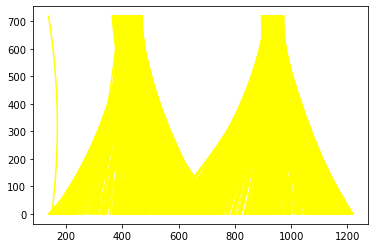

In [44]:
left_video = []
right_video = []
i_video = -1

white_output = 'output_images/project_video_output2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [22]:
right_video = []
print(i_video)
print(right_video)


1260
[]


t:   0%|                                                                             | 0/485 [00:00<?, ?it/s, now=None]

347.11802581958915 m 6134.65066436281 m
Moviepy - Building video output_images/challenge_output.mp4.
Moviepy - Writing video output_images/challenge_output.mp4

47501
47501
278.90369428305655 m 1981.449129923786 m


t:   1%|▌                                                                    | 4/485 [00:00<00:47, 10.18it/s, now=None]

46431
46431
396.1805068415344 m 4475.260173847173 m
49977
49977
299.5941629138894 m 8021.613020446033 m


t:   1%|▋                                                                    | 5/485 [00:00<00:51,  9.24it/s, now=None]

47757
47757
250.80869887396585 m 8419.811610643961 m
48795
48795
234.28453832836158 m 5531.556157530991 m


t:   1%|▉                                                                    | 7/485 [00:00<00:58,  8.14it/s, now=None]

50127
50127
213.29458458552347 m 3475.9474635864526 m
53204
53204
194.99394572673987 m 3868.9420026130942 m


t:   2%|█▎                                                                   | 9/485 [00:01<00:59,  8.02it/s, now=None]

52650
52650
183.7157562339571 m 2823.0859524622565 m
51337
51337
171.73290463637426 m 7766.235529520244 m


t:   2%|█▋                                                                  | 12/485 [00:01<00:58,  8.06it/s, now=None]

52246
52246
159.93363752671254 m 5621.357569991309 m
41485
41485
359.1215977170066 m 7221.415706065842 m


t:   3%|█▉                                                                  | 14/485 [00:01<00:55,  8.51it/s, now=None]

39545
39545
546.9127176523809 m 2932.637486657864 m
37436
37436
308.172268540784 m 9024.372155403182 m


t:   3%|██▏                                                                 | 16/485 [00:01<00:52,  8.88it/s, now=None]

38220
38220
585.8982724808957 m 18763.88877336651 m
37187
37187
601.5274692335745 m 206070.84397916438 m


t:   4%|██▌                                                                 | 18/485 [00:02<00:52,  8.95it/s, now=None]

38114
38114
7335.022167440556 m 11443.057465722131 m
36097
36097
738.0446637553033 m 2188.5275144658126 m


t:   4%|██▊                                                                 | 20/485 [00:02<00:52,  8.88it/s, now=None]

36234
36234
713.4974033077266 m 1673.0529383430758 m
34526
34526
14022.559436719304 m 925.3326036126289 m
36680

t:   5%|███                                                                 | 22/485 [00:02<00:51,  9.07it/s, now=None]


36680
312.9406633337328 m 1283.3257361825947 m
37856
37856
264.9837152363915 m 1070.0071099474287 m
39051

t:   5%|███▎                                                                | 24/485 [00:02<00:49,  9.27it/s, now=None]


39051
261.74530547210753 m 964.4212259744907 m
39555
39555
383.7281617442532 m 2198.3818512919975 m


t:   5%|███▋                                                                | 26/485 [00:02<00:50,  9.04it/s, now=None]

38613
38613
504.79765502355593 m 1601.9007249414312 m
44145
44145
199.76374845400912 m 1502.0343317681836 m


t:   6%|███▉                                                                | 28/485 [00:03<00:52,  8.69it/s, now=None]

51646
51646
100.61348535701156 m 4224.210084662004 m
41916
41916
575.0805683922739 m 1742.1000129256695 m


t:   6%|████▏                                                               | 30/485 [00:03<00:54,  8.35it/s, now=None]

50163
50163
136.44845207757396 m 1982.1609758583957 m
51074
51074
67.84914641632116 m 575.0784568464517 m


t:   7%|████▍                                                               | 32/485 [00:03<00:52,  8.62it/s, now=None]

45739
45739
851.2318273052822 m 5262.459382088092 m
48075
48075
126.48888537418381 m 1150.7197006181013 m


t:   7%|████▊                                                               | 34/485 [00:03<00:54,  8.34it/s, now=None]

48819
48819
79.48881516445118 m 504.9810342753473 m
44740
44740
212.72895848136702 m 1442.8018839246342 m


t:   7%|█████                                                               | 36/485 [00:04<00:54,  8.20it/s, now=None]

45158
45158
186.95105370404306 m 1382.1086421028015 m
47396
47396
86.95849315084034 m 5579.036654343318 m


t:   8%|█████▏                                                              | 37/485 [00:04<00:55,  8.07it/s, now=None]

54227
54227
88.98634518258116 m 593.7296893239559 m
51705
51705
87.29522573478094 m 370.54914429156474 m


t:   8%|█████▍                                                              | 39/485 [00:04<00:55,  8.01it/s, now=None]

54439
54439
88.73248012098051 m 320.26432218532074 m
54962
54962
90.73587269323318 m 300.7419202484318 m


t:   9%|█████▉                                                              | 42/485 [00:04<00:56,  7.82it/s, now=None]

55698
55698
91.16406528333938 m 282.5935892059008 m
50517
50517
88.4278300062492 m 287.4675912258902 m


t:   9%|██████                                                              | 43/485 [00:05<00:57,  7.74it/s, now=None]

50039
50039
90.07209056901254 m 265.3233440881472 m
47118
47118
95.47554331036082 m 269.3126356670441 m


t:   9%|██████▍                                                             | 46/485 [00:05<00:52,  8.36it/s, now=None]

45804
45804
2079.5027149104662 m 332.6599712445702 m
46504
46504
1699.4016833583764 m 779.9571807497146 m


t:  10%|██████▋                                                             | 48/485 [00:05<00:48,  9.01it/s, now=None]

41381
41381
533.4713264023542 m 407.22330062978466 m
37976
37976
56.60259962845411 m 707.6087998069642 m
40081

t:  10%|███████                                                             | 50/485 [00:05<00:48,  8.97it/s, now=None]


40081
59.990883757864886 m 262.5900294786826 m
41958
41958
56.84626878046688 m 256.95157170167056 m


t:  11%|███████▎                                                            | 52/485 [00:06<00:47,  9.07it/s, now=None]

38941
38941
56.09164597084129 m 216.9646445227554 m
42835
42835
62.72277797116301 m 381.97404383897214 m


t:  11%|███████▌                                                            | 54/485 [00:06<00:48,  8.91it/s, now=None]

41066
41066
65.84500508028827 m 207.4485113931593 m
41312
41312
76.4211512439103 m 209.08365840120072 m


t:  12%|███████▊                                                            | 56/485 [00:06<00:47,  9.10it/s, now=None]

38054
38054
79.77487722409548 m 248.02889827059613 m
38886
38886
72.5548091121505 m 297.3794638026199 m


t:  12%|████████▏                                                           | 58/485 [00:06<00:48,  8.79it/s, now=None]

37373
37373
64.4993906087576 m 186.9457273189137 m
33332
33332
58.04450316746362 m 202.87784171652314 m


t:  12%|████████▍                                                           | 60/485 [00:06<00:48,  8.69it/s, now=None]

38368
38368
57.52092024480888 m 173.20436553891048 m
33781
33781
53.66259856304383 m 135.46754452340866 m


t:  13%|████████▋                                                           | 62/485 [00:07<00:48,  8.68it/s, now=None]

33553
33553
55.11765172471385 m 149.95586099568666 m
32050
32050
58.39265687035737 m 445.06345371307896 m


t:  13%|████████▉                                                           | 64/485 [00:07<00:47,  8.91it/s, now=None]

32043
32043
66.0888567719965 m 360.2043285127974 m
32117
32117
68.65752437380252 m 136.15321520096495 m


t:  14%|█████████▎                                                          | 66/485 [00:07<00:47,  8.77it/s, now=None]

34090
34090
76.30091611081586 m 533.4269756005854 m
32793
32793
63.86853867865752 m 997.8785309670193 m


t:  14%|█████████▌                                                          | 68/485 [00:07<00:46,  8.88it/s, now=None]

31891
31891
111.48035669561672 m 576.6546374072201 m
30743
30743
85.62166784292911 m 34026.84298709319 m
31511

t:  14%|█████████▊                                                          | 70/485 [00:08<00:46,  8.93it/s, now=None]


31511
56.73252424747574 m 114.07124324021252 m
29483
29483
258.02322043390814 m 1293.7831017342082 m


t:  15%|██████████                                                          | 72/485 [00:08<00:45,  9.06it/s, now=None]

32663
32663
58.496307105560646 m 2735.339594565884 m
29341
29341
59.75846927606635 m 17548.782943323196 m


t:  15%|██████████▍                                                         | 74/485 [00:08<00:45,  9.05it/s, now=None]

27026
27026
61.11897561402985 m 10473.80906034282 m
26797
26797
70.98056433823675 m 27889.84916937633 m


t:  16%|██████████▋                                                         | 76/485 [00:08<00:48,  8.49it/s, now=None]

24981
24981
69.22787576088804 m 775.0445956129641 m
24417
24417
100.61763976070937 m 744.1994817261948 m


t:  16%|██████████▉                                                         | 78/485 [00:09<00:49,  8.17it/s, now=None]

24068
24068
61.447089238230035 m 321.52879205778163 m
23003
23003
176.5607360242181 m 774.106419189793 m


t:  16%|███████████▏                                                        | 80/485 [00:09<00:46,  8.68it/s, now=None]

22014
22014
191.38645897941163 m 864.6473975700221 m
23464
23464
181.53795477811025 m 1353.6328065856687 m


t:  17%|███████████▍                                                        | 82/485 [00:09<00:45,  8.89it/s, now=None]

24190
24190
185.02790315709436 m 431.2612672793849 m
25515
25515
55.447188115853244 m 333.82525609323824 m


t:  17%|███████████▊                                                        | 84/485 [00:09<00:45,  8.83it/s, now=None]

22470
22470
60.44386218823697 m 2955.4392259846927 m
22023
22023
62.62868493811297 m 332.14700077425454 m


t:  18%|████████████                                                        | 86/485 [00:09<00:44,  8.93it/s, now=None]

20849
20849
100.17675634114927 m 209.83167821987 m
20472
20472
59.34286418759234 m 2554.8874021238134 m


t:  18%|████████████▎                                                       | 88/485 [00:10<00:44,  8.97it/s, now=None]

20403
20403
68.83554168103863 m 701.5172401289783 m
22899
22899
60.591661792259295 m 497.77166432698823 m


t:  19%|████████████▌                                                       | 90/485 [00:10<00:44,  8.91it/s, now=None]

29644
29644
55.617857577710616 m 318.79066118182584 m
35254
35254
46.98979437243553 m 3996.3014774685766 m


t:  19%|████████████▉                                                       | 92/485 [00:10<00:43,  8.93it/s, now=None]

29006
29006
50.653834335211414 m 242.61336700508906 m
31509
31509
46.741946945371254 m 238.11496931897508 m


t:  19%|█████████████▏                                                      | 94/485 [00:10<00:44,  8.78it/s, now=None]

29557
29557
46.72009380590399 m 232.99615828565058 m
26131
26131
53.38740333921254 m 223.00751133545467 m


t:  20%|█████████████▍                                                      | 96/485 [00:11<00:43,  9.04it/s, now=None]

27025
27025
115.22943606083932 m 228.49283633822483 m
30466
30466
57.108071856973666 m 318.05888126447735 m


t:  20%|█████████████▋                                                      | 98/485 [00:11<00:43,  8.93it/s, now=None]

30696
30696
56.443378685622214 m 285.19871894574914 m
36936
36936
69.13737919154167 m 144.4210532143223 m


t:  21%|█████████████▊                                                     | 100/485 [00:11<00:43,  8.81it/s, now=None]

35063
35063
103.36028480678728 m 132.26011401879876 m
37152
37152
90.63060265526178 m 123.70823682569821 m


t:  21%|██████████████                                                     | 102/485 [00:11<00:44,  8.62it/s, now=None]

35431
35431
91.19138293161527 m 127.17858842028834 m
35541
35541
92.43051241850311 m 1181.1642917191734 m


t:  21%|██████████████▎                                                    | 104/485 [00:12<00:43,  8.68it/s, now=None]

31078
31078
80.47202642112518 m 192.3613150330073 m
31440
31440
78.43720682539518 m 102.71941851249818 m


t:  22%|██████████████▋                                                    | 106/485 [00:12<00:42,  8.85it/s, now=None]

25504
25504
74.29867718216525 m 191.56309657061624 m
22803
22803
81.61014866104661 m 559.2262825189623 m


t:  22%|██████████████▉                                                    | 108/485 [00:12<00:41,  9.00it/s, now=None]

16051
16051
79.16597640975952 m 366.95122307073126 m
15238
15238
65.61746949375986 m 786.5686224962575 m


t:  23%|███████████████▏                                                   | 110/485 [00:12<00:42,  8.79it/s, now=None]

16165
16165
67.45694754453604 m 83.31484299416846 m
17571
17571
51.65078501261246 m 68.77848630472205 m


t:  23%|███████████████▍                                                   | 112/485 [00:12<00:42,  8.83it/s, now=None]

18031
18031
47.557401767931886 m 70.69787586205773 m
19039
19039
48.932137257283784 m 74.31669635002494 m


t:  24%|███████████████▋                                                   | 114/485 [00:13<00:43,  8.57it/s, now=None]

17649
17649
49.94727616987197 m 87.12801629629533 m
18197
18197
43.5379195393001 m 241.593113617113 m


t:  24%|████████████████                                                   | 116/485 [00:13<00:41,  8.86it/s, now=None]

18111
18111
45.75007948278473 m 53.97255302162505 m
18467
18467
30.9785290771938 m 457.2366584380473 m


t:  24%|████████████████▎                                                  | 118/485 [00:13<00:41,  8.77it/s, now=None]

17375
17375
39.95937695824174 m 325.9731115202576 m
17413
17413
38.69594546908696 m 312.43918525789104 m


t:  25%|████████████████▌                                                  | 120/485 [00:13<00:41,  8.79it/s, now=None]

18098
18098
402.3351911603919 m 270.5659196746515 m
18856
18856
413.2717105073477 m 254.02040172442665 m


t:  25%|████████████████▊                                                  | 122/485 [00:14<00:40,  8.87it/s, now=None]

18259
18259
394.1569230903665 m 404.9603686503936 m
18411
18411
32.688217862722965 m 377.983743606463 m


t:  26%|█████████████████▏                                                 | 124/485 [00:14<00:41,  8.67it/s, now=None]

18790
18790
70.77778135459222 m 436.3666681205564 m
18787
18787
318.62807217782677 m 4545.934073826417 m


t:  26%|█████████████████▍                                                 | 126/485 [00:14<00:43,  8.30it/s, now=None]

18287
18287
303.6889618443883 m 1395.738023056261 m
18990
18990
297.45828733058374 m 1782.450019789967 m


t:  26%|█████████████████▋                                                 | 128/485 [00:14<00:41,  8.58it/s, now=None]

18459
18459
291.72751938968264 m 1573.3683838651327 m
18662
18662
282.12294441626136 m 268.6914213918657 m


t:  27%|█████████████████▉                                                 | 130/485 [00:14<00:41,  8.49it/s, now=None]

19039
19039
280.71500533192886 m 144.61422121630642 m
18175
18175
238.58901265805386 m 194.03962730928532 m


t:  27%|██████████████████▏                                                | 132/485 [00:15<00:39,  8.89it/s, now=None]

18425
18425
228.3151497593545 m 142.48134947572177 m
19161
19161
213.28685828583056 m 99.85427274532331 m


t:  28%|██████████████████▌                                                | 134/485 [00:15<00:39,  8.91it/s, now=None]

20695
20695
242.3677276068662 m 103.58888640806877 m
24595
24595
465.9882085282083 m 88.64303509303184 m


t:  28%|██████████████████▊                                                | 136/485 [00:15<00:38,  9.01it/s, now=None]

23858
23858
573.5377780711489 m 91.23657258329733 m
25377
25377
646.9740171990437 m 171.9594662846654 m


t:  28%|███████████████████                                                | 138/485 [00:15<00:41,  8.36it/s, now=None]

28081
28081
441.3320969379543 m 220.56898046197946 m
25856
25856
605.879947575792 m 228.7518439799235 m


t:  29%|███████████████████▏                                               | 139/485 [00:16<00:43,  8.02it/s, now=None]

28398
28398
613.5316278807434 m 241.3433101502986 m
29948
29948
543.8176794855549 m 55.00406623240557 m


t:  29%|███████████████████▌                                               | 142/485 [00:16<00:43,  7.86it/s, now=None]

32566
32566
476.69322007038033 m 89.69088022875185 m
34374
34374
394.80253594018774 m 589.9455674037413 m


t:  30%|███████████████████▉                                               | 144/485 [00:16<00:42,  7.96it/s, now=None]

36187
36187
378.1055906822989 m 182.20306262386032 m
37435
37435
342.54923285464025 m 179.99403803364052 m


t:  30%|████████████████████▏                                              | 146/485 [00:16<00:41,  8.22it/s, now=None]

39246
39246
398.7246936846748 m 121.26092861632091 m
40871
40871
392.29927190453276 m 138.5890623515037 m


t:  31%|████████████████████▍                                              | 148/485 [00:17<00:39,  8.54it/s, now=None]

37234
37234
510.41083686509 m 161.80741538994832 m
38083
38083
497.62463515384223 m 507.0193703033856 m


t:  31%|████████████████████▋                                              | 150/485 [00:17<00:47,  6.98it/s, now=None]

37794
37794
411.46316357265465 m 247.91225715376328 m
37808
37808
386.541461195326 m 4805.062662751913 m


t:  31%|████████████████████▉                                              | 152/485 [00:17<00:42,  7.86it/s, now=None]

34974
34974
337.4293449209534 m 235.17297461416587 m
40019
40019
263.8026431939875 m 264.13489071959424 m


t:  32%|█████████████████████▎                                             | 154/485 [00:17<00:40,  8.14it/s, now=None]

39260
39260
271.0515055019581 m 296.3731354564083 m
42133
42133
257.52862470499826 m 199.30300868857165 m


t:  32%|█████████████████████▍                                             | 155/485 [00:18<00:42,  7.78it/s, now=None]

41486
41486
277.2224286141733 m 1040.8697460487372 m
37990
37990
273.65234364958076 m 3009.263950832768 m


t:  33%|█████████████████████▊                                             | 158/485 [00:18<00:40,  8.10it/s, now=None]

37115
37115
251.3257667165798 m 246.70927347926587 m
35091
35091
256.8346987853435 m 708.4319734703496 m


t:  33%|██████████████████████                                             | 160/485 [00:18<00:39,  8.29it/s, now=None]

39775
39775
237.74449514364028 m 3650.303795036871 m
38431
38431
219.9708285792578 m 1083.6745615675475 m


t:  33%|██████████████████████▍                                            | 162/485 [00:18<00:38,  8.29it/s, now=None]

42622
42622
258.4047365678273 m 249.54652815381135 m
43312
43312
252.91417328215422 m 249.4365055003501 m


t:  34%|██████████████████████▌                                            | 163/485 [00:19<00:40,  7.97it/s, now=None]

47421
47421
284.0439926641778 m 352.54024164391575 m
49977
49977
317.513386439795 m 266.38006216862203 m


t:  34%|██████████████████████▉                                            | 166/485 [00:19<00:38,  8.27it/s, now=None]

43426
43426
213.00807293302933 m 270.80853021587376 m
43884
43884
205.34096233202882 m 243.31179347065282 m


t:  34%|███████████████████████                                            | 167/485 [00:19<00:38,  8.20it/s, now=None]

44009
44009
213.51950298223323 m 170.97490197470134 m
41322
41322
210.53236235301588 m 183.24934712849435 m


t:  35%|███████████████████████▍                                           | 170/485 [00:19<00:40,  7.84it/s, now=None]

42052
42052
206.28856945406469 m 169.22619831205282 m
42908
42908
199.70567302670034 m 185.35461319233642 m


t:  35%|███████████████████████▊                                           | 172/485 [00:20<00:41,  7.60it/s, now=None]

50890
50890
207.99539520379983 m 87.49839996815517 m
50389
50389
226.5932811348539 m 73.05107918431415 m


t:  36%|████████████████████████                                           | 174/485 [00:20<00:39,  7.97it/s, now=None]

46470
46470
190.10760996769105 m 394.9915558246559 m
48385
48385
191.58722725156395 m 129.23783594792775 m


t:  36%|████████████████████████▎                                          | 176/485 [00:20<00:37,  8.35it/s, now=None]

46757
46757
194.3663061706477 m 391.5305739280533 m
44549
44549
184.08415932690625 m 893.6799912773439 m


t:  37%|████████████████████████▌                                          | 178/485 [00:20<00:36,  8.42it/s, now=None]

40650
40650
185.6067055847143 m 371.9343547388591 m
40801
40801
194.50352198271497 m 181.0840252785062 m


t:  37%|████████████████████████▋                                          | 179/485 [00:21<00:37,  8.23it/s, now=None]

44448
44448
180.88384060761916 m 690.6489939152711 m
43791
43791
176.61243254836734 m 734.4969758738877 m


t:  38%|█████████████████████████▏                                         | 182/485 [00:21<00:36,  8.29it/s, now=None]

42163
42163
177.15859243979702 m 914.8751863116536 m
45460
45460
183.30053642587606 m 276.4273681938288 m


t:  38%|█████████████████████████▍                                         | 184/485 [00:21<00:37,  8.12it/s, now=None]

45180
45180
170.04297787578778 m 289.86489806128805 m
50954
50954
174.2411755513194 m 251.90883217636164 m


t:  38%|█████████████████████████▋                                         | 186/485 [00:21<00:37,  7.87it/s, now=None]

43708
43708
168.69902478181947 m 1768.2825868765951 m
41772
41772
164.21730917838397 m 1887.4034123228616 m


t:  39%|█████████████████████████▉                                         | 188/485 [00:22<00:37,  8.01it/s, now=None]

38221
38221
160.78701197645483 m 670.8056246045854 m
39223
39223
164.94201996445372 m 270.1233617111088 m


t:  39%|██████████████████████████▏                                        | 190/485 [00:22<00:36,  8.06it/s, now=None]

39923
39923
164.11955970788586 m 222.40061714170753 m
43850
43850
151.2224730488494 m 211.6183917193285 m


t:  40%|██████████████████████████▌                                        | 192/485 [00:22<00:36,  8.07it/s, now=None]

41747
41747
138.40990852454138 m 181.96825914258557 m
39962
39962
129.64381675219093 m 155.6827977509568 m


t:  40%|██████████████████████████▊                                        | 194/485 [00:22<00:35,  8.30it/s, now=None]

41910
41910
139.0556597898345 m 233.56274936129827 m
39365
39365
130.87587863454462 m 313.07180900178656 m


t:  40%|███████████████████████████                                        | 196/485 [00:23<00:33,  8.56it/s, now=None]

42301
42301
139.07610402101088 m 613.1123928060763 m
40193
40193
210.68032460938844 m 1855.161251817963 m


t:  41%|███████████████████████████▎                                       | 198/485 [00:23<00:32,  8.74it/s, now=None]

39709
39709
179.05821239378554 m 902.0667288124115 m
43817
43817
192.66176467417736 m 375.5582977944744 m


t:  41%|███████████████████████████▋                                       | 200/485 [00:23<00:33,  8.51it/s, now=None]

47363
47363
178.37308536535167 m 708.5980229289336 m
40329
40329
140.63185353038517 m 22205.68287759798 m


t:  42%|███████████████████████████▉                                       | 202/485 [00:23<00:33,  8.44it/s, now=None]

35878
35878
138.47161078907826 m 5051.043931017514 m
35470
35470
146.65050691649213 m 6948.942404063577 m


t:  42%|████████████████████████████▏                                      | 204/485 [00:24<00:32,  8.69it/s, now=None]

35012
35012
143.3396994289818 m 355.07741542626525 m
33588
33588
140.33378123268105 m 255.5484227733342 m


t:  42%|████████████████████████████▍                                      | 206/485 [00:24<00:31,  8.79it/s, now=None]

41300
41300
258.68463562163726 m 426.73882990803077 m
43322
43322
282.1621487204576 m 472.8294451166697 m


t:  43%|████████████████████████████▋                                      | 208/485 [00:24<00:31,  8.67it/s, now=None]

39432
39432
325.724175104737 m 332.76379484436717 m
46297
46297
396.9863457864032 m 861.9352149367819 m


t:  43%|█████████████████████████████                                      | 210/485 [00:24<00:34,  8.07it/s, now=None]

41292
41292
177.04942628579545 m 1232.7254956080624 m
35191
35191
134.49063308613916 m 670.0372428696306 m


t:  44%|█████████████████████████████▎                                     | 212/485 [00:25<00:32,  8.36it/s, now=None]

31205
31205
135.28439985924635 m 5631.635348671916 m
38564
38564
429.60530126735443 m 3453.6712904850447 m


t:  44%|█████████████████████████████▌                                     | 214/485 [00:25<00:33,  8.12it/s, now=None]

49882
49882
200.82991333981803 m 6584.3664583540285 m
45350
45350
253.69366620218483 m 1034.4558695477401 m


t:  45%|█████████████████████████████▊                                     | 216/485 [00:25<00:33,  8.10it/s, now=None]

44123
44123
311.67203707454007 m 924.6625475912388 m
50097
50097
522.4091299820584 m 655.9517244739579 m


t:  45%|██████████████████████████████                                     | 218/485 [00:25<00:31,  8.43it/s, now=None]

43451
43451
1136.1551577292937 m 7676.886450163369 m
43977
43977
1755.1560382234625 m 616.8045818462858 m


t:  45%|██████████████████████████████▍                                    | 220/485 [00:26<00:32,  8.27it/s, now=None]

41145
41145
2328.517037027103 m 311.48100284289626 m
40799
40799
836.9517759616604 m 489.74057683540843 m


t:  46%|██████████████████████████████▋                                    | 222/485 [00:26<00:31,  8.35it/s, now=None]

41405
41405
436.62736647861936 m 1585.7394010806927 m
35241
35241
292.68377624003307 m 858.3651982874653 m


t:  46%|██████████████████████████████▉                                    | 224/485 [00:26<00:32,  8.02it/s, now=None]

34114
34114
259.56705484558745 m 711.7667014003422 m
33601
33601
246.45290656187606 m 589.5771179978905 m


t:  47%|███████████████████████████████▏                                   | 226/485 [00:26<00:32,  7.94it/s, now=None]

31966
31966
292.6158418903976 m 1404.1318816522223 m
38700
38700
10110.46926959483 m 1125.4234350446425 m


t:  47%|███████████████████████████████▍                                   | 228/485 [00:27<00:32,  7.95it/s, now=None]

44796
44796
311.2084976923426 m 1240.8259920834819 m
42377
42377
241.18732770262778 m 620.4024769595759 m


t:  47%|███████████████████████████████▊                                   | 230/485 [00:27<00:34,  7.36it/s, now=None]

47001
47001
202.13202560829487 m 536.7258439739528 m
56870
56870
178.03711110253255 m 763.8898380808707 m


t:  48%|███████████████████████████████▉                                   | 231/485 [00:27<00:34,  7.40it/s, now=None]

52880
52880
156.60140665900352 m 952.0790915315731 m
47260
47260
142.68278743916363 m 710.3190176315964 m


t:  48%|████████████████████████████████▎                                  | 234/485 [00:27<00:31,  7.97it/s, now=None]

42195
42195
7984.514701836639 m 601.6850667214815 m
46321
46321
341.9862976498095 m 255.81798320430016 m


t:  49%|████████████████████████████████▌                                  | 236/485 [00:28<00:31,  7.87it/s, now=None]

45634
45634
1268.7845713177728 m 1158.8698438858023 m
53387
53387
3223.6810301186397 m 18619.43677854086 m


t:  49%|████████████████████████████████▋                                  | 237/485 [00:28<00:30,  8.17it/s, now=None]

41841
41841
148.9389575126873 m 1244.0972992694897 m
52913
52913
229.60967938075672 m 2944.1685721041563 m


t:  49%|█████████████████████████████████▏                                 | 240/485 [00:28<00:32,  7.60it/s, now=None]

45208
45208
207.65350710285674 m 433.0814861788011 m
59342
59342
194.89127498056345 m 762.0826403669369 m


t:  50%|█████████████████████████████████▎                                 | 241/485 [00:28<00:33,  7.35it/s, now=None]

57321
57321
187.90762564042208 m 2207.030088698755 m
57865
57865
180.96395364183633 m 4873.743270478225 m


t:  50%|█████████████████████████████████▌                                 | 243/485 [00:29<00:33,  7.21it/s, now=None]

53613
53613
183.2552008289244 m 2641.354462213748 m
57169
57169
183.8345690773862 m 859.3499772474134 m


t:  51%|█████████████████████████████████▉                                 | 246/485 [00:29<00:31,  7.52it/s, now=None]

48257
48257
187.20227163022528 m 624.3805937652324 m
39713
39713
627.7515284931368 m 1087.175963476758 m


t:  51%|██████████████████████████████████                                 | 247/485 [00:29<00:31,  7.63it/s, now=None]

43757
43757
305.91034083954105 m 581.8650408221154 m
50334
50334
282.03405003647805 m 2601.4808557018155 m


t:  51%|██████████████████████████████████▍                                | 249/485 [00:29<00:31,  7.56it/s, now=None]

44188
44188
346.63298640532383 m 2506.1633428992864 m
53156
53156
339.66485543380554 m 2217.090448479341 m


t:  52%|██████████████████████████████████▋                                | 251/485 [00:30<00:31,  7.33it/s, now=None]

40845
40845
467.607855494498 m 617.7100013044142 m
58932
58932
496.305129390604 m 2955.34169213407 m


t:  52%|██████████████████████████████████▉                                | 253/485 [00:30<00:32,  7.03it/s, now=None]

51966
51966
528.3752792675808 m 1874.9762265117245 m
50951
50951
475.9205376869655 m 830.833051529531 m


t:  53%|███████████████████████████████████▏                               | 255/485 [00:30<00:32,  7.13it/s, now=None]

50346
50346
458.08353230598175 m 783.2910389098313 m
40129
40129
168.2520053636549 m 223.62805268139388 m


t:  53%|███████████████████████████████████▋                               | 258/485 [00:31<00:30,  7.55it/s, now=None]

36895
36895
125.87834464315222 m 149.21335991643025 m
37533
37533
128.0584836909589 m 137.4026704595785 m


t:  54%|███████████████████████████████████▉                               | 260/485 [00:31<00:28,  7.79it/s, now=None]

37857
37857
220.01619216173688 m 214.60633593949447 m
36400
36400
173.44976523392475 m 207.79551120841595 m


t:  54%|████████████████████████████████████▏                              | 262/485 [00:31<00:26,  8.33it/s, now=None]

35800
35800
363.38772666158616 m 194.52612051860888 m
45219
45219
445.51766631950113 m 243.35237390834183 m


t:  54%|████████████████████████████████████▎                              | 263/485 [00:31<00:27,  8.06it/s, now=None]

50618
50618
403.2822545875252 m 297.7857443323065 m
61418
61418
364.42883951126436 m 271.8666200459993 m


t:  55%|████████████████████████████████████▌                              | 265/485 [00:31<00:30,  7.14it/s, now=None]

60553
60553
302.82271937740825 m 197.12453669569098 m
59444
59444
254.35281396169586

t:  55%|████████████████████████████████████▉                              | 267/485 [00:32<00:31,  6.94it/s, now=None]

 m 173.11986643834967 m
56233
56233
230.75446797648888 m 104.45044374355646 m


t:  55%|█████████████████████████████████████                              | 268/485 [00:32<00:31,  6.92it/s, now=None]

69508
69508
203.20285744767568 m 86.19826356924204 m
64513
64513
185.73046813958902

t:  56%|█████████████████████████████████████▎                             | 270/485 [00:32<00:30,  7.05it/s, now=None]

 m 83.12487366851138 m
54582
54582
180.10745410881486 m 81.61643350641857 m


t:  56%|█████████████████████████████████████▍                             | 271/485 [00:32<00:30,  6.92it/s, now=None]

56669
56669
175.53861773380584 m 94.6623256865678 m
62599
62599
165.42295390089856

t:  56%|█████████████████████████████████████▋                             | 273/485 [00:33<00:31,  6.65it/s, now=None]

 m 206.9589216276256 m
70908
70908
153.7387889903898 m 185.58720128854623 m


t:  56%|█████████████████████████████████████▊                             | 274/485 [00:33<00:32,  6.43it/s, now=None]

71473
71473
147.77125554580135 m 237.218653670295 m
72467
72467


t:  57%|█████████████████████████████████████▉                             | 275/485 [00:33<00:33,  6.32it/s, now=None]

141.3406857897485 m 248.80914717392398 m
81248
81248
132.0659914474849 m 255.21135894847808 m


t:  57%|██████████████████████████████████████▎                            | 277/485 [00:33<00:33,  6.24it/s, now=None]

80853
80853
127.21750391133988 m 262.24553824003493 m
79418
79418


t:  57%|██████████████████████████████████████▍                            | 278/485 [00:33<00:32,  6.29it/s, now=None]

119.74823043980184 m 256.9025906064303 m
93777
93777
113.30041039793079 m 271.6030342117184 m


t:  58%|██████████████████████████████████████▋                            | 280/485 [00:34<00:35,  5.85it/s, now=None]

98222
98222
110.4657115939496 m 279.2310662896325 m
96016
96016


t:  58%|██████████████████████████████████████▊                            | 281/485 [00:34<00:34,  5.98it/s, now=None]

107.73820899617263 m 276.40009272185614 m
92196
92196
105.43367465091995 m 248.63870858878633 m


t:  58%|███████████████████████████████████████                            | 283/485 [00:34<00:33,  5.97it/s, now=None]

83226
83226
106.4524286173583 m 224.10286256420622 m
85872
85872


t:  59%|███████████████████████████████████████▏                           | 284/485 [00:35<00:34,  5.89it/s, now=None]

109.44960192014248 m 217.81619092857466 m
83487
83487
112.2003096851242 m 190.2112859547158 m


t:  59%|███████████████████████████████████████▌                           | 286/485 [00:35<00:33,  5.95it/s, now=None]

70877
70877
116.94518702004858 m 176.61821284707196 m
64951
64951
123.6294057679096 m 174.83017189824622 m


t:  59%|███████████████████████████████████████▊                           | 288/485 [00:35<00:31,  6.27it/s, now=None]

56756
56756
124.3687809940164 m 199.38062828248428 m
55712
55712


t:  60%|███████████████████████████████████████▉                           | 289/485 [00:35<00:30,  6.40it/s, now=None]

121.63035138346847 m 247.7253023389946 m
58743
58743
119.99316035681997 m 319.3548922522845 m


t:  60%|████████████████████████████████████████▏                          | 291/485 [00:36<00:30,  6.42it/s, now=None]

66077
66077
116.86211757253024 m 433.22981265689845 m
59528
59528


t:  60%|████████████████████████████████████████▍                          | 293/485 [00:36<00:28,  6.76it/s, now=None]

115.02608529228505 m 447.7613508612069 m
66433
66433
112.89530980302756 m 558.6890749558778 m


t:  61%|████████████████████████████████████████▌                          | 294/485 [00:36<00:28,  6.64it/s, now=None]

67773
67773
109.84581428439351 m 614.9930085748164 m
69574
69574
108.89621943611824

t:  61%|████████████████████████████████████████▊                          | 295/485 [00:36<00:28,  6.66it/s, now=None]

 m 553.7785759821655 m
63897
63897
108.48422614986642 m 531.8992011029577 m


t:  61%|█████████████████████████████████████████                          | 297/485 [00:36<00:27,  6.89it/s, now=None]

56018
56018
107.7156671058422 m 494.9458687710122 m
52490
52490
115.1364451362616 m 551.8214511176243 m


t:  62%|█████████████████████████████████████████▎                         | 299/485 [00:37<00:26,  7.10it/s, now=None]

52352
52352
117.3714618172676 m 560.0762885548468 m
50221
50221
135.40355540398144 m 596.6854756593544 m


t:  62%|█████████████████████████████████████████▋                         | 302/485 [00:37<00:23,  7.67it/s, now=None]

48250
48250
206.19129667361884 m 738.4525397362117 m
45398
45398
504.9362943322943 m 355.3136666869718 m


t:  63%|█████████████████████████████████████████▉                         | 304/485 [00:37<00:23,  7.59it/s, now=None]

49050
49050
916.1355042888807 m 359.25692540292476 m
43797
43797
430.96597878401457 m 433.54917107025034 m


t:  63%|██████████████████████████████████████████▎                        | 306/485 [00:38<00:22,  7.96it/s, now=None]

40901
40901
559.0763256892997 m 565.6842837351514 m
46335
46335
591.4915170394528 m 673.1048483815744 m


t:  63%|██████████████████████████████████████████▍                        | 307/485 [00:38<00:24,  7.41it/s, now=None]

54748
54748
1260.3962526729497 m 806.8782003165265 m
52797
52797
1410.0622836723444 m 1223.459797733086 m


t:  64%|██████████████████████████████████████████▋                        | 309/485 [00:38<00:24,  7.24it/s, now=None]

56908
56908
1261.7296184457414 m 1384.5617986688549 m
59157
59157
1295.365185635969 m 1275.25133684375 m


t:  64%|███████████████████████████████████████████                        | 312/485 [00:38<00:23,  7.28it/s, now=None]

53089
53089
1335.8707882683982 m 686.8968674506307 m
53101
53101
1724.8243655565377 m 471.63768589229426 m


t:  65%|███████████████████████████████████████████▍                       | 314/485 [00:39<00:22,  7.65it/s, now=None]

46909
46909
673.6756868156253 m 420.59752510645785 m
51154
51154
1372.5580639514512 m 272.8145564207758 m


t:  65%|███████████████████████████████████████████▋                       | 316/485 [00:39<00:22,  7.49it/s, now=None]

54181
54181
1631.7733014898865 m 259.2160356276567 m
53953
53953
2361.4561691089034 m 265.94004724548887 m


t:  65%|███████████████████████████████████████████▊                       | 317/485 [00:39<00:23,  7.24it/s, now=None]

64690
64690
3470.3333093471765 m 308.4603341732495 m
67646
67646


t:  66%|███████████████████████████████████████████▉                       | 318/485 [00:39<00:24,  6.92it/s, now=None]

3535.1572399299325 m 364.697768537743 m
70830
70830
5337.253802058948 m 449.23888764450436 m


t:  66%|████████████████████████████████████████████▏                      | 320/485 [00:40<00:24,  6.76it/s, now=None]

72803
72803
3369.968030653811 m 426.6719737971821 m
60021
60021
3033.788104427497 m 377.54360390786985 m


t:  66%|████████████████████████████████████████████▍                      | 322/485 [00:40<00:24,  6.70it/s, now=None]

61290
61290
3065.7306481804208 m 377.516025840282 m
59118
59118
3794.6987178629615

t:  67%|████████████████████████████████████████████▌                      | 323/485 [00:40<00:24,  6.62it/s, now=None]

 m 437.1543073370108 m
62236
62236
6549.805937596088 m 422.97935470362694 m


t:  67%|████████████████████████████████████████████▉                      | 325/485 [00:40<00:24,  6.52it/s, now=None]

64937
64937
11032.814986032763 m 452.0196371664825 m
84271
84271


t:  67%|█████████████████████████████████████████████                      | 326/485 [00:41<00:25,  6.26it/s, now=None]

4730.033452918021 m 468.4305179100468 m
88313
88313
14300.158220026871 m 457.3129349149845 m


t:  68%|█████████████████████████████████████████████▎                     | 328/485 [00:41<00:24,  6.36it/s, now=None]

85646
85646
4844.208815206183 m 391.4295407991656 m
74324
74324
6211.799874047387 m 390.1152168841375 m


t:  68%|█████████████████████████████████████████████▌                     | 330/485 [00:41<00:25,  6.11it/s, now=None]

79695
79695
11170.789211496633 m 432.591658323907 m
91543
91543


t:  68%|█████████████████████████████████████████████▋                     | 331/485 [00:41<00:26,  5.76it/s, now=None]

10816.303189362814 m 459.8217614475705 m
99378
99378
5852.675712311085 m 454.459384399537 m


t:  69%|██████████████████████████████████████████████                     | 333/485 [00:42<00:26,  5.81it/s, now=None]

105823
105823
4084.317502521947 m 443.69039658537054 m
101086

t:  69%|██████████████████████████████████████████████▏                    | 334/485 [00:42<00:26,  5.75it/s, now=None]


101086
3660.9390479188814 m 376.08664604569753 m
93239
93239
3481.5321911351166 m 402.55001485069516 m


t:  69%|██████████████████████████████████████████████▍                    | 336/485 [00:42<00:25,  5.77it/s, now=None]

93974
93974
12479.56576645806 m 416.0337655288103 m
94108
94108


t:  69%|██████████████████████████████████████████████▌                    | 337/485 [00:42<00:25,  5.84it/s, now=None]

5404.63920998684 m 433.576731629355 m
91578
91578
5644.199856819508 m 434.0016320267008 m


t:  70%|██████████████████████████████████████████████▊                    | 339/485 [00:43<00:24,  6.02it/s, now=None]

87479
87479
7825.416639149502 m 444.2375992246881 m
77638
77638


t:  70%|██████████████████████████████████████████████▉                    | 340/485 [00:43<00:23,  6.23it/s, now=None]

4068.7551952444865 m 364.0120243946218 m
87235
87235
9671.015787836692 m 312.81602343524804 m


t:  71%|███████████████████████████████████████████████▏                   | 342/485 [00:43<00:22,  6.46it/s, now=None]

75742
75742
3773.246804117394 m 324.59930933618676 m
81451
81451
8932.75324221847

t:  71%|███████████████████████████████████████████████▍                   | 343/485 [00:43<00:22,  6.41it/s, now=None]

 m 327.1591172052187 m
92831
92831
7566.03550823921 m 292.9094424928721 m


t:  71%|███████████████████████████████████████████████▋                   | 345/485 [00:44<00:22,  6.28it/s, now=None]

79869
79869
7561.319066899977 m 291.53255969563486 m
56490
56490


t:  71%|███████████████████████████████████████████████▊                   | 346/485 [00:44<00:22,  6.24it/s, now=None]

2240.7424650677017 m 271.81728679923873 m
67454
67454
13271.370349616209 m 277.58638528397245 m


t:  72%|████████████████████████████████████████████████                   | 348/485 [00:44<00:22,  6.22it/s, now=None]

73132
73132
35731.72493357944 m 358.88619438987723 m
91525
91525


t:  72%|████████████████████████████████████████████████▏                  | 349/485 [00:44<00:22,  6.09it/s, now=None]

5970.887263420677 m 420.0281144031024 m
74229
74229
21337.832076843148 m 387.41703386330005 m


t:  73%|████████████████████████████████████████████████▋                  | 352/485 [00:45<00:20,  6.41it/s, now=None]

84690
84690
10307.366755545901 m 410.6297369016535 m
78452
78452
17541.810230403767 m 344.549905607088 m


t:  73%|████████████████████████████████████████████████▊                  | 353/485 [00:45<00:21,  6.28it/s, now=None]

88206
88206
57181.11167674871 m 384.1536840705944 m
84058
84058


t:  73%|████████████████████████████████████████████████▉                  | 354/485 [00:45<00:20,  6.27it/s, now=None]

40760.117101622294 m 343.0688039204779 m
84626
84626
13520.819605908493 m 363.53418086957225 m


t:  73%|█████████████████████████████████████████████████▏                 | 356/485 [00:45<00:20,  6.16it/s, now=None]

76774
76774
23494.282550165102 m 313.05884545854286 m
81157

t:  74%|█████████████████████████████████████████████████▎                 | 357/485 [00:46<00:21,  5.83it/s, now=None]


81157
8126.654030658818 m 355.21609772461613 m
79064
79064
34735.715672245016

t:  74%|█████████████████████████████████████████████████▌                 | 359/485 [00:46<00:21,  5.91it/s, now=None]

 m 344.82006848512884 m
79520
79520
11780.480411490475 m 377.8548741173558 m


t:  74%|█████████████████████████████████████████████████▋                 | 360/485 [00:46<00:20,  5.96it/s, now=None]

81076
81076
8289.437888217803 m 361.40280341928303 m
90009

t:  74%|█████████████████████████████████████████████████▊                 | 361/485 [00:46<00:21,  5.82it/s, now=None]


90009
4463.376975053464 m 346.1447378647151 m
88074
88074
17334.84721008879 m 368.6659785267041 m


t:  75%|██████████████████████████████████████████████████▏                | 363/485 [00:47<00:20,  5.97it/s, now=None]

97271
97271
5929.078373147757 m 366.5931492899582 m
80710
80710
55426.30299170334 m 370.8993808478703 m


t:  75%|██████████████████████████████████████████████████▍                | 365/485 [00:47<00:19,  6.10it/s, now=None]

92964
92964
20751.80161146751 m 394.70699920125577 m
99634
99634


t:  75%|██████████████████████████████████████████████████▌                | 366/485 [00:47<00:20,  5.89it/s, now=None]

23116.550107690626 m 360.20674780232537 m
109899
109899
5203.104204038902 m 316.00286618925725 m


t:  76%|██████████████████████████████████████████████████▊                | 368/485 [00:48<00:20,  5.82it/s, now=None]

112316
112316
7675.909217301484 m 317.97249116014854 m
107369

t:  76%|██████████████████████████████████████████████████▉                | 369/485 [00:48<00:20,  5.78it/s, now=None]


107369
8159.2985449486505 m 464.6748951053055 m
106471
106471
13916.531395156091 m 335.63556732315357 m


t:  76%|███████████████████████████████████████████████████▎               | 371/485 [00:48<00:19,  5.94it/s, now=None]

86807
86807
3076.1707510538763 m 332.4999092334138 m
76066
76066
2823.7060760259133

t:  77%|███████████████████████████████████████████████████▌               | 373/485 [00:48<00:17,  6.29it/s, now=None]

 m 305.76640288744846 m
67417
67417
3437.152751067248 m 260.58489606904607 m


t:  77%|███████████████████████████████████████████████████▋               | 374/485 [00:48<00:17,  6.46it/s, now=None]

64717
64717
4271.360845909595 m 232.9309798879839 m
67162
67162
5552.9435604629725

t:  78%|███████████████████████████████████████████████████▉               | 376/485 [00:49<00:16,  6.70it/s, now=None]

 m 232.25615808089344 m
60956
60956
4335.598512878364 m 223.4677676579944 m


t:  78%|████████████████████████████████████████████████████▏              | 378/485 [00:49<00:15,  7.06it/s, now=None]

55812
55812
4007.644870219024 m 231.63252391746207 m
54607
54607
3872.0547231960018 m 239.32992574741382 m


t:  78%|████████████████████████████████████████████████████▎              | 379/485 [00:49<00:15,  7.03it/s, now=None]

67123
67123
4281.920441721335 m 243.98134880735557 m
61588
61588
3928.095720601063

t:  79%|████████████████████████████████████████████████████▋              | 381/485 [00:49<00:15,  6.86it/s, now=None]

 m 234.98963764771383 m
64325
64325
4172.881486180085 m 242.77512143470358 m


t:  79%|████████████████████████████████████████████████████▊              | 382/485 [00:50<00:16,  6.36it/s, now=None]

62987
62987
3564.4063393016813 m 213.18608481009161 m
50351

t:  79%|████████████████████████████████████████████████████▉              | 383/485 [00:50<00:16,  6.15it/s, now=None]


50351
2721.673706474933 m 193.47601853739073 m
53972
53972
4096.946329283992 m 185.9336091936949 m


t:  79%|█████████████████████████████████████████████████████▏             | 385/485 [00:50<00:16,  6.13it/s, now=None]

47533
47533
2448.2547722761237 m 175.89837150915028 m
61386
61386
5312.530913210375

t:  80%|█████████████████████████████████████████████████████▍             | 387/485 [00:50<00:15,  6.25it/s, now=None]

 m 207.8347464085526 m
69958
69958
4014.310123980286 m 241.13179433121073 m


t:  80%|█████████████████████████████████████████████████████▌             | 388/485 [00:51<00:16,  6.00it/s, now=None]

66880
66880
2818.197872683377 m 270.02449515839504 m
62986

t:  80%|█████████████████████████████████████████████████████▋             | 389/485 [00:51<00:16,  5.81it/s, now=None]


62986
2202.1471614441566 m 280.67547353373544 m
52885
52885
2061.1358529557547 m 277.81843420883575 m


t:  81%|██████████████████████████████████████████████████████             | 391/485 [00:51<00:14,  6.27it/s, now=None]

51458
51458
1883.106178171257 m 255.40968106600596 m
50034
50034
2305.5769202167326 m 240.8861314917402 m


t:  81%|██████████████████████████████████████████████████████▎            | 393/485 [00:51<00:13,  6.73it/s, now=None]

55741
55741
2937.8762527941176 m 249.97879370655826 m
56265
56265
2580.597277038011

t:  81%|██████████████████████████████████████████████████████▌            | 395/485 [00:52<00:13,  6.69it/s, now=None]

 m 259.58720338221497 m
47816
47816
2127.737590279997 m 261.42678503967994 m


t:  82%|██████████████████████████████████████████████████████▊            | 397/485 [00:52<00:13,  6.71it/s, now=None]

53430
53430
2340.0947853138646 m 265.4187547572117 m
47481
47481
2172.529676917118 m 294.64216682923626 m


t:  82%|██████████████████████████████████████████████████████▉            | 398/485 [00:52<00:12,  6.80it/s, now=None]

52937
52937
3197.491219163174 m 337.2354755139035 m
61279
61279
3610.151515006232 m 552.4359438612942 m


t:  82%|███████████████████████████████████████████████████████▎           | 400/485 [00:52<00:12,  6.91it/s, now=None]

74225
74225
10158.190766124992 m 935.5805985837851 m
77586
77586
6863.658691970834

t:  83%|███████████████████████████████████████████████████████▍           | 401/485 [00:53<00:12,  6.79it/s, now=None]

 m 1765.0715405403853 m
67743
67743
3421.6132898946203 m 192.3763051786028 m


t:  83%|███████████████████████████████████████████████████████▋           | 403/485 [00:53<00:13,  6.07it/s, now=None]

54100
54100
2114.9901507549753 m 156.204147327605 m
55423
55423
3999.178126893304

t:  83%|███████████████████████████████████████████████████████▊           | 404/485 [00:53<00:12,  6.42it/s, now=None]

 m 130.11866687092504 m
60242
60242
4224.369969322699 m 116.85431904515191 m


t:  84%|████████████████████████████████████████████████████████           | 406/485 [00:53<00:13,  5.88it/s, now=None]

86606
86606
173490.32021753548 m 108.36519835502118 m
84495
84495


t:  84%|████████████████████████████████████████████████████████▏          | 407/485 [00:54<00:13,  5.85it/s, now=None]

108866.8836970409 m 105.36076660453678 m
100548
100548


t:  84%|████████████████████████████████████████████████████████▎          | 408/485 [00:54<00:14,  5.43it/s, now=None]

2948.9729856588497 m 109.61848529929865 m
102449
102449
1270.2396397425568 m 133.67407205118457 m


t:  85%|████████████████████████████████████████████████████████▋          | 410/485 [00:54<00:14,  5.35it/s, now=None]

94492
94492
62964.7799476508 m 178.85659009670545 m
92941

t:  85%|████████████████████████████████████████████████████████▊          | 411/485 [00:54<00:13,  5.41it/s, now=None]


92941
15648.483045645295 m 241.58633650863726 m
76010
76010
2482.9166123036334 m 252.3738186047058 m


t:  85%|█████████████████████████████████████████████████████████          | 413/485 [00:55<00:12,  5.59it/s, now=None]

71781
71781
5203.049328493693 m 309.5481313589553 m
75056
75056


t:  85%|█████████████████████████████████████████████████████████▏         | 414/485 [00:55<00:12,  5.75it/s, now=None]

9474.171989711453 m 341.4457219174085 m
82106
82106
20104.591929731963

t:  86%|█████████████████████████████████████████████████████████▎         | 415/485 [00:55<00:12,  5.53it/s, now=None]

 m 367.507571580654 m
90211
90211
7184.372274379314 m 403.9033537220307 m


t:  86%|█████████████████████████████████████████████████████████▌         | 417/485 [00:55<00:12,  5.49it/s, now=None]

89638
89638
6742.1563515340795 m 1301.841870727476 m
87269

t:  86%|█████████████████████████████████████████████████████████▋         | 418/485 [00:56<00:12,  5.53it/s, now=None]


87269
127848.22454617605 m 57948.67222368001 m
93732
93732
8582.040500370018 m 8691.019253711673 m


t:  87%|██████████████████████████████████████████████████████████         | 420/485 [00:56<00:11,  5.77it/s, now=None]

93993
93993
5661.8722779148775 m 5687.999577501766 m
90489
90489


t:  87%|██████████████████████████████████████████████████████████▏        | 421/485 [00:56<00:10,  5.96it/s, now=None]

5244.4556185912 m 5264.042850694034 m
81479
81479
10150.087985870194 m 10182.866569655094 m


t:  87%|██████████████████████████████████████████████████████████▍        | 423/485 [00:56<00:10,  5.71it/s, now=None]

64182
64182
3498.2035176612685 m 3491.5982131913647 m
57436

t:  87%|██████████████████████████████████████████████████████████▌        | 424/485 [00:57<00:10,  5.80it/s, now=None]


57436
2398.0429349274796 m 2397.2676996555615 m
57643
57643
5213.810078756821 m 5213.810078756821 m


t:  88%|██████████████████████████████████████████████████████████▊        | 426/485 [00:57<00:09,  5.99it/s, now=None]

60631
60631
212817.05281361047 m 212817.05281361047 m
71286
71286


t:  88%|██████████████████████████████████████████████████████████▉        | 427/485 [00:57<00:09,  5.83it/s, now=None]

222469.65411560115 m 222469.65411560115 m
81228
81228
4199.96674603657 m 4199.96674603657 m


t:  88%|███████████████████████████████████████████████████████████▎       | 429/485 [00:58<00:10,  5.58it/s, now=None]

97314
97314
3733.5238981257944 m 3733.5238981257944 m
85741

t:  89%|███████████████████████████████████████████████████████████▍       | 430/485 [00:58<00:10,  5.38it/s, now=None]


85741
3375.794220299031 m 3375.794220299031 m
63200
63200
19843.320630591723 m 19843.320630591723 m


t:  89%|███████████████████████████████████████████████████████████▋       | 432/485 [00:58<00:08,  5.94it/s, now=None]

59077
59077
4082.1502247460435 m 4082.1502247460435 m
52790
52790
4792.093333334196

t:  89%|███████████████████████████████████████████████████████████▉       | 434/485 [00:58<00:08,  6.34it/s, now=None]

 m 4792.093333334196 m
44690
44690
739.0655700876357 m 1851.8058620594074 m


t:  90%|████████████████████████████████████████████████████████████▏      | 436/485 [00:59<00:06,  7.02it/s, now=None]

38983
38983
928.5158649236298 m 2449.203687699127 m
33919
33919
426.258772020607 m 31589.01380209084 m


t:  90%|████████████████████████████████████████████████████████████▎      | 437/485 [00:59<00:06,  7.31it/s, now=None]

41028
41028
457.5333815593879 m 703.309372827794 m
49116
49116
2591.4284349977142 m 5242.648404241261 m


t:  91%|████████████████████████████████████████████████████████████▋      | 439/485 [00:59<00:06,  7.21it/s, now=None]

50909
50909
22634.201759234445 m 1896.4873627941492 m
39757
39757
625.7786235318987 m 707.7977226721304 m


t:  91%|████████████████████████████████████████████████████████████▉      | 441/485 [00:59<00:06,  7.02it/s, now=None]

49178
49178
6863.120280665515 m 6227.6607072800425 m
39285
39285
1323.6680401083343

t:  91%|█████████████████████████████████████████████████████████████▏     | 443/485 [01:00<00:05,  7.35it/s, now=None]

 m 1209.4792566058911 m
41294
41294
1072.3054190033793 m 566.2675158513925 m


t:  92%|█████████████████████████████████████████████████████████████▎     | 444/485 [01:00<00:05,  7.29it/s, now=None]

39705
39705
741.8395313854277 m 1485.7203859537615 m
40963
40963
1126.6169206536963 m 486.47167653596637 m


t:  92%|█████████████████████████████████████████████████████████████▊     | 447/485 [01:00<00:05,  7.53it/s, now=None]

43027
43027
515.2875443362999 m 962.7170385959006 m
48060
48060
3812.4838609903336 m 31517.845115283493 m


t:  92%|█████████████████████████████████████████████████████████████▉     | 448/485 [01:00<00:04,  7.42it/s, now=None]

55442
55442
23107.86009982509 m 26680.2482404172 m
57947
57947
36749.95793805384 m 3293.2584440753444 

t:  93%|██████████████████████████████████████████████████████████████▏    | 450/485 [01:01<00:04,  7.17it/s, now=None]

m
55061
55061
14268.196245987032 m 7101.669380008649 m


t:  93%|██████████████████████████████████████████████████████████████▍    | 452/485 [01:01<00:04,  7.61it/s, now=None]

50233
50233
10805.602024590873 m 1666.1940321522356 m
46842
46842
10145.196804204315 m 316.60704955228493 m


t:  94%|██████████████████████████████████████████████████████████████▋    | 454/485 [01:01<00:03,  8.06it/s, now=None]

39618
39618
6864.412945694729 m 496.2519469409078 m
40707
40707
636900.2391959865 m 885.8476696787914 m


t:  94%|██████████████████████████████████████████████████████████████▉    | 456/485 [01:01<00:03,  8.27it/s, now=None]

38202
38202
6865.754549377877 m 1128.2891484073498 m
34045
34045
8741.328661327501 m 2147.3013939662414 m


t:  94%|███████████████████████████████████████████████████████████████▎   | 458/485 [01:01<00:03,  8.37it/s, now=None]

34949
34949
11191.423030183787 m 1027.3484502326662 m
37224
37224
5699.313706310484 m 1143.4800693271275 m


t:  95%|███████████████████████████████████████████████████████████████▌   | 460/485 [01:02<00:02,  8.34it/s, now=None]

39314
39314
11072.617477641214 m 576.8552193917268 m
45300
45300
45196.17959433508 m 623.2098760666368 m


t:  95%|███████████████████████████████████████████████████████████████▊   | 462/485 [01:02<00:02,  8.38it/s, now=None]

43114
43114
65254.30251470057 m 543.9462672048685 m
41177
41177
10792.648881787505 m 603.786931410431 m


t:  96%|████████████████████████████████████████████████████████████████   | 464/485 [01:02<00:02,  8.36it/s, now=None]

44075
44075
257508.86066373155 m 733.765337247362 m
40611
40611
14412.61804961453 m 542.4260509003535 m


t:  96%|████████████████████████████████████████████████████████████████▍  | 466/485 [01:02<00:02,  8.28it/s, now=None]

39168
39168
18226.855563139896 m 627.7289896971224 m
37015
37015
32310.828376819878 m 635.673314589628 m


t:  96%|████████████████████████████████████████████████████████████████▋  | 468/485 [01:03<00:02,  8.35it/s, now=None]

34661
34661
13028.734694587713 m 852.5537220664434 m
37064
37064
35753.64816670042 m 547.1960831656622 m


t:  97%|████████████████████████████████████████████████████████████████▉  | 470/485 [01:03<00:01,  8.40it/s, now=None]

39566
39566
2861.1939641350073 m 406.36681290001917 m
38334
38334
3432.313244629935 m 440.1669382438904 m


t:  97%|█████████████████████████████████████████████████████████████████▏ | 472/485 [01:03<00:01,  7.82it/s, now=None]

38617
38617
2797.385687160414 m 460.15047815071694 m
41988
41988
1967.923834388633 m 415.2500077545839 m


t:  98%|█████████████████████████████████████████████████████████████████▍ | 474/485 [01:03<00:01,  7.89it/s, now=None]

44768
44768
2369.6097960823868 m 311.0228208859438 m
42416
42416
3880.1136949928305 m 409.68261124791405 m


t:  98%|█████████████████████████████████████████████████████████████████▊ | 476/485 [01:04<00:01,  8.20it/s, now=None]

35803
35803
3503.2366204300047 m 571.329505712435 m
43053
43053
6543.4552802733615 m 571.315246781783 m


t:  99%|██████████████████████████████████████████████████████████████████ | 478/485 [01:04<00:00,  8.35it/s, now=None]

39176
39176
1801.278233642884 m 617.119612385142 m
42316
42316
2604.826300278252 m 321.9783105808172 m


t:  99%|██████████████████████████████████████████████████████████████████▎| 480/485 [01:04<00:00,  8.54it/s, now=None]

46820
46820
2969.9086381879774 m 316.4080773591179 m
46419
46419
5935.852846949752 m 252.84684756124614 m


t:  99%|██████████████████████████████████████████████████████████████████▍| 481/485 [01:04<00:00,  8.07it/s, now=None]

53536
53536
2215.2452711057235 m 327.7137115373289 m
49715
49715
2957.2234604037835 m 319.4203294214613 m


t: 100%|██████████████████████████████████████████████████████████████████▋| 483/485 [01:05<00:00,  7.57it/s, now=None]

52173
52173
2166.280599913656 m 293.02431361600685 m
47742
47742
2983.6929957292755

t: 100%|██████████████████████████████████████████████████████████████████▊| 484/485 [01:05<00:00,  7.14it/s, now=None]

 m 280.6272419038067 m
46594
46594
8755.777439298123 m 253.14324637483114 m


t: 100%|███████████████████████████████████████████████████████████████████| 485/485 [01:05<00:00,  6.91it/s, now=None]WARNING:py.warnings:C:\Users\IML\anaconda3\lib\site-packages\moviepy\video\io\ffmpeg_reader.py:123: UserWarning: Warning: in file ./challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



46594
46594
8755.777439298123 m 253.14324637483114 m
Moviepy - Done !
Moviepy - video ready output_images/challenge_output.mp4
Wall time: 1min 5s


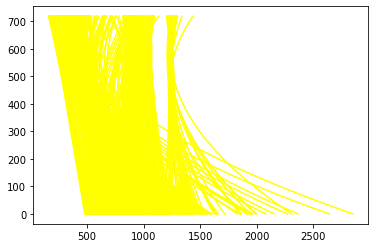

In [47]:
left_video = []
right_video = []
i_video = -1

challenge_output = 'output_images/challenge_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("./challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [25]:
print(i_video)
print(right_video)

485
[array([-2.67711917e-05,  2.34202143e-03,  9.13277742e+02]), array([ 2.16503339e-04, -1.89312670e-01,  9.40085782e+02]), array([ 2.22901897e-04, -1.97812346e-01,  9.41919664e+02]), array([ 3.49959708e-04, -3.07769619e-01,  9.60781007e+02]), array([ 4.61911497e-04, -4.07586219e-01,  9.82678160e+02]), array([ 5.12710708e-04, -4.59324135e-01,  9.94568352e+02]), array([ 6.04347521e-04, -5.33472134e-01,  1.00755778e+03]), array([ 6.56300848e-04, -5.99227291e-01,  1.02669668e+03]), array([ 7.66821450e-04, -6.81389673e-01,  1.03700776e+03]), array([ 6.78836896e-04, -6.07067732e-01,  1.02433010e+03]), array([ 7.39433842e-04, -6.49230604e-01,  1.02852043e+03]), array([ 6.81916873e-04, -5.80014076e-01,  1.01203329e+03]), array([ 7.58326437e-04, -6.30204947e-01,  1.01846860e+03]), array([ 7.80945337e-04, -6.29767173e-01,  1.01088857e+03]), array([ 9.08070765e-04, -7.13896485e-01,  1.01798472e+03]), array([ 8.47052977e-04, -6.66060607e-01,  1.01128537e+03]), array([ 8.31482069e-04, -6.52162935

t:   0%|                                                                            | 0/1199 [00:00<?, ?it/s, now=None]

12524.298916268843 m 1240.4308252165945 m
Moviepy - Building video output_images/harder_challenge_output.mp4.
Moviepy - Writing video output_images/harder_challenge_output.mp4

186581
186581


t:   0%|                                                                    | 2/1199 [00:00<02:11,  9.07it/s, now=None]

1304.1236585429533 m 1308.427444725812 m
186182
186182
954.5748113363701

t:   0%|▏                                                                   | 3/1199 [00:00<02:50,  6.99it/s, now=None]

 m 1404.06335211948 m
189488
189488


t:   0%|▏                                                                   | 4/1199 [00:00<03:20,  5.96it/s, now=None]

1109.561574147639 m 1606.9824794077751 m
186392
186392


t:   0%|▎                                                                   | 5/1199 [00:00<03:44,  5.31it/s, now=None]

898.3749462627571 m 1925.2664397975477 m
191750
191750


t:   1%|▎                                                                   | 6/1199 [00:01<03:57,  5.03it/s, now=None]

971.2126758854972 m 2367.6493045513366 m
189943
189943


t:   1%|▍                                                                   | 7/1199 [00:01<04:10,  4.77it/s, now=None]

993.6613669514613 m 3137.947867561026 m
182592
182592


t:   1%|▍                                                                   | 8/1199 [00:01<04:30,  4.40it/s, now=None]

902.8753688650174 m 3305.0437195311997 m
186874
186874


t:   1%|▌                                                                   | 9/1199 [00:01<04:42,  4.21it/s, now=None]

845.0662108051322 m 5975.767029376796 m
184328
184328
674.3390229060506 m 5671.995639308819 m


t:   1%|▌                                                                  | 11/1199 [00:02<04:31,  4.38it/s, now=None]

179041
179041
611.7659607888801 m 2051.1525473947668 m
175283
175283


t:   1%|▋                                                                  | 12/1199 [00:02<04:37,  4.27it/s, now=None]

571.2428313271374 m 1569.1108970960554 m
180059
180059


t:   1%|▋                                                                  | 13/1199 [00:02<04:46,  4.14it/s, now=None]

571.584483054358 m 1191.5148969504464 m
177085
177085


t:   1%|▊                                                                  | 14/1199 [00:03<04:40,  4.22it/s, now=None]

601.6558451991516 m 1051.4846212598154 m
172399
172399


t:   1%|▊                                                                  | 15/1199 [00:03<04:38,  4.25it/s, now=None]

691.8617699992278 m 944.9725578471632 m
175980
175980


t:   1%|▉                                                                  | 16/1199 [00:03<04:30,  4.37it/s, now=None]

685.0084909928254 m 850.3412847112165 m
168771
168771


t:   1%|▉                                                                  | 17/1199 [00:03<04:25,  4.46it/s, now=None]

699.8318861904608 m 630.5536225558116 m
168235
168235


t:   2%|█                                                                  | 18/1199 [00:03<04:20,  4.54it/s, now=None]

747.8313148534935 m 530.1766706267586 m
163532
163532


t:   2%|█                                                                  | 19/1199 [00:04<04:14,  4.63it/s, now=None]

709.7782537633885 m 485.66312096810555 m
169129
169129
656.8989711495261

t:   2%|█                                                                  | 20/1199 [00:04<04:11,  4.68it/s, now=None]

 m 496.97345089573037 m
166365
166365


t:   2%|█▏                                                                 | 21/1199 [00:04<04:11,  4.69it/s, now=None]

693.734356532428 m 469.42228354062945 m
165039
165039


t:   2%|█▏                                                                 | 22/1199 [00:04<04:10,  4.70it/s, now=None]

600.3809242604492 m 418.18327173303334 m
160412
160412


t:   2%|█▎                                                                 | 23/1199 [00:04<04:13,  4.65it/s, now=None]

619.750356157937 m 394.06942301179316 m
176130
176130


t:   2%|█▎                                                                 | 24/1199 [00:05<04:14,  4.62it/s, now=None]

652.9860427256634 m 371.26824603512915 m
160928
160928


t:   2%|█▍                                                                 | 25/1199 [00:05<04:18,  4.54it/s, now=None]

904.4545211884499 m 359.1277015136826 m
174925
174925


t:   2%|█▍                                                                 | 26/1199 [00:05<04:18,  4.54it/s, now=None]

1075.3585590215332 m 333.68688937640286 m
172634
172634


t:   2%|█▌                                                                 | 27/1199 [00:05<04:29,  4.35it/s, now=None]

1505.988757557232 m 311.4480528914672 m
180412
180412


t:   2%|█▌                                                                 | 28/1199 [00:06<04:31,  4.31it/s, now=None]

1947.753734859898 m 285.51824387517934 m
180824
180824


t:   2%|█▌                                                                 | 29/1199 [00:06<04:39,  4.19it/s, now=None]

1756.414833642956 m 243.20972877506009 m
180080
180080


t:   3%|█▋                                                                 | 30/1199 [00:06<04:38,  4.19it/s, now=None]

1715.225985394027 m 212.27366028778954 m
178657
178657
1859.5574676938636

t:   3%|█▋                                                                 | 31/1199 [00:06<04:31,  4.30it/s, now=None]

 m 199.84791955245635 m
194722
194722


t:   3%|█▊                                                                 | 32/1199 [00:07<04:27,  4.36it/s, now=None]

2307.2227165926142 m 180.7302526301262 m
198592
198592


t:   3%|█▊                                                                 | 33/1199 [00:07<04:27,  4.36it/s, now=None]

2008.4105568198518 m 163.55011143811734 m
209571
209571


t:   3%|█▉                                                                 | 34/1199 [00:07<04:31,  4.30it/s, now=None]

2795.5098800138676 m 150.1673669983516 m
206349
206349


t:   3%|█▉                                                                 | 35/1199 [00:07<04:32,  4.27it/s, now=None]

24324.95499830051 m 136.66356954187356 m
198335
198335


t:   3%|██                                                                 | 36/1199 [00:08<04:28,  4.33it/s, now=None]

4511.226279035486 m 130.0819702521911 m
209769
209769


t:   3%|██                                                                 | 37/1199 [00:08<04:27,  4.34it/s, now=None]

3602.845703435795 m 135.86099202295978 m
211561
211561


t:   3%|██                                                                 | 38/1199 [00:08<04:33,  4.25it/s, now=None]

5073.1706310379805 m 159.05199523433913 m
200813
200813


t:   3%|██▏                                                                | 39/1199 [00:08<04:31,  4.27it/s, now=None]

2404.038673528847 m 165.41260429161292 m
207511
207511


t:   3%|██▏                                                                | 40/1199 [00:08<04:35,  4.21it/s, now=None]

2627.476900713191 m 173.97440807575416 m
212815
212815


t:   3%|██▎                                                                | 41/1199 [00:09<04:36,  4.18it/s, now=None]

5996.1183354805125 m 163.31313560133674 m
215308
215308


t:   4%|██▎                                                                | 42/1199 [00:09<04:38,  4.16it/s, now=None]

24733.302138020605 m 157.9304609010559 m
218602
218602


t:   4%|██▍                                                                | 43/1199 [00:09<04:46,  4.04it/s, now=None]

10723.23715196304 m 149.044793089925 m
229527

t:   4%|██▍                                                                | 44/1199 [00:10<05:12,  3.69it/s, now=None]


229527
2359.815058372466 m 141.0148801848847 m
217653
217653


t:   4%|██▌                                                                | 45/1199 [00:10<05:02,  3.82it/s, now=None]

1310.6203423370798 m 138.46574049951363 m
225960
225960


t:   4%|██▌                                                                | 46/1199 [00:10<05:02,  3.81it/s, now=None]

955.8924696001234 m 136.92544604130526 m
224062
224062


t:   4%|██▋                                                                | 47/1199 [00:10<05:01,  3.82it/s, now=None]

800.9062652569107 m 127.78536042319142 m
227046
227046


t:   4%|██▋                                                                | 48/1199 [00:11<05:11,  3.69it/s, now=None]

674.1504980410447 m 112.80138562980115 m
219843
219843


t:   4%|██▋                                                                | 49/1199 [00:11<05:03,  3.79it/s, now=None]

592.7953360398882 m 104.05962049091829 m
221657
221657


t:   4%|██▊                                                                | 50/1199 [00:11<05:11,  3.69it/s, now=None]

514.7140599656556 m 101.34032856796956 m
219804
219804


t:   4%|██▊                                                                | 51/1199 [00:11<05:05,  3.76it/s, now=None]

455.6748097863856 m 111.89463120345903 m
219225
219225


t:   4%|██▉                                                                | 52/1199 [00:12<04:57,  3.86it/s, now=None]

373.49824599965456 m 117.6463319672242 m
220393
220393


t:   4%|██▉                                                                | 53/1199 [00:12<04:51,  3.93it/s, now=None]

312.8907512579771 m 122.76378609492654 m
216782
216782


t:   5%|███                                                                | 54/1199 [00:12<04:56,  3.87it/s, now=None]

296.69191370483384 m 128.49532950942017 m
218900
218900


t:   5%|███                                                                | 55/1199 [00:12<04:52,  3.92it/s, now=None]

280.8288519834171 m 130.191720229757 m
207248
207248


t:   5%|███▏                                                               | 56/1199 [00:13<04:47,  3.98it/s, now=None]

273.1720637571513 m 124.19033060130477 m
216010
216010


t:   5%|███▏                                                               | 57/1199 [00:13<04:46,  3.98it/s, now=None]

275.03982783400465 m 122.17782316361117 m
210291
210291


t:   5%|███▏                                                               | 58/1199 [00:13<04:40,  4.07it/s, now=None]

306.6952971260549 m 122.20301956292352 m
210982
210982


t:   5%|███▎                                                               | 59/1199 [00:13<04:43,  4.02it/s, now=None]

321.85909919150816 m 124.5936342089964 m
196164
196164


t:   5%|███▎                                                               | 60/1199 [00:14<04:36,  4.12it/s, now=None]

331.5416010484573 m 127.56372534347057 m
202658
202658


t:   5%|███▍                                                               | 61/1199 [00:14<04:48,  3.94it/s, now=None]

354.39080188616094 m 126.20194948145446 m
205988
205988


t:   5%|███▍                                                               | 62/1199 [00:14<04:51,  3.90it/s, now=None]

326.49488415920814 m 126.12313490947774 m
207004
207004


t:   5%|███▌                                                               | 63/1199 [00:14<04:44,  3.99it/s, now=None]

312.40573881168467 m 124.97746877959729 m
202676
202676


t:   5%|███▌                                                               | 64/1199 [00:15<04:50,  3.91it/s, now=None]

308.60171729240454 m 122.24917573015084 m
209357
209357


t:   5%|███▋                                                               | 65/1199 [00:15<04:47,  3.94it/s, now=None]

307.62332806272667 m 118.00168488603427 m
210169
210169


t:   6%|███▋                                                               | 66/1199 [00:15<04:43,  4.00it/s, now=None]

294.92415202143434 m 108.07634510512882 m
203284
203284


t:   6%|███▋                                                               | 67/1199 [00:15<04:39,  4.06it/s, now=None]

288.8119172988994 m 107.2068771695122 m
180667
180667
282.0779425700266

t:   6%|███▊                                                               | 68/1199 [00:16<04:29,  4.20it/s, now=None]

 m 104.73037506928294 m
180482
180482


t:   6%|███▊                                                               | 69/1199 [00:16<04:24,  4.27it/s, now=None]

279.3268261489405 m 111.35943503023937 m
188959
188959


t:   6%|███▉                                                               | 70/1199 [00:16<04:26,  4.24it/s, now=None]

261.71135140562757 m 115.02387702879375 m
181823
181823


t:   6%|███▉                                                               | 71/1199 [00:16<04:34,  4.11it/s, now=None]

231.88992305184632 m 120.57679146454535 m
163921
163921


t:   6%|████                                                               | 72/1199 [00:17<04:21,  4.31it/s, now=None]

222.99457641932486 m 122.10182270360511 m
175262
175262


t:   6%|████                                                               | 73/1199 [00:17<04:17,  4.38it/s, now=None]

222.79731268302365 m 124.9667487873019 m
164451
164451


t:   6%|████▏                                                              | 74/1199 [00:17<04:17,  4.37it/s, now=None]

222.71583309923096 m 115.24981657475533 m
168030
168030


t:   6%|████▏                                                              | 75/1199 [00:17<04:12,  4.45it/s, now=None]

217.0348803051134 m 110.84232127381203 m
168239
168239


t:   6%|████▏                                                              | 76/1199 [00:17<04:10,  4.49it/s, now=None]

209.4358961657053 m 109.07937387183115 m
158783
158783
205.87378806827294

t:   6%|████▎                                                              | 77/1199 [00:18<04:02,  4.63it/s, now=None]

 m 105.83844882273041 m
160023
160023
200.5344602757084

t:   7%|████▎                                                              | 78/1199 [00:18<04:03,  4.61it/s, now=None]

 m 105.24789895241419 m
154561
154561
200.43116063714575

t:   7%|████▍                                                              | 79/1199 [00:18<04:02,  4.61it/s, now=None]

 m 104.05773866247036 m
160582
160582


t:   7%|████▍                                                              | 80/1199 [00:18<03:57,  4.72it/s, now=None]

203.18417602960585 m 110.57036241778556 m
153465
153465


t:   7%|████▌                                                              | 81/1199 [00:18<03:58,  4.70it/s, now=None]

207.86817407348903 m 116.02854646535202 m
142560
142560


t:   7%|████▌                                                              | 82/1199 [00:19<03:59,  4.67it/s, now=None]

209.5179924897403 m 111.94365732178996 m
139054
139054
228.48850851231236

t:   7%|████▋                                                              | 83/1199 [00:19<03:54,  4.75it/s, now=None]

 m 110.45973771656838 m
127612
127612


t:   7%|████▋                                                              | 84/1199 [00:19<03:45,  4.95it/s, now=None]

245.68584610262945 m 105.83306197254277 m
127902
127902
279.12411279215604

t:   7%|████▋                                                              | 85/1199 [00:19<03:40,  5.05it/s, now=None]

 m 103.10144730793742 m
123156
123156
336.550349591062 m 105.27806848469696 m


t:   7%|████▊                                                              | 86/1199 [00:19<03:33,  5.20it/s, now=None]

116646
116646
521.1914055779173 m 108.99906709064798 m


t:   7%|████▉                                                              | 88/1199 [00:20<03:24,  5.44it/s, now=None]

119430
119430
663.3369727582221 m 111.10186387923555 m
115214

t:   7%|████▉                                                              | 89/1199 [00:20<03:22,  5.47it/s, now=None]


115214
663.9810408622279 m 116.21191692130128 m
104849
104849


t:   8%|█████                                                              | 90/1199 [00:20<03:27,  5.35it/s, now=None]

792.7470615142767 m 117.57438394828094 m
110604
110604
1115.7460911601572

t:   8%|█████                                                              | 91/1199 [00:20<03:27,  5.34it/s, now=None]

 m 119.66990993128995 m
95947
95947
1348.7538838949392 m 124.90084151060252 m


t:   8%|█████▏                                                             | 93/1199 [00:21<03:14,  5.68it/s, now=None]

88090
88090
1751.4851131605374 m 132.3129720985621 m
90285
90285


t:   8%|█████▎                                                             | 95/1199 [00:21<03:14,  5.69it/s, now=None]

3003.8441567312884 m 135.75744527987118 m
84860
84860
2030.774950082679 m 150.80647121547062 m


t:   8%|█████▎                                                             | 96/1199 [00:21<03:41,  4.98it/s, now=None]

91131
91131
824.0381383669805 m 166.38334723080933 m


t:   8%|█████▍                                                             | 97/1199 [00:21<03:29,  5.26it/s, now=None]

91907
91907
1171.0587298598932 m 171.96071634783993 m
91622
91622


t:   8%|█████▍                                                             | 98/1199 [00:22<03:26,  5.33it/s, now=None]

668.9162886862148 m 207.0869960106784 m
99940
99940
640.4683749706888

t:   8%|█████▌                                                             | 99/1199 [00:22<03:25,  5.36it/s, now=None]

 m 206.8738008358121 m
94354
94354
503.2044198070224 m 231.48593619490546 m


t:   8%|█████▌                                                            | 101/1199 [00:22<03:12,  5.70it/s, now=None]

92512
92512
439.0596934612572 m 269.4092771070743 m
94417
94417


t:   9%|█████▌                                                            | 102/1199 [00:22<03:10,  5.76it/s, now=None]

478.81873163936933 m 327.8688563014617 m
104585
104585
641.8625392616854 m 288.2174157470046 m


t:   9%|█████▋                                                            | 104/1199 [00:23<03:11,  5.73it/s, now=None]

96734
96734
876.5428980735506 m 337.88291651627975 m
107958
107958


t:   9%|█████▊                                                            | 105/1199 [00:23<03:13,  5.65it/s, now=None]

914.8831935775173 m 403.86999685902566 m
108334
108334
781.8100621300573 m 334.94270461008 m


t:   9%|█████▉                                                            | 107/1199 [00:23<03:12,  5.66it/s, now=None]

118114
118114
332.2492452407393 m 344.06053579400776 m
116430
116430
265.26029309975473

t:   9%|█████▉                                                            | 108/1199 [00:23<03:18,  5.49it/s, now=None]

 m 420.5007221343858 m
114985
114985
204.9434035761064 m 532.1747028610357 m


t:   9%|██████                                                            | 110/1199 [00:24<03:19,  5.47it/s, now=None]

118429
118429
268.95392975226594 m 474.4813856063007 m
115014

t:   9%|██████                                                            | 111/1199 [00:24<03:18,  5.48it/s, now=None]


115014
274.20606155953163 m 202.70701610482377 m
118736
118736
283.0722381535042 

t:   9%|██████▏                                                           | 112/1199 [00:24<03:18,  5.49it/s, now=None]

m 135.71435709001008 m
117043
117043
417.3996279238804 m 126.12472206852185 m


t:  10%|██████▎                                                           | 114/1199 [00:24<03:20,  5.40it/s, now=None]

117920
117920
1124.4602457684875 m 145.7963172609665 m
105532

t:  10%|██████▎                                                           | 115/1199 [00:25<03:15,  5.56it/s, now=None]


105532
273.0126144878706 m 148.66280865282235 m
113359
113359
340.40171652961465 m 128.31463997178648 m


t:  10%|██████▍                                                           | 117/1199 [00:25<03:10,  5.68it/s, now=None]

105304
105304
360.1021875225304 m 97.47953916210106 m
101110

t:  10%|██████▍                                                           | 118/1199 [00:25<03:06,  5.78it/s, now=None]


101110
392.5755416316489 m 80.30734579618499 m
96888
96888
361.08208044529476

t:  10%|██████▌                                                           | 119/1199 [00:25<03:12,  5.60it/s, now=None]

 m 65.49552477362838 m
92329
92329
308.5891808884965 m 55.98551385942459 m


t:  10%|██████▋                                                           | 121/1199 [00:26<03:05,  5.80it/s, now=None]

91719
91719
296.6503641454234 m 55.72877881072314 m
88640
88640


t:  10%|██████▋                                                           | 122/1199 [00:26<03:05,  5.82it/s, now=None]

257.42698075293436 m 52.19954853984107 m
81164
81164
429.4967314899513 m 55.743433503953746 m


t:  10%|██████▊                                                           | 124/1199 [00:26<02:54,  6.17it/s, now=None]

76215
76215
78133.76601130905 m 69.67135748763309 m
80819
80819


t:  10%|██████▉                                                           | 125/1199 [00:26<02:53,  6.17it/s, now=None]

1098.109211011141 m 77.56245305186633 m
82044
82044
452.5126332851578 m 75.8589859039408 m


t:  11%|██████▉                                                           | 127/1199 [00:27<02:52,  6.23it/s, now=None]

80360
80360
686.8982525864726 m 76.07957200570995 m
79350
79350


t:  11%|███████                                                           | 128/1199 [00:27<02:52,  6.21it/s, now=None]

472.28584205393815 m 78.76706335681361 m
81094
81094
264.44512353551363 m 89.75206201425134 m


t:  11%|███████▏                                                          | 130/1199 [00:27<03:03,  5.84it/s, now=None]

84284
84284
203.9401239946209 m 103.05032179879468 m
77752

t:  11%|███████▏                                                          | 131/1199 [00:27<03:06,  5.74it/s, now=None]


77752
157.17142175266864 m 113.90056362979826 m
69600
69600
106.77849325977644 m 144.8935331046085 m


t:  11%|███████▎                                                          | 133/1199 [00:28<02:50,  6.27it/s, now=None]

70184
70184
108.54574697908647 m 149.2001166733522 m
66631
66631


t:  11%|███████▍                                                          | 135/1199 [00:28<02:41,  6.60it/s, now=None]

77.90879734084714 m 675.2836113462232 m
55895
55895
59.59672646730375 m 2669.6037599450665 m


t:  11%|███████▍                                                          | 136/1199 [00:28<02:38,  6.71it/s, now=None]

58873
58873
66.15209294302252 m 307.785206777289 m
46234
46234
141.40587760480975 m 114.7075707791415 m


t:  12%|███████▋                                                          | 139/1199 [00:28<02:20,  7.56it/s, now=None]

44215
44215
134.06250080971574 m 219.4089757618023 m
49311
49311
129.6157337654536 m 134.5930749297919 m


t:  12%|███████▊                                                          | 141/1199 [00:29<02:15,  7.83it/s, now=None]

49721
49721
128.2727634429143 m 114.39584456822367 m
45437
45437
133.9181337940513 m 543.1993682742294 m


t:  12%|███████▊                                                          | 142/1199 [00:29<02:14,  7.87it/s, now=None]

45469
45469
66.6282563250224 m 105.20530809330958 m
50467
50467
64.09249164801355 m 83.50145029597071 m


t:  12%|███████▉                                                          | 144/1199 [00:29<02:26,  7.19it/s, now=None]

48770
48770
66.46981463185577 m 68.23433672175356 m
46714
46714
78.36599946682908 m 447.2728841665696 m


t:  12%|████████                                                          | 147/1199 [00:29<02:09,  8.10it/s, now=None]

44412
44412
91.32470807017897 m 130.5992837383539 m
44314
44314
85.30404805836426 m 218.94600866906276 m


t:  12%|████████▏                                                         | 148/1199 [00:30<02:13,  7.87it/s, now=None]

54040
54040
75.16245123812998 m 111.502250936172 m
54358
54358
74.71025359583093 m 94.32477593772487 m


t:  13%|████████▎                                                         | 150/1199 [00:30<02:24,  7.25it/s, now=None]

52382
52382
75.9087183803655 m 80.88077907285964 m
53548
53548


t:  13%|████████▎                                                         | 152/1199 [00:30<02:28,  7.05it/s, now=None]

71.06781242178471 m 67.07373014641406 m
52888
52888
66.99175378347898 m 56.77544799618144 m


t:  13%|████████▍                                                         | 153/1199 [00:30<02:27,  7.10it/s, now=None]

49005
49005
60.56304661734648 m 52.3590818307055 m
41590
41590
100.0320154384441 m 63.777162578102526 m


t:  13%|████████▌                                                         | 156/1199 [00:31<02:18,  7.52it/s, now=None]

44221
44221
90.96497199832925 m 37.39325699897057 m
48633
48633
79.43981840697849 m 40.293657355995606 m


t:  13%|████████▋                                                         | 157/1199 [00:31<02:18,  7.52it/s, now=None]

45649
45649
35.95877033786024 m 65.34303099113937 m
40664
40664
41.56996104202575 m 41.42988224878179 m


t:  13%|████████▊                                                         | 160/1199 [00:31<02:16,  7.62it/s, now=None]

40628
40628
30.243252359293514 m 30.70473697208737 m
39154
39154
30.548906999770157 m 32.24382481160919 m


t:  14%|████████▉                                                         | 162/1199 [00:31<02:06,  8.21it/s, now=None]

34683
34683
34.273611078338845 m 50.55611562099642 m
25864
25864
33.223000583192515 m 30.37946616390117 m


t:  14%|█████████                                                         | 164/1199 [00:32<02:00,  8.55it/s, now=None]

22916
22916
27.890481586183302 m 23.522653202277265 m
22579
22579
31.33644175931391 m 22.842120534187597 m


t:  14%|█████████▏                                                        | 166/1199 [00:32<02:02,  8.45it/s, now=None]

21483
21483
21.129803669677976 m 21.097136618730225 m
19625
19625
26.247489626930278 m 42.59224606307517 m


t:  14%|█████████▏                                                        | 168/1199 [00:32<02:02,  8.42it/s, now=None]

23933
23933
38.213920712141515 m 61.11663445556512 m
21398
21398
31.742867702088194 m 87.6459234711145 m


t:  14%|█████████▎                                                        | 170/1199 [00:32<02:01,  8.47it/s, now=None]

21196
21196
42.67750152476769 m 88.96585185361441 m
19785
19785
27.191566391247594 m 5988.354596502634 m


t:  14%|█████████▍                                                        | 172/1199 [00:33<01:59,  8.57it/s, now=None]

20058
20058
25.0500803956167 m 25.751794752774384 m
18353
18353
21.138975986258863 m 18.834371614995685 m


t:  15%|█████████▌                                                        | 174/1199 [00:33<01:59,  8.56it/s, now=None]

15394
15394
29.278966765643535 m 17.813959092896912 m
20020
20020
18.988754048333625 m 16.461844297427632 m


t:  15%|█████████▋                                                        | 176/1199 [00:33<01:59,  8.54it/s, now=None]

23053
23053
21.65404260436353 m 16.37150486355836 m
25704
25704
22.77241267530965 m 13.531134899682222 m


t:  15%|█████████▊                                                        | 178/1199 [00:33<02:00,  8.51it/s, now=None]

21411
21411
27.41725976376712 m 11.65395590719592 m
21115
21115
31.31816200879596 m 12.408248907304417 m


t:  15%|█████████▉                                                        | 180/1199 [00:34<02:08,  7.95it/s, now=None]

30316
30316
25.396581097632314 m 13.189406716519633 m
29515
29515
22.3477543253694 m 16.109411324000465 m


t:  15%|██████████                                                        | 182/1199 [00:34<02:13,  7.62it/s, now=None]

38695
38695
26.984849847389253 m 13.821892221400265 m
51142
51142
20.419621822358106 m 14.194219017526954 m


t:  15%|██████████                                                        | 183/1199 [00:34<02:16,  7.42it/s, now=None]

46209
46209
27.506536052291306 m 301.9904542578921 m
48555
48555
16.03253969202182

t:  15%|██████████▏                                                       | 184/1199 [00:34<02:27,  6.90it/s, now=None]

 m 298.9856118836561 m
51227
51227
12.501567615864625 m 283.7347061237544 m


t:  16%|██████████▏                                                       | 186/1199 [00:35<02:31,  6.68it/s, now=None]

59351
59351
11.684458063712722 m 242.0721601368744 m
59440
59440
12.077710313965019

t:  16%|██████████▎                                                       | 187/1199 [00:35<02:37,  6.43it/s, now=None]

 m 315.39889062538225 m
55820
55820
11.19910224520202 m 286.8425153717529 m


t:  16%|██████████▍                                                       | 189/1199 [00:35<02:36,  6.47it/s, now=None]

40869
40869
380.7309970618424 m 105.16929253021125 m
45530
45530
145.8357078154353 m 216.13477689211444 m


t:  16%|██████████▌                                                       | 191/1199 [00:35<02:31,  6.63it/s, now=None]

53033
53033
146.44881558677025 m 179.3559371192861 m
69726
69726


t:  16%|██████████▌                                                       | 192/1199 [00:35<02:42,  6.22it/s, now=None]

143.5335564963761 m 170.75915845141634 m
93825
93825
135.9608393275081 m 162.10353296659406 m


t:  16%|██████████▋                                                       | 194/1199 [00:36<02:54,  5.76it/s, now=None]

103307
103307
127.49844424820415 m 175.06043859976393 m
107202

t:  16%|██████████▋                                                       | 195/1199 [00:36<03:00,  5.56it/s, now=None]


107202
122.37081321452814 m 172.36281505460101 m
93007
93007
114.10854320429398 m 163.43233660957108 m


t:  16%|██████████▊                                                       | 197/1199 [00:36<02:58,  5.62it/s, now=None]

91940
91940
107.26347518254923 m 147.5931700840602 m


t:  17%|██████████▉                                                       | 198/1199 [00:37<03:06,  5.37it/s, now=None]

109833
109833
101.25040620160934 m 150.13076485957018 m
140554

t:  17%|██████████▉                                                       | 199/1199 [00:37<03:15,  5.12it/s, now=None]


140554
108.22691852230224 m 164.0441648136965 m
170825
170825


t:  17%|███████████                                                       | 200/1199 [00:37<03:25,  4.86it/s, now=None]

113.16240868551499 m 169.2815882010095 m
204335
204335


t:  17%|███████████                                                       | 201/1199 [00:37<03:35,  4.63it/s, now=None]

112.84622182992365 m 153.459089864904 m
249252
249252


t:  17%|███████████                                                       | 202/1199 [00:38<03:57,  4.20it/s, now=None]

111.87285645295735 m 148.05070427325975 m
260775
260775


t:  17%|███████████▏                                                      | 203/1199 [00:38<04:07,  4.02it/s, now=None]

106.465677152006 m 149.32045530708598 m
270018
270018


t:  17%|███████████▏                                                      | 204/1199 [00:38<04:18,  3.86it/s, now=None]

100.81497916090342 m 147.325202008989 m
271419
271419


t:  17%|███████████▎                                                      | 205/1199 [00:38<04:21,  3.80it/s, now=None]

105.87839982627858 m 153.55626991577083 m
276425
276425


t:  17%|███████████▎                                                      | 206/1199 [00:39<04:24,  3.75it/s, now=None]

111.28003191840332 m 186.64387051119482 m
266258
266258


t:  17%|███████████▍                                                      | 207/1199 [00:39<04:30,  3.67it/s, now=None]

129.9066885323178 m 238.14245965441756 m
267749
267749


t:  17%|███████████▍                                                      | 208/1199 [00:39<04:33,  3.63it/s, now=None]

152.17634681559977 m 350.50787486883104 m
267228
267228


t:  17%|███████████▌                                                      | 209/1199 [00:39<04:31,  3.64it/s, now=None]

192.41578556828372 m 517.7098669595088 m
265180
265180


t:  18%|███████████▌                                                      | 210/1199 [00:40<04:29,  3.66it/s, now=None]

236.0383199834049 m 890.8977960585895 m
266410
266410


t:  18%|███████████▌                                                      | 211/1199 [00:40<04:37,  3.56it/s, now=None]

257.49286915440814 m 709.1144879280225 m
291180
291180


t:  18%|███████████▋                                                      | 212/1199 [00:40<04:46,  3.44it/s, now=None]

258.8122066620391 m 586.0945113615528 m
284258
284258


t:  18%|███████████▋                                                      | 213/1199 [00:41<04:54,  3.34it/s, now=None]

266.04629876502713 m 582.1831263452116 m
275122
275122


t:  18%|███████████▊                                                      | 214/1199 [00:41<05:02,  3.26it/s, now=None]

272.80885177814355 m 675.8397710951986 m
271777
271777


t:  18%|███████████▊                                                      | 215/1199 [00:41<05:03,  3.24it/s, now=None]

279.78318694225095 m 705.840309039012 m
282227
282227


t:  18%|███████████▉                                                      | 216/1199 [00:42<04:58,  3.29it/s, now=None]

297.31790727805975 m 810.1245191862241 m
289345
289345


t:  18%|███████████▉                                                      | 217/1199 [00:42<04:51,  3.37it/s, now=None]

334.13127977786985 m 1020.1744800172244 m
304287
304287


t:  18%|████████████                                                      | 218/1199 [00:42<04:57,  3.30it/s, now=None]

379.81164580783644 m 1873.1884202519805 m
280117
280117


t:  18%|████████████                                                      | 219/1199 [00:43<04:58,  3.28it/s, now=None]

436.1804644342173 m 27611.771371799165 m
288935
288935


t:  18%|████████████                                                      | 220/1199 [00:43<05:01,  3.24it/s, now=None]

498.7791170053355 m 1985.9182585304193 m
299598
299598


t:  18%|████████████▏                                                     | 221/1199 [00:43<04:58,  3.28it/s, now=None]

578.4335195196949 m 1016.602551324118 m
287092
287092


t:  19%|████████████▏                                                     | 222/1199 [00:43<04:53,  3.33it/s, now=None]

648.5544384069559 m 734.8005650348251 m
274669
274669


t:  19%|████████████▎                                                     | 223/1199 [00:44<04:50,  3.36it/s, now=None]

819.4252662858341 m 596.450905799674 m
277105
277105


t:  19%|████████████▎                                                     | 224/1199 [00:44<04:48,  3.38it/s, now=None]

975.253351439813 m 577.4458550914608 m
281449
281449


t:  19%|████████████▍                                                     | 225/1199 [00:44<04:46,  3.40it/s, now=None]

970.7939305299989 m 700.7426105195843 m
282352
282352


t:  19%|████████████▍                                                     | 226/1199 [00:45<04:48,  3.37it/s, now=None]

1006.9888201448898 m 964.9211900655945 m
280627

t:  19%|████████████▍                                                     | 227/1199 [00:45<04:58,  3.25it/s, now=None]


280627
830.9392985124806 m 1248.381768399014 m
279183
279183


t:  19%|████████████▌                                                     | 228/1199 [00:45<04:53,  3.31it/s, now=None]

923.336493927283 m 946.5697586080918 m
277719
277719


t:  19%|████████████▌                                                     | 229/1199 [00:46<04:51,  3.33it/s, now=None]

785.8234526649144 m 1746.082608780901 m
278872
278872


t:  19%|████████████▋                                                     | 230/1199 [00:46<04:49,  3.35it/s, now=None]

609.253166831088 m 2104.0658329178077 m
285059
285059


t:  19%|████████████▋                                                     | 231/1199 [00:46<04:57,  3.26it/s, now=None]

579.6344991648378 m 1729.5950161853311 m
276550

t:  19%|████████████▊                                                     | 232/1199 [00:46<05:03,  3.18it/s, now=None]


276550
508.76376742385565 m 3444.2551060555797 m
273132
273132


t:  19%|████████████▊                                                     | 233/1199 [00:47<05:00,  3.22it/s, now=None]

505.6371979568776 m 8511.951871285994 m
286388
286388


t:  20%|████████████▉                                                     | 234/1199 [00:47<04:56,  3.26it/s, now=None]

537.9010638266146 m 4444.113736035564 m
310402
310402


t:  20%|████████████▉                                                     | 235/1199 [00:47<04:55,  3.26it/s, now=None]

496.21865790175457 m 2198.5076209355275 m
319608
319608


t:  20%|████████████▉                                                     | 236/1199 [00:48<05:00,  3.20it/s, now=None]

510.20717914822063 m 2027.9122083106222 m
315537
315537


t:  20%|█████████████                                                     | 237/1199 [00:48<05:13,  3.06it/s, now=None]

583.2249248923367 m 1222.8008787694962 m
320112
320112


t:  20%|█████████████                                                     | 238/1199 [00:48<05:24,  2.96it/s, now=None]

751.4620677568047 m 943.0634146858145 m
317098
317098


t:  20%|█████████████▏                                                    | 239/1199 [00:49<05:19,  3.00it/s, now=None]

845.3524040819425 m 1108.9887064093139 m
327736
327736


t:  20%|█████████████▏                                                    | 240/1199 [00:49<05:13,  3.06it/s, now=None]

968.6892262301834 m 978.8246295506605 m
338431
338431


t:  20%|█████████████▎                                                    | 241/1199 [00:49<05:11,  3.07it/s, now=None]

1028.4239764883569 m 1073.3921436166709 m
385629
385629


t:  20%|█████████████▎                                                    | 242/1199 [00:50<05:21,  2.98it/s, now=None]

1402.860222382443 m 1195.5443007700471 m
376596
376596


t:  20%|█████████████▍                                                    | 243/1199 [00:50<05:20,  2.98it/s, now=None]

2559.0112757650404 m 1296.3098396328567 m
363437
363437


t:  20%|█████████████▍                                                    | 244/1199 [00:50<05:20,  2.98it/s, now=None]

13990.187797057313 m 1289.092752280204 m
345674
345674


t:  20%|█████████████▍                                                    | 245/1199 [00:51<05:14,  3.03it/s, now=None]

2661.432444447794 m 3712.1667370729856 m
352783
352783


t:  21%|█████████████▌                                                    | 246/1199 [00:51<05:11,  3.06it/s, now=None]

2610.0180006325686 m 7156.599931855964 m
351836
351836


t:  21%|█████████████▌                                                    | 247/1199 [00:51<05:11,  3.06it/s, now=None]

1833.5975370296053 m 16567.79158842816 m
358735
358735


t:  21%|█████████████▋                                                    | 248/1199 [00:52<05:12,  3.04it/s, now=None]

1463.3851743894757 m 6976.845626878686 m
352670
352670


t:  21%|█████████████▋                                                    | 249/1199 [00:52<05:11,  3.05it/s, now=None]

1882.8921300674438 m 3004.1929691270493 m
343113
343113


t:  21%|█████████████▊                                                    | 250/1199 [00:52<05:08,  3.08it/s, now=None]

1387.5610477032296 m 3738.9346966347844 m
341340
341340


t:  21%|█████████████▊                                                    | 251/1199 [00:53<05:02,  3.13it/s, now=None]

2921.376328347877 m 2761.302819134019 m
332883
332883


t:  21%|█████████████▊                                                    | 252/1199 [00:53<04:58,  3.17it/s, now=None]

1162.6696525253003 m 1944.9406181491538 m
323436
323436


t:  21%|█████████████▉                                                    | 253/1199 [00:53<04:56,  3.19it/s, now=None]

1129.9556002895572 m 1672.4796492575392 m
311135
311135


t:  21%|█████████████▉                                                    | 254/1199 [00:54<04:53,  3.22it/s, now=None]

564.2992002889645 m 1087.0981620788937 m
310527
310527


t:  21%|██████████████                                                    | 255/1199 [00:54<05:01,  3.13it/s, now=None]

392.4976441360164 m 491.3046969747851 m
300579

t:  21%|██████████████                                                    | 256/1199 [00:54<05:08,  3.06it/s, now=None]


300579
418.48895068245025 m 967.2448633150062 m
286546
286546


t:  21%|██████████████▏                                                   | 257/1199 [00:55<05:05,  3.09it/s, now=None]

404.5895077444656 m 1133.0301464099805 m
283087
283087


t:  22%|██████████████▏                                                   | 258/1199 [00:55<05:00,  3.13it/s, now=None]

569.9367736047336 m 687.9076570610723 m
269653
269653


t:  22%|██████████████▎                                                   | 259/1199 [00:55<04:47,  3.26it/s, now=None]

401.9748142040298 m 1053.761343006741 m
251986
251986


t:  22%|██████████████▎                                                   | 260/1199 [00:55<04:35,  3.41it/s, now=None]

613.9745741342324 m 1136.8278204988271 m
251262
251262


t:  22%|██████████████▎                                                   | 261/1199 [00:56<04:27,  3.51it/s, now=None]

766.7194642134848 m 1905.270318671172 m
231385
231385


t:  22%|██████████████▍                                                   | 262/1199 [00:56<04:24,  3.54it/s, now=None]

759.0624628942588 m 7557.251676020942 m
229711
229711


t:  22%|██████████████▍                                                   | 263/1199 [00:56<04:27,  3.50it/s, now=None]

967.2602835699153 m 3153.2458899827966 m
200969
200969


t:  22%|██████████████▌                                                   | 264/1199 [00:57<04:18,  3.62it/s, now=None]

1124.668904477032 m 2633.318492747901 m
176690
176690


t:  22%|██████████████▌                                                   | 265/1199 [00:57<04:07,  3.77it/s, now=None]

933.9147618745097 m 1905.180103247023 m
182201
182201


t:  22%|██████████████▋                                                   | 266/1199 [00:57<04:09,  3.74it/s, now=None]

862.8512183714022 m 1228.9109189620642 m
160137
160137


t:  22%|██████████████▋                                                   | 267/1199 [00:57<03:55,  3.96it/s, now=None]

1103.4982115694527 m 1305.266197398705 m
141357
141357


t:  22%|██████████████▊                                                   | 268/1199 [00:57<03:49,  4.06it/s, now=None]

852.4607883449712 m 1485.349887105558 m
156649
156649


t:  22%|██████████████▊                                                   | 269/1199 [00:58<03:43,  4.15it/s, now=None]

481.0431381806295 m 807.519837366219 m
161673
161673


t:  23%|██████████████▊                                                   | 270/1199 [00:58<03:44,  4.14it/s, now=None]

454.1687668406061 m 604.748717308197 m
142291
142291


t:  23%|██████████████▉                                                   | 271/1199 [00:58<03:34,  4.33it/s, now=None]

418.8511730934633 m 511.4029332194972 m
173113
173113


t:  23%|██████████████▉                                                   | 272/1199 [00:58<03:38,  4.24it/s, now=None]

455.3626666297654 m 400.90364112155163 m
163891
163891


t:  23%|███████████████                                                   | 273/1199 [00:59<03:38,  4.24it/s, now=None]

674.645382059361 m 1058.3651655094804 m
154306
154306
1756.7700907162196

t:  23%|███████████████                                                   | 274/1199 [00:59<03:30,  4.40it/s, now=None]

 m 741.1023509499656 m
138565
138565
2871.223231667681

t:  23%|███████████████▏                                                  | 275/1199 [00:59<03:21,  4.59it/s, now=None]

 m 886.0792223217835 m
147792
147792


t:  23%|███████████████▏                                                  | 276/1199 [00:59<03:20,  4.61it/s, now=None]

1508.3582247033291 m 1624.2758047354062 m
136925
136925


t:  23%|███████████████▏                                                  | 277/1199 [00:59<03:10,  4.83it/s, now=None]

964.1244895380001 m 1250.4129978394399 m
135125
135125
184.90137745577275

t:  23%|███████████████▎                                                  | 278/1199 [01:00<03:05,  4.96it/s, now=None]

 m 157.71528876261561 m
120846
120846
128.66660391965002

t:  23%|███████████████▎                                                  | 279/1199 [01:00<03:05,  4.97it/s, now=None]

 m 174.11192376422298 m
120949
120949
128.87011992722327

t:  23%|███████████████▍                                                  | 280/1199 [01:00<03:01,  5.06it/s, now=None]

 m 159.63978827499602 m
112292
112292
118.2697325011647 m 165.4995818455333 m


t:  24%|███████████████▌                                                  | 282/1199 [01:00<03:00,  5.09it/s, now=None]

114988
114988
114.01493744705536 m 174.15139527171672 m
106964

t:  24%|███████████████▌                                                  | 283/1199 [01:01<02:54,  5.24it/s, now=None]


106964
106.6649418593192 m 176.80202842013682 m
93232
93232
99.20885279217683 m 169.3871374899294 m


t:  24%|███████████████▋                                                  | 285/1199 [01:01<02:47,  5.45it/s, now=None]

89363
89363
101.35219692157028 m 143.9021103383534 m
87441

t:  24%|███████████████▋                                                  | 286/1199 [01:01<02:50,  5.36it/s, now=None]


87441
107.08461646407262 m 126.47404067820405 m
91480
91480
128.399168111554

t:  24%|███████████████▊                                                  | 287/1199 [01:01<02:46,  5.49it/s, now=None]

 m 147.46241548352282 m
84564
84564
161.7636731976343 m 173.16042394132376 m


t:  24%|███████████████▉                                                  | 289/1199 [01:02<02:38,  5.75it/s, now=None]

85064
85064
172.87472083252356 m 180.35706336839775 m
87024
87024


t:  24%|███████████████▉                                                  | 290/1199 [01:02<02:38,  5.75it/s, now=None]

193.89233098904188 m 197.75775186214534 m
81672
81672
209.1736348477815 m 216.82522920401473 m


t:  24%|████████████████                                                  | 292/1199 [01:02<02:41,  5.62it/s, now=None]

86520
86520
247.2625314184583 m 249.9252286530364 m


t:  24%|████████████████▏                                                 | 293/1199 [01:02<02:50,  5.30it/s, now=None]

92853
92853
338.0102970342516 m 338.4229583670791 m
82565
82565


t:  25%|████████████████▏                                                 | 294/1199 [01:03<02:44,  5.51it/s, now=None]

366.5412508677396 m 365.96149902748834 m
85099
85099
486.7985166920334 m 482.07690083104546 m


t:  25%|████████████████▎                                                 | 296/1199 [01:03<02:37,  5.74it/s, now=None]

93291
93291
701.1640891548626 m 700.6435493469392 m
97044
97044


t:  25%|████████████████▎                                                 | 297/1199 [01:03<02:33,  5.86it/s, now=None]

774.1592824898822 m 777.8838829523927 m
87041
87041
743.5530041320437 m 748.8817976048376 m


t:  25%|████████████████▍                                                 | 299/1199 [01:03<02:31,  5.94it/s, now=None]

90149
90149
2154.4391887581537 m 2159.1046830211494 m
89746
89746


t:  25%|████████████████▌                                                 | 300/1199 [01:04<02:36,  5.74it/s, now=None]

4668.4667842684985 m 4688.15369447845 m
87117
87117
2249.4740974120677

t:  25%|████████████████▌                                                 | 301/1199 [01:04<02:42,  5.52it/s, now=None]

 m 2252.7920410825554 m
90265
90265
1732.4355599047014 m 1740.726763774955 m


t:  25%|████████████████▋                                                 | 303/1199 [01:04<02:36,  5.71it/s, now=None]

83118
83118
608.6298917376165 m 610.2065109103091 m
67491
67491


t:  25%|████████████████▊                                                 | 305/1199 [01:04<02:23,  6.22it/s, now=None]

310.4553681437933 m 312.52920403326016 m
66351
66351
207.01034265541335 m 210.00375606960688 m


t:  26%|████████████████▊                                                 | 306/1199 [01:05<02:18,  6.47it/s, now=None]

61079
61079
128.26538551245145 m 128.81558928011845 m
63379
63379
108.41536719237726

t:  26%|████████████████▉                                                 | 308/1199 [01:05<02:13,  6.68it/s, now=None]

 m 108.79401770176639 m
63227
63227
87.04454369116583 m 87.28370371874722 m


t:  26%|█████████████████                                                 | 310/1199 [01:05<02:10,  6.79it/s, now=None]

62708
62708
79.8928906708715 m 79.79246746803625 m
56729
56729
83.58191906898747 m 83.45769162147279 m


t:  26%|█████████████████                                                 | 311/1199 [01:05<02:08,  6.92it/s, now=None]

61748
61748
87.40891760710744 m 87.33887333274362 m
56799
56799
92.89687268194882

t:  26%|█████████████████▏                                                | 313/1199 [01:06<02:04,  7.12it/s, now=None]

 m 92.77947097988702 m
48576
48576
99.09556152791032 m 98.91003093766189 m


t:  26%|█████████████████▎                                                | 314/1199 [01:06<02:04,  7.12it/s, now=None]

52408
52408
104.52281734063722 m 104.38480477077138 m
60254
60254
111.92081267913608

t:  26%|█████████████████▍                                                | 316/1199 [01:06<02:05,  7.05it/s, now=None]

 m 111.72419237830799 m
52385
52385
112.8732429190306 m 112.64139573520572 m


t:  26%|█████████████████▍                                                | 317/1199 [01:06<02:07,  6.89it/s, now=None]

58472
58472
121.80252986546657 m 121.52741803269458 m
58344
58344
126.27434506686477

t:  27%|█████████████████▌                                                | 319/1199 [01:06<02:07,  6.93it/s, now=None]

 m 125.76096063745257 m
49514
49514
134.7270380495848 m 134.5770189810782 m


t:  27%|█████████████████▌                                                | 320/1199 [01:07<02:03,  7.13it/s, now=None]

47737
47737
155.19169933879638 m 155.07128466598775 m
50122
50122
172.26758960864603 m 172.02476293885113 m


t:  27%|█████████████████▋                                                | 322/1199 [01:07<02:06,  6.94it/s, now=None]

52853
52853
164.5188631713823 m 164.5017961086835 m
55359
55359
160.34843216617216 m 160.35505343790447 m


t:  27%|█████████████████▊                                                | 324/1199 [01:07<02:06,  6.92it/s, now=None]

51458
51458
173.24667896816095 m 173.20520644608877 m
52671
52671
176.45627454294953

t:  27%|█████████████████▉                                                | 326/1199 [01:07<02:06,  6.91it/s, now=None]

 m 176.4011519270639 m
51293
51293
174.1147012475342 m 174.1147012475342 m


t:  27%|██████████████████                                                | 327/1199 [01:08<02:05,  6.97it/s, now=None]

51946
51946
161.89175865568583 m 161.89175865568583 m
55225
55225
141.32413886899127

t:  27%|██████████████████                                                | 329/1199 [01:08<02:07,  6.81it/s, now=None]

 m 141.32413886899127 m
56205
56205
122.53576554189887 m 122.53576554189887 m


t:  28%|██████████████████▏                                               | 330/1199 [01:08<02:09,  6.73it/s, now=None]

63760
63760
117.60670054876014 m 117.60670054876014 m
52564
52564
117.77444411548396

t:  28%|██████████████████▏                                               | 331/1199 [01:08<02:06,  6.87it/s, now=None]

 m 117.77444411548396 m
49571
49571
118.74647238384935 m 118.74647238384935 m


t:  28%|██████████████████▎                                               | 333/1199 [01:08<02:11,  6.59it/s, now=None]

52082
52082
121.62324100074547 m 121.62324100074547 m
49573
49573
115.24064880659587 m 115.24064880659587 m


t:  28%|██████████████████▍                                               | 335/1199 [01:09<02:07,  6.77it/s, now=None]

56112
56112
120.8726979347099 m 120.8726979347099 m
54393
54393
135.72465981294343

t:  28%|██████████████████▍                                               | 336/1199 [01:09<02:12,  6.52it/s, now=None]

 m 135.72465981294343 m
59778
59778
159.20371297238515

t:  28%|██████████████████▌                                               | 337/1199 [01:09<02:22,  6.06it/s, now=None]

 m 159.20371297238515 m
64621
64621
186.01027658236939

t:  28%|██████████████████▌                                               | 338/1199 [01:09<02:26,  5.86it/s, now=None]

 m 186.01027658236939 m
64686
64686
216.63264744440852 m 216.63264744440852 m


t:  28%|██████████████████▋                                               | 340/1199 [01:10<02:19,  6.14it/s, now=None]

68079
68079
228.85380421381825 m 228.85380421381825 m
73217
73217


t:  28%|██████████████████▊                                               | 341/1199 [01:10<02:25,  5.89it/s, now=None]

226.99161370731818 m 226.99161370731818 m
77603
77603
227.66740452221754 m 227.66740452221754 m


t:  29%|██████████████████▉                                               | 343/1199 [01:10<02:28,  5.75it/s, now=None]

87569
87569
205.2845559105115 m 205.2845559105115 m
81594
81594


t:  29%|██████████████████▉                                               | 344/1199 [01:10<02:26,  5.83it/s, now=None]

178.78426420073168 m 178.78426420073168 m
85723
85723
165.7490828229224

t:  29%|██████████████████▉                                               | 345/1199 [01:10<02:30,  5.69it/s, now=None]

 m 165.7490828229224 m
77839
77839
152.06420006003393

t:  29%|███████████████████                                               | 346/1199 [01:11<02:31,  5.62it/s, now=None]

 m 152.06420006003393 m
83783
83783
151.83200884215861 m 151.83200884215861 m


t:  29%|███████████████████▏                                              | 348/1199 [01:11<02:26,  5.81it/s, now=None]

86297
86297
154.42407137240508 m 154.42407137240508 m
91241
91241


t:  29%|███████████████████▏                                              | 349/1199 [01:11<02:24,  5.89it/s, now=None]

158.83223468451533 m 158.83223468451533 m
93950
93950
161.7840500153155 m 161.7840500153155 m


t:  29%|███████████████████▎                                              | 351/1199 [01:12<02:23,  5.91it/s, now=None]

98565
98565
183.9985633635942 m 183.9985633635942 m
103107
103107


t:  29%|███████████████████▍                                              | 352/1199 [01:12<02:21,  5.98it/s, now=None]

209.08742747632593 m 209.08742747632593 m
111396
111396
227.68256535409364 m 227.68256535409364 m


t:  30%|███████████████████▍                                              | 354/1199 [01:12<02:26,  5.78it/s, now=None]

115237
115237
238.12689740175477 m 238.12689740175477 m
119501

t:  30%|███████████████████▌                                              | 355/1199 [01:12<02:27,  5.71it/s, now=None]


119501
245.00329872989695 m 245.00329872989695 m
108920
108920


t:  30%|███████████████████▌                                              | 356/1199 [01:12<02:31,  5.57it/s, now=None]

247.39425275774298 m 247.39425275774298 m
115436
115436
255.5512090416612

t:  30%|███████████████████▋                                              | 357/1199 [01:13<02:33,  5.49it/s, now=None]

 m 255.5512090416612 m
112360
112360
252.3160701632225 m 252.3160701632225 m


t:  30%|███████████████████▊                                              | 359/1199 [01:13<02:32,  5.52it/s, now=None]

113004
113004
288.5296243309773 m 288.5296243309773 m
129420

t:  30%|███████████████████▊                                              | 360/1199 [01:13<02:32,  5.51it/s, now=None]


129420
365.48855034203166 m 365.48855034203166 m
146780
146780


t:  30%|███████████████████▊                                              | 361/1199 [01:13<02:39,  5.24it/s, now=None]

437.5933876722015 m 437.5933876722015 m
211884
211884


t:  30%|███████████████████▉                                              | 362/1199 [01:14<02:49,  4.93it/s, now=None]

585.3524449928988 m 585.3524449928988 m
234491
234491


t:  30%|███████████████████▉                                              | 363/1199 [01:14<03:02,  4.59it/s, now=None]

682.672116010851 m 682.672116010851 m
247774
247774


t:  30%|████████████████████                                              | 364/1199 [01:14<03:13,  4.32it/s, now=None]

607.7209463507972 m 607.7209463507972 m
260165
260165


t:  30%|████████████████████                                              | 365/1199 [01:14<03:23,  4.09it/s, now=None]

506.2040756305399 m 506.2040756305399 m
277332
277332


t:  31%|████████████████████▏                                             | 366/1199 [01:15<03:30,  3.96it/s, now=None]

424.33972831049476 m 424.33972831049476 m
329880
329880


t:  31%|████████████████████▏                                             | 367/1199 [01:15<03:49,  3.63it/s, now=None]

478.2191531902351 m 478.2191531902351 m
375717
375717


t:  31%|████████████████████▎                                             | 368/1199 [01:15<04:04,  3.40it/s, now=None]

486.8299389383563 m 486.8299389383563 m
418345
418345


t:  31%|████████████████████▎                                             | 369/1199 [01:16<04:25,  3.13it/s, now=None]

444.1446020069221 m 444.1446020069221 m
466713
466713


t:  31%|████████████████████▎                                             | 370/1199 [01:16<04:47,  2.88it/s, now=None]

454.31215013873236 m 454.31215013873236 m
508841
508841


t:  31%|████████████████████▍                                             | 371/1199 [01:17<05:08,  2.68it/s, now=None]

421.58674911297277 m 421.58674911297277 m
499095
499095


t:  31%|████████████████████▍                                             | 372/1199 [01:17<05:17,  2.61it/s, now=None]

398.3072091940934 m 398.3072091940934 m
531936
531936


t:  31%|████████████████████▌                                             | 373/1199 [01:17<05:36,  2.46it/s, now=None]

379.1367437741956 m 379.1367437741956 m
514723
514723


t:  31%|████████████████████▌                                             | 374/1199 [01:18<05:41,  2.42it/s, now=None]

361.1249227315286 m 361.1249227315286 m
512604
512604


t:  31%|████████████████████▋                                             | 375/1199 [01:18<05:45,  2.39it/s, now=None]

338.92612306792824 m 338.92612306792824 m
530960
530960


t:  31%|████████████████████▋                                             | 376/1199 [01:19<05:52,  2.33it/s, now=None]

338.86796082008755 m 338.86796082008755 m
522975
522975


t:  31%|████████████████████▊                                             | 377/1199 [01:19<05:52,  2.33it/s, now=None]

379.0880138932784 m 379.0880138932784 m
525088
525088


t:  32%|████████████████████▊                                             | 378/1199 [01:20<05:55,  2.31it/s, now=None]

403.00568076774664 m 403.00568076774664 m
516923
516923


t:  32%|████████████████████▊                                             | 379/1199 [01:20<06:03,  2.26it/s, now=None]

406.9676924785936 m 406.9676924785936 m
520787
520787


t:  32%|████████████████████▉                                             | 380/1199 [01:20<06:03,  2.25it/s, now=None]

443.20693078395567 m 443.20693078395567 m
522631
522631


t:  32%|████████████████████▉                                             | 381/1199 [01:21<05:57,  2.29it/s, now=None]

429.316646347548 m 429.316646347548 m
521442
521442


t:  32%|█████████████████████                                             | 382/1199 [01:21<05:53,  2.31it/s, now=None]

410.5141784495586 m 410.5141784495586 m
532772
532772


t:  32%|█████████████████████                                             | 383/1199 [01:22<05:56,  2.29it/s, now=None]

483.9847470100796 m 483.9847470100796 m
541642
541642


t:  32%|█████████████████████▏                                            | 384/1199 [01:22<05:57,  2.28it/s, now=None]

586.318920836377 m 586.318920836377 m
539751
539751


t:  32%|█████████████████████▏                                            | 385/1199 [01:23<05:52,  2.31it/s, now=None]

677.4829022259197 m 677.4829022259197 m
570972
570972


t:  32%|█████████████████████▏                                            | 386/1199 [01:23<05:53,  2.30it/s, now=None]

594.7949896251562 m 594.7949896251562 m
556893
556893


t:  32%|█████████████████████▎                                            | 387/1199 [01:24<05:51,  2.31it/s, now=None]

524.4767015620035 m 524.4767015620035 m
550992
550992


t:  32%|█████████████████████▎                                            | 388/1199 [01:24<05:54,  2.29it/s, now=None]

473.8057763051097 m 473.8057763051097 m
534561
534561


t:  32%|█████████████████████▍                                            | 389/1199 [01:24<05:53,  2.29it/s, now=None]

547.7093029222793 m 547.7093029222793 m
452294
452294


t:  33%|█████████████████████▍                                            | 390/1199 [01:25<05:38,  2.39it/s, now=None]

697.6248328765583 m 697.6248328765583 m
455500
455500


t:  33%|█████████████████████▌                                            | 391/1199 [01:25<05:31,  2.44it/s, now=None]

950.4420577070669 m 950.4420577070669 m
444346
444346


t:  33%|█████████████████████▌                                            | 392/1199 [01:26<05:19,  2.53it/s, now=None]

764.5371843538785 m 764.5371843538785 m
419918
419918


t:  33%|█████████████████████▋                                            | 393/1199 [01:26<05:08,  2.62it/s, now=None]

520.1164037375435 m 520.1164037375435 m
403176
403176


t:  33%|█████████████████████▋                                            | 394/1199 [01:26<04:57,  2.71it/s, now=None]

432.01422887139097 m 432.01422887139097 m
376582
376582


t:  33%|█████████████████████▋                                            | 395/1199 [01:27<04:48,  2.78it/s, now=None]

470.17605292515435 m 470.17605292515435 m
369800
369800


t:  33%|█████████████████████▊                                            | 396/1199 [01:27<04:38,  2.88it/s, now=None]

757.0476337997807 m 757.0476337997807 m
363132
363132


t:  33%|█████████████████████▊                                            | 397/1199 [01:27<04:45,  2.81it/s, now=None]

1364.464419496036 m 1364.464419496036 m
382974
382974


t:  33%|█████████████████████▉                                            | 398/1199 [01:28<04:44,  2.82it/s, now=None]

1458.1762631553108 m 1458.1762631553108 m
398331
398331


t:  33%|█████████████████████▉                                            | 399/1199 [01:28<04:47,  2.78it/s, now=None]

2608.752852479158 m 2608.752852479158 m
388046
388046


t:  33%|██████████████████████                                            | 400/1199 [01:28<04:42,  2.83it/s, now=None]

328663.34279669053 m 328663.34279669053 m
412577
412577


t:  33%|██████████████████████                                            | 401/1199 [01:29<04:46,  2.78it/s, now=None]

2379.1361490403983 m 2379.1361490403983 m
427200
427200


t:  34%|██████████████████████▏                                           | 402/1199 [01:29<04:46,  2.78it/s, now=None]

2383.1286802673512 m 2383.1286802673512 m
427126
427126


t:  34%|██████████████████████▏                                           | 403/1199 [01:29<04:48,  2.76it/s, now=None]

3306.117731681082 m 3306.117731681082 m
409160
409160


t:  34%|██████████████████████▏                                           | 404/1199 [01:30<04:43,  2.80it/s, now=None]

2569.2007899222485 m 2569.2007899222485 m
421392
421392


t:  34%|██████████████████████▎                                           | 405/1199 [01:30<04:49,  2.75it/s, now=None]

1150.506364322095 m 1150.506364322095 m
418150
418150


t:  34%|██████████████████████▎                                           | 406/1199 [01:30<04:44,  2.79it/s, now=None]

1320.2185452405204 m 1320.2185452405204 m
423166
423166


t:  34%|██████████████████████▍                                           | 407/1199 [01:31<04:45,  2.78it/s, now=None]

2613.9041483717965 m 2613.9041483717965 m
435206
435206


t:  34%|██████████████████████▍                                           | 408/1199 [01:31<04:46,  2.76it/s, now=None]

3863.8290598958624 m 3863.8290598958624 m
433930
433930


t:  34%|██████████████████████▌                                           | 409/1199 [01:32<04:43,  2.79it/s, now=None]

1429.7021458319698 m 1429.7021458319698 m
440165
440165


t:  34%|██████████████████████▌                                           | 410/1199 [01:32<04:48,  2.73it/s, now=None]

967.0708746946328 m 967.0708746946328 m
448069
448069


t:  34%|██████████████████████▌                                           | 411/1199 [01:32<04:49,  2.72it/s, now=None]

793.8890489056389 m 793.8890489056389 m
444294
444294


t:  34%|██████████████████████▋                                           | 412/1199 [01:33<04:51,  2.70it/s, now=None]

527.9693198344432 m 527.9693198344432 m
452020
452020


t:  34%|██████████████████████▋                                           | 413/1199 [01:33<04:52,  2.69it/s, now=None]

518.7807614115159 m 518.7807614115159 m
447639
447639


t:  35%|██████████████████████▊                                           | 414/1199 [01:33<04:50,  2.70it/s, now=None]

717.6636153356177 m 717.6636153356177 m
436011
436011


t:  35%|██████████████████████▊                                           | 415/1199 [01:34<04:50,  2.70it/s, now=None]

663.6143290165196 m 663.6143290165196 m
432847
432847


t:  35%|██████████████████████▉                                           | 416/1199 [01:34<04:47,  2.72it/s, now=None]

383.7661171267476 m 383.7661171267476 m
436127
436127


t:  35%|██████████████████████▉                                           | 417/1199 [01:35<04:46,  2.73it/s, now=None]

355.96391937820783 m 355.96391937820783 m
448008
448008


t:  35%|███████████████████████                                           | 418/1199 [01:35<04:49,  2.69it/s, now=None]

358.7150304985583 m 358.7150304985583 m
445103
445103


t:  35%|███████████████████████                                           | 419/1199 [01:35<04:46,  2.72it/s, now=None]

401.34581166913574 m 401.34581166913574 m
452793
452793


t:  35%|███████████████████████                                           | 420/1199 [01:36<04:50,  2.68it/s, now=None]

389.4190730779996 m 389.4190730779996 m
452350
452350


t:  35%|███████████████████████▏                                          | 421/1199 [01:36<04:49,  2.68it/s, now=None]

402.50725164365747 m 402.50725164365747 m
448500
448500


t:  35%|███████████████████████▏                                          | 422/1199 [01:36<04:52,  2.66it/s, now=None]

331.2114884386391 m 331.2114884386391 m
439758
439758


t:  35%|███████████████████████▎                                          | 423/1199 [01:37<04:46,  2.71it/s, now=None]

337.8661047847549 m 337.8661047847549 m
447653
447653


t:  35%|███████████████████████▎                                          | 424/1199 [01:37<04:49,  2.68it/s, now=None]

341.12928365536567 m 341.12928365536567 m
444191
444191


t:  35%|███████████████████████▍                                          | 425/1199 [01:38<04:48,  2.68it/s, now=None]

323.279174411801 m 323.279174411801 m
439619
439619


t:  36%|███████████████████████▍                                          | 426/1199 [01:38<04:47,  2.69it/s, now=None]

365.8787909916403 m 365.8787909916403 m
436772
436772


t:  36%|███████████████████████▌                                          | 427/1199 [01:38<04:47,  2.68it/s, now=None]

407.0526479143544 m 407.0526479143544 m
430342
430342


t:  36%|███████████████████████▌                                          | 428/1199 [01:39<04:42,  2.73it/s, now=None]

418.71503985171967 m 418.71503985171967 m
415999
415999


t:  36%|███████████████████████▌                                          | 429/1199 [01:39<04:35,  2.79it/s, now=None]

405.53169468012686 m 405.53169468012686 m
410578
410578


t:  36%|███████████████████████▋                                          | 430/1199 [01:39<04:34,  2.80it/s, now=None]

371.1057434096051 m 371.1057434096051 m
404112
404112


t:  36%|███████████████████████▋                                          | 431/1199 [01:40<04:32,  2.82it/s, now=None]

350.6936174216842 m 350.6936174216842 m
402026
402026


t:  36%|███████████████████████▊                                          | 432/1199 [01:40<04:30,  2.84it/s, now=None]

320.9853849528526 m 320.9853849528526 m
389352
389352


t:  36%|███████████████████████▊                                          | 433/1199 [01:40<04:30,  2.83it/s, now=None]

340.38380556417945 m 340.38380556417945 m
378102
378102


t:  36%|███████████████████████▉                                          | 434/1199 [01:41<04:27,  2.86it/s, now=None]

333.8872856972137 m 333.8872856972137 m
373053
373053


t:  36%|███████████████████████▉                                          | 435/1199 [01:41<04:20,  2.93it/s, now=None]

340.76548234038745 m 340.76548234038745 m
348818
348818


t:  36%|████████████████████████                                          | 436/1199 [01:41<04:11,  3.03it/s, now=None]

304.54132270542715 m 304.54132270542715 m
334907
334907


t:  36%|████████████████████████                                          | 437/1199 [01:42<04:06,  3.09it/s, now=None]

290.02796921661843 m 290.02796921661843 m
333315
333315


t:  37%|████████████████████████                                          | 438/1199 [01:42<04:02,  3.14it/s, now=None]

264.38858697133486 m 264.38858697133486 m
331812
331812


t:  37%|████████████████████████▏                                         | 439/1199 [01:42<04:00,  3.16it/s, now=None]

263.9228038850384 m 263.9228038850384 m
310339
310339


t:  37%|████████████████████████▏                                         | 440/1199 [01:43<03:51,  3.28it/s, now=None]

268.0880639957631 m 268.0880639957631 m
313708
313708


t:  37%|████████████████████████▎                                         | 441/1199 [01:43<03:50,  3.28it/s, now=None]

273.84848855113063 m 273.84848855113063 m
329967
329967


t:  37%|████████████████████████▎                                         | 442/1199 [01:43<03:49,  3.29it/s, now=None]

272.5037302013946 m 272.5037302013946 m
304754
304754


t:  37%|████████████████████████▍                                         | 443/1199 [01:43<03:44,  3.36it/s, now=None]

275.5209685443708 m 275.5209685443708 m
298033
298033


t:  37%|████████████████████████▍                                         | 444/1199 [01:44<03:41,  3.41it/s, now=None]

259.34269317841205 m 259.34269317841205 m
307276
307276


t:  37%|████████████████████████▍                                         | 445/1199 [01:44<03:39,  3.44it/s, now=None]

262.0617918814071 m 262.0617918814071 m
299427
299427


t:  37%|████████████████████████▌                                         | 446/1199 [01:44<03:36,  3.48it/s, now=None]

250.10750831518888 m 250.10750831518888 m
281065
281065


t:  37%|████████████████████████▌                                         | 447/1199 [01:45<03:32,  3.53it/s, now=None]

243.75016077533044 m 243.75016077533044 m
256761
256761


t:  37%|████████████████████████▋                                         | 448/1199 [01:45<03:28,  3.61it/s, now=None]

246.82316899726635 m 246.82316899726635 m
244633
244633


t:  37%|████████████████████████▋                                         | 449/1199 [01:45<03:22,  3.70it/s, now=None]

238.1099982860481 m 238.1099982860481 m
257389
257389


t:  38%|████████████████████████▊                                         | 450/1199 [01:45<03:20,  3.74it/s, now=None]

232.04449455299635 m 232.04449455299635 m
238593
238593


t:  38%|████████████████████████▊                                         | 451/1199 [01:46<03:17,  3.78it/s, now=None]

228.0892725761041 m 228.0892725761041 m
217448
217448


t:  38%|████████████████████████▉                                         | 452/1199 [01:46<03:10,  3.91it/s, now=None]

213.94451343346316 m 213.94451343346316 m
226786
226786


t:  38%|████████████████████████▉                                         | 453/1199 [01:46<03:06,  4.00it/s, now=None]

217.73336355683873 m 217.73336355683873 m
230752
230752


t:  38%|████████████████████████▉                                         | 454/1199 [01:46<03:04,  4.04it/s, now=None]

212.82955867493936 m 212.82955867493936 m
227333
227333


t:  38%|█████████████████████████                                         | 455/1199 [01:47<03:03,  4.05it/s, now=None]

260.58697190414887 m 260.58697190414887 m
241460
241460


t:  38%|█████████████████████████                                         | 456/1199 [01:47<03:06,  3.98it/s, now=None]

244.65695802295372 m 244.65695802295372 m
242351
242351


t:  38%|█████████████████████████▏                                        | 457/1199 [01:47<03:07,  3.96it/s, now=None]

239.829115321321 m 239.829115321321 m
241157
241157


t:  38%|█████████████████████████▏                                        | 458/1199 [01:47<03:06,  3.97it/s, now=None]

269.02941857357024 m 269.02941857357024 m
251430
251430


t:  38%|█████████████████████████▎                                        | 459/1199 [01:48<03:10,  3.88it/s, now=None]

299.2315740735777 m 299.2315740735777 m
248979
248979


t:  38%|█████████████████████████▎                                        | 460/1199 [01:48<03:09,  3.91it/s, now=None]

261.54857350388784 m 261.54857350388784 m
255102
255102


t:  38%|█████████████████████████▍                                        | 461/1199 [01:48<03:12,  3.83it/s, now=None]

264.3810876176128 m 264.3810876176128 m
263077
263077


t:  39%|█████████████████████████▍                                        | 462/1199 [01:48<03:12,  3.83it/s, now=None]

268.6751817319393 m 268.6751817319393 m
270229
270229


t:  39%|█████████████████████████▍                                        | 463/1199 [01:49<03:16,  3.74it/s, now=None]

258.85413561350805 m 258.85413561350805 m
271204
271204


t:  39%|█████████████████████████▌                                        | 464/1199 [01:49<03:18,  3.71it/s, now=None]

256.01360778445087 m 256.01360778445087 m
258661
258661


t:  39%|█████████████████████████▌                                        | 465/1199 [01:49<03:17,  3.72it/s, now=None]

249.24210047986645 m 249.24210047986645 m
270267
270267


t:  39%|█████████████████████████▋                                        | 466/1199 [01:49<03:17,  3.71it/s, now=None]

247.01463840709926 m 247.01463840709926 m
265906
265906


t:  39%|█████████████████████████▋                                        | 467/1199 [01:50<03:20,  3.65it/s, now=None]

241.56930866168648 m 241.56930866168648 m
264420
264420


t:  39%|█████████████████████████▊                                        | 468/1199 [01:50<03:18,  3.68it/s, now=None]

247.80226709362975 m 247.80226709362975 m
268048
268048


t:  39%|█████████████████████████▊                                        | 469/1199 [01:50<03:17,  3.70it/s, now=None]

251.22705956796048 m 251.22705956796048 m
265338
265338


t:  39%|█████████████████████████▊                                        | 470/1199 [01:51<03:18,  3.67it/s, now=None]

274.5865014362148 m 274.5865014362148 m
263035
263035


t:  39%|█████████████████████████▉                                        | 471/1199 [01:51<03:20,  3.64it/s, now=None]

223.10066772323665 m 223.10066772323665 m
256527
256527


t:  39%|█████████████████████████▉                                        | 472/1199 [01:51<03:22,  3.60it/s, now=None]

243.48498007750354 m 243.48498007750354 m
244157
244157


t:  39%|██████████████████████████                                        | 473/1199 [01:51<03:19,  3.63it/s, now=None]

221.24106438138884 m 221.24106438138884 m
229737
229737


t:  40%|██████████████████████████                                        | 474/1199 [01:52<03:16,  3.70it/s, now=None]

219.12625940704305 m 219.12625940704305 m
225244
225244


t:  40%|██████████████████████████▏                                       | 475/1199 [01:52<03:11,  3.77it/s, now=None]

215.2040770808707 m 215.2040770808707 m
223023
223023


t:  40%|██████████████████████████▏                                       | 476/1199 [01:52<03:05,  3.90it/s, now=None]

210.05146250929252 m 210.05146250929252 m
219601
219601


t:  40%|██████████████████████████▎                                       | 477/1199 [01:52<03:02,  3.95it/s, now=None]

207.1206861166482 m 207.1206861166482 m
221589
221589


t:  40%|██████████████████████████▎                                       | 478/1199 [01:53<02:59,  4.02it/s, now=None]

198.0274694694536 m 198.0274694694536 m
226421
226421


t:  40%|██████████████████████████▎                                       | 479/1199 [01:53<02:58,  4.03it/s, now=None]

196.57327339612175 m 196.57327339612175 m
229740
229740


t:  40%|██████████████████████████▍                                       | 480/1199 [01:53<02:56,  4.07it/s, now=None]

194.8991359478847 m 194.8991359478847 m
226619
226619


t:  40%|██████████████████████████▍                                       | 481/1199 [01:53<03:01,  3.96it/s, now=None]

187.17712649657653 m 187.17712649657653 m
227191
227191


t:  40%|██████████████████████████▌                                       | 482/1199 [01:54<02:59,  4.00it/s, now=None]

161.64288869160248 m 161.64288869160248 m
222163
222163


t:  40%|██████████████████████████▌                                       | 483/1199 [01:54<02:58,  4.01it/s, now=None]

159.19975883364887 m 159.19975883364887 m
216588
216588


t:  40%|██████████████████████████▋                                       | 484/1199 [01:54<02:56,  4.05it/s, now=None]

158.45564865266945 m 158.45564865266945 m
201541
201541


t:  40%|██████████████████████████▋                                       | 485/1199 [01:54<02:54,  4.09it/s, now=None]

161.05356162141032 m 161.05356162141032 m
186050
186050


t:  41%|██████████████████████████▊                                       | 486/1199 [01:55<02:51,  4.16it/s, now=None]

165.27509542915098 m 165.27509542915098 m
176572
176572


t:  41%|██████████████████████████▊                                       | 487/1199 [01:55<02:48,  4.22it/s, now=None]

161.98826340411085 m 161.98826340411085 m
170476
170476


t:  41%|██████████████████████████▊                                       | 488/1199 [01:55<02:46,  4.26it/s, now=None]

162.90644313223706 m 162.90644313223706 m
165186
165186


t:  41%|██████████████████████████▉                                       | 489/1199 [01:55<02:44,  4.33it/s, now=None]

167.2877859022339 m 167.2877859022339 m
163532
163532
175.41646278569903

t:  41%|██████████████████████████▉                                       | 490/1199 [01:55<02:36,  4.52it/s, now=None]

 m 175.41646278569903 m
158079
158079


t:  41%|███████████████████████████                                       | 491/1199 [01:56<02:33,  4.62it/s, now=None]

158.9568457684829 m 158.9568457684829 m
159482
159482
137.27429407642325

t:  41%|███████████████████████████                                       | 492/1199 [01:56<02:31,  4.66it/s, now=None]

 m 137.27429407642325 m
156440
156440
123.56810249189584 m 123.56810249189584 m


t:  41%|███████████████████████████▏                                      | 494/1199 [01:56<02:27,  4.77it/s, now=None]

149454
149454
121.45700360705109 m 121.45700360705109 m
134322

t:  41%|███████████████████████████▏                                      | 495/1199 [01:56<02:21,  4.97it/s, now=None]


134322
116.41893587713888 m 116.41893587713888 m
133010
133010
110.15349845282505

t:  41%|███████████████████████████▎                                      | 496/1199 [01:57<02:19,  5.05it/s, now=None]

 m 110.15349845282505 m
126571
126571
107.24237543864228

t:  41%|███████████████████████████▎                                      | 497/1199 [01:57<02:14,  5.21it/s, now=None]

 m 107.24237543864228 m
126756
126756
107.11679364875506

t:  42%|███████████████████████████▍                                      | 498/1199 [01:57<02:15,  5.16it/s, now=None]

 m 107.11679364875506 m
124556
124556
109.37938221878447

t:  42%|███████████████████████████▍                                      | 499/1199 [01:57<02:19,  5.02it/s, now=None]

 m 109.37938221878447 m
134506
134506


t:  42%|███████████████████████████▌                                      | 500/1199 [01:57<02:20,  4.98it/s, now=None]

111.13369931093074 m 111.13369931093074 m
133547
133547
112.92239387727719

t:  42%|███████████████████████████▌                                      | 501/1199 [01:58<02:22,  4.91it/s, now=None]

 m 112.92239387727719 m
127177
127177
109.85748797024837

t:  42%|███████████████████████████▋                                      | 502/1199 [01:58<02:19,  4.99it/s, now=None]

 m 109.85748797024837 m
131886
131886
111.51634966742361

t:  42%|███████████████████████████▋                                      | 503/1199 [01:58<02:17,  5.07it/s, now=None]

 m 111.51634966742361 m
135042
135042
122.6170155935049 m 122.6170155935049 m


t:  42%|███████████████████████████▊                                      | 505/1199 [01:58<02:18,  5.02it/s, now=None]

137561
137561
127.14725900438745 m 127.14725900438745 m
140598

t:  42%|███████████████████████████▊                                      | 506/1199 [01:59<02:16,  5.07it/s, now=None]


140598
134.58821438134993 m 134.58821438134993 m
132094
132094


t:  42%|███████████████████████████▉                                      | 507/1199 [01:59<02:23,  4.84it/s, now=None]

138.68448964386684 m 138.68448964386684 m
137874
137874


t:  42%|███████████████████████████▉                                      | 508/1199 [01:59<02:27,  4.68it/s, now=None]

139.48328065487334 m 139.48328065487334 m
134985
134985
144.57339081664642

t:  42%|████████████████████████████                                      | 509/1199 [01:59<02:24,  4.76it/s, now=None]

 m 144.57339081664642 m
133752
133752


t:  43%|████████████████████████████                                      | 510/1199 [02:00<02:27,  4.67it/s, now=None]

163.68511744629294 m 163.68511744629294 m
143628
143628


t:  43%|████████████████████████████▏                                     | 511/1199 [02:00<02:29,  4.60it/s, now=None]

174.87793410812458 m 174.87793410812458 m
152409
152409


t:  43%|████████████████████████████▏                                     | 512/1199 [02:00<02:29,  4.59it/s, now=None]

155.20907262655345 m 155.20907262655345 m
143752
143752


t:  43%|████████████████████████████▏                                     | 513/1199 [02:00<02:27,  4.66it/s, now=None]

147.50157364273963 m 147.50157364273963 m
133684
133684
151.57984343642858

t:  43%|████████████████████████████▎                                     | 514/1199 [02:00<02:22,  4.80it/s, now=None]

 m 151.57984343642858 m
128713
128713
147.13507173397292

t:  43%|████████████████████████████▎                                     | 515/1199 [02:01<02:19,  4.91it/s, now=None]

 m 147.13507173397292 m
122740
122740
150.63413118582264

t:  43%|████████████████████████████▍                                     | 516/1199 [02:01<02:14,  5.07it/s, now=None]

 m 150.63413118582264 m
119239
119239
179.88087635323095 m 179.88087635323095 m


t:  43%|████████████████████████████▌                                     | 518/1199 [02:01<02:04,  5.45it/s, now=None]

115116
115116
181.25928602221634 m 181.25928602221634 m
123286
123286


t:  43%|████████████████████████████▌                                     | 519/1199 [02:01<02:06,  5.36it/s, now=None]

170.33992605773162 m 170.33992605773162 m
121237
121237
165.3790771905232

t:  43%|████████████████████████████▌                                     | 520/1199 [02:01<02:07,  5.34it/s, now=None]

 m 165.3790771905232 m
125095
125095
169.75446675488809

t:  43%|████████████████████████████▋                                     | 521/1199 [02:02<02:10,  5.20it/s, now=None]

 m 169.75446675488809 m
124876
124876
162.96978525018824

t:  44%|████████████████████████████▋                                     | 522/1199 [02:02<02:08,  5.25it/s, now=None]

 m 162.96978525018824 m
121989
121989
177.76698178401105

t:  44%|████████████████████████████▊                                     | 523/1199 [02:02<02:08,  5.24it/s, now=None]

 m 177.76698178401105 m
109961
109961
179.60437204586412

t:  44%|████████████████████████████▊                                     | 524/1199 [02:02<02:07,  5.29it/s, now=None]

 m 179.60437204586412 m
102715
102715
162.36008936407939 m 162.36008936407939 m


t:  44%|████████████████████████████▉                                     | 526/1199 [02:03<01:58,  5.70it/s, now=None]

89452
89452
166.3274801421496 m 166.3274801421496 m
77970
77970


t:  44%|█████████████████████████████                                     | 527/1199 [02:03<01:53,  5.94it/s, now=None]

181.83926560502192 m 181.83926560502192 m
69260
69260
230.22742084817392 m 230.22742084817392 m


t:  44%|█████████████████████████████                                     | 529/1199 [02:03<01:57,  5.72it/s, now=None]

66889
66889
308.9974564876695 m 308.9974564876695 m
60388
60388
615.4434346554741

t:  44%|█████████████████████████████▏                                    | 530/1199 [02:03<01:53,  5.92it/s, now=None]

 m 615.4434346554741 m
63915
63915
678.3069109012249 m 678.3069109012249 m


t:  44%|█████████████████████████████▎                                    | 532/1199 [02:04<01:51,  5.96it/s, now=None]

62713
62713
241.61509676394496 m 241.61509676394496 m
63654
63654
108.05098112299426

t:  45%|█████████████████████████████▍                                    | 534/1199 [02:04<01:43,  6.43it/s, now=None]

 m 108.05098112299426 m
52519
52519
78.47545085876705 m 78.47545085876705 m


t:  45%|█████████████████████████████▍                                    | 535/1199 [02:04<01:45,  6.32it/s, now=None]

51968
51968
69.26693840562974 m 69.26693840562974 m
47320
47320
60.478456606576536

t:  45%|█████████████████████████████▌                                    | 537/1199 [02:04<01:42,  6.45it/s, now=None]

 m 60.478456606576536 m
49183
49183
56.949428398358314 m 56.949428398358314 m


t:  45%|█████████████████████████████▌                                    | 538/1199 [02:04<01:39,  6.65it/s, now=None]

44552
44552
203.42802147013023 m 291.89365696855936 m
40768
40768
196.78956995507843 m 412.0086368829964 m


t:  45%|█████████████████████████████▊                                    | 541/1199 [02:05<01:30,  7.26it/s, now=None]

42653
42653
206.56604561347388 m 868.5658398753507 m
44670
44670
240.31164049767625 m 242.00193124434622 m


t:  45%|█████████████████████████████▉                                    | 543/1199 [02:05<01:26,  7.57it/s, now=None]

49898
49898
194.4565471397627 m 158.52377899230936 m
45264
45264
267.09449464015614 m 735.3845532879884 m


t:  45%|██████████████████████████████                                    | 545/1199 [02:05<01:22,  7.92it/s, now=None]

46121
46121
624.9435294232811 m 97.17595007362593 m
39115
39115
2667.2020060023356 m 1217.2204613759693 m


t:  46%|██████████████████████████████                                    | 547/1199 [02:06<01:19,  8.17it/s, now=None]

42423
42423
777.1336087801346 m 89.12733374258264 m
37504
37504
645.7845818336807 m 954.7144140509764 m


t:  46%|██████████████████████████████▏                                   | 549/1199 [02:06<01:19,  8.21it/s, now=None]

37657
37657
917.5357839668437 m 1036.3715279091907 m
37201
37201
1122.3272593822876 m 948.2251679324198 m


t:  46%|██████████████████████████████▎                                   | 551/1199 [02:06<01:21,  7.95it/s, now=None]

35985
35985
1196.6915982193268 m 319.96790720138176 m
33715
33715
1480.8499364923687 m 270.61604258622145 m


t:  46%|██████████████████████████████▍                                   | 552/1199 [02:06<01:25,  7.61it/s, now=None]

34221
34221
2651.1362872496356 m 416.89226233785985 m
30455
30455
98.30246429303865 m 1888.4460755161986 m


t:  46%|██████████████████████████████▍                                   | 554/1199 [02:07<01:25,  7.55it/s, now=None]

31167
31167
1701.183120046502 m 493.1702387270928 m
29157
29157
382.1077322290888 m 895.4767690021265 m


t:  46%|██████████████████████████████▋                                   | 557/1199 [02:07<01:21,  7.87it/s, now=None]

30846
30846
82.62944680492285 m 379.96440482323294 m
30998
30998
806.3888818491616 m 342.1585837379457 m


t:  47%|██████████████████████████████▊                                   | 559/1199 [02:07<01:17,  8.21it/s, now=None]

31419
31419
557.9671128194763 m 325.85915719420643 m
31953
31953
57.9350695555043 m 297.37783349489297 m


t:  47%|██████████████████████████████▉                                   | 561/1199 [02:07<01:16,  8.37it/s, now=None]

28692
28692
63.0035254480739 m 319.34510575524104 m
28383
28383
72.19893234769444 m 344.36140827515715 m


t:  47%|██████████████████████████████▉                                   | 563/1199 [02:08<01:15,  8.42it/s, now=None]

25354
25354
75.71052479816017 m 355.074494385495 m
25525
25525
139.8043701274616 m 342.88294996436196 m


t:  47%|███████████████████████████████                                   | 565/1199 [02:08<01:14,  8.53it/s, now=None]

28282
28282
150.2627434375478 m 319.24862804623984 m
24874
24874
81.55611560657026 m 477.9215596562917 m


t:  47%|███████████████████████████████▏                                  | 567/1199 [02:08<01:14,  8.50it/s, now=None]

30349
30349
40.818655132945935 m 230.33755110895788 m
24360
24360
48.65213984534895 m 507.1008228086966 m


t:  47%|███████████████████████████████▎                                  | 569/1199 [02:08<01:15,  8.32it/s, now=None]

29834
29834
47.628302425710075 m 596.8682825948327 m
26412
26412
99.19667761730486 m 470.8919489844094 m


t:  48%|███████████████████████████████▍                                  | 571/1199 [02:09<01:12,  8.61it/s, now=None]

25186
25186
862.9251226093796 m 493.6616464448475 m
25927
25927
119.58702611215374 m 484.3145391428375 m


t:  48%|███████████████████████████████▌                                  | 573/1199 [02:09<01:13,  8.57it/s, now=None]

28061
28061
110.86002438598719 m 443.4039814530442 m
28844
28844
99.0085564751154 m 424.1391326488236 m


t:  48%|███████████████████████████████▋                                  | 575/1199 [02:09<01:12,  8.61it/s, now=None]

27726
27726
57.37440078276942 m 465.0829815147573 m
24638
24638
82.29564503440629 m 463.67316938248115 m


t:  48%|███████████████████████████████▊                                  | 577/1199 [02:09<01:12,  8.63it/s, now=None]

26111
26111
44.38544956232343 m 510.70373355298625 m
27480
27480
55.577171602351875 m 535.8276931905747 m


t:  48%|███████████████████████████████▊                                  | 579/1199 [02:09<01:11,  8.63it/s, now=None]

30986
30986
199.3926811598931 m 634.370174931498 m
37780
37780
39.53913344859834 m 1228.2495766872948 m


t:  48%|███████████████████████████████▉                                  | 581/1199 [02:10<01:10,  8.71it/s, now=None]

42847
42847
2048.0094903886234 m 4193.915375522033 m
43813
43813
262.8787921494225 m 2148.527181120289 m


t:  49%|████████████████████████████████                                  | 582/1199 [02:10<01:17,  7.96it/s, now=None]

52503
52503
128.13497596396837 m 6197.949684020582 m
51620
51620
164.1066491869594

t:  49%|████████████████████████████████▏                                 | 584/1199 [02:10<01:20,  7.59it/s, now=None]

 m 125753.31816392633 m
49562
49562
325.1520037751045 m 9983.935526251964 m


t:  49%|████████████████████████████████▏                                 | 585/1199 [02:10<01:21,  7.54it/s, now=None]

54520
54520
828.001291965401 m 19388.528093569497 m
50655
50655
2909.903237308969 m 4459.609534202039 m


t:  49%|████████████████████████████████▎                                 | 587/1199 [02:11<01:26,  7.09it/s, now=None]

52832
52832
1146.5506079742022 m 6266.569202191269 m
58353
58353
1841.2763539977552 m 1051.1742194488997 m


t:  49%|████████████████████████████████▍                                 | 589/1199 [02:11<01:25,  7.12it/s, now=None]

62076
62076
191.9043423418756 m 588.0464095299376 m
54438
54438
194.39268865415588 m 434.6886523796899 m


t:  49%|████████████████████████████████▌                                 | 591/1199 [02:11<01:25,  7.13it/s, now=None]

58537
58537
386.68751965381597 m 308.1389020633768 m
73182
73182


t:  49%|████████████████████████████████▌                                 | 592/1199 [02:11<01:28,  6.83it/s, now=None]

4120.82586966597 m 231.02467061780916 m
86231
86231
242.60648959328506 m 195.52685088379025 m


t:  50%|████████████████████████████████▋                                 | 594/1199 [02:12<01:32,  6.53it/s, now=None]

79760
79760
165.46710138103512 m 185.38880008231882 m
75496
75496


t:  50%|████████████████████████████████▊                                 | 595/1199 [02:12<01:35,  6.30it/s, now=None]

154.82263009075604 m 186.50342203922548 m
95147
95147
143.03007756957368 m 189.12080384329295 m


t:  50%|████████████████████████████████▊                                 | 597/1199 [02:12<01:48,  5.56it/s, now=None]

90667
90667
139.04232248542203 m 186.1401734412723 m
88829
88829


t:  50%|████████████████████████████████▉                                 | 598/1199 [02:12<01:45,  5.69it/s, now=None]

133.00901033931225 m 190.81724417534608 m
85058
85058
118.00620559835794 m 195.77338235927934 m


t:  50%|█████████████████████████████████                                 | 600/1199 [02:13<01:43,  5.77it/s, now=None]

89034
89034
116.7123177506909 m 191.19357008985202 m
81446

t:  50%|█████████████████████████████████                                 | 601/1199 [02:13<01:45,  5.69it/s, now=None]


81446
116.26310979247853 m 190.8519384351172 m
68648
68648
121.91356972981389 m 192.83204880970337 m


t:  50%|█████████████████████████████████▏                                | 603/1199 [02:13<01:44,  5.69it/s, now=None]

66957
66957
157.8139946874384 m 195.64311724209858 m
69356

t:  50%|█████████████████████████████████▏                                | 604/1199 [02:13<01:47,  5.55it/s, now=None]


69356
232.1840966009441 m 214.23320651221 m
73948
73948
244.5936594420308

t:  50%|█████████████████████████████████▎                                | 605/1199 [02:14<01:47,  5.51it/s, now=None]

 m 214.21309956260023 m
92765
92765
237.1697524986888

t:  51%|█████████████████████████████████▎                                | 606/1199 [02:14<01:50,  5.37it/s, now=None]

 m 233.1613934955995 m
87930
87930
241.21606349833013 m 226.5011024668769 m


t:  51%|█████████████████████████████████▍                                | 608/1199 [02:14<01:51,  5.32it/s, now=None]

88314
88314
243.38053305763225 m 237.88186540842221 m


t:  51%|█████████████████████████████████▌                                | 609/1199 [02:14<01:51,  5.31it/s, now=None]

89071
89071
250.2346571888151 m 229.67116150551917 m
100793
100793


t:  51%|█████████████████████████████████▌                                | 610/1199 [02:14<01:47,  5.49it/s, now=None]

275.6081708703382 m 244.3823819092883 m
104829
104829
309.91283408336125

t:  51%|█████████████████████████████████▋                                | 611/1199 [02:15<01:48,  5.43it/s, now=None]

 m 254.8522340079125 m
127340
127340


t:  51%|█████████████████████████████████▋                                | 612/1199 [02:15<01:52,  5.22it/s, now=None]

367.1516417731211 m 268.3979966712925 m
148208
148208


t:  51%|█████████████████████████████████▋                                | 613/1199 [02:15<02:00,  4.86it/s, now=None]

431.9257260304237 m 272.2796207024799 m
187282
187282


t:  51%|█████████████████████████████████▊                                | 614/1199 [02:15<02:06,  4.63it/s, now=None]

571.031110227022 m 284.5461118350025 m
222518
222518


t:  51%|█████████████████████████████████▊                                | 615/1199 [02:16<02:16,  4.27it/s, now=None]

641.1473185217956 m 292.87843983064704 m
234295
234295


t:  51%|█████████████████████████████████▉                                | 616/1199 [02:16<02:20,  4.15it/s, now=None]

1004.4394559357445 m 296.8539575528518 m
255263
255263


t:  51%|█████████████████████████████████▉                                | 617/1199 [02:16<02:24,  4.04it/s, now=None]

1987.1220645553763 m 299.26964413747856 m
252703
252703


t:  52%|██████████████████████████████████                                | 618/1199 [02:16<02:31,  3.84it/s, now=None]

27147.95348616585 m 307.84389585861476 m
255615
255615


t:  52%|██████████████████████████████████                                | 619/1199 [02:17<02:30,  3.86it/s, now=None]

1902.247049126079 m 314.43018359898366 m
253762
253762


t:  52%|██████████████████████████████████▏                               | 620/1199 [02:17<02:32,  3.80it/s, now=None]

1164.7946947695668 m 322.19956789941534 m
261654
261654


t:  52%|██████████████████████████████████▏                               | 621/1199 [02:17<02:40,  3.59it/s, now=None]

810.3912413017785 m 301.1509895145729 m
264627
264627


t:  52%|██████████████████████████████████▏                               | 622/1199 [02:18<02:43,  3.53it/s, now=None]

619.1729999105547 m 336.2816357946686 m
258485
258485


t:  52%|██████████████████████████████████▎                               | 623/1199 [02:18<02:44,  3.50it/s, now=None]

511.84333331881925 m 353.40940603655804 m
257472
257472


t:  52%|██████████████████████████████████▎                               | 624/1199 [02:18<02:44,  3.49it/s, now=None]

440.3918723760055 m 372.5620133622543 m
243307
243307


t:  52%|██████████████████████████████████▍                               | 625/1199 [02:18<02:44,  3.50it/s, now=None]

498.32727873645723 m 430.63378180621055 m
249036
249036


t:  52%|██████████████████████████████████▍                               | 626/1199 [02:19<02:40,  3.56it/s, now=None]

640.19709972543 m 603.085195962105 m
265702
265702


t:  52%|██████████████████████████████████▌                               | 627/1199 [02:19<02:39,  3.59it/s, now=None]

773.7895883403793 m 470.23120879536214 m
295824
295824


t:  52%|██████████████████████████████████▌                               | 628/1199 [02:19<02:41,  3.53it/s, now=None]

594.458881981438 m 480.80276955361603 m
301467
301467


t:  52%|██████████████████████████████████▌                               | 629/1199 [02:20<02:43,  3.49it/s, now=None]

476.07043206508695 m 466.7516942131209 m
316251
316251


t:  53%|██████████████████████████████████▋                               | 630/1199 [02:20<02:46,  3.42it/s, now=None]

397.2771236597659 m 456.6801649135958 m
323303
323303


t:  53%|██████████████████████████████████▋                               | 631/1199 [02:20<02:48,  3.38it/s, now=None]

379.9972236991193 m 443.51769840808845 m
353315
353315


t:  53%|██████████████████████████████████▊                               | 632/1199 [02:21<02:52,  3.29it/s, now=None]

382.59191247428697 m 428.08440980988746 m
374706
374706


t:  53%|██████████████████████████████████▊                               | 633/1199 [02:21<03:01,  3.12it/s, now=None]

399.67070045499804 m 416.96095537676695 m
399319
399319


t:  53%|██████████████████████████████████▉                               | 634/1199 [02:21<03:04,  3.06it/s, now=None]

414.9586132778132 m 409.52602100083186 m
419068
419068


t:  53%|██████████████████████████████████▉                               | 635/1199 [02:22<03:09,  2.97it/s, now=None]

443.1351794816496 m 404.88603335666846 m
424801
424801


t:  53%|███████████████████████████████████                               | 636/1199 [02:22<03:14,  2.89it/s, now=None]

472.0232699597065 m 411.33344628259806 m
428103
428103


t:  53%|███████████████████████████████████                               | 637/1199 [02:22<03:19,  2.82it/s, now=None]

494.77268794332605 m 422.6434252705687 m
432738
432738


t:  53%|███████████████████████████████████                               | 638/1199 [02:23<03:22,  2.77it/s, now=None]

493.29514785689844 m 447.17713391533147 m
399627
399627


t:  53%|███████████████████████████████████▏                              | 639/1199 [02:23<03:20,  2.79it/s, now=None]

497.03142643105184 m 500.31085195909174 m
343693
343693


t:  53%|███████████████████████████████████▏                              | 640/1199 [02:23<03:15,  2.86it/s, now=None]

514.9841609508435 m 575.0377273204406 m
298303
298303


t:  53%|███████████████████████████████████▎                              | 641/1199 [02:24<03:04,  3.02it/s, now=None]

399.29165866935625 m 519.9246592665534 m
272072
272072


t:  54%|███████████████████████████████████▎                              | 642/1199 [02:24<02:55,  3.17it/s, now=None]

342.43012793716326 m 539.5872527220356 m
274974
274974


t:  54%|███████████████████████████████████▍                              | 643/1199 [02:24<02:50,  3.27it/s, now=None]

308.06671341244316 m 584.7959092460247 m
284805
284805


t:  54%|███████████████████████████████████▍                              | 644/1199 [02:25<02:48,  3.29it/s, now=None]

370.6021670831875 m 684.2263420544243 m
306454
306454


t:  54%|███████████████████████████████████▌                              | 645/1199 [02:25<02:47,  3.31it/s, now=None]

540.6158096286465 m 813.8663468899565 m
315357
315357


t:  54%|███████████████████████████████████▌                              | 646/1199 [02:25<02:48,  3.29it/s, now=None]

886.9355929288555 m 913.9349721970434 m
327538
327538


t:  54%|███████████████████████████████████▌                              | 647/1199 [02:25<02:49,  3.26it/s, now=None]

1484.9182505192318 m 800.958705181779 m
315371
315371


t:  54%|███████████████████████████████████▋                              | 648/1199 [02:26<02:46,  3.30it/s, now=None]

1937.5975300148873 m 793.415090990329 m
305900
305900


t:  54%|███████████████████████████████████▋                              | 649/1199 [02:26<02:47,  3.28it/s, now=None]

1821.4904465260245 m 742.9894026057498 m
295317
295317


t:  54%|███████████████████████████████████▊                              | 650/1199 [02:26<02:53,  3.17it/s, now=None]

1527.167226514817 m 587.5435273424146 m
285049
285049


t:  54%|███████████████████████████████████▊                              | 651/1199 [02:27<02:51,  3.19it/s, now=None]

891.9432097894841 m 422.15168913539947 m
273008
273008


t:  54%|███████████████████████████████████▉                              | 652/1199 [02:27<02:50,  3.22it/s, now=None]

700.6431616822512 m 332.4003804470698 m
273264
273264


t:  54%|███████████████████████████████████▉                              | 653/1199 [02:27<02:44,  3.32it/s, now=None]

450.2859624636356 m 293.6711793228223 m
274719
274719


t:  55%|████████████████████████████████████                              | 654/1199 [02:28<02:44,  3.31it/s, now=None]

500.8171321246773 m 270.125932308957 m
274515
274515


t:  55%|████████████████████████████████████                              | 655/1199 [02:28<02:41,  3.37it/s, now=None]

549.28791228163 m 251.4824590609507 m
274511
274511


t:  55%|████████████████████████████████████                              | 656/1199 [02:28<02:40,  3.39it/s, now=None]

672.7971455694413 m 227.93683366271082 m
272464
272464


t:  55%|████████████████████████████████████▏                             | 657/1199 [02:28<02:39,  3.40it/s, now=None]

1020.2057320278129 m 211.75733513992031 m
277563
277563


t:  55%|████████████████████████████████████▏                             | 658/1199 [02:29<02:36,  3.46it/s, now=None]

1260.1736134285159 m 202.61314292843048 m
266574
266574


t:  55%|████████████████████████████████████▎                             | 659/1199 [02:29<02:35,  3.48it/s, now=None]

1553.090174010502 m 190.70550113856424 m
274840
274840


t:  55%|████████████████████████████████████▎                             | 660/1199 [02:29<02:44,  3.27it/s, now=None]

4777.710024414154 m 174.8920869673157 m
281765
281765


t:  55%|████████████████████████████████████▍                             | 661/1199 [02:30<02:46,  3.23it/s, now=None]

1524.5719069708055 m 173.91308916012264 m
283772
283772


t:  55%|████████████████████████████████████▍                             | 662/1199 [02:30<02:43,  3.29it/s, now=None]

983.0301225659998 m 174.64959254207335 m
286746
286746


t:  55%|████████████████████████████████████▍                             | 663/1199 [02:30<02:39,  3.36it/s, now=None]

583.0232581874702 m 178.67190416279493 m
295618
295618


t:  55%|████████████████████████████████████▌                             | 664/1199 [02:31<02:38,  3.38it/s, now=None]

369.86813779186895 m 188.9862432398168 m
289425
289425


t:  55%|████████████████████████████████████▌                             | 665/1199 [02:31<02:36,  3.42it/s, now=None]

312.6626429539085 m 197.62935825685972 m
292251
292251


t:  56%|████████████████████████████████████▋                             | 666/1199 [02:31<02:35,  3.42it/s, now=None]

242.04419628913982 m 206.64743591931187 m
289082
289082


t:  56%|████████████████████████████████████▋                             | 667/1199 [02:31<02:39,  3.34it/s, now=None]

192.05852437923897 m 213.8734805796652 m
283030
283030


t:  56%|████████████████████████████████████▊                             | 668/1199 [02:32<02:42,  3.26it/s, now=None]

158.1364987178794 m 225.29576041173837 m
280725
280725


t:  56%|████████████████████████████████████▊                             | 669/1199 [02:32<02:38,  3.34it/s, now=None]

150.97061485209124 m 236.55453760269532 m
272449
272449


t:  56%|████████████████████████████████████▉                             | 670/1199 [02:32<02:33,  3.46it/s, now=None]

142.91298163695703 m 249.8537913667065 m
263647
263647


t:  56%|████████████████████████████████████▉                             | 671/1199 [02:33<02:28,  3.55it/s, now=None]

149.65453771882392 m 264.95402172439316 m
243776
243776


t:  56%|████████████████████████████████████▉                             | 672/1199 [02:33<02:26,  3.61it/s, now=None]

105.52399043097803 m 264.7493143131717 m
230782
230782


t:  56%|█████████████████████████████████████                             | 673/1199 [02:33<02:21,  3.72it/s, now=None]

103.39676835495779 m 266.1386653083769 m
215182
215182


t:  56%|█████████████████████████████████████                             | 674/1199 [02:33<02:16,  3.85it/s, now=None]

106.45153924221965 m 257.5315768901796 m
199117
199117


t:  56%|█████████████████████████████████████▏                            | 675/1199 [02:34<02:12,  3.97it/s, now=None]

116.6971809963878 m 253.05949066739478 m
191152
191152


t:  56%|█████████████████████████████████████▏                            | 676/1199 [02:34<02:09,  4.04it/s, now=None]

93.70844860002552 m 333.4236695171132 m
179607
179607


t:  56%|█████████████████████████████████████▎                            | 677/1199 [02:34<02:03,  4.24it/s, now=None]

79.8044190563092 m 312.97961544441614 m
167160
167160
67.9692665735145

t:  57%|█████████████████████████████████████▎                            | 678/1199 [02:34<01:57,  4.43it/s, now=None]

 m 243.48761501169324 m
151488
151488


t:  57%|█████████████████████████████████████▍                            | 679/1199 [02:34<01:54,  4.54it/s, now=None]

56.65335798598668 m 228.8700854053478 m
138577
138577


t:  57%|█████████████████████████████████████▍                            | 681/1199 [02:35<01:45,  4.90it/s, now=None]

89.77617432177419 m 138.69013772473383 m
136889
136889
92.2110780281157 m 101.07124937169937 m


t:  57%|█████████████████████████████████████▌                            | 682/1199 [02:35<01:42,  5.06it/s, now=None]

129627
129627
157.37069726320385 m 185.71855863540432 m
128212

t:  57%|█████████████████████████████████████▌                            | 683/1199 [02:35<01:39,  5.21it/s, now=None]


128212
248.6622657492 m 329.8488357184137 m
126517
126517
446.81513884667

t:  57%|█████████████████████████████████████▋                            | 685/1199 [02:36<01:34,  5.43it/s, now=None]

 m 301.5056725791018 m
124412
124412
93.34953657003351 m 288.742685728682 m


t:  57%|█████████████████████████████████████▊                            | 686/1199 [02:36<01:35,  5.38it/s, now=None]

126385
126385
93.88711988299309 m 264.3720061121951 m
114792

t:  57%|█████████████████████████████████████▊                            | 687/1199 [02:36<01:33,  5.47it/s, now=None]


114792
108.19785169078536 m 234.98670224170073 m
103464
103464
98.48131673525687 m 225.50802845604238 m


t:  57%|█████████████████████████████████████▉                            | 689/1199 [02:36<01:27,  5.80it/s, now=None]

87060
87060
107.33687243461748 m 214.44107003921013 m
68403
68403


t:  58%|██████████████████████████████████████                            | 691/1199 [02:37<01:21,  6.23it/s, now=None]

151.56719956121094 m 215.98439287636194 m
66854
66854
149.5171315154054 m 201.49121388303442 m


t:  58%|██████████████████████████████████████                            | 692/1199 [02:37<01:19,  6.40it/s, now=None]

66703
66703
113.79014261436852 m 194.07147660187675 m
58888
58888
88.87346508927418

t:  58%|██████████████████████████████████████▏                           | 694/1199 [02:37<01:15,  6.73it/s, now=None]

 m 222.5747552264854 m
61154
61154
65.644991082091 m 248.44462946785708 m


t:  58%|██████████████████████████████████████▎                           | 695/1199 [02:37<01:12,  6.91it/s, now=None]

54790
54790
55.68217226587393 m 279.884789721827 m
55749
55749
62.65524682920946

t:  58%|██████████████████████████████████████▎                           | 697/1199 [02:37<01:08,  7.31it/s, now=None]

 m 261.43615463961794 m
46574
46574
499.4387818346718 m 723.3604301825702 m


t:  58%|██████████████████████████████████████▍                           | 698/1199 [02:37<01:08,  7.35it/s, now=None]

48636
48636
428.7527460191294 m 419.76105234818135 m
51052
51052
2269.022504774896 m 324.7608776657659 m


t:  58%|██████████████████████████████████████▌                           | 700/1199 [02:38<01:07,  7.44it/s, now=None]

56176
56176
537.6223638098353 m 271.93032263893383 m
60794
60794
500.8841516837362

t:  59%|██████████████████████████████████████▋                           | 702/1199 [02:38<01:08,  7.21it/s, now=None]

 m 228.20306080878152 m
59580
59580
419.7210244524835 m 200.42103436398125 m


t:  59%|██████████████████████████████████████▊                           | 704/1199 [02:38<01:10,  6.99it/s, now=None]

57651
57651
541.4049841957783 m 202.3954253249663 m
61528
61528
850.6261350559079 m 198.7196630336256 m


t:  59%|██████████████████████████████████████▊                           | 706/1199 [02:39<01:05,  7.51it/s, now=None]

59792
59792
541.3132612013426 m 186.0708132732949 m
46868
46868
55.146905312245444 m 897.9145798695047 m


t:  59%|██████████████████████████████████████▉                           | 707/1199 [02:39<01:07,  7.33it/s, now=None]

55425
55425
70.47043278642441 m 546.0548374764417 m
62062
62062
44.678628076211304 m 609.6522800485944 m


t:  59%|███████████████████████████████████████                           | 709/1199 [02:39<01:08,  7.16it/s, now=None]

59717
59717
40.020393825795146 m 1151.6918831726719 m
61580
61580
24.471041331603303

t:  59%|███████████████████████████████████████                           | 710/1199 [02:39<01:09,  7.02it/s, now=None]

 m 2525.572400639965 m
61175
61175
23.21032485276129 m 5478.793337133087 m


t:  59%|███████████████████████████████████████▏                          | 712/1199 [02:39<01:11,  6.82it/s, now=None]

62696
62696
151.69300772833202 m 4360.9539665796665 m
68939
68939


t:  59%|███████████████████████████████████████▏                          | 713/1199 [02:40<01:12,  6.70it/s, now=None]

512.3397204049892 m 2755.081070617527 m
81239
81239
2410.712825808008 m 1665.5416443434237 m


t:  60%|███████████████████████████████████████▎                          | 715/1199 [02:40<01:23,  5.79it/s, now=None]

96652
96652
74544.00641747707 m 1024.5904422862193 m
103264

t:  60%|███████████████████████████████████████▍                          | 716/1199 [02:40<01:25,  5.63it/s, now=None]


103264
3979.4355074695395 m 925.5084009786567 m
103534
103534
2906.135053675066

t:  60%|███████████████████████████████████████▍                          | 717/1199 [02:40<01:25,  5.63it/s, now=None]

 m 871.2011282919194 m
96473
96473
1539.9445560214872 m 818.2091610455411 m


t:  60%|███████████████████████████████████████▌                          | 719/1199 [02:41<01:20,  5.93it/s, now=None]

88814
88814
1947.189745766079 m 1052.0921481743076 m
91910
91910


t:  60%|███████████████████████████████████████▋                          | 720/1199 [02:41<01:18,  6.07it/s, now=None]

1257.3661468592395 m 1302.3677794754688 m
114543
114543
19157.59178179791 m 1305.4017053054122 m


t:  60%|███████████████████████████████████████▋                          | 722/1199 [02:41<01:24,  5.68it/s, now=None]

124614
124614
2147.8278914379976 m 1453.8732663265157 m
124353

t:  60%|███████████████████████████████████████▊                          | 723/1199 [02:41<01:24,  5.65it/s, now=None]


124353
840.2280316720868 m 1652.9279263614803 m
124880
124880
1675.6309039985472

t:  60%|███████████████████████████████████████▊                          | 724/1199 [02:42<01:25,  5.55it/s, now=None]

 m 1330.7096600054895 m
129987
129987
605.7300163005536

t:  60%|███████████████████████████████████████▉                          | 725/1199 [02:42<01:27,  5.40it/s, now=None]

 m 1345.3264073749037 m
132565
132565
439.03826276041343 m 1158.3223027556157 m


t:  61%|████████████████████████████████████████                          | 727/1199 [02:42<01:33,  5.04it/s, now=None]

128096
128096
613.8482462879653 m 927.702988888002 m


t:  61%|████████████████████████████████████████                          | 728/1199 [02:42<01:36,  4.90it/s, now=None]

134024
134024
466.0997290882808 m 782.1970631500584 m
137864

t:  61%|████████████████████████████████████████▏                         | 729/1199 [02:43<01:35,  4.94it/s, now=None]


137864
370.03539211710967 m 796.3789812816708 m
135219
135219
354.56215426917527

t:  61%|████████████████████████████████████████▏                         | 730/1199 [02:43<01:34,  4.99it/s, now=None]

 m 1414.8058317543432 m
132225
132225
244.06330198884427

t:  61%|████████████████████████████████████████▏                         | 731/1199 [02:43<01:34,  4.97it/s, now=None]

 m 29533.928722151682 m
129848
129848
207.15601153096927 m 852.254314036279 m


t:  61%|████████████████████████████████████████▎                         | 732/1199 [02:43<01:31,  5.13it/s, now=None]

126034
126034
262.3181825039955 m 286.31145550249107 m


t:  61%|████████████████████████████████████████▍                         | 734/1199 [02:44<01:28,  5.26it/s, now=None]

124001
124001
629.2994010383388 m 305.99213206691775 m
117470
117470


t:  61%|████████████████████████████████████████▍                         | 735/1199 [02:44<01:25,  5.41it/s, now=None]

470.5278641317377 m 326.5355904203176 m
110958
110958
414.93421607776867

t:  61%|████████████████████████████████████████▌                         | 736/1199 [02:44<01:25,  5.42it/s, now=None]

 m 291.31253720982045 m
105857
105857


t:  61%|████████████████████████████████████████▌                         | 737/1199 [02:44<01:30,  5.11it/s, now=None]

329.8283944634316 m 303.22680017898216 m
106321
106321
350.68499691782836 m 252.02688352474038 m


t:  62%|████████████████████████████████████████▋                         | 739/1199 [02:45<01:28,  5.17it/s, now=None]

105463
105463
333.80718266267513 m 245.00067245631922 m
108615

t:  62%|████████████████████████████████████████▋                         | 740/1199 [02:45<01:25,  5.35it/s, now=None]


108615
247.66108580933806 m 288.16194902922973 m
112067
112067
180.19278489644708

t:  62%|████████████████████████████████████████▊                         | 741/1199 [02:45<01:25,  5.38it/s, now=None]

 m 409.7562146994269 m
115022
115022
149.42228589492774

t:  62%|████████████████████████████████████████▊                         | 742/1199 [02:45<01:24,  5.42it/s, now=None]

 m 631.0704990970759 m
122816
122816
137.75201418628347 m 2457.621651525002 m


t:  62%|████████████████████████████████████████▉                         | 744/1199 [02:45<01:22,  5.51it/s, now=None]

121562
121562
124.76318832461905 m 1764.099777168611 m
126331
126331


t:  62%|█████████████████████████████████████████                         | 745/1199 [02:46<01:22,  5.49it/s, now=None]

123.67694229136443 m 445.62038235556776 m
137632
137632


t:  62%|█████████████████████████████████████████                         | 746/1199 [02:46<01:23,  5.39it/s, now=None]

124.4976829293046 m 337.0028667932668 m
152237
152237
126.21510058698958

t:  62%|█████████████████████████████████████████                         | 747/1199 [02:46<01:28,  5.13it/s, now=None]

 m 257.479573617051 m
168484
168484


t:  62%|█████████████████████████████████████████▏                        | 748/1199 [02:46<01:35,  4.72it/s, now=None]

123.11885516693971 m 199.50634863295616 m
190044
190044


t:  62%|█████████████████████████████████████████▏                        | 749/1199 [02:47<01:41,  4.45it/s, now=None]

121.85084319849157 m 182.5636018297035 m
192270
192270


t:  63%|█████████████████████████████████████████▎                        | 750/1199 [02:47<01:41,  4.44it/s, now=None]

120.97607548976234 m 178.22583341765866 m
192885
192885


t:  63%|█████████████████████████████████████████▎                        | 751/1199 [02:47<01:43,  4.33it/s, now=None]

121.53221150116745 m 170.5637093611674 m
179055
179055


t:  63%|█████████████████████████████████████████▍                        | 752/1199 [02:47<01:46,  4.18it/s, now=None]

121.01667161157076 m 126.00694182712039 m
183483
183483


t:  63%|█████████████████████████████████████████▍                        | 753/1199 [02:47<01:42,  4.33it/s, now=None]

122.58441343909895 m 115.25996261643569 m
178046
178046


t:  63%|█████████████████████████████████████████▌                        | 754/1199 [02:48<01:45,  4.22it/s, now=None]

124.50019539292126 m 115.91269457500951 m
175365
175365


t:  63%|█████████████████████████████████████████▌                        | 755/1199 [02:48<01:44,  4.25it/s, now=None]

124.72911770882617 m 118.70510740269994 m
167436
167436


t:  63%|█████████████████████████████████████████▌                        | 756/1199 [02:48<01:40,  4.41it/s, now=None]

125.5153308983008 m 117.76397623213737 m
174831
174831


t:  63%|█████████████████████████████████████████▋                        | 757/1199 [02:48<01:39,  4.42it/s, now=None]

130.65312399653965 m 115.96187407829306 m
168761
168761
138.96372179907104

t:  63%|█████████████████████████████████████████▋                        | 758/1199 [02:49<01:38,  4.48it/s, now=None]

 m 122.21819702625373 m
177127
177127


t:  63%|█████████████████████████████████████████▊                        | 759/1199 [02:49<01:41,  4.35it/s, now=None]

154.0108220279359 m 117.53903314603461 m
179716
179716
163.72586002671457

t:  63%|█████████████████████████████████████████▊                        | 760/1199 [02:49<01:37,  4.49it/s, now=None]

 m 115.16300719701036 m
172043
172043


t:  63%|█████████████████████████████████████████▉                        | 761/1199 [02:49<01:37,  4.48it/s, now=None]

176.1443914217502 m 112.32643391727281 m
177288
177288


t:  64%|█████████████████████████████████████████▉                        | 762/1199 [02:49<01:36,  4.53it/s, now=None]

191.51926363168369 m 107.7997688023466 m
175271
175271


t:  64%|██████████████████████████████████████████                        | 763/1199 [02:50<01:36,  4.52it/s, now=None]

231.71548380236658 m 104.86766022530836 m
170556
170556


t:  64%|██████████████████████████████████████████                        | 764/1199 [02:50<01:35,  4.57it/s, now=None]

253.23709920311077 m 112.68356102002751 m
164676
164676
280.41152970631623

t:  64%|██████████████████████████████████████████                        | 765/1199 [02:50<01:33,  4.66it/s, now=None]

 m 118.39200109615615 m
175231
175231


t:  64%|██████████████████████████████████████████▏                       | 766/1199 [02:50<01:36,  4.48it/s, now=None]

307.5693186757734 m 122.11071847696469 m
169869
169869


t:  64%|██████████████████████████████████████████▏                       | 767/1199 [02:51<01:34,  4.56it/s, now=None]

339.6061580840595 m 124.0863990873162 m
168611
168611


t:  64%|██████████████████████████████████████████▎                       | 768/1199 [02:51<01:34,  4.54it/s, now=None]

421.01609031168795 m 127.10154539128256 m
170935
170935
506.544114109317

t:  64%|██████████████████████████████████████████▎                       | 769/1199 [02:51<01:34,  4.53it/s, now=None]

 m 133.9782807323158 m
171076
171076


t:  64%|██████████████████████████████████████████▍                       | 770/1199 [02:51<01:35,  4.47it/s, now=None]

331.61215767008986 m 139.01207508828944 m
176019
176019


t:  64%|██████████████████████████████████████████▍                       | 771/1199 [02:51<01:37,  4.41it/s, now=None]

306.04210196094033 m 138.76666302063845 m
170248
170248


t:  64%|██████████████████████████████████████████▍                       | 772/1199 [02:52<01:36,  4.41it/s, now=None]

234.38932957199088 m 143.5111357679031 m
171875
171875


t:  64%|██████████████████████████████████████████▌                       | 773/1199 [02:52<01:36,  4.40it/s, now=None]

193.42261751917167 m 155.22079631401155 m
179294
179294


t:  65%|██████████████████████████████████████████▌                       | 774/1199 [02:52<01:37,  4.35it/s, now=None]

171.08463471782807 m 176.82448743939037 m
171756
171756


t:  65%|██████████████████████████████████████████▋                       | 775/1199 [02:52<01:36,  4.41it/s, now=None]

163.47480928469693 m 204.31511760223916 m
173088
173088


t:  65%|██████████████████████████████████████████▋                       | 776/1199 [02:53<01:35,  4.44it/s, now=None]

161.33810139767155 m 241.81773402014423 m
182416
182416


t:  65%|██████████████████████████████████████████▊                       | 777/1199 [02:53<01:36,  4.39it/s, now=None]

164.8007968940931 m 299.1922974368246 m
177244
177244


t:  65%|██████████████████████████████████████████▊                       | 778/1199 [02:53<01:36,  4.35it/s, now=None]

180.09938701087145 m 404.31683955373086 m
174335
174335


t:  65%|██████████████████████████████████████████▉                       | 779/1199 [02:53<01:37,  4.32it/s, now=None]

207.46953766721026 m 529.5400916182501 m
168341
168341


t:  65%|██████████████████████████████████████████▉                       | 780/1199 [02:54<01:35,  4.39it/s, now=None]

251.92290036122287 m 569.1835933136712 m
165396
165396


t:  65%|██████████████████████████████████████████▉                       | 781/1199 [02:54<01:35,  4.38it/s, now=None]

284.1415579491044 m 775.9411695023348 m
168486
168486


t:  65%|███████████████████████████████████████████                       | 782/1199 [02:54<01:33,  4.44it/s, now=None]

278.9753639974993 m 823.4880928258104 m
167592
167592


t:  65%|███████████████████████████████████████████                       | 783/1199 [02:54<01:33,  4.47it/s, now=None]

206.86663452525246 m 342.4480755643985 m
161943
161943


t:  65%|███████████████████████████████████████████▏                      | 784/1199 [02:54<01:31,  4.54it/s, now=None]

174.4967373383173 m 234.55551828312846 m
162656
162656
155.02648412525298

t:  65%|███████████████████████████████████████████▏                      | 785/1199 [02:55<01:29,  4.62it/s, now=None]

 m 291.207760669306 m
162291
162291


t:  66%|███████████████████████████████████████████▎                      | 786/1199 [02:55<01:29,  4.59it/s, now=None]

153.54861220768916 m 569.2380895798883 m
154373
154373


t:  66%|███████████████████████████████████████████▎                      | 787/1199 [02:55<01:32,  4.43it/s, now=None]

163.4349533406802 m 866.6210594139701 m
155551
155551


t:  66%|███████████████████████████████████████████▍                      | 788/1199 [02:55<01:33,  4.42it/s, now=None]

199.7850972824969 m 1947.6407212561437 m
153753
153753


t:  66%|███████████████████████████████████████████▍                      | 789/1199 [02:56<01:32,  4.42it/s, now=None]

257.9976777673995 m 393.6353235493666 m
153768
153768


t:  66%|███████████████████████████████████████████▍                      | 790/1199 [02:56<01:31,  4.46it/s, now=None]

384.516595108904 m 265.8097387913636 m
153777
153777


t:  66%|███████████████████████████████████████████▌                      | 791/1199 [02:56<01:32,  4.43it/s, now=None]

358.72155034990175 m 178.2149239996749 m
145982
145982


t:  66%|███████████████████████████████████████████▌                      | 792/1199 [02:56<01:29,  4.57it/s, now=None]

504.10238444875665 m 111.26902300703193 m
139099
139099


t:  66%|███████████████████████████████████████████▋                      | 793/1199 [02:56<01:26,  4.72it/s, now=None]

416.1469708367753 m 77.12737403757858 m
148267
148267


t:  66%|███████████████████████████████████████████▋                      | 794/1199 [02:57<01:25,  4.76it/s, now=None]

315.64975177998735 m 59.56428780700122 m
149428
149428


t:  66%|███████████████████████████████████████████▊                      | 795/1199 [02:57<01:25,  4.73it/s, now=None]

252.43835843694322 m 48.341553743722656 m
151123
151123


t:  66%|███████████████████████████████████████████▊                      | 796/1199 [02:57<01:24,  4.80it/s, now=None]

229.78295713555272 m 42.19371332720465 m
152356
152356


t:  66%|███████████████████████████████████████████▊                      | 797/1199 [02:57<01:25,  4.72it/s, now=None]

241.2858435711887 m 37.38291742366049 m
150597
150597


t:  67%|███████████████████████████████████████████▉                      | 798/1199 [02:57<01:26,  4.63it/s, now=None]

250.44841478936632 m 34.59209452194641 m
149682
149682
227.35692525073617

t:  67%|███████████████████████████████████████████▉                      | 799/1199 [02:58<01:25,  4.69it/s, now=None]

 m 32.88059079508029 m
151697
151697
217.3842032410452

t:  67%|████████████████████████████████████████████                      | 800/1199 [02:58<01:25,  4.66it/s, now=None]

 m 32.93034677202303 m
152617
152617


t:  67%|████████████████████████████████████████████                      | 801/1199 [02:58<01:29,  4.46it/s, now=None]

219.17535667423516 m 39.50489036907867 m
154216
154216
246.129082018021

t:  67%|████████████████████████████████████████████▏                     | 802/1199 [02:58<01:26,  4.57it/s, now=None]

 m 41.531158325548574 m
164736
164736
272.0400092644658

t:  67%|████████████████████████████████████████████▏                     | 803/1199 [02:59<01:26,  4.59it/s, now=None]

 m 44.40344465436285 m
157346
157346


t:  67%|████████████████████████████████████████████▎                     | 804/1199 [02:59<01:23,  4.71it/s, now=None]

280.79466006213977 m 40.706085638068174 m
154046
154046
254.19065191171535

t:  67%|████████████████████████████████████████████▎                     | 805/1199 [02:59<01:22,  4.77it/s, now=None]

 m 29.3751390202014 m
149162
149162


t:  67%|████████████████████████████████████████████▎                     | 806/1199 [02:59<01:22,  4.75it/s, now=None]

277.88875833891365 m 27.77845859349223 m
140777
140777


t:  67%|████████████████████████████████████████████▍                     | 807/1199 [02:59<01:22,  4.75it/s, now=None]

311.0095647158068 m 14.555875023515007 m
131902
131902
330.92258513431517

t:  67%|████████████████████████████████████████████▍                     | 808/1199 [03:00<01:19,  4.93it/s, now=None]

 m 10.851921376568747 m
130579
130579
283.9507331091895

t:  67%|████████████████████████████████████████████▌                     | 809/1199 [03:00<01:19,  4.94it/s, now=None]

 m 9.178603240289865 m
126361
126361


t:  68%|████████████████████████████████████████████▌                     | 810/1199 [03:00<01:19,  4.92it/s, now=None]

267.9442086625474 m 8.401140953266376 m
110150
110150
337.54884981567227 m 7.61523247094174 m


t:  68%|████████████████████████████████████████████▋                     | 812/1199 [03:00<01:13,  5.27it/s, now=None]

109302
109302
245.84233341351234 m 7.306096180116639 m
97411
97411


t:  68%|████████████████████████████████████████████▊                     | 813/1199 [03:00<01:10,  5.46it/s, now=None]

182.5667502067681 m 8.575090798911331 m
84413
84413
142.53525210195224

t:  68%|████████████████████████████████████████████▊                     | 814/1199 [03:01<01:10,  5.50it/s, now=None]

 m 1034.963572506879 m
87732
87732
144.0934309866146 m 21.67615037024234 m


t:  68%|████████████████████████████████████████████▉                     | 817/1199 [03:01<01:02,  6.14it/s, now=None]

80077
80077
157.81509558984638 m 21.909920562665626 m
69405
69405
147.4368725537492 m 26.85405458962241 m


t:  68%|█████████████████████████████████████████████                     | 818/1199 [03:01<01:04,  5.95it/s, now=None]

122788
122788
110.90260645693508 m 30.206544418489305 m
116584
116584


t:  68%|█████████████████████████████████████████████                     | 819/1199 [03:01<01:02,  6.04it/s, now=None]

102.56155966644296 m 34.105959741050036 m
119761
119761
88.48071417274198 m 40.49052166281674 m


t:  68%|█████████████████████████████████████████████▏                    | 821/1199 [03:02<01:01,  6.14it/s, now=None]

74880
74880
85.71948478972921 m 88.21526762813335 m
110741
110741


t:  69%|█████████████████████████████████████████████▏                    | 822/1199 [03:02<01:03,  5.89it/s, now=None]

83.23905068408804 m 82.68612766348666 m
120306
120306
83.10849301743994

t:  69%|█████████████████████████████████████████████▎                    | 823/1199 [03:02<01:05,  5.75it/s, now=None]

 m 93.26223741899454 m
120399
120399
85.19483332949535 m 88.62330787806707 m


t:  69%|█████████████████████████████████████████████▍                    | 825/1199 [03:03<01:06,  5.59it/s, now=None]

136556
136556
87.06140145660197 m 101.09454961643232 m
184052

t:  69%|█████████████████████████████████████████████▍                    | 826/1199 [03:03<01:12,  5.12it/s, now=None]


184052
86.98442487246534 m 99.57176782856642 m
158466
158466


t:  69%|█████████████████████████████████████████████▌                    | 827/1199 [03:03<01:15,  4.93it/s, now=None]

83.58210777230416 m 94.7376375935212 m
181496
181496


t:  69%|█████████████████████████████████████████████▌                    | 828/1199 [03:03<01:18,  4.71it/s, now=None]

81.56751793652117 m 92.38152802972145 m
182684
182684


t:  69%|█████████████████████████████████████████████▋                    | 829/1199 [03:03<01:22,  4.50it/s, now=None]

78.75706540361925 m 90.14988811986242 m
191917
191917


t:  69%|█████████████████████████████████████████████▋                    | 830/1199 [03:04<01:24,  4.35it/s, now=None]

76.1040895776881 m 89.95465437834491 m
194080
194080


t:  69%|█████████████████████████████████████████████▋                    | 831/1199 [03:04<01:26,  4.24it/s, now=None]

72.82433730808032 m 91.4010266530833 m
209650
209650


t:  69%|█████████████████████████████████████████████▊                    | 832/1199 [03:04<01:28,  4.16it/s, now=None]

69.47562407436102 m 92.17987405714442 m
226268
226268


t:  69%|█████████████████████████████████████████████▊                    | 833/1199 [03:04<01:28,  4.12it/s, now=None]

66.82815960021819 m 92.4264825850332 m
246167
246167


t:  70%|█████████████████████████████████████████████▉                    | 834/1199 [03:05<01:31,  3.99it/s, now=None]

65.11831265273122 m 94.09042298796507 m
259824
259824


t:  70%|█████████████████████████████████████████████▉                    | 835/1199 [03:05<01:32,  3.92it/s, now=None]

65.80701464103065 m 95.8313128528996 m
250736
250736


t:  70%|██████████████████████████████████████████████                    | 836/1199 [03:05<01:34,  3.84it/s, now=None]

66.46025563605457 m 95.1624250102123 m
263651
263651


t:  70%|██████████████████████████████████████████████                    | 837/1199 [03:06<01:37,  3.73it/s, now=None]

66.94037435012004 m 93.80669361519338 m
271557
271557


t:  70%|██████████████████████████████████████████████▏                   | 838/1199 [03:06<01:40,  3.60it/s, now=None]

66.91329426000298 m 92.38604066201223 m
280298
280298


t:  70%|██████████████████████████████████████████████▏                   | 839/1199 [03:06<01:41,  3.55it/s, now=None]

67.38446317197072 m 93.24128516354466 m
306974
306974


t:  70%|██████████████████████████████████████████████▏                   | 840/1199 [03:06<01:45,  3.40it/s, now=None]

68.22991573052855 m 91.6390833925314 m
316247
316247


t:  70%|██████████████████████████████████████████████▎                   | 841/1199 [03:07<01:48,  3.29it/s, now=None]

67.67408352224258 m 91.89941352366591 m
329993
329993


t:  70%|██████████████████████████████████████████████▎                   | 842/1199 [03:07<01:51,  3.21it/s, now=None]

66.9050580682079 m 93.58148785902826 m
338374
338374


t:  70%|██████████████████████████████████████████████▍                   | 843/1199 [03:07<01:51,  3.21it/s, now=None]

66.86455706316298 m 93.98476482427863 m
351282
351282


t:  70%|██████████████████████████████████████████████▍                   | 844/1199 [03:08<01:51,  3.18it/s, now=None]

65.73428573926941 m 93.6223414108067 m
341455
341455


t:  70%|██████████████████████████████████████████████▌                   | 845/1199 [03:08<01:51,  3.17it/s, now=None]

64.37535969403922 m 92.95299487368027 m
373754
373754


t:  71%|██████████████████████████████████████████████▌                   | 846/1199 [03:08<01:53,  3.11it/s, now=None]

64.44809436855951 m 90.75886805585657 m
387694
387694


t:  71%|██████████████████████████████████████████████▌                   | 847/1199 [03:09<01:58,  2.98it/s, now=None]

63.541632186925355 m 88.40653527168368 m
398726
398726


t:  71%|██████████████████████████████████████████████▋                   | 848/1199 [03:09<02:00,  2.92it/s, now=None]

63.54794292178205 m 89.0793582021417 m
406102
406102


t:  71%|██████████████████████████████████████████████▋                   | 849/1199 [03:09<02:02,  2.85it/s, now=None]

62.9806462405027 m 90.34881302250746 m
413343
413343


t:  71%|██████████████████████████████████████████████▊                   | 850/1199 [03:10<02:05,  2.78it/s, now=None]

63.38612063948288 m 90.69581911455366 m
424101
424101


t:  71%|██████████████████████████████████████████████▊                   | 851/1199 [03:10<02:05,  2.78it/s, now=None]

63.33790232473174 m 90.84881185300544 m
423373
423373


t:  71%|██████████████████████████████████████████████▉                   | 852/1199 [03:11<02:04,  2.78it/s, now=None]

63.45690802232172 m 90.77187391920168 m
422442
422442


t:  71%|██████████████████████████████████████████████▉                   | 853/1199 [03:11<02:07,  2.71it/s, now=None]

63.52405510697516 m 90.52419297871393 m
420331
420331


t:  71%|███████████████████████████████████████████████                   | 854/1199 [03:11<02:06,  2.73it/s, now=None]

62.72418700965959 m 90.15934783140611 m
427235
427235


t:  71%|███████████████████████████████████████████████                   | 855/1199 [03:12<02:06,  2.71it/s, now=None]

63.53067739307982 m 89.44572039444753 m
418205
418205


t:  71%|███████████████████████████████████████████████                   | 856/1199 [03:12<02:08,  2.67it/s, now=None]

65.25724012636826 m 87.18025479936468 m
419155
419155


t:  71%|███████████████████████████████████████████████▏                  | 857/1199 [03:12<02:08,  2.66it/s, now=None]

65.16331465354915 m 87.1567566297503 m
412664
412664


t:  72%|███████████████████████████████████████████████▏                  | 858/1199 [03:13<02:06,  2.69it/s, now=None]

65.01779814864378 m 86.39975693683303 m
431166
431166


t:  72%|███████████████████████████████████████████████▎                  | 859/1199 [03:13<02:06,  2.69it/s, now=None]

65.17532658969958 m 84.46671293042108 m
431528
431528


t:  72%|███████████████████████████████████████████████▎                  | 860/1199 [03:14<02:05,  2.69it/s, now=None]

66.07998750695327 m 84.38455227215839 m
437510
437510


t:  72%|███████████████████████████████████████████████▍                  | 861/1199 [03:14<02:06,  2.67it/s, now=None]

66.60376135755001 m 86.40973849580486 m
450731
450731


t:  72%|███████████████████████████████████████████████▍                  | 862/1199 [03:14<02:05,  2.69it/s, now=None]

66.86762673358777 m 88.22998577790247 m
456896
456896


t:  72%|███████████████████████████████████████████████▌                  | 863/1199 [03:15<02:09,  2.60it/s, now=None]

67.07140307170047 m 89.35665894391008 m
461042
461042


t:  72%|███████████████████████████████████████████████▌                  | 864/1199 [03:15<02:10,  2.56it/s, now=None]

66.56382821643774 m 90.09869901142282 m
452142
452142


t:  72%|███████████████████████████████████████████████▌                  | 865/1199 [03:16<02:10,  2.56it/s, now=None]

65.8400100218357 m 90.30697284475875 m
456046
456046


t:  72%|███████████████████████████████████████████████▋                  | 866/1199 [03:16<02:10,  2.55it/s, now=None]

66.01332355971105 m 89.88889305264867 m
448604
448604


t:  72%|███████████████████████████████████████████████▋                  | 867/1199 [03:16<02:09,  2.56it/s, now=None]

67.08402566835065 m 88.52709477393498 m
432829
432829


t:  72%|███████████████████████████████████████████████▊                  | 868/1199 [03:17<02:10,  2.54it/s, now=None]

68.81137643079244 m 87.95967961530617 m
416106
416106


t:  72%|███████████████████████████████████████████████▊                  | 869/1199 [03:17<02:06,  2.61it/s, now=None]

67.41159954661379 m 87.30400469401972 m
411465
411465


t:  73%|███████████████████████████████████████████████▉                  | 870/1199 [03:17<02:04,  2.65it/s, now=None]

63.96141454629494 m 86.5582790454794 m
392880
392880


t:  73%|███████████████████████████████████████████████▉                  | 871/1199 [03:18<02:00,  2.71it/s, now=None]

62.087528136584964 m 88.77099680115735 m
344447
344447


t:  73%|████████████████████████████████████████████████                  | 872/1199 [03:18<01:56,  2.82it/s, now=None]

58.46773623952894 m 87.09600223956248 m
342567
342567


t:  73%|████████████████████████████████████████████████                  | 873/1199 [03:18<01:53,  2.88it/s, now=None]

56.40563134617941 m 81.64161066073926 m
351280
351280


t:  73%|████████████████████████████████████████████████                  | 874/1199 [03:19<01:49,  2.98it/s, now=None]

55.122962484334714 m 72.82679477422283 m
353420
353420


t:  73%|████████████████████████████████████████████████▏                 | 875/1199 [03:19<01:46,  3.04it/s, now=None]

53.78679613416925 m 68.67838623020565 m
357691
357691


t:  73%|████████████████████████████████████████████████▏                 | 876/1199 [03:19<01:44,  3.09it/s, now=None]

53.7145058259996 m 64.78351482582595 m
359866
359866


t:  73%|████████████████████████████████████████████████▎                 | 877/1199 [03:20<01:43,  3.10it/s, now=None]

54.181019911880156 m 60.903517945801006 m
339973
339973


t:  73%|████████████████████████████████████████████████▎                 | 878/1199 [03:20<01:45,  3.04it/s, now=None]

53.67345631436495 m 57.85392774833196 m
329538
329538


t:  73%|████████████████████████████████████████████████▍                 | 879/1199 [03:20<01:44,  3.05it/s, now=None]

53.23839598482818 m 55.573952976673034 m
297868
297868


t:  73%|████████████████████████████████████████████████▍                 | 880/1199 [03:21<01:42,  3.10it/s, now=None]

53.85164340045141 m 52.61471567705798 m
263852
263852


t:  73%|████████████████████████████████████████████████▍                 | 881/1199 [03:21<01:39,  3.21it/s, now=None]

54.267460985035704 m 51.92431605723032 m
240660
240660


t:  74%|████████████████████████████████████████████████▌                 | 882/1199 [03:21<01:34,  3.35it/s, now=None]

54.09359123510048 m 51.165108091425125 m
217018
217018


t:  74%|████████████████████████████████████████████████▌                 | 883/1199 [03:21<01:28,  3.57it/s, now=None]

54.67842408083166 m 51.54119893888174 m
200071
200071


t:  74%|████████████████████████████████████████████████▋                 | 884/1199 [03:22<01:23,  3.78it/s, now=None]

56.30603260484224 m 51.8288652975947 m
175789
175789


t:  74%|████████████████████████████████████████████████▋                 | 885/1199 [03:22<01:19,  3.95it/s, now=None]

55.10769907135389 m 52.91405345230374 m
168499
168499


t:  74%|████████████████████████████████████████████████▊                 | 886/1199 [03:22<01:15,  4.17it/s, now=None]

54.85647777545294 m 54.0937461955835 m
159174
159174


t:  74%|████████████████████████████████████████████████▊                 | 887/1199 [03:22<01:11,  4.34it/s, now=None]

59.48893723475112 m 55.989055241235434 m
148655
148655
64.49923450376967

t:  74%|████████████████████████████████████████████████▉                 | 888/1199 [03:23<01:08,  4.56it/s, now=None]

 m 57.32321345421937 m
115354
115354
65.4741680354115

t:  74%|████████████████████████████████████████████████▉                 | 889/1199 [03:23<01:04,  4.82it/s, now=None]

 m 57.05464748160435 m
110977
110977
50.46311679067071 m 56.69714130285989 m


t:  74%|█████████████████████████████████████████████████                 | 891/1199 [03:23<00:56,  5.42it/s, now=None]

108434
108434
46.91912704933931 m 54.78184023229375 m
107005
107005


t:  74%|█████████████████████████████████████████████████                 | 892/1199 [03:23<00:55,  5.57it/s, now=None]

42.6032792043427 m 52.92365774917838 m
102877
102877
43.21161149262861 m 50.9753010695206 m


t:  75%|█████████████████████████████████████████████████▏                | 894/1199 [03:24<00:53,  5.73it/s, now=None]

94740
94740
45.394109022345866 m 48.39570459197201 m
88517
88517
38.23220290335122 m 46.41751249835962 m


t:  75%|█████████████████████████████████████████████████▎                | 896/1199 [03:24<00:50,  6.03it/s, now=None]

83801
83801
31.807110569778487 m 44.01291759319204 m
77165
77165


t:  75%|█████████████████████████████████████████████████▍                | 897/1199 [03:24<00:49,  6.06it/s, now=None]

27.69324201787451 m 41.907286571955616 m
69238
69238
26.006894188106248 m 40.206002053868 m


t:  75%|█████████████████████████████████████████████████▍                | 899/1199 [03:24<00:48,  6.22it/s, now=None]

65905
65905
24.921935931643628 m 39.32163162156185 m
59515
59515
24.493545989648606

t:  75%|█████████████████████████████████████████████████▌                | 901/1199 [03:25<00:44,  6.65it/s, now=None]

 m 38.81338010679439 m
52049
52049
24.40484775476121 m 38.531645907591994 m


t:  75%|█████████████████████████████████████████████████▋                | 903/1199 [03:25<00:40,  7.37it/s, now=None]

49598
49598
24.866307712758616 m 39.071871204479095 m
44343
44343
102.37538962454596 m 128.50440299092878 m


t:  75%|█████████████████████████████████████████████████▊                | 905/1199 [03:25<00:37,  7.91it/s, now=None]

40017
40017
111.39178395621124 m 143.46244805757303 m
37878
37878
74.64198284596054 m 152.27113109319455 m


t:  76%|█████████████████████████████████████████████████▉                | 907/1199 [03:25<00:35,  8.32it/s, now=None]

35410
35410
126.519865429745 m 176.64605398757544 m
32919
32919
99.82040141708679 m 193.92326379326482 m


t:  76%|██████████████████████████████████████████████████                | 909/1199 [03:26<00:34,  8.42it/s, now=None]

30140
30140
29.92161540015884 m 204.1541761660354 m
30193
30193
22.339590463334858 m 228.6002661685484 m


t:  76%|██████████████████████████████████████████████████▏               | 911/1199 [03:26<00:34,  8.45it/s, now=None]

31867
31867
51.69158856077799 m 205.97508657138738 m
30797
30797
46.99974823287897 m 195.68597215160776 m


t:  76%|██████████████████████████████████████████████████▎               | 913/1199 [03:26<00:33,  8.60it/s, now=None]

30552
30552
151.07671169466303 m 250.30639909485816 m
24119
24119
125.82145196013951 m 220.92713213336756 m


t:  76%|██████████████████████████████████████████████████▎               | 915/1199 [03:26<00:33,  8.46it/s, now=None]

22062
22062
60.98534821277528 m 255.8235088274012 m
19553
19553
67.87830063966976 m 221.20273730519992 m


t:  76%|██████████████████████████████████████████████████▍               | 917/1199 [03:27<00:33,  8.53it/s, now=None]

20005
20005
46.49438402974035 m 185.1930198400003 m
21988
21988
21.230395964953495 m 273.9886355202907 m
21153

t:  77%|██████████████████████████████████████████████████▌               | 919/1199 [03:27<00:31,  8.83it/s, now=None]


21153
34.12296487430009 m 506.83012507234145 m
21639
21639
23.85722433043001 m 527.9592438720183 m


t:  77%|██████████████████████████████████████████████████▋               | 921/1199 [03:27<00:33,  8.33it/s, now=None]

15809
15809
195.13643001202968 m 136.64149908607777 m
25720
25720
46.75840804025655 m 451.46881446587275 m


t:  77%|██████████████████████████████████████████████████▊               | 923/1199 [03:27<00:31,  8.77it/s, now=None]

15766
15766
71.35832485659576 m 120.40786742297206 m
9325
9325
152.88530435527687 m 98.59687056680711 m


t:  77%|██████████████████████████████████████████████████▉               | 925/1199 [03:27<00:33,  8.22it/s, now=None]

12560
12560
167.82927993489741 m 447.49634438231624 m
14940
14940
453.98451122361007 m 99.64719378879187 m


t:  77%|███████████████████████████████████████████████████               | 927/1199 [03:28<00:31,  8.50it/s, now=None]

11828
11828
556.7471142803093 m 928.3238465560137 m
7055
7055
191.28141856207355 m 635.6912905396729 m


t:  77%|███████████████████████████████████████████████████▏              | 929/1199 [03:28<00:30,  8.73it/s, now=None]

6676
6676
926.6770895836377 m 78.0288332450243 m
13638
13638
565.5223026892545 m 200.52991349969773 m


t:  78%|███████████████████████████████████████████████████▏              | 931/1199 [03:28<00:30,  8.88it/s, now=None]

13908
13908
299.6191236762846 m 2785.1114412440256 m
13138
13138
1101.8719169748686 m 1082.7843374246468 m


t:  78%|███████████████████████████████████████████████████▎              | 933/1199 [03:28<00:30,  8.85it/s, now=None]

26580
26580
2341.5438295762187 m 368.29210712543704 m
23901
23901
1117.9343123790325 m 190.53891696812352 m


t:  78%|███████████████████████████████████████████████████▍              | 935/1199 [03:29<00:31,  8.50it/s, now=None]

25044
25044
699.8206444706517 m 190.34839599866407 m
22737
22737
366.1566529625493 m 197.94066559119867 m


t:  78%|███████████████████████████████████████████████████▌              | 937/1199 [03:29<00:30,  8.51it/s, now=None]

27239
27239
413.10472305048 m 266.1389803005467 m
23716
23716
204.46614617178957 m 551.4306155018637 m


t:  78%|███████████████████████████████████████████████████▋              | 938/1199 [03:29<00:31,  8.20it/s, now=None]

29977
29977
559.9363115668177 m 385.2397831661242 m
31994
31994
5641.376812231541 m 283.3627494409988 m


t:  78%|███████████████████████████████████████████████████▊              | 941/1199 [03:29<00:31,  8.26it/s, now=None]

34790
34790
205.4694621735443 m 189.78681861116047 m
37306
37306
210.16417503352608 m 185.74448657156879 m


t:  79%|███████████████████████████████████████████████████▉              | 943/1199 [03:30<00:29,  8.56it/s, now=None]

38092
38092
167.94378863916427 m 217.48570330974917 m
42758
42758
159.79440167228137 m 276.8567122602104 m


t:  79%|████████████████████████████████████████████████████              | 945/1199 [03:30<00:29,  8.67it/s, now=None]

38858
38858
144.44987896806634 m 322.12757212115855 m
35867
35867
585.4945561908094 m 352.3617155975453 m


t:  79%|████████████████████████████████████████████████████▏             | 947/1199 [03:30<00:29,  8.56it/s, now=None]

32353
32353
553.6417331412414 m 279.01642187655267 m
33687
33687
374.2980798301797 m 239.39578272318047 m


t:  79%|████████████████████████████████████████████████████▏             | 949/1199 [03:30<00:29,  8.40it/s, now=None]

32649
32649
292.60665949007625 m 243.35018241955083 m
36674
36674
250.38710262284337 m 15404.037720799448 m


t:  79%|████████████████████████████████████████████████████▎             | 951/1199 [03:31<00:29,  8.38it/s, now=None]

40271
40271
84.10543658585478 m 5262.230980274876 m
29387
29387
164.66661118324615 m 833.4451721292619 m


t:  79%|████████████████████████████████████████████████████▍             | 953/1199 [03:31<00:29,  8.30it/s, now=None]

36822
36822
141.67156604424486 m 49504.72176763939 m
38607
38607
131.64782427852126 m 299.3736048833647 m


t:  80%|████████████████████████████████████████████████████▌             | 955/1199 [03:31<00:28,  8.42it/s, now=None]

34901
34901
108.68201585552096 m 391.7818394466252 m
35184
35184
193.78439411554064 m 287.62903689636374 m


t:  80%|████████████████████████████████████████████████████▋             | 957/1199 [03:31<00:28,  8.58it/s, now=None]

36073
36073
13.772352014044378 m 1518.4449813669441 m
39630
39630
1313.6575149452158 m 116.27288016030866 m


t:  80%|████████████████████████████████████████████████████▊             | 959/1199 [03:31<00:29,  8.06it/s, now=None]

44009
44009
348.51535090231494 m 56.1984255234067 m
54206
54206
422.6358131608869 m 55.320780298494164 m


t:  80%|████████████████████████████████████████████████████▉             | 961/1199 [03:32<00:32,  7.23it/s, now=None]

59802
59802
186.90612965007898 m 56.19189584546981 m
77148
77148
135.51998572750355 m 59.34052995757385 m


t:  80%|████████████████████████████████████████████████████▉             | 962/1199 [03:32<00:33,  7.07it/s, now=None]

76017
76017
130.65933759367823 m 60.663998354051934 m
55650
55650
127.97625469180043

t:  80%|█████████████████████████████████████████████████████             | 964/1199 [03:32<00:31,  7.43it/s, now=None]

 m 62.94050715219448 m
40178
40178
238.55092684256036 m 12570.235772970964 m


t:  81%|█████████████████████████████████████████████████████▏            | 966/1199 [03:32<00:29,  7.98it/s, now=None]

28356
28356
78.74888130977203 m 134.97063328821196 m
24719
24719
46.49276784964601 m 131.8427863905954 m


t:  81%|█████████████████████████████████████████████████████▎            | 968/1199 [03:33<00:29,  7.88it/s, now=None]

23353
23353
16.083691207619523 m 186.74900291969695 m
22583
22583
19.219206361806574 m 797.3526475179535 m


t:  81%|█████████████████████████████████████████████████████▍            | 970/1199 [03:33<00:27,  8.19it/s, now=None]

18335
18335
382.46786955335443 m 1473.9988112698627 m
20266
20266
92.09235656508473 m 519.2294600914676 m


t:  81%|█████████████████████████████████████████████████████▌            | 972/1199 [03:33<00:26,  8.41it/s, now=None]

18728
18728
43.00972176948066 m 1206.8492903307094 m
17025
17025
49.09479104366731 m 2544.0146158163266 m


t:  81%|█████████████████████████████████████████████████████▌            | 974/1199 [03:33<00:26,  8.40it/s, now=None]

16636
16636
50.181464218612646 m 406220.55084280175 m
18353
18353
47.927052944391036 m 831.8821177490239 m


t:  81%|█████████████████████████████████████████████████████▋            | 976/1199 [03:34<00:26,  8.47it/s, now=None]

20408
20408
997.3642102792091 m 462.21040217710663 m
23554
23554
40.908121743740296 m 407.81729384482315 m


t:  81%|█████████████████████████████████████████████████████▊            | 977/1199 [03:34<00:26,  8.37it/s, now=None]

26681
26681
39.11530738666625 m 5236.126503526772 m
25029
25029
34.06175251959752 m 630.913930508688 m


t:  82%|█████████████████████████████████████████████████████▉            | 980/1199 [03:34<00:28,  7.65it/s, now=None]

25095
25095
132.1658515003386 m 212.73561756465224 m
27753
27753
154.30821554559554 m 205.97765981490164 m


t:  82%|██████████████████████████████████████████████████████            | 982/1199 [03:34<00:28,  7.74it/s, now=None]

29324
29324
168.99492463319763 m 2460.307103662505 m
30136
30136
70.40254646634587 m 116.23845146501779 m


t:  82%|██████████████████████████████████████████████████████▏           | 984/1199 [03:35<00:27,  7.73it/s, now=None]

31522
31522
37.8552529145249 m 36.35292551608697 m
27000
27000
90.58807850680158 m 113.89770019894662 m


t:  82%|██████████████████████████████████████████████████████▎           | 986/1199 [03:35<00:27,  7.78it/s, now=None]

18784
18784
64.45152516163543 m 269.2908074449639 m
21815
21815
35.0070222149582 m 22.713924613966537 m


t:  82%|██████████████████████████████████████████████████████▍           | 988/1199 [03:35<00:25,  8.29it/s, now=None]

22685
22685
45.378405687443944 m 26.584745494079993 m
22371
22371
16.380317910685978 m 16.647997448659076 m


t:  83%|██████████████████████████████████████████████████████▍           | 990/1199 [03:35<00:24,  8.48it/s, now=None]

24064
24064
17.131794295776775 m 19.27197676935564 m
28590
28590
15.128994604264722 m 21.41942754789119 m


t:  83%|██████████████████████████████████████████████████████▌           | 992/1199 [03:36<00:25,  8.10it/s, now=None]

32868
32868
555.8857446641766 m 258.9900124915161 m
34620
34620
9702.863167146768 m 57185.720784720375 m


t:  83%|██████████████████████████████████████████████████████▋           | 994/1199 [03:36<00:25,  7.95it/s, now=None]

44187
44187
540.1554452137356 m 1014.8765007753992 m
46588
46588
450.4683485851025 m 190.86667025845483 m


t:  83%|██████████████████████████████████████████████████████▊           | 996/1199 [03:36<00:25,  8.09it/s, now=None]

41749
41749
319.4415326206837 m 115.58567628820927 m
44412
44412
349.0665721738737 m 352.51713310796134 m


t:  83%|██████████████████████████████████████████████████████▉           | 998/1199 [03:36<00:24,  8.22it/s, now=None]

43573
43573
142.91936109271094 m 36.71783295712312 m
38569
38569
22.033845661044392 m 76.85723694834871 m


t:  83%|██████████████████████████████████████████████████████▏          | 1000/1199 [03:37<00:24,  8.18it/s, now=None]

29887
29887
37.586072587291085 m 103.0860083302598 m
31986
31986
250.83557677730542 m 146.65019532719415 m


t:  84%|██████████████████████████████████████████████████████▎          | 1002/1199 [03:37<00:23,  8.23it/s, now=None]

34783
34783
164.82341766192738 m 169.06504250342044 m
34062
34062
232.23783626249985 m 1829.1311043154262 m


t:  84%|██████████████████████████████████████████████████████▍          | 1004/1199 [03:37<00:23,  8.25it/s, now=None]

28325
28325
238.21853939577954 m 258.3304350208569 m
25368
25368
257.83362708931475 m 180.31407295471274 m


t:  84%|██████████████████████████████████████████████████████▌          | 1006/1199 [03:37<00:23,  8.14it/s, now=None]

25832
25832
364.4459906822148 m 304.87625901194815 m
32910
32910
659.2854655197598 m 42.95213807567865 m


t:  84%|██████████████████████████████████████████████████████▋          | 1008/1199 [03:38<00:23,  8.16it/s, now=None]

40790
40790
193.37706069619026 m 239.8734194326621 m
41187
41187
124.5571603478808 m 146.24831596361292 m


t:  84%|██████████████████████████████████████████████████████▊          | 1010/1199 [03:38<00:23,  7.99it/s, now=None]

42069
42069
78.63052147882279 m 206.3460703965978 m
43890
43890
35.36924675329621 m 260.61401802105865 m


t:  84%|██████████████████████████████████████████████████████▊          | 1012/1199 [03:38<00:22,  8.23it/s, now=None]

46696
46696
2571.41599025629 m 266.41023593688806 m
45454
45454
63.45111777346145 m 206.80637915404563 m


t:  84%|██████████████████████████████████████████████████████▉          | 1013/1199 [03:38<00:23,  7.88it/s, now=None]

48758
48758
51.31301936305214 m 70.29783585652308 m
45107
45107
258.760245828049 m 119.19933752001064 m


t:  85%|███████████████████████████████████████████████████████          | 1015/1199 [03:38<00:24,  7.44it/s, now=None]

47354
47354
59.1810007144252 m 107.82403884240755 m
48523
48523
34.645790462126804 m 80.63179908011293 m


t:  85%|███████████████████████████████████████████████████████▏         | 1017/1199 [03:39<00:24,  7.50it/s, now=None]

45668
45668
29.15311484402556 m 199.50732645229405 m
51399
51399
30.30659142192956 m 148.85832199912338 m


t:  85%|███████████████████████████████████████████████████████▏         | 1019/1199 [03:39<00:25,  7.03it/s, now=None]

54654
54654
30.19662560755447 m 82.44720479916809 m
65284
65284
29.8503658771159

t:  85%|███████████████████████████████████████████████████████▎         | 1020/1199 [03:39<00:25,  6.92it/s, now=None]

 m 62.75561756934081 m
79956
79956
30.159299288147686 m 54.50140707141832 m


t:  85%|███████████████████████████████████████████████████████▍         | 1022/1199 [03:40<00:27,  6.40it/s, now=None]

94100
94100
30.839444728030823 m 50.422304737095686 m
103303

t:  85%|███████████████████████████████████████████████████████▍         | 1023/1199 [03:40<00:29,  6.01it/s, now=None]


103303
30.82336935317983 m 50.28581641188143 m
101901
101901
30.30251559900998 m 50.6033028951288 m


t:  85%|███████████████████████████████████████████████████████▌         | 1025/1199 [03:40<00:30,  5.80it/s, now=None]

106535
106535
29.915196562658004 m 50.28827557299383 m
140457

t:  86%|███████████████████████████████████████████████████████▌         | 1026/1199 [03:40<00:31,  5.57it/s, now=None]


140457
29.366127118480513 m 50.55456107305204 m
190905
190905


t:  86%|███████████████████████████████████████████████████████▋         | 1027/1199 [03:41<00:32,  5.22it/s, now=None]

29.48869867779015 m 51.537511932010354 m
258259
258259


t:  86%|███████████████████████████████████████████████████████▋         | 1028/1199 [03:41<00:36,  4.63it/s, now=None]

30.020901386976785 m 52.275105102782824 m
291132
291132


t:  86%|███████████████████████████████████████████████████████▊         | 1029/1199 [03:41<00:40,  4.24it/s, now=None]

30.125247572169823 m 52.89189064820831 m
277994
277994


t:  86%|███████████████████████████████████████████████████████▊         | 1030/1199 [03:41<00:42,  3.95it/s, now=None]

30.45089466471588 m 52.30904708503955 m
290820
290820


t:  86%|███████████████████████████████████████████████████████▉         | 1031/1199 [03:42<00:46,  3.64it/s, now=None]

31.036030195652994 m 53.85071925292032 m
325364
325364


t:  86%|███████████████████████████████████████████████████████▉         | 1032/1199 [03:42<00:49,  3.38it/s, now=None]

31.9055848690328 m 54.16570488456768 m
341108
341108


t:  86%|████████████████████████████████████████████████████████         | 1033/1199 [03:42<00:50,  3.26it/s, now=None]

33.92688613829255 m 54.26100586854357 m
318380
318380


t:  86%|████████████████████████████████████████████████████████         | 1034/1199 [03:43<00:51,  3.17it/s, now=None]

34.767968835413406 m 54.12255271505368 m
311344
311344


t:  86%|████████████████████████████████████████████████████████         | 1035/1199 [03:43<00:52,  3.13it/s, now=None]

35.03726334176358 m 54.91148835611892 m
301102
301102


t:  86%|████████████████████████████████████████████████████████▏        | 1036/1199 [03:43<00:51,  3.14it/s, now=None]

35.54260672361864 m 55.43667432681557 m
293349
293349


t:  86%|████████████████████████████████████████████████████████▏        | 1037/1199 [03:44<00:50,  3.20it/s, now=None]

35.53309239081995 m 54.69692751453226 m
283970
283970


t:  87%|████████████████████████████████████████████████████████▎        | 1038/1199 [03:44<00:51,  3.13it/s, now=None]

35.426277590003785 m 55.02214838024925 m
272783
272783


t:  87%|████████████████████████████████████████████████████████▎        | 1039/1199 [03:44<00:50,  3.15it/s, now=None]

35.506283046613426 m 54.44179136641387 m
233758
233758


t:  87%|████████████████████████████████████████████████████████▍        | 1040/1199 [03:45<00:48,  3.29it/s, now=None]

35.573145936780904 m 52.27971562304386 m
213524
213524


t:  87%|████████████████████████████████████████████████████████▍        | 1041/1199 [03:45<00:46,  3.41it/s, now=None]

35.445066716152404 m 48.85561949068594 m
202260
202260


t:  87%|████████████████████████████████████████████████████████▍        | 1042/1199 [03:45<00:45,  3.48it/s, now=None]

33.78001857935385 m 46.68704377943979 m
197795
197795


t:  87%|████████████████████████████████████████████████████████▌        | 1043/1199 [03:45<00:42,  3.68it/s, now=None]

32.51707721510457 m 45.17686821212363 m
195596
195596


t:  87%|████████████████████████████████████████████████████████▌        | 1044/1199 [03:46<00:40,  3.85it/s, now=None]

30.925311207750756 m 43.229928542507125 m
188807
188807


t:  87%|████████████████████████████████████████████████████████▋        | 1045/1199 [03:46<00:38,  4.00it/s, now=None]

28.445854479062064 m 41.635034041344284 m
177937
177937


t:  87%|████████████████████████████████████████████████████████▋        | 1046/1199 [03:46<00:37,  4.13it/s, now=None]

27.41224606787371 m 40.39338023478854 m
171509
171509


t:  87%|████████████████████████████████████████████████████████▊        | 1047/1199 [03:46<00:37,  4.04it/s, now=None]

25.662971166168457 m 40.16759044737759 m
165502
165502


t:  87%|████████████████████████████████████████████████████████▊        | 1048/1199 [03:47<00:36,  4.13it/s, now=None]

24.45169334363537 m 39.90058302387709 m
165662
165662


t:  87%|████████████████████████████████████████████████████████▊        | 1049/1199 [03:47<00:34,  4.35it/s, now=None]

23.637792898103772 m 38.830086521146015 m
160257
160257


t:  88%|████████████████████████████████████████████████████████▉        | 1050/1199 [03:47<00:34,  4.34it/s, now=None]

22.9439490071488 m 38.91470641250734 m
157235
157235


t:  88%|████████████████████████████████████████████████████████▉        | 1051/1199 [03:47<00:35,  4.16it/s, now=None]

22.37384004377043 m 38.04381949676617 m
148874
148874


t:  88%|█████████████████████████████████████████████████████████        | 1052/1199 [03:47<00:35,  4.19it/s, now=None]

21.874484953361208 m 38.62980102385532 m
148885
148885


t:  88%|█████████████████████████████████████████████████████████        | 1053/1199 [03:48<00:33,  4.33it/s, now=None]

21.410129298469766 m 38.440270370747754 m
140547
140547
20.608790139346976 m 37.868345103317836 m


t:  88%|█████████████████████████████████████████████████████████▏       | 1055/1199 [03:48<00:30,  4.68it/s, now=None]

136643
136643
19.98475108553818 m 37.34488001856646 m


t:  88%|█████████████████████████████████████████████████████████▏       | 1056/1199 [03:48<00:29,  4.83it/s, now=None]

133261
133261
18.277770937830915 m 37.82502685914788 m
123846

t:  88%|█████████████████████████████████████████████████████████▎       | 1057/1199 [03:48<00:28,  5.02it/s, now=None]


123846
17.237170728803875 m 38.05031213689554 m
120252
120252
17.30744272417938

t:  88%|█████████████████████████████████████████████████████████▎       | 1058/1199 [03:49<00:26,  5.29it/s, now=None]

 m 37.37663436856063 m
113618
113618
17.073747552432618 m 36.640443118309484 m


t:  88%|█████████████████████████████████████████████████████████▍       | 1060/1199 [03:49<00:25,  5.46it/s, now=None]

108554
108554
15.970897533808083 m 35.91411075009484 m
97936
97936


t:  88%|█████████████████████████████████████████████████████████▌       | 1061/1199 [03:49<00:24,  5.60it/s, now=None]

15.910363438246348 m 35.387674957434974 m
87454
87454
14.582923136103526 m 34.105068106890705 m


t:  89%|█████████████████████████████████████████████████████████▋       | 1063/1199 [03:49<00:23,  5.85it/s, now=None]

79678
79678
14.593623854135807 m 33.60991120619922 m
77625
77625


t:  89%|█████████████████████████████████████████████████████████▋       | 1064/1199 [03:50<00:22,  6.12it/s, now=None]

14.867366762685657 m 35.2095095493954 m
80732
80732
13.833017951847435

t:  89%|█████████████████████████████████████████████████████████▋       | 1065/1199 [03:50<00:22,  5.85it/s, now=None]

 m 35.09132608100253 m
97322
97322
13.973893517452474 

t:  89%|█████████████████████████████████████████████████████████▊       | 1066/1199 [03:50<00:23,  5.63it/s, now=None]

m 35.32544083143479 m
122278
122278


t:  89%|█████████████████████████████████████████████████████████▊       | 1067/1199 [03:50<00:24,  5.37it/s, now=None]

14.236617434784247 m 36.57590404130153 m
125372
125372


t:  89%|█████████████████████████████████████████████████████████▉       | 1068/1199 [03:50<00:24,  5.28it/s, now=None]

14.204773337469819 m 37.79621349016654 m
117555
117555
14.284302923788925

t:  89%|█████████████████████████████████████████████████████████▉       | 1069/1199 [03:51<00:24,  5.29it/s, now=None]

 m 39.88098045212384 m
114641
114641
14.245080067255445 m 37.25323874859212 m


t:  89%|██████████████████████████████████████████████████████████       | 1071/1199 [03:51<00:23,  5.50it/s, now=None]

116363
116363
14.191311977800435 m 37.97224324430298 m
123049

t:  89%|██████████████████████████████████████████████████████████       | 1072/1199 [03:51<00:23,  5.50it/s, now=None]


123049
14.288534625330362 m 33.10481703916511 m
121053
121053
14.324843397691504 m 33.247906865233865 m


t:  90%|██████████████████████████████████████████████████████████▏      | 1074/1199 [03:51<00:23,  5.26it/s, now=None]

126043
126043
14.363230207579653 m 34.502303289260276 m


t:  90%|██████████████████████████████████████████████████████████▎      | 1075/1199 [03:52<00:24,  5.13it/s, now=None]

133440
133440
14.42096480849107 m 34.56704510374339 m
121143
121143

t:  90%|██████████████████████████████████████████████████████████▎      | 1076/1199 [03:52<00:24,  5.01it/s, now=None]


14.521413280860205 m 34.56352601519549 m
116235
116235
14.578121237186595 m 33.97384798665925 m


t:  90%|██████████████████████████████████████████████████████████▍      | 1078/1199 [03:52<00:23,  5.07it/s, now=None]

117557
117557
14.749459737211096 m 36.01410749048984 m
117335

t:  90%|██████████████████████████████████████████████████████████▍      | 1079/1199 [03:52<00:23,  5.01it/s, now=None]


117335
14.83207218373378 m 35.8182552387746 m
129181
129181
14.841682559338292 m 36.48166354833784 m


t:  90%|██████████████████████████████████████████████████████████▌      | 1081/1199 [03:53<00:22,  5.20it/s, now=None]

129190
129190
14.81905158010395 m 37.70462953879267 m
157983

t:  90%|██████████████████████████████████████████████████████████▋      | 1082/1199 [03:53<00:23,  5.03it/s, now=None]


157983
14.72349937883521 m 38.776451853171096 m
182123
182123


t:  90%|██████████████████████████████████████████████████████████▋      | 1083/1199 [03:53<00:23,  4.91it/s, now=None]

14.71337202706964 m 39.75498668256879 m
194708
194708


t:  90%|██████████████████████████████████████████████████████████▊      | 1084/1199 [03:54<00:24,  4.67it/s, now=None]

14.838122691709627 m 42.26873986446034 m
199827
199827


t:  90%|██████████████████████████████████████████████████████████▊      | 1085/1199 [03:54<00:25,  4.47it/s, now=None]

14.840389166968702 m 42.98290111019956 m
221250
221250


t:  91%|██████████████████████████████████████████████████████████▊      | 1086/1199 [03:54<00:26,  4.24it/s, now=None]

14.885448523014949 m 43.46209464320864 m
247490
247490


t:  91%|██████████████████████████████████████████████████████████▉      | 1087/1199 [03:54<00:27,  4.08it/s, now=None]

14.932515874508415 m 44.02356847960338 m
277061
277061


t:  91%|██████████████████████████████████████████████████████████▉      | 1088/1199 [03:55<00:28,  3.83it/s, now=None]

15.010448830094896 m 44.50318907007493 m
295207
295207


t:  91%|███████████████████████████████████████████████████████████      | 1089/1199 [03:55<00:30,  3.62it/s, now=None]

15.117342614512458 m 45.80655040929633 m
314126
314126


t:  91%|███████████████████████████████████████████████████████████      | 1090/1199 [03:55<00:31,  3.47it/s, now=None]

15.258144812678031 m 46.0622501936271 m
319223
319223


t:  91%|███████████████████████████████████████████████████████████▏     | 1091/1199 [03:56<00:32,  3.35it/s, now=None]

15.366907584759756 m 47.11649193939812 m
317902
317902


t:  91%|███████████████████████████████████████████████████████████▏     | 1092/1199 [03:56<00:32,  3.27it/s, now=None]

15.426299548917262 m 48.321704630547586 m
328246
328246


t:  91%|███████████████████████████████████████████████████████████▎     | 1093/1199 [03:56<00:33,  3.20it/s, now=None]

15.54541467306181 m 49.464517065698615 m
351102
351102


t:  91%|███████████████████████████████████████████████████████████▎     | 1094/1199 [03:57<00:34,  3.06it/s, now=None]

15.663687890039201 m 50.113604227884686 m
371946
371946


t:  91%|███████████████████████████████████████████████████████████▎     | 1095/1199 [03:57<00:34,  2.98it/s, now=None]

15.738458892651932 m 50.04188407550004 m
385048
385048


t:  91%|███████████████████████████████████████████████████████████▍     | 1096/1199 [03:57<00:35,  2.94it/s, now=None]

15.758806285364605 m 50.46384086671576 m
395048
395048


t:  91%|███████████████████████████████████████████████████████████▍     | 1097/1199 [03:58<00:34,  2.92it/s, now=None]

15.784733959516354 m 50.345615107340585 m
400607
400607


t:  92%|███████████████████████████████████████████████████████████▌     | 1098/1199 [03:58<00:36,  2.80it/s, now=None]

15.797022210350006 m 54.32315647342183 m
409431
409431


t:  92%|███████████████████████████████████████████████████████████▌     | 1099/1199 [03:58<00:36,  2.74it/s, now=None]

15.8726922257956 m 57.8300706435809 m
407328
407328


t:  92%|███████████████████████████████████████████████████████████▋     | 1100/1199 [03:59<00:35,  2.78it/s, now=None]

15.926264490096186 m 64.27774201409831 m
405017
405017


t:  92%|███████████████████████████████████████████████████████████▋     | 1101/1199 [03:59<00:35,  2.78it/s, now=None]

15.944347374196568 m 70.21283394763084 m
385277
385277


t:  92%|███████████████████████████████████████████████████████████▋     | 1102/1199 [03:59<00:34,  2.83it/s, now=None]

15.956662696566875 m 70.42394480342621 m
356448
356448


t:  92%|███████████████████████████████████████████████████████████▊     | 1103/1199 [04:00<00:33,  2.91it/s, now=None]

16.032195373172303 m 62.81702781690199 m
330423
330423


t:  92%|███████████████████████████████████████████████████████████▊     | 1104/1199 [04:00<00:31,  3.00it/s, now=None]

16.07052665369913 m 62.32999188490726 m
306391
306391


t:  92%|███████████████████████████████████████████████████████████▉     | 1105/1199 [04:00<00:30,  3.08it/s, now=None]

16.07781077364221 m 62.660227128239086 m
291727
291727


t:  92%|███████████████████████████████████████████████████████████▉     | 1106/1199 [04:01<00:29,  3.19it/s, now=None]

16.150007132664328 m 65.74654790804013 m
267822
267822


t:  92%|████████████████████████████████████████████████████████████     | 1107/1199 [04:01<00:27,  3.31it/s, now=None]

16.273003675905287 m 89.78015568620857 m
255000
255000


t:  92%|████████████████████████████████████████████████████████████     | 1108/1199 [04:01<00:26,  3.43it/s, now=None]

16.503821165832147 m 126.67687249578714 m
250028
250028


t:  92%|████████████████████████████████████████████████████████████     | 1109/1199 [04:01<00:25,  3.48it/s, now=None]

16.558598466702104 m 150.5277481765879 m
239152
239152


t:  93%|████████████████████████████████████████████████████████████▏    | 1110/1199 [04:02<00:25,  3.55it/s, now=None]

16.673105104872885 m 229.11611041111857 m
223688
223688


t:  93%|████████████████████████████████████████████████████████████▏    | 1111/1199 [04:02<00:24,  3.64it/s, now=None]

16.683299844712796 m 929.6189472242077 m
212101
212101


t:  93%|████████████████████████████████████████████████████████████▎    | 1112/1199 [04:02<00:23,  3.74it/s, now=None]

16.807231286806083 m 286.8127958426769 m
195713
195713


t:  93%|████████████████████████████████████████████████████████████▎    | 1113/1199 [04:02<00:22,  3.85it/s, now=None]

16.851779937995936 m 358.7471993583768 m
183295
183295


t:  93%|████████████████████████████████████████████████████████████▍    | 1114/1199 [04:03<00:21,  4.03it/s, now=None]

16.961378817470226 m 187.69041621975725 m
179002
179002


t:  93%|████████████████████████████████████████████████████████████▍    | 1115/1199 [04:03<00:20,  4.18it/s, now=None]

17.023400527641975 m 192.20272592465517 m
161074
161074


t:  93%|████████████████████████████████████████████████████████████▌    | 1116/1199 [04:03<00:19,  4.28it/s, now=None]

17.282136675832124 m 174.6579256558212 m
148754
148754
17.357008526360534

t:  93%|████████████████████████████████████████████████████████████▌    | 1117/1199 [04:03<00:18,  4.53it/s, now=None]

 m 215.8499897516657 m
137194
137194
17.330874026007656

t:  93%|████████████████████████████████████████████████████████████▌    | 1118/1199 [04:04<00:17,  4.59it/s, now=None]

 m 197.98997532675668 m
121490
121490


t:  93%|████████████████████████████████████████████████████████████▋    | 1119/1199 [04:04<00:17,  4.70it/s, now=None]

17.16556059935478 m 197.32290032956308 m
108332
108332


t:  93%|████████████████████████████████████████████████████████████▋    | 1120/1199 [04:04<00:16,  4.89it/s, now=None]

16.988443770020208 m 255.67533157888116 m
100778
100778
16.887916792063987

t:  93%|████████████████████████████████████████████████████████████▊    | 1121/1199 [04:04<00:15,  5.02it/s, now=None]

 m 450.37015840345714 m
106241
106241
17.151815960070827 m 30301.409204255702 m


t:  94%|████████████████████████████████████████████████████████████▉    | 1123/1199 [04:04<00:14,  5.17it/s, now=None]

112255
112255
17.390684073772448 m 3689.7526248442 m
128133
128133


t:  94%|████████████████████████████████████████████████████████████▉    | 1124/1199 [04:05<00:14,  5.21it/s, now=None]

17.674340857676658 m 625.0823171051511 m
150017
150017


t:  94%|████████████████████████████████████████████████████████████▉    | 1125/1199 [04:05<00:14,  4.98it/s, now=None]

18.079280392257086 m 4524.483823740502 m
173989
173989


t:  94%|█████████████████████████████████████████████████████████████    | 1126/1199 [04:05<00:15,  4.76it/s, now=None]

18.651063692873453 m 2432.1685550255734 m
193438
193438


t:  94%|█████████████████████████████████████████████████████████████    | 1127/1199 [04:05<00:15,  4.64it/s, now=None]

19.01248333015223 m 820.23022154227 m
215983
215983


t:  94%|█████████████████████████████████████████████████████████████▏   | 1128/1199 [04:06<00:16,  4.33it/s, now=None]

19.476209971492864 m 2068.2045729955894 m
232542
232542


t:  94%|█████████████████████████████████████████████████████████████▏   | 1129/1199 [04:06<00:17,  4.07it/s, now=None]

19.96719444634857 m 704.8944817989599 m
236241
236241


t:  94%|█████████████████████████████████████████████████████████████▎   | 1130/1199 [04:06<00:17,  3.94it/s, now=None]

22.051280647102907 m 85.67853603348371 m
219829
219829


t:  94%|█████████████████████████████████████████████████████████████▎   | 1131/1199 [04:06<00:17,  3.88it/s, now=None]

29.28338952511125 m 84.31025919212134 m
222205
222205


t:  94%|█████████████████████████████████████████████████████████████▎   | 1132/1199 [04:07<00:17,  3.89it/s, now=None]

29.03758980167525 m 85.54407461721698 m
221209
221209


t:  94%|█████████████████████████████████████████████████████████████▍   | 1133/1199 [04:07<00:17,  3.83it/s, now=None]

30.912843873645286 m 86.74495884627011 m
221769
221769


t:  95%|█████████████████████████████████████████████████████████████▍   | 1134/1199 [04:07<00:16,  3.83it/s, now=None]

36.23983414549629 m 88.84404365164949 m
226234
226234


t:  95%|█████████████████████████████████████████████████████████████▌   | 1135/1199 [04:07<00:16,  3.89it/s, now=None]

48.397534827121035 m 89.15588388512165 m
228415
228415


t:  95%|█████████████████████████████████████████████████████████████▌   | 1136/1199 [04:08<00:16,  3.89it/s, now=None]

47.73405662224978 m 93.62039128987044 m
225572
225572


t:  95%|█████████████████████████████████████████████████████████████▋   | 1137/1199 [04:08<00:16,  3.86it/s, now=None]

61.245314592585835 m 97.91309044546956 m
201927
201927


t:  95%|█████████████████████████████████████████████████████████████▋   | 1138/1199 [04:08<00:15,  3.98it/s, now=None]

92.50132857341393 m 105.32587843765376 m
195513
195513


t:  95%|█████████████████████████████████████████████████████████████▋   | 1139/1199 [04:09<00:15,  3.95it/s, now=None]

141.31489434187637 m 132.18934285542528 m
192735
192735


t:  95%|█████████████████████████████████████████████████████████████▊   | 1140/1199 [04:09<00:14,  4.11it/s, now=None]

185.6104333036642 m 118.4345853303872 m
190208
190208


t:  95%|█████████████████████████████████████████████████████████████▊   | 1141/1199 [04:09<00:14,  4.12it/s, now=None]

229.144541081527 m 119.31733526284003 m
188698
188698


t:  95%|█████████████████████████████████████████████████████████████▉   | 1142/1199 [04:09<00:13,  4.17it/s, now=None]

192.174343085061 m 125.56685792082573 m
190401
190401


t:  95%|█████████████████████████████████████████████████████████████▉   | 1143/1199 [04:09<00:13,  4.24it/s, now=None]

180.18708842767802 m 112.40910286653519 m
189665
189665


t:  95%|██████████████████████████████████████████████████████████████   | 1144/1199 [04:10<00:12,  4.33it/s, now=None]

164.19517454313996 m 112.21232979315316 m
193930
193930


t:  95%|██████████████████████████████████████████████████████████████   | 1145/1199 [04:10<00:12,  4.35it/s, now=None]

164.0203748449347 m 148.8532925802397 m
189687
189687


t:  96%|██████████████████████████████████████████████████████████████▏  | 1146/1199 [04:10<00:11,  4.42it/s, now=None]

129.8707647503745 m 137.328521339504 m
182422
182422


t:  96%|██████████████████████████████████████████████████████████████▏  | 1147/1199 [04:10<00:11,  4.51it/s, now=None]

111.20489000762026 m 202.60913029536184 m
189727
189727


t:  96%|██████████████████████████████████████████████████████████████▏  | 1148/1199 [04:11<00:11,  4.44it/s, now=None]

99.35622809310465 m 494.8769823556723 m
181684
181684


t:  96%|██████████████████████████████████████████████████████████████▎  | 1149/1199 [04:11<00:11,  4.37it/s, now=None]

94.68854740473134 m 529.6437383915937 m
194637
194637


t:  96%|██████████████████████████████████████████████████████████████▎  | 1150/1199 [04:11<00:11,  4.28it/s, now=None]

99.85872853750178 m 239.4540465371067 m
181679
181679


t:  96%|██████████████████████████████████████████████████████████████▍  | 1151/1199 [04:11<00:11,  4.20it/s, now=None]

128.38319315065021 m 143.4306938078942 m
181873
181873


t:  96%|██████████████████████████████████████████████████████████████▍  | 1152/1199 [04:11<00:10,  4.31it/s, now=None]

118.67531593144517 m 154.2594867609727 m
168628
168628
110.103233935365

t:  96%|██████████████████████████████████████████████████████████████▌  | 1153/1199 [04:12<00:10,  4.43it/s, now=None]

 m 173.4813171051883 m
162830
162830


t:  96%|██████████████████████████████████████████████████████████████▌  | 1154/1199 [04:12<00:10,  4.46it/s, now=None]

108.13038711507174 m 175.71420592191677 m
157189
157189


t:  96%|██████████████████████████████████████████████████████████████▌  | 1155/1199 [04:12<00:09,  4.55it/s, now=None]

105.91038433835512 m 185.44162091925187 m
160238
160238
102.78431472120666

t:  96%|██████████████████████████████████████████████████████████████▋  | 1156/1199 [04:12<00:09,  4.64it/s, now=None]

 m 214.80406414938585 m
155046
155046


t:  96%|██████████████████████████████████████████████████████████████▋  | 1157/1199 [04:13<00:09,  4.64it/s, now=None]

102.86331166112278 m 261.30456631578846 m
151543
151543


t:  97%|██████████████████████████████████████████████████████████████▊  | 1158/1199 [04:13<00:08,  4.76it/s, now=None]

106.1780499930025 m 296.6531338144206 m
149687
149687
105.89279471262313 m 305.7830533136642 m


t:  97%|██████████████████████████████████████████████████████████████▉  | 1160/1199 [04:13<00:07,  4.95it/s, now=None]

150136
150136
101.43653030023692 m 303.9391544752865 m
145401

t:  97%|██████████████████████████████████████████████████████████████▉  | 1161/1199 [04:13<00:07,  4.90it/s, now=None]


145401
92.0496189492988 m 326.9478705701906 m
133730
133730


t:  97%|██████████████████████████████████████████████████████████████▉  | 1162/1199 [04:14<00:07,  4.99it/s, now=None]

89.97059242558575 m 325.477265288972 m
137796
137796


t:  97%|███████████████████████████████████████████████████████████████  | 1163/1199 [04:14<00:07,  5.05it/s, now=None]

86.6486427256116 m 325.28119271007324 m
134367
134367
82.18267819625962

t:  97%|███████████████████████████████████████████████████████████████  | 1164/1199 [04:14<00:06,  5.11it/s, now=None]

 m 324.3854395812286 m
133147
133147
79.48650198525559

t:  97%|███████████████████████████████████████████████████████████████▏ | 1165/1199 [04:14<00:06,  5.10it/s, now=None]

 m 307.7437607107194 m
130324
130324
77.94840584565412

t:  97%|███████████████████████████████████████████████████████████████▏ | 1166/1199 [04:14<00:06,  5.10it/s, now=None]

 m 306.94103801817937 m
129286
129286
77.65358218818216 m 310.9971335155681 m


t:  97%|███████████████████████████████████████████████████████████████▎ | 1168/1199 [04:15<00:06,  5.15it/s, now=None]

125901
125901
77.31399949765036 m 307.94483339729 m
122312

t:  97%|███████████████████████████████████████████████████████████████▎ | 1169/1199 [04:15<00:05,  5.25it/s, now=None]


122312
76.47858353895117 m 276.34411465937546 m
121985
121985
75.11320993391989 m 260.851279850547 m


t:  98%|███████████████████████████████████████████████████████████████▍ | 1171/1199 [04:15<00:05,  5.37it/s, now=None]

124376
124376
73.46777487046418 m 245.50327556092114 m


t:  98%|███████████████████████████████████████████████████████████████▌ | 1172/1199 [04:15<00:05,  5.14it/s, now=None]

124568
124568
72.75645788424056 m 220.25472611801425 m
120476

t:  98%|███████████████████████████████████████████████████████████████▌ | 1173/1199 [04:16<00:04,  5.30it/s, now=None]


120476
73.03477055950401 m 192.86763028444557 m
119161
119161
73.25327495166671 m 176.51907748792962 m


t:  98%|███████████████████████████████████████████████████████████████▋ | 1175/1199 [04:16<00:04,  5.43it/s, now=None]

114108
114108
72.9145243556926 m 159.94234308243205 m
118255
118255
71.29249723353182 m 152.45793958788315 m


t:  98%|███████████████████████████████████████████████████████████████▊ | 1177/1199 [04:16<00:03,  5.57it/s, now=None]

121332
121332
71.0015218350387 m 152.41724700765477 m
119740

t:  98%|███████████████████████████████████████████████████████████████▊ | 1178/1199 [04:17<00:03,  5.54it/s, now=None]


119740
70.87887456492889 m 150.80770732644652 m
119502
119502
69.29095703820164

t:  98%|███████████████████████████████████████████████████████████████▉ | 1179/1199 [04:17<00:03,  5.57it/s, now=None]

 m 144.7935390570159 m
120983
120983
66.59502951520105 m 136.34130011232781 m


t:  98%|████████████████████████████████████████████████████████████████ | 1181/1199 [04:17<00:03,  5.55it/s, now=None]

120373
120373
65.19378180749872 m 127.67225768422624 m
118681

t:  99%|████████████████████████████████████████████████████████████████ | 1182/1199 [04:17<00:03,  5.38it/s, now=None]


118681
61.935710488994204 m 127.43516243868501 m
113156
113156
60.27013410025554

t:  99%|████████████████████████████████████████████████████████████████▏| 1183/1199 [04:17<00:02,  5.34it/s, now=None]

 m 135.68368711569505 m
110423
110423
60.0709769887437 m 142.11237663165514 m


t:  99%|████████████████████████████████████████████████████████████████▏| 1185/1199 [04:18<00:02,  5.58it/s, now=None]

107309
107309
60.43374116267408 m 144.1723206898624 m
107676

t:  99%|████████████████████████████████████████████████████████████████▎| 1186/1199 [04:18<00:02,  5.57it/s, now=None]


107676
61.13756137608242 m 149.17308330356445 m
103323
103323
60.73216517005451

t:  99%|████████████████████████████████████████████████████████████████▎| 1187/1199 [04:18<00:02,  5.53it/s, now=None]

 m 152.87516846298934 m
101131
101131
59.61505156049464

t:  99%|████████████████████████████████████████████████████████████████▍| 1188/1199 [04:18<00:02,  5.47it/s, now=None]

 m 159.1654020825425 m
98159
98159
59.176301361477464

t:  99%|████████████████████████████████████████████████████████████████▍| 1189/1199 [04:19<00:01,  5.44it/s, now=None]

 m 163.2931080083356 m
99470
99470
59.501748174474926 m 169.08456354446625 m


t:  99%|████████████████████████████████████████████████████████████████▌| 1191/1199 [04:19<00:01,  5.57it/s, now=None]

95708
95708
59.60781737310013 m 174.04119409727326 m
93989
93989


t:  99%|████████████████████████████████████████████████████████████████▌| 1192/1199 [04:19<00:01,  5.71it/s, now=None]

57.09334703976404 m 178.19395680564384 m
93048
93048
53.962877385493314 m 183.92924950033694 m


t: 100%|████████████████████████████████████████████████████████████████▋| 1194/1199 [04:19<00:00,  6.02it/s, now=None]

91407
91407
56.28389048500289 m 187.68822183677003 m
92307
92307


t: 100%|████████████████████████████████████████████████████████████████▊| 1195/1199 [04:20<00:00,  6.05it/s, now=None]

54.11770497959834 m 192.16509299667578 m
87756
87756
50.91910835037557 m 199.33498637233865 m


t: 100%|████████████████████████████████████████████████████████████████▉| 1197/1199 [04:20<00:00,  6.24it/s, now=None]

83954
83954
46.72282066776919 m 200.7962463569374 m
86448
86448


t: 100%|████████████████████████████████████████████████████████████████▉| 1198/1199 [04:20<00:00,  6.15it/s, now=None]

44.61304325665833 m 215.7799067164483 m
87735
87735
43.740684913859894 m 224.56818791574 m


83680
83680
39.858077957064964 m 234.3700131948927 m


Moviepy - Done !
Moviepy - video ready output_images/harder_challenge_output.mp4
Wall time: 4min 21s


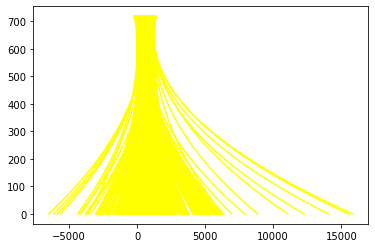

In [49]:
left_video = []
right_video = []
i_video = -1

harder_output = 'output_images/harder_challenge_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip3 = VideoFileClip("./harder_challenge_video.mp4")
harder_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time harder_clip.write_videofile(harder_output, audio=False)

In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_output))